In [1]:
import haversine as hs
from haversine import Unit
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import re
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
#from google.colab import drive
from sklearn import covariance
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import warnings

# Suprimir todos los warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Output Aureas/Sin_Lluvia/'
data = os.listdir(path)
dft = pd.DataFrame()
for i in tqdm(data):
  if i[0] == 'C':
    df = pd.read_excel(path+i)
    df = pd.DataFrame(df, columns=['File','Length','Fdom','FminVoc','FmaxVoc','Class', 'Membership'])
    dft = pd.concat([dft,df], ignore_index = True)
dft

  0%|          | 0/4 [00:00<?, ?it/s]

File    Length         Fdom    FminVoc  \
0        SMA03126_20210322_153000.wav  0.352000  6679.596037  6585.9375   
1        SMA03126_20210322_153000.wav  0.650667  6890.327744  6585.9375   
2        SMA03126_20210322_153000.wav  0.789333  6210.846037  6117.1875   
3        SMA03126_20210322_153000.wav  0.736000  6679.596037  6585.9375   
4        SMA03126_20210322_153000.wav  0.768000  6632.721037  6539.0625   
...                               ...       ...          ...        ...   
3036710  SMA03326_20210328_054000.wav  0.330667  4124.611280  3726.5625   
3036711  SMA03326_20210328_054000.wav  0.192000  2554.527439  2390.6250   
3036712  SMA03326_20210328_054000.wav  0.213333  4194.740854  3609.3750   
3036713  SMA03326_20210328_054000.wav  0.224000  2531.089939  2367.1875   
3036714  SMA03326_20210328_054000.wav  0.277333  2343.612805  2203.1250   

           FmaxVoc  Class  Membership  
0        7617.1875      1    0.763591  
1        7617.1875      1    0.777246  
2        7617.1875     35    0.828466  
3        7617.1875      1    0.771071  
4        7617.1875      1    0.783098  
...            ...    ...         ...  
3036710  4289.0625     47    0.906516  
3036711  3093.7500     28    0.974467  
3036712  4359.3750    299    0.895544  
3036713  3093.7500     28    0.972158  
3036714  3093.7500     28    0.966220  

[3036715 rows x 7 columns]

# Análisis de datos

In [3]:
class_counts1 = dft['Class'].value_counts()
class_counts1

1      1227770
13      142944
7       141169
3       130847
9       102213
        ...   
292          1
71           1
227          1
38           1
206          1
Name: Class, Length: 358, dtype: int64

In [4]:
df= dft[dft['Class']!=1]
df

File    Length         Fdom    FminVoc  \
2        SMA03126_20210322_153000.wav  0.789333  6210.846037  6117.1875   
8        SMA03126_20210322_153000.wav  0.085333  5624.954268  5578.1250   
9        SMA03126_20210322_153000.wav  0.138667  5390.396341  5156.2500   
17       SMA03126_20210322_153000.wav  0.576000  6421.783537  6328.1250   
27       SMA03126_20210322_153000.wav  0.085333  5928.452744  4664.0625   
...                               ...       ...          ...        ...   
3036710  SMA03326_20210328_054000.wav  0.330667  4124.611280  3726.5625   
3036711  SMA03326_20210328_054000.wav  0.192000  2554.527439  2390.6250   
3036712  SMA03326_20210328_054000.wav  0.213333  4194.740854  3609.3750   
3036713  SMA03326_20210328_054000.wav  0.224000  2531.089939  2367.1875   
3036714  SMA03326_20210328_054000.wav  0.277333  2343.612805  2203.1250   

           FmaxVoc  Class  Membership  
2        7617.1875     35    0.828466  
8        6140.6250    230    0.813142  
9        5625.0000    226    0.800139  
17       7617.1875      8    0.829095  
27       6375.0000    277    0.803985  
...            ...    ...         ...  
3036710  4289.0625     47    0.906516  
3036711  3093.7500     28    0.974467  
3036712  4359.3750    299    0.895544  
3036713  3093.7500     28    0.972158  
3036714  3093.7500     28    0.966220  

[1808945 rows x 7 columns]

In [5]:
class_counts = df['Class'].value_counts()
class_counts

13     142944
7      141169
3      130847
9      102213
18      59129
        ...  
227         1
169         1
316         1
93          1
206         1
Name: Class, Length: 357, dtype: int64

In [6]:
# Elimino clases con menos de 17 segmentos - # de lugares
classes_to_keep = class_counts[(class_counts >= 17) & (class_counts.index != 1)].index.tolist()
df_filtered1 = df[df['Class'].isin(classes_to_keep)]
total_classes = len(df_filtered1['Class'].unique())
print(total_classes, df_filtered1)

295                                  File    Length         Fdom    FminVoc  \
2        SMA03126_20210322_153000.wav  0.789333  6210.846037  6117.1875   
8        SMA03126_20210322_153000.wav  0.085333  5624.954268  5578.1250   
9        SMA03126_20210322_153000.wav  0.138667  5390.396341  5156.2500   
17       SMA03126_20210322_153000.wav  0.576000  6421.783537  6328.1250   
27       SMA03126_20210322_153000.wav  0.085333  5928.452744  4664.0625   
...                               ...       ...          ...        ...   
3036710  SMA03326_20210328_054000.wav  0.330667  4124.611280  3726.5625   
3036711  SMA03326_20210328_054000.wav  0.192000  2554.527439  2390.6250   
3036712  SMA03326_20210328_054000.wav  0.213333  4194.740854  3609.3750   
3036713  SMA03326_20210328_054000.wav  0.224000  2531.089939  2367.1875   
3036714  SMA03326_20210328_054000.wav  0.277333  2343.612805  2203.1250   

           FmaxVoc  Class  Membership  
2        7617.1875     35    0.828466  
8        6140.6

In [57]:
# Calcular la nueva columna 'ancho de banda'
df_filtered1['Bandwidth'] = df_filtered1['FmaxVoc'] - df_filtered1['FminVoc']
df_filtered1

File    Length         Fdom    FminVoc  \
2        SMA03126_20210322_153000.wav  0.789333  6210.846037  6117.1875   
8        SMA03126_20210322_153000.wav  0.085333  5624.954268  5578.1250   
9        SMA03126_20210322_153000.wav  0.138667  5390.396341  5156.2500   
17       SMA03126_20210322_153000.wav  0.576000  6421.783537  6328.1250   
27       SMA03126_20210322_153000.wav  0.085333  5928.452744  4664.0625   
...                               ...       ...          ...        ...   
3036710  SMA03326_20210328_054000.wav  0.330667  4124.611280  3726.5625   
3036711  SMA03326_20210328_054000.wav  0.192000  2554.527439  2390.6250   
3036712  SMA03326_20210328_054000.wav  0.213333  4194.740854  3609.3750   
3036713  SMA03326_20210328_054000.wav  0.224000  2531.089939  2367.1875   
3036714  SMA03326_20210328_054000.wav  0.277333  2343.612805  2203.1250   

           FmaxVoc  Class  Membership  Bandwidth  
2        7617.1875     35    0.828466  1500.0000  
8        6140.6250    230    0.813142   562.5000  
9        5625.0000    226    0.800139   468.7500  
17       7617.1875      8    0.829095  1289.0625  
27       6375.0000    277    0.803985  1710.9375  
...            ...    ...         ...        ...  
3036710  4289.0625     47    0.906516   562.5000  
3036711  3093.7500     28    0.974467   703.1250  
3036712  4359.3750    299    0.895544   750.0000  
3036713  3093.7500     28    0.972158   726.5625  
3036714  3093.7500     28    0.966220   890.6250  

[1808648 rows x 8 columns]

In [56]:
# Calcular la mediana de 'Bandwith' para cada 'Class'
median_bandwith_per_class = df_filtered1.groupby('Class')['Bandwidth'].median()

# Imprimir todo el contenido de median_bandwith_per_class
print(median_bandwith_per_class.to_string())

Class
2       1710.93750
3        703.12500
4        773.43750
5       1664.06250
6       5648.43750
7        773.43750
8        960.93750
9        609.37500
10      1500.00000
11       445.31250
12       585.93750
13       703.12500
14       679.68750
15      1335.93750
16      1804.68750
17     10945.31250
18       703.12500
19       562.50000
20      1195.31250
21       398.43750
22       562.50000
23       691.40625
24       914.06250
25       539.06250
26       527.34375
27       726.56250
28       679.68750
29       539.06250
30       539.06250
33       445.31250
34       562.50000
35       679.68750
37       960.93750
39       679.68750
40       585.93750
41     12984.37500
42       585.93750
44       750.00000
45       539.06250
46       750.00000
47       609.37500
48      1171.87500
50       515.62500
52       585.93750
53       539.06250
54       445.31250
56       398.43750
57      1078.12500
58       421.87500
59      8261.71875
60      1054.68750
61       937.50000
62    

In [58]:
# Calcula la mediana del ancho de banda para cada clase
median_bandwith_per_class = df_filtered1.groupby('Class').agg({'Bandwidth': 'median'})

# Encuentra las clases donde la mediana del ancho de banda es mayor a 7000
classes_to_remove = median_bandwith_per_class[median_bandwith_per_class['Bandwidth'] > 7000].index.tolist()

# Filtra el dataframe original para excluir esos segmentos asociados a las clases identificadas
filtered_df = df_filtered1[~df_filtered1['Class'].isin(classes_to_remove)]

total_classes = len(filtered_df['Class'].unique())
print(total_classes,filtered_df)

290                                  File    Length         Fdom    FminVoc  \
2        SMA03126_20210322_153000.wav  0.789333  6210.846037  6117.1875   
8        SMA03126_20210322_153000.wav  0.085333  5624.954268  5578.1250   
9        SMA03126_20210322_153000.wav  0.138667  5390.396341  5156.2500   
17       SMA03126_20210322_153000.wav  0.576000  6421.783537  6328.1250   
27       SMA03126_20210322_153000.wav  0.085333  5928.452744  4664.0625   
...                               ...       ...          ...        ...   
3036710  SMA03326_20210328_054000.wav  0.330667  4124.611280  3726.5625   
3036711  SMA03326_20210328_054000.wav  0.192000  2554.527439  2390.6250   
3036712  SMA03326_20210328_054000.wav  0.213333  4194.740854  3609.3750   
3036713  SMA03326_20210328_054000.wav  0.224000  2531.089939  2367.1875   
3036714  SMA03326_20210328_054000.wav  0.277333  2343.612805  2203.1250   

           FmaxVoc  Class  Membership  Bandwidth  
2        7617.1875     35    0.828466  1500.

# Patrón horario de las clases

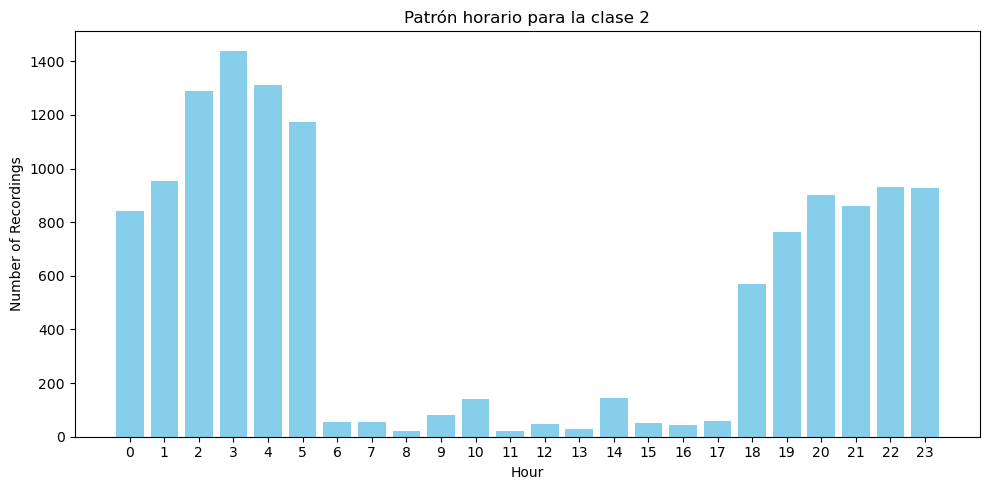

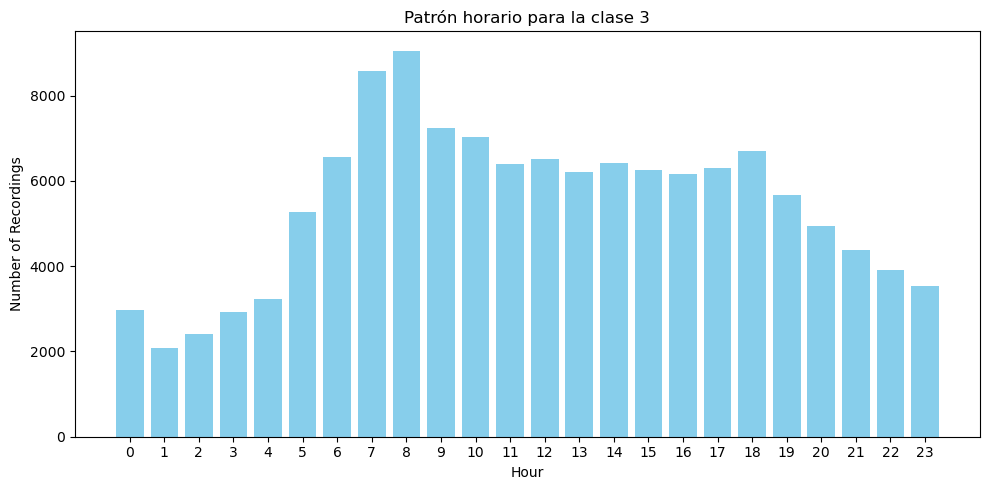

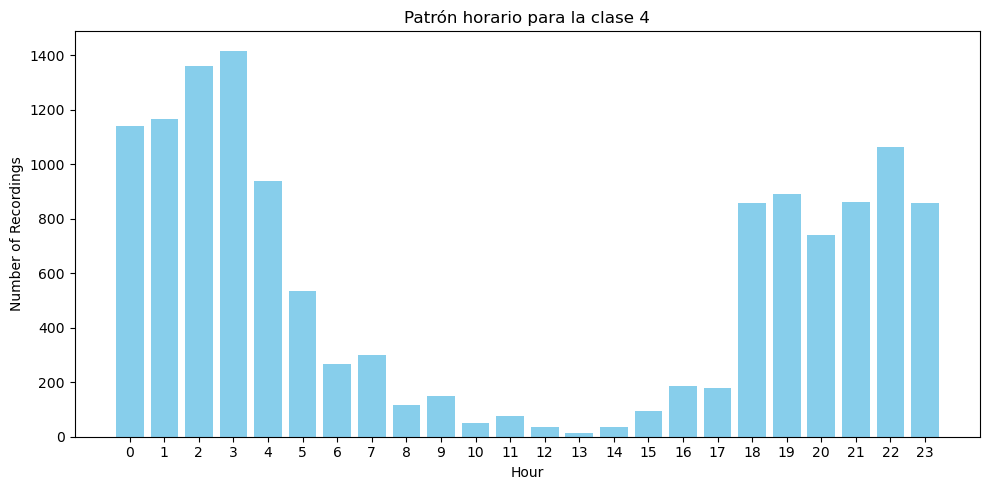

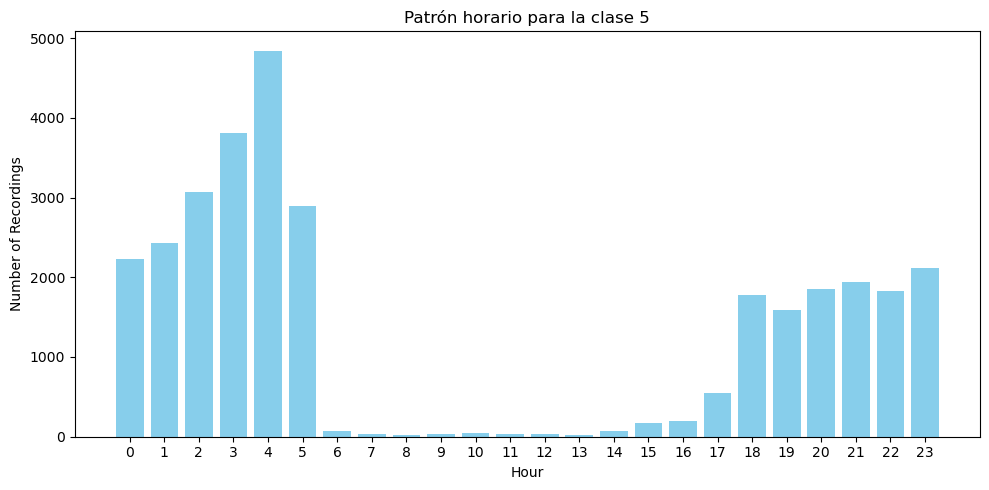

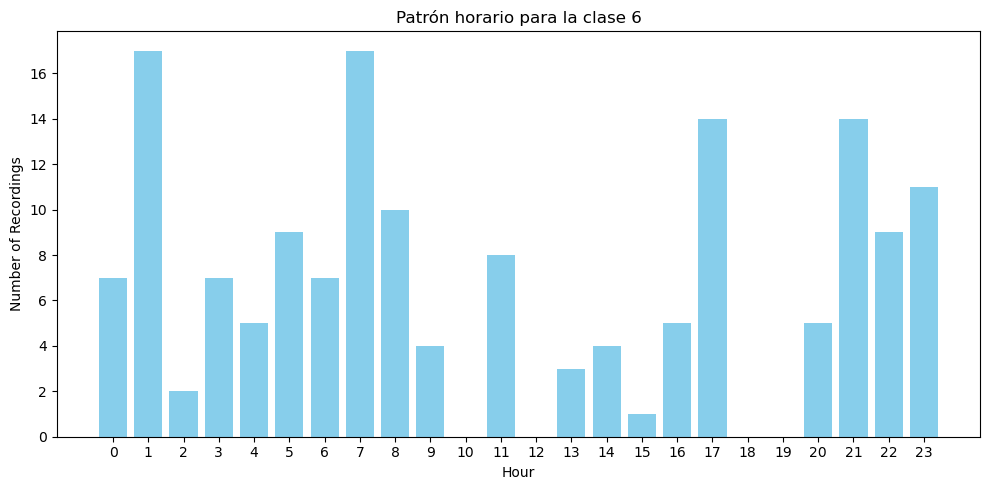

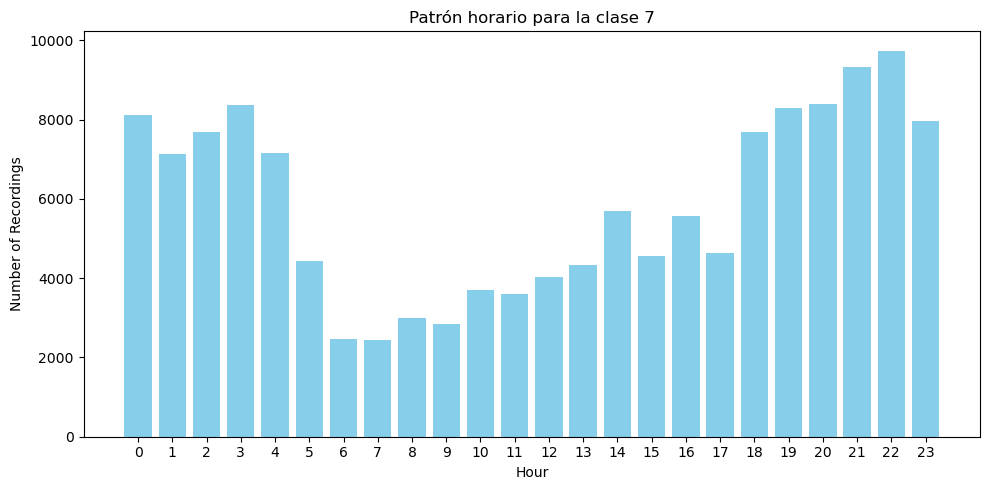

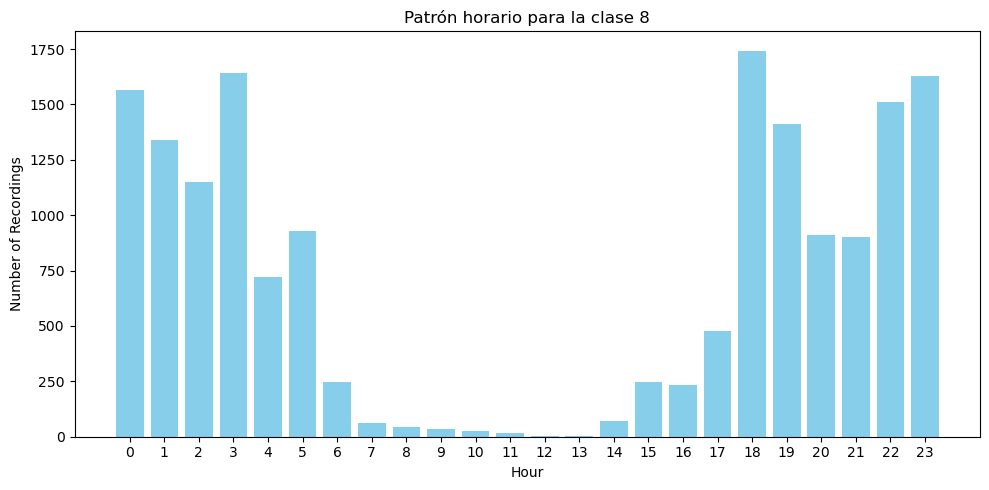

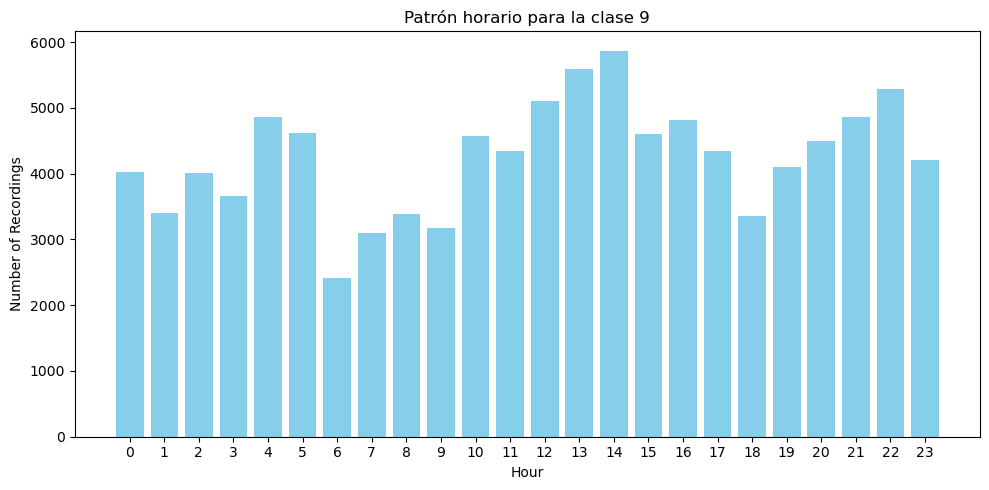

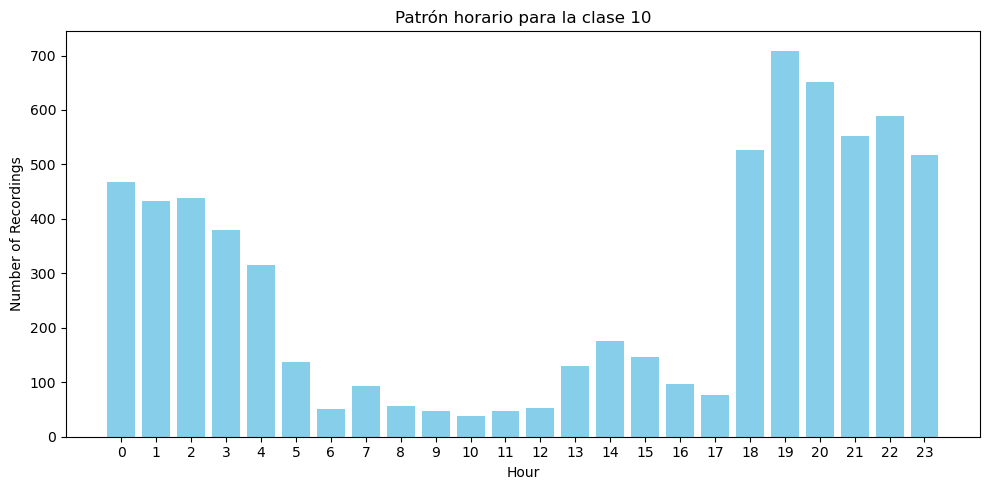

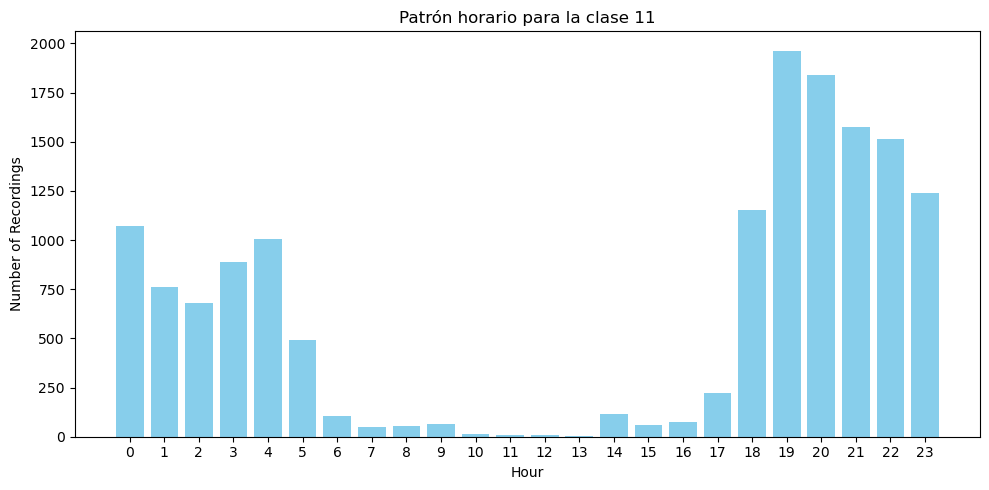

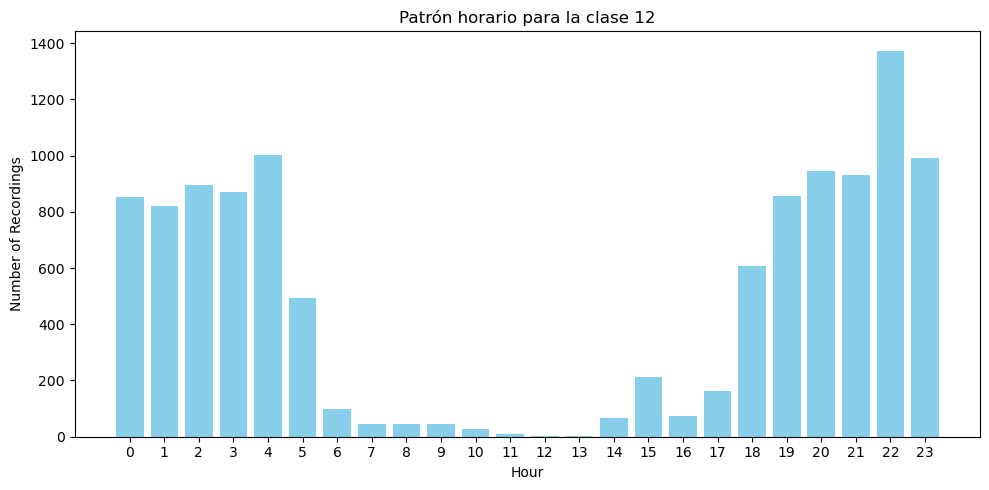

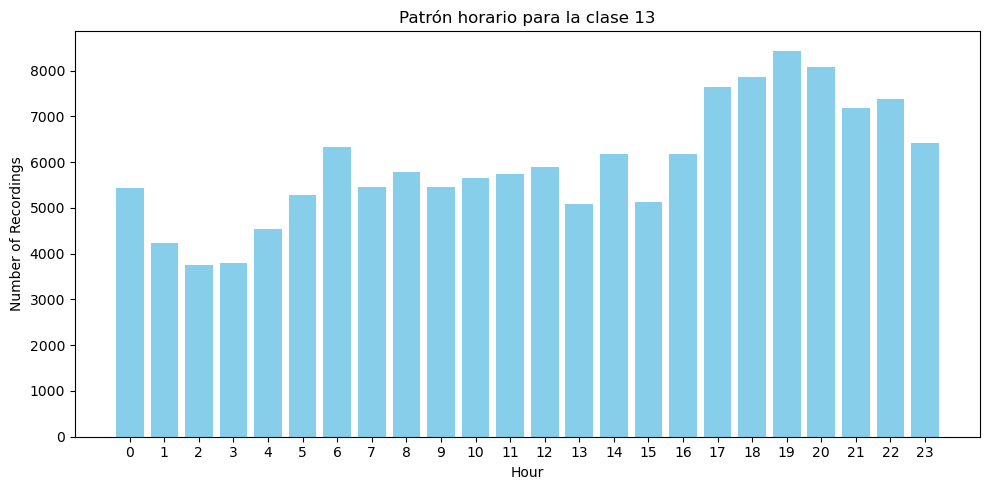

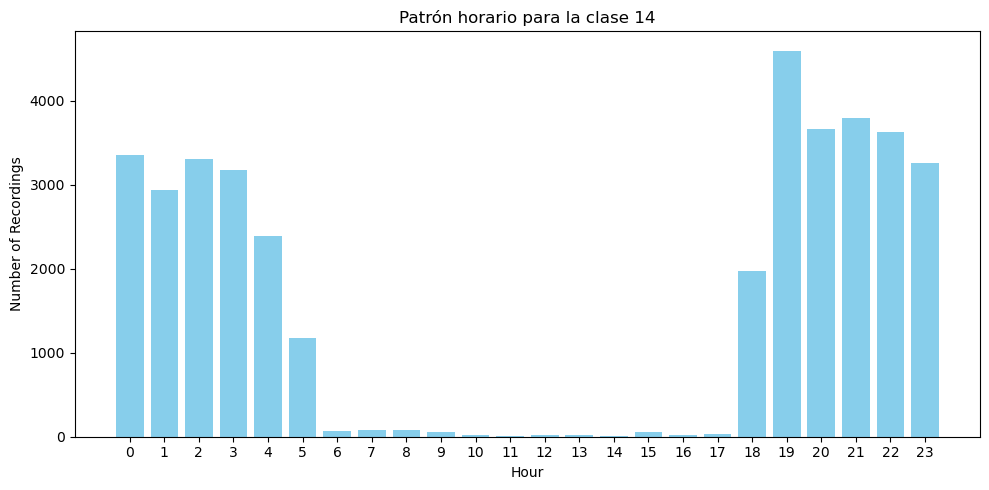

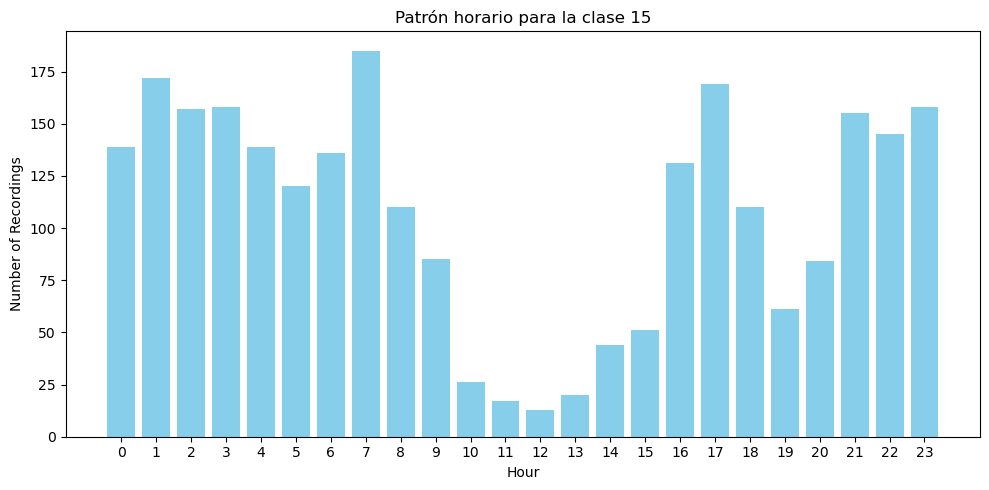

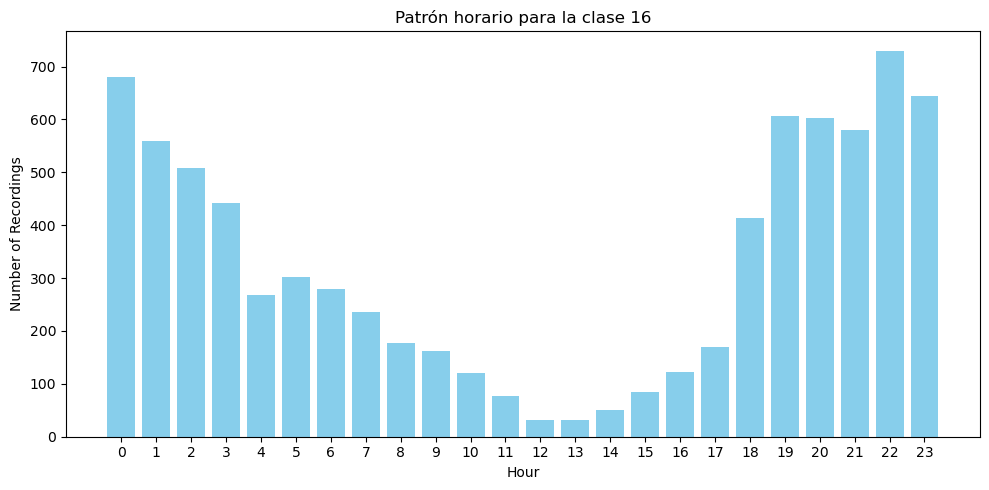

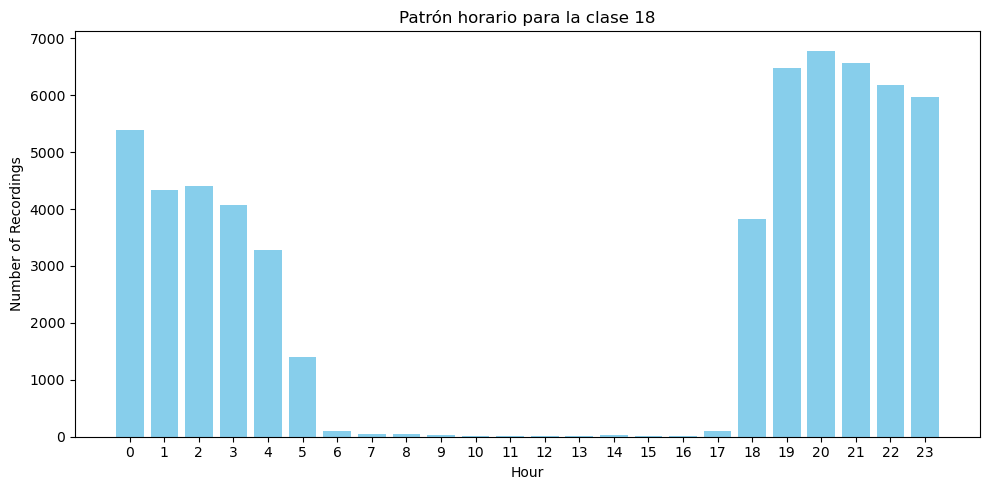

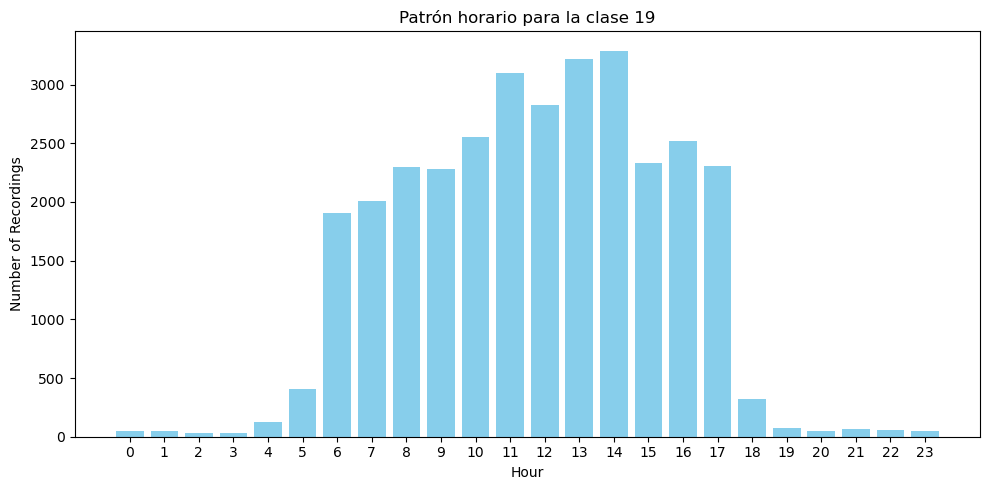

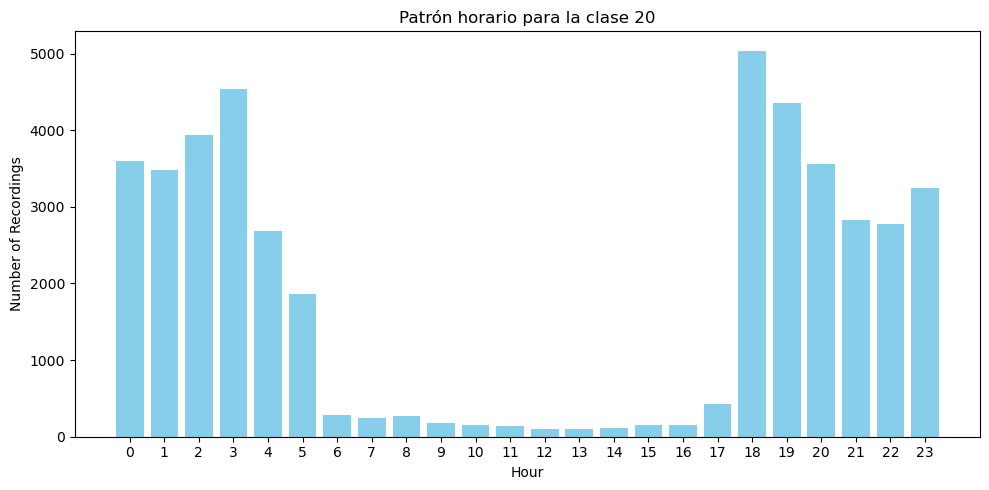

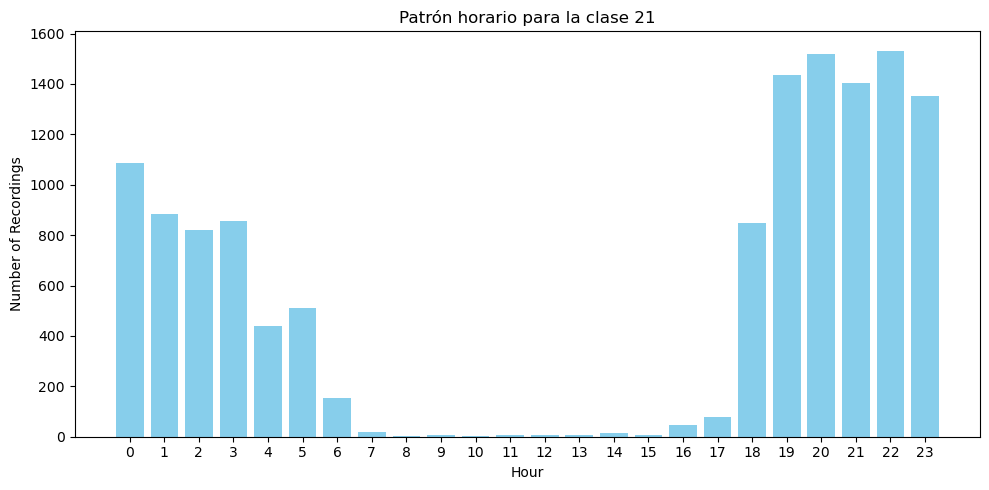

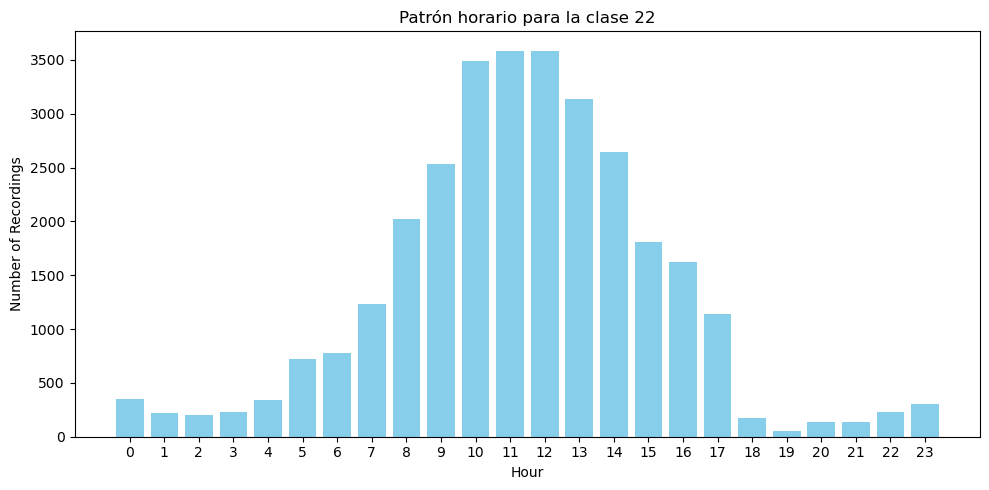

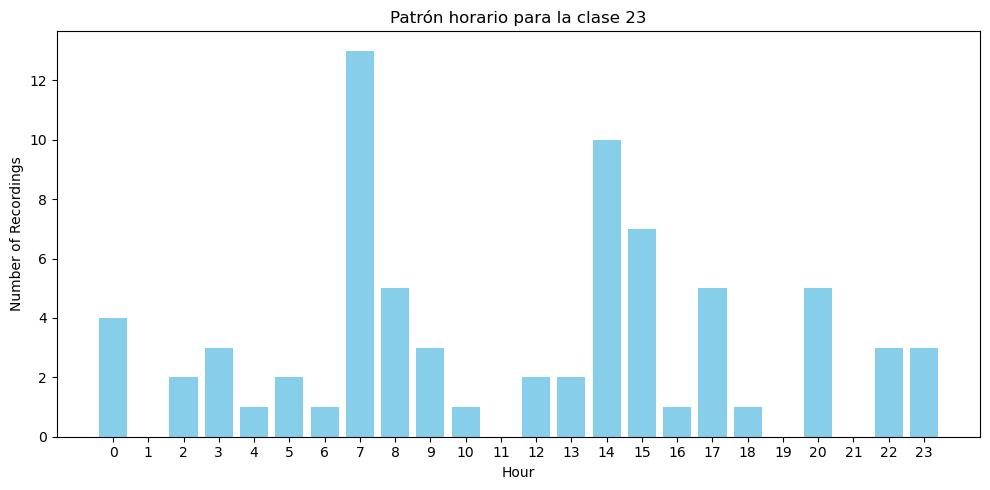

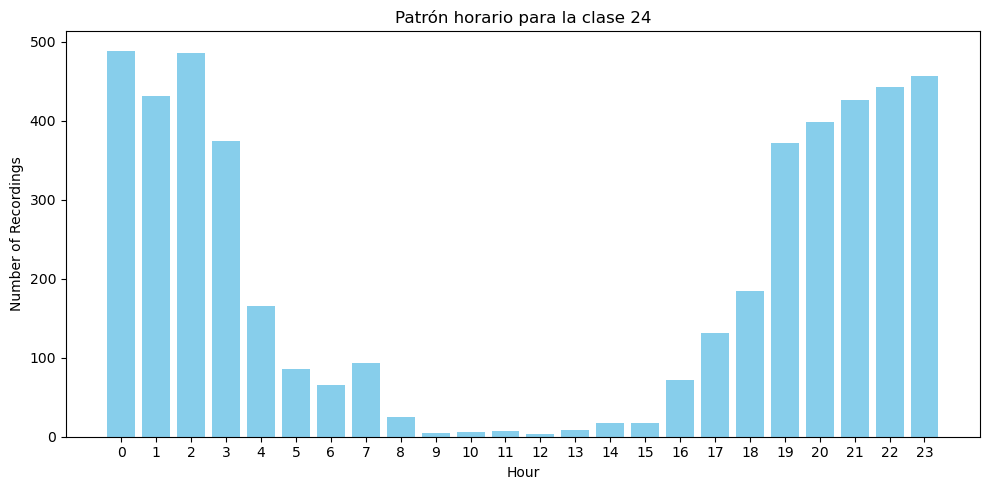

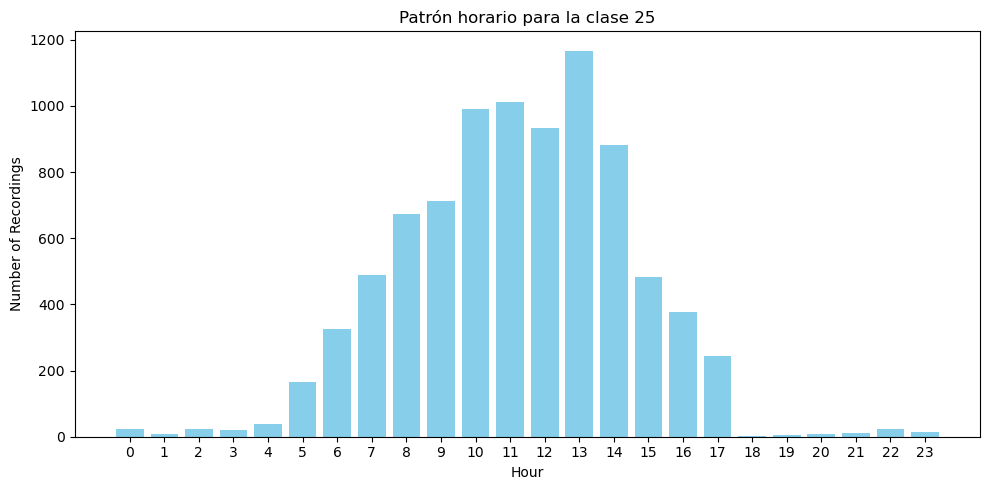

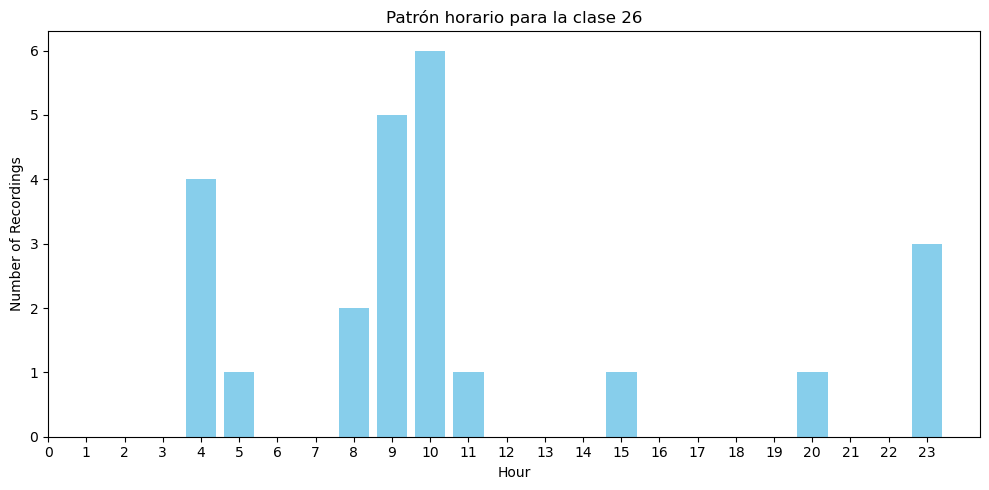

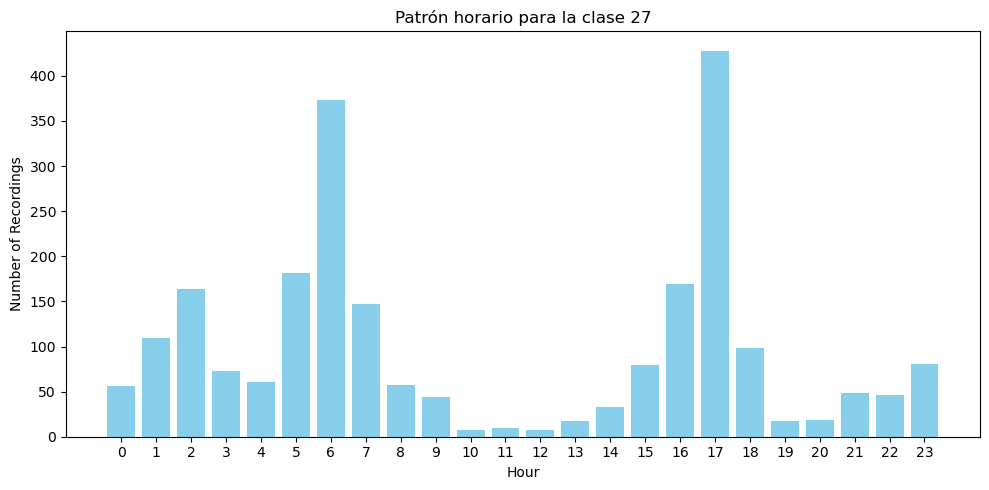

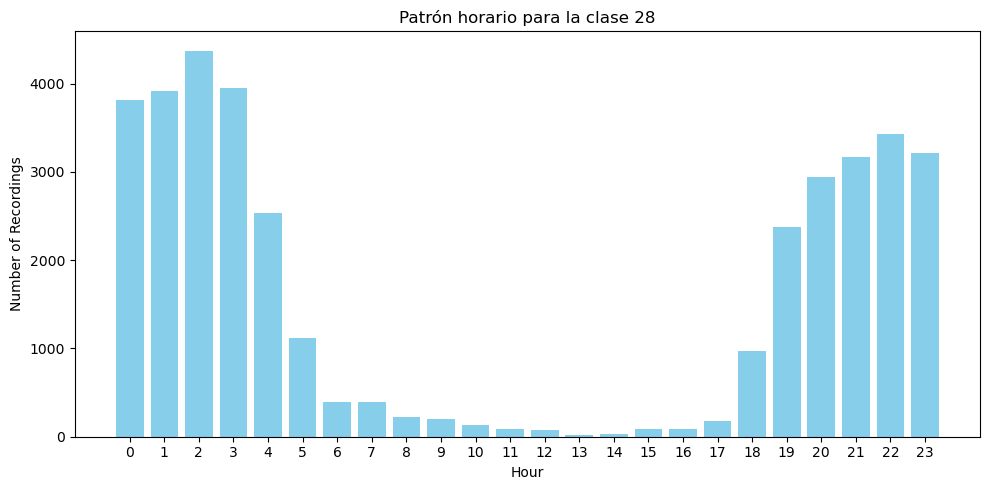

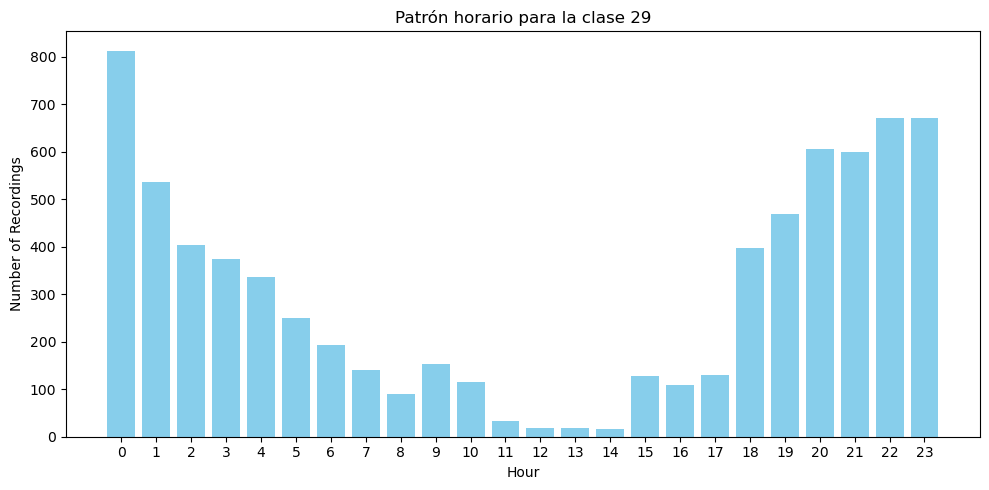

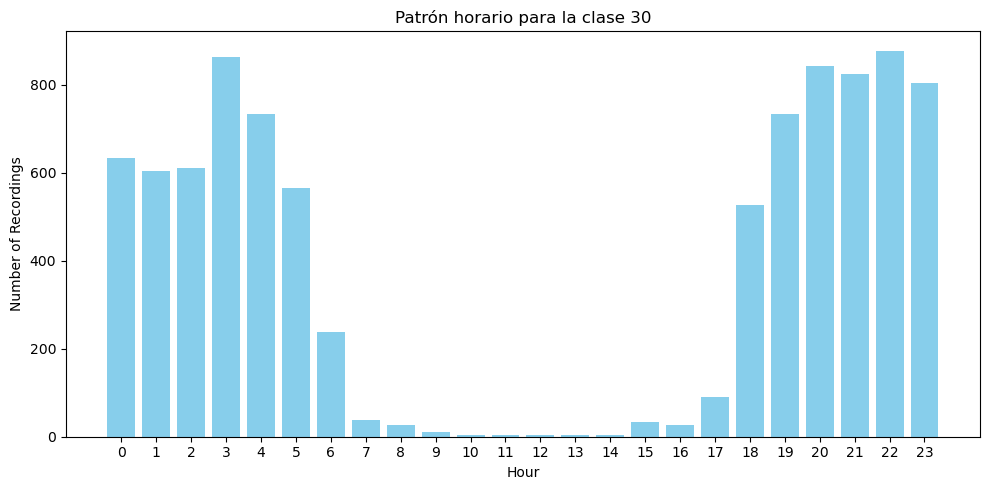

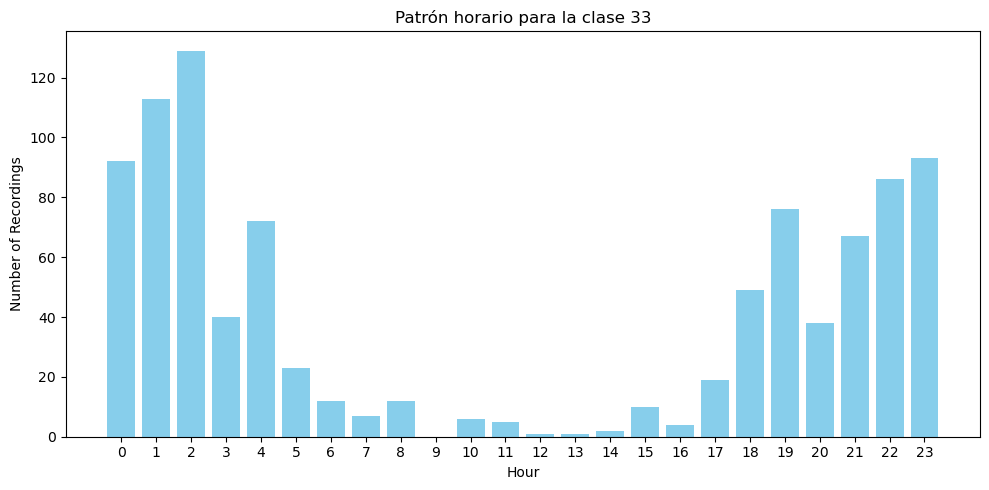

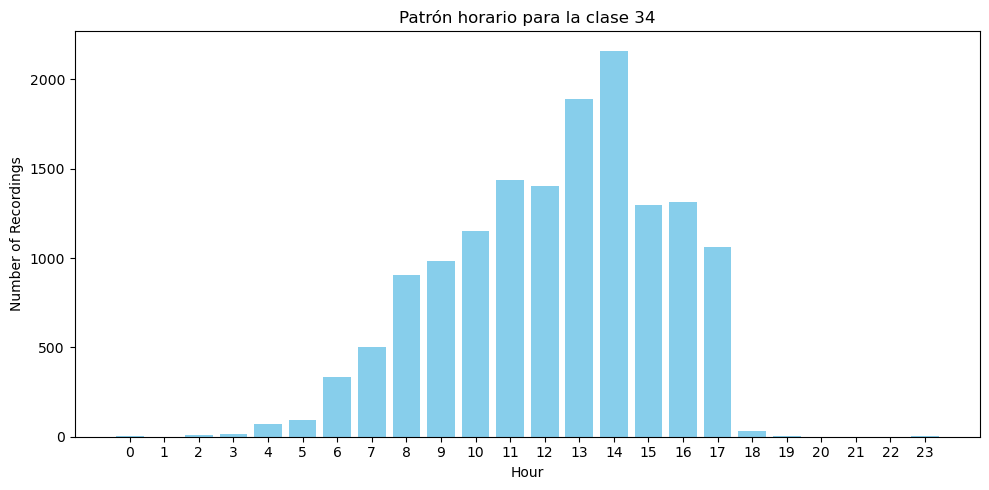

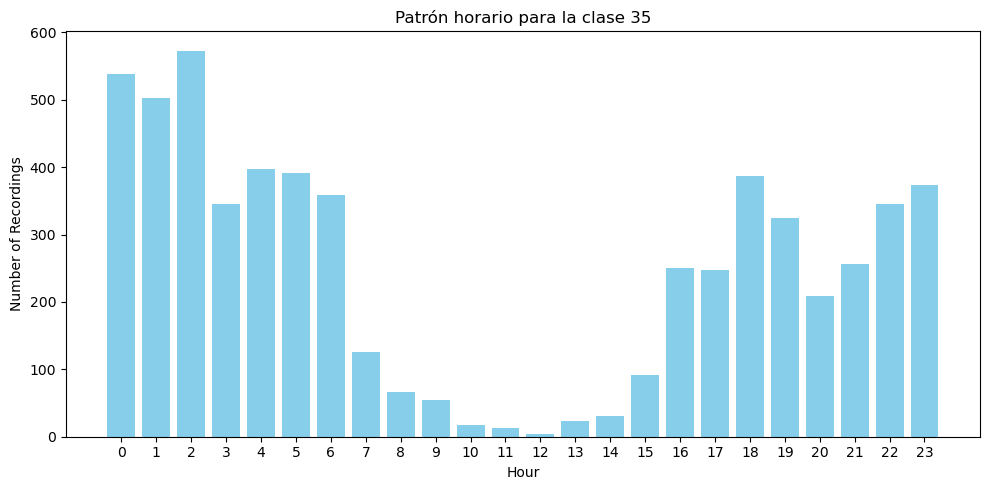

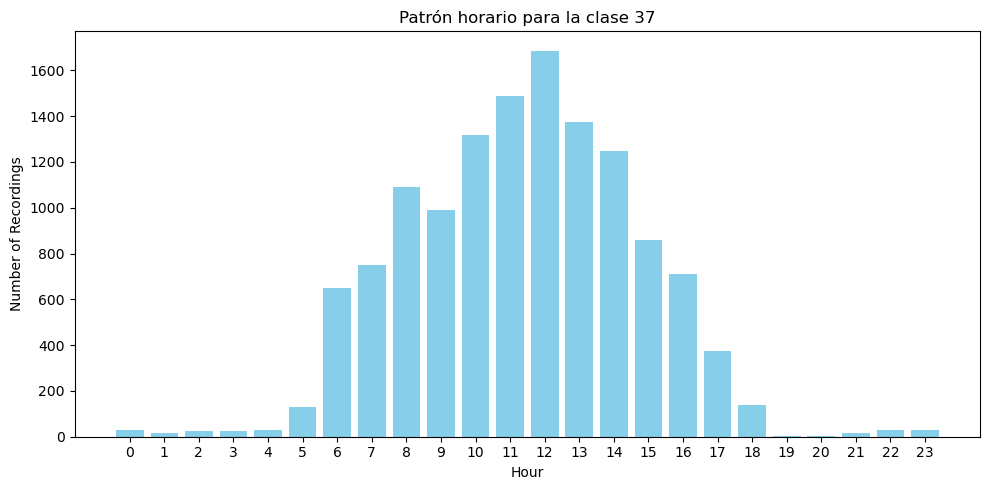

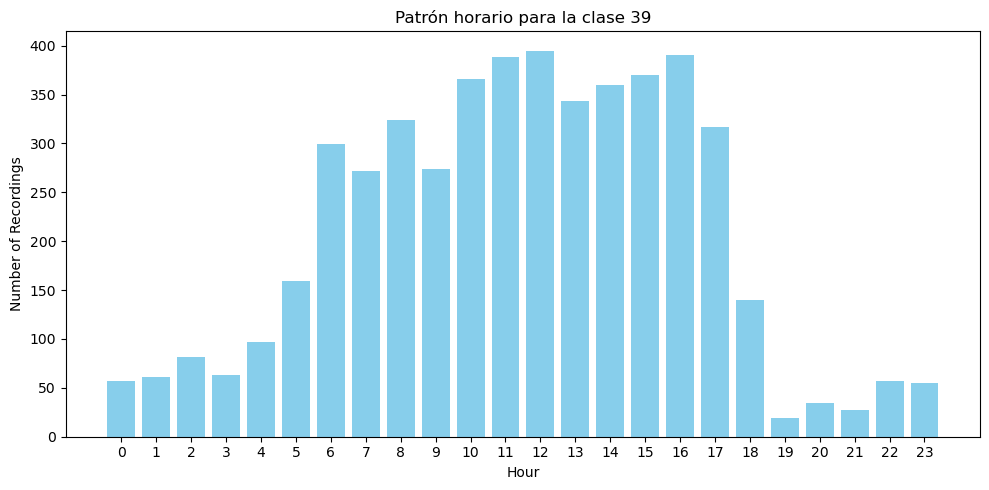

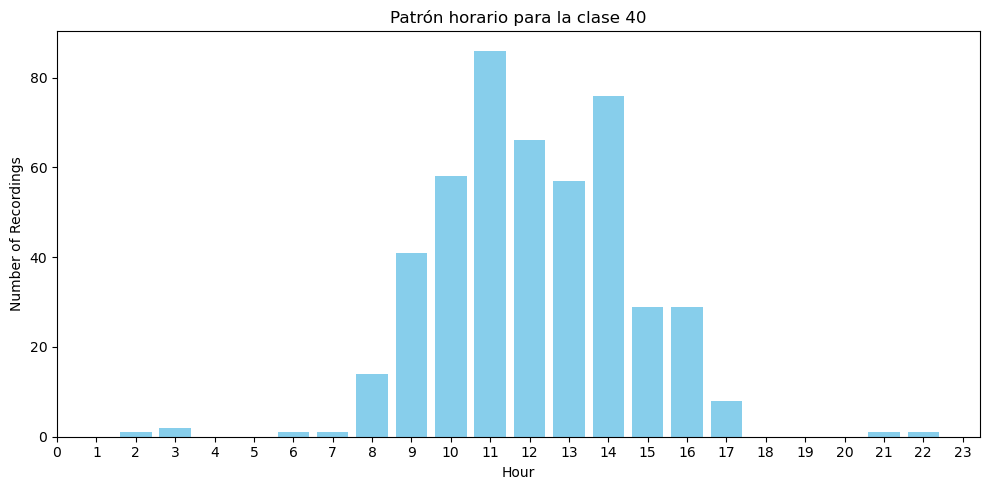

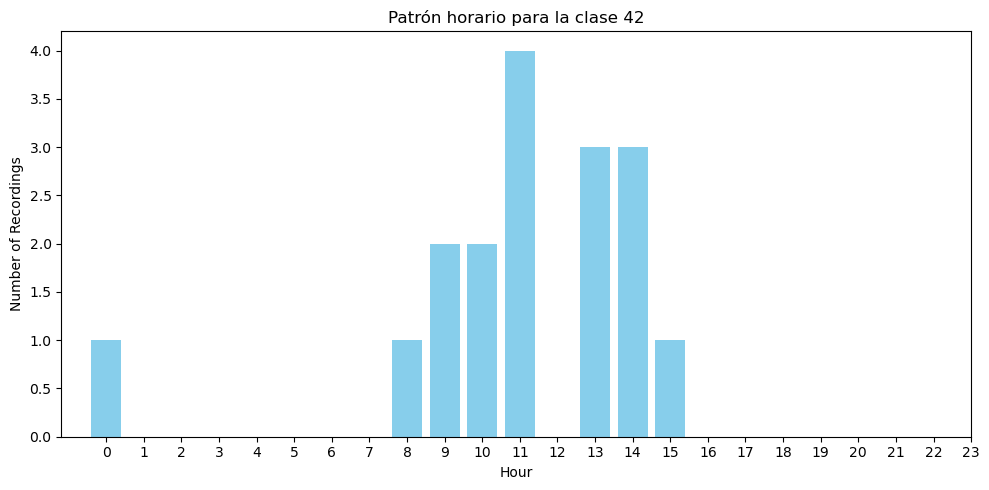

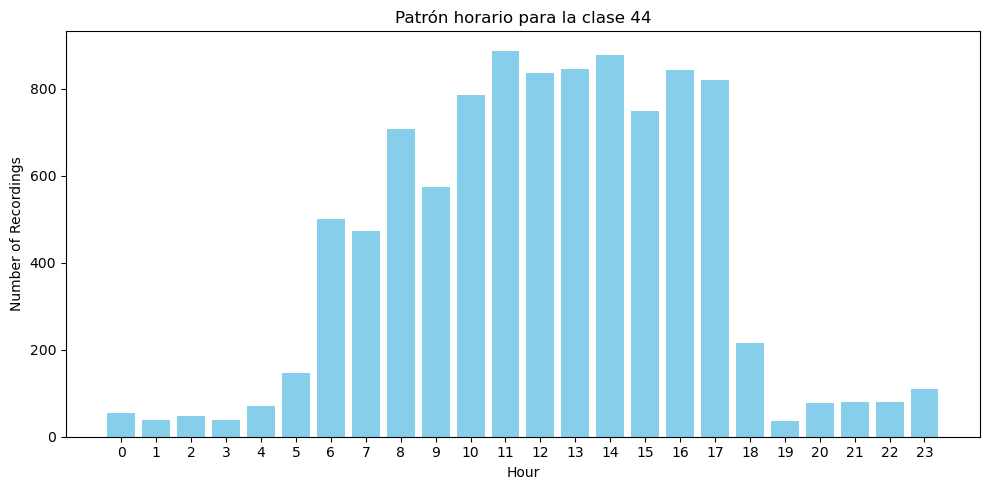

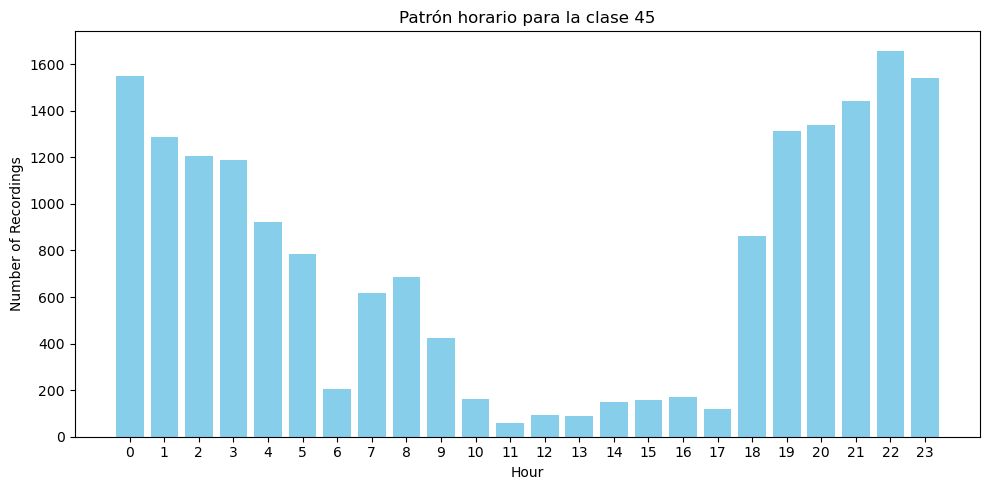

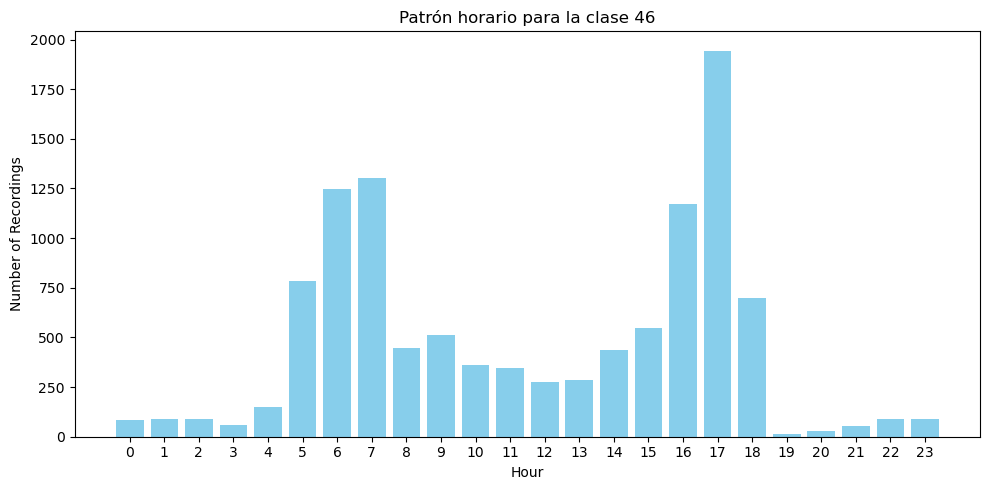

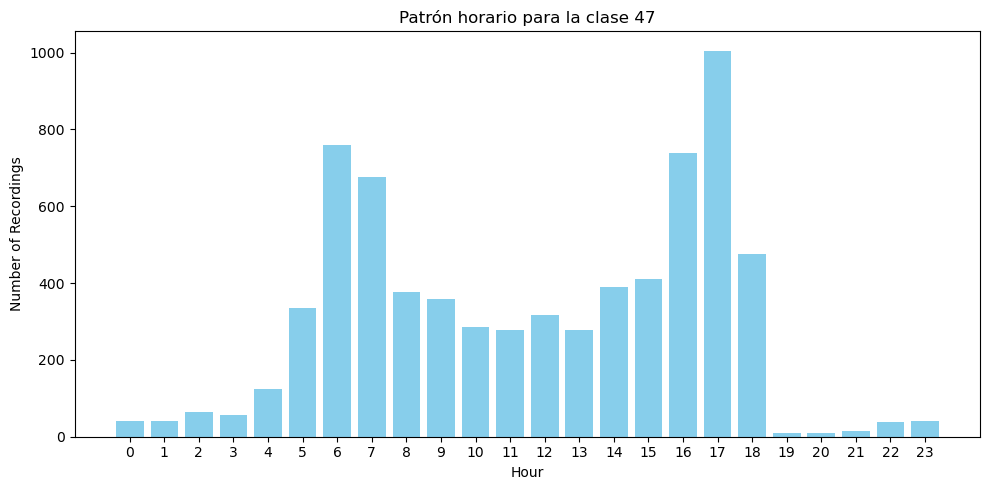

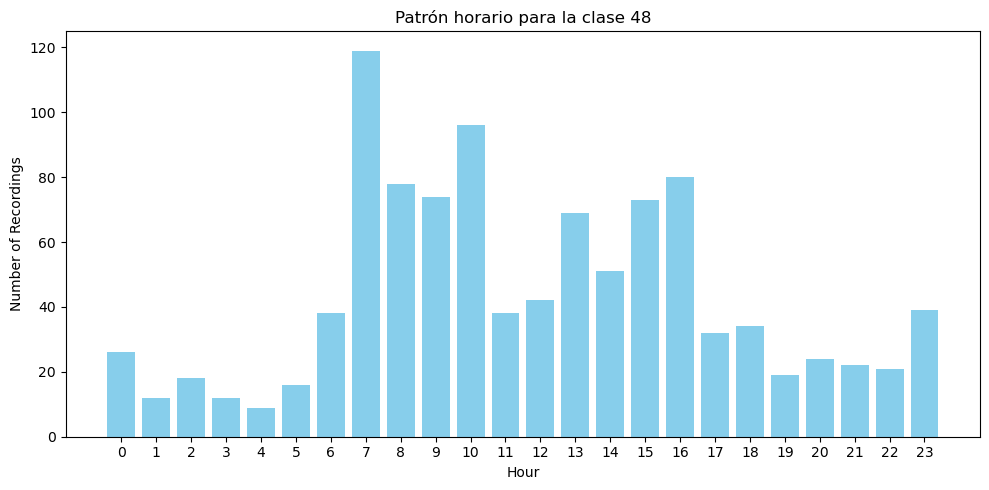

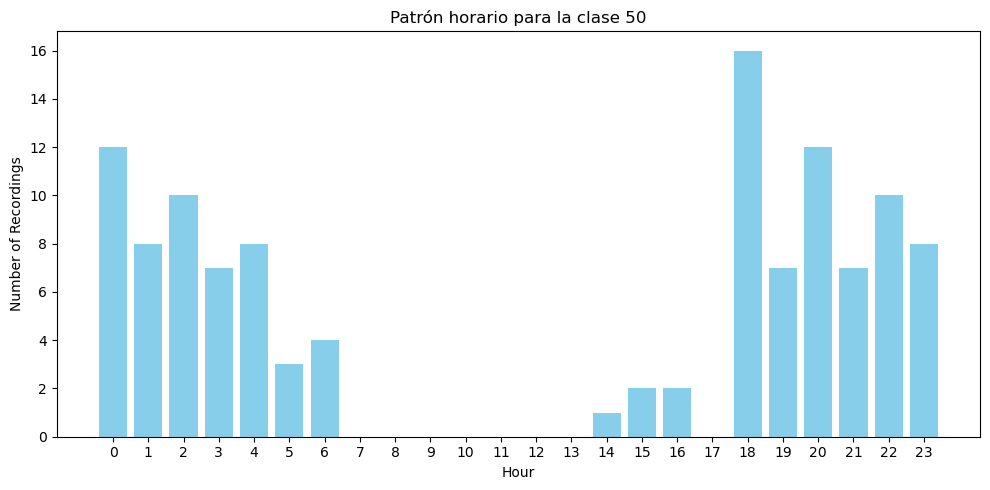

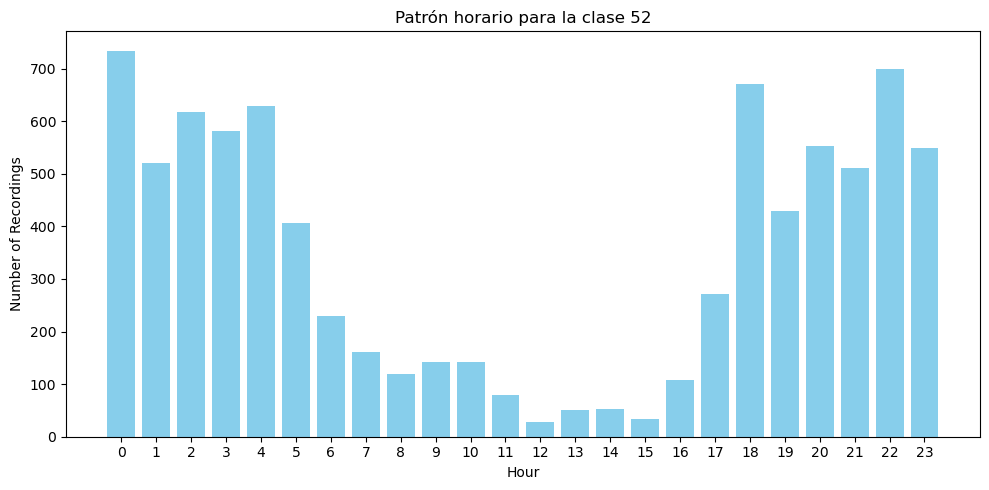

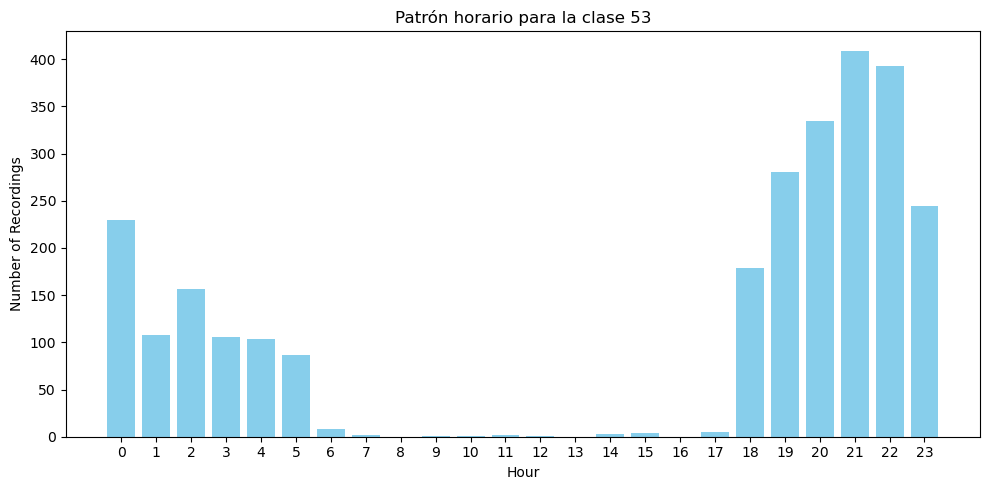

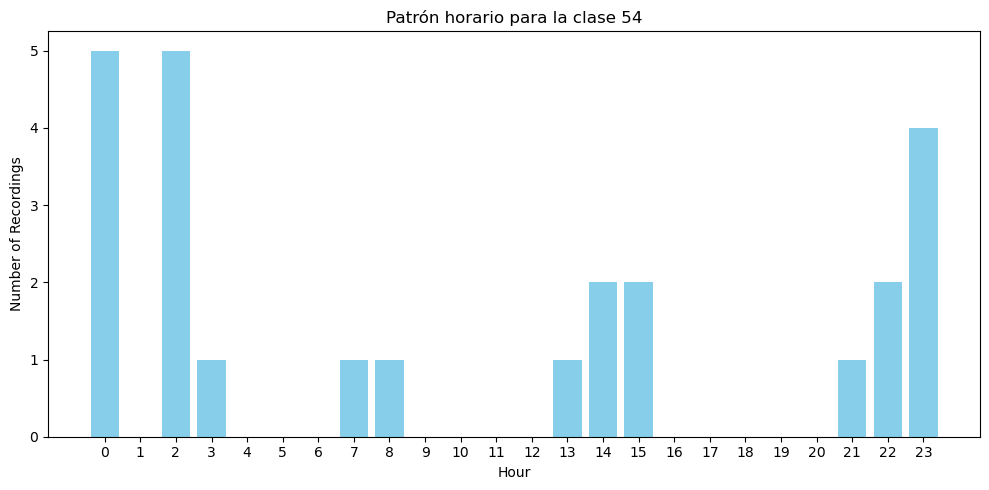

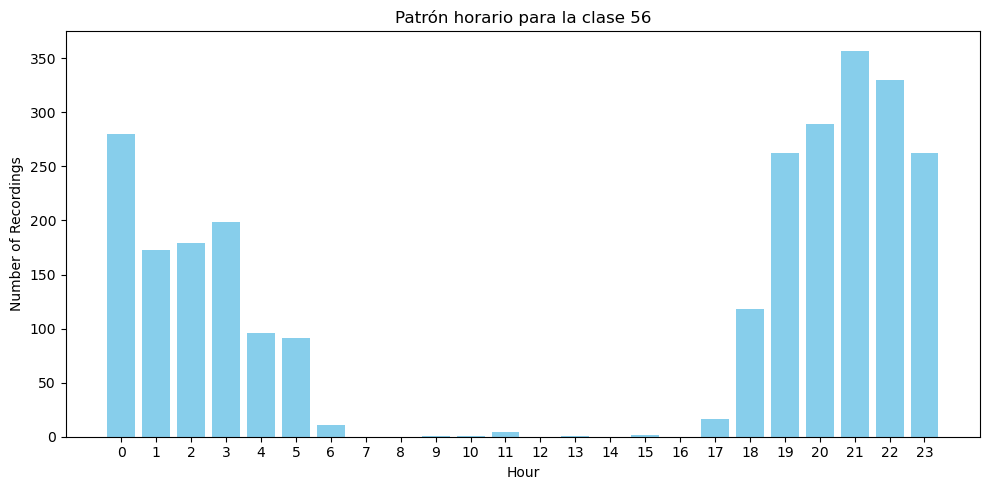

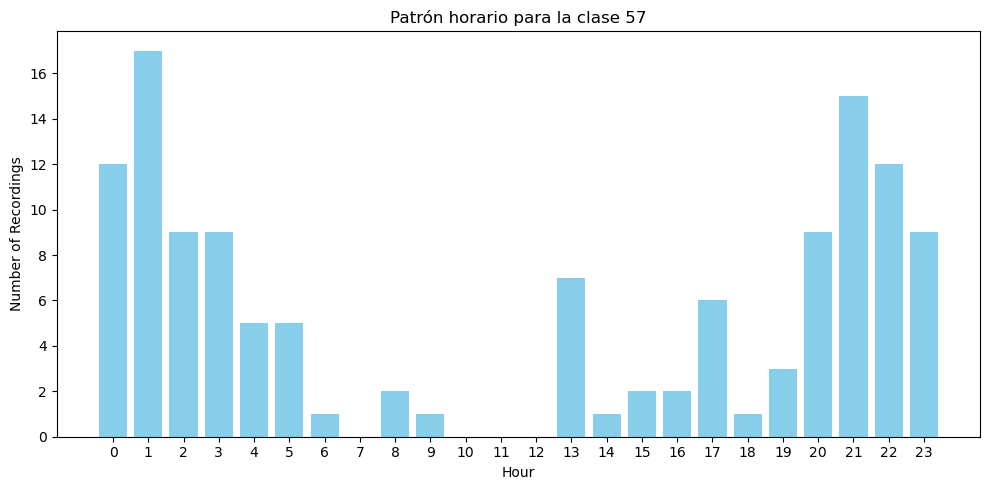

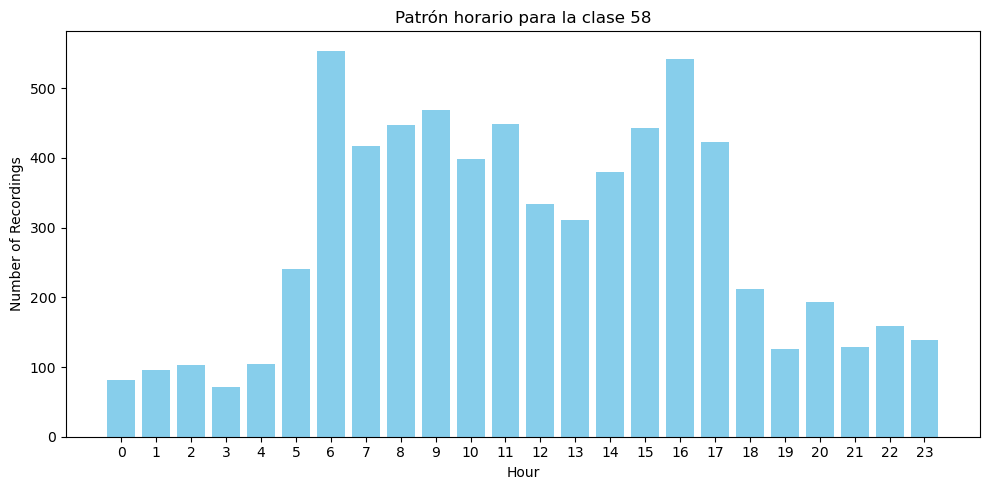

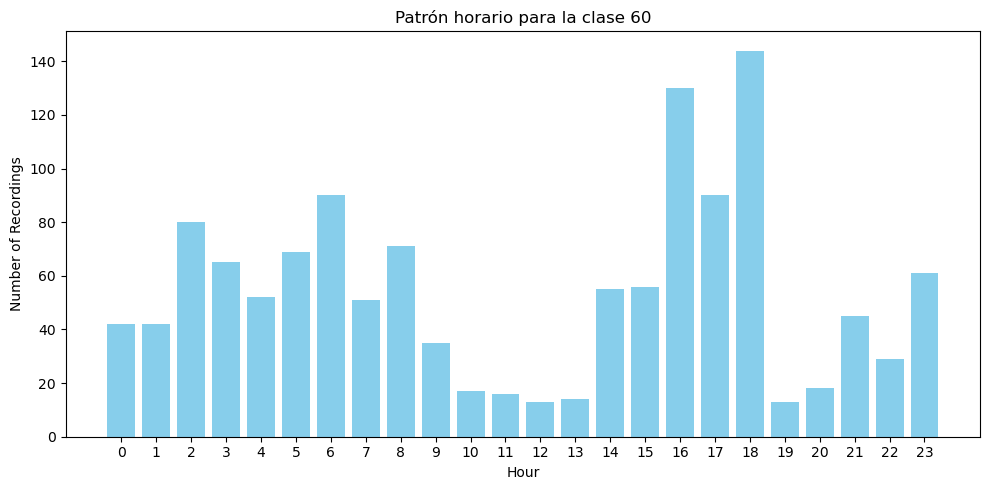

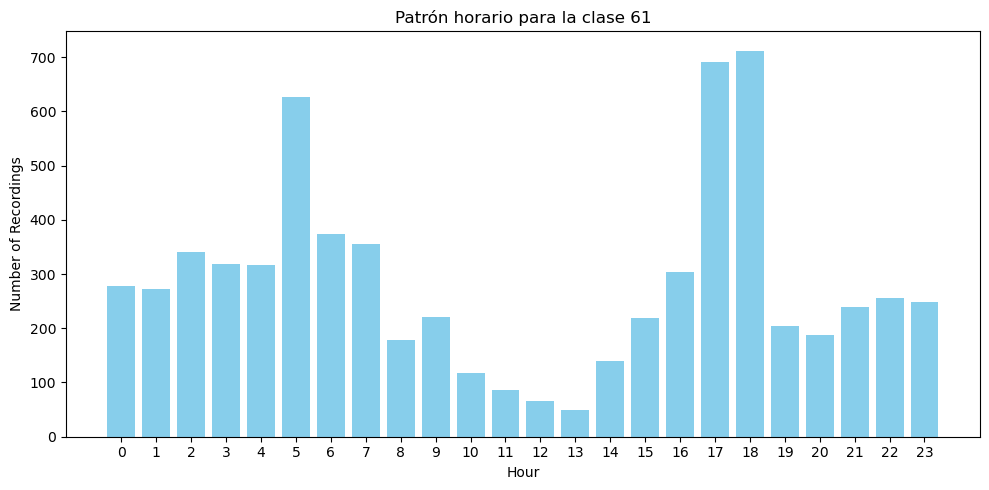

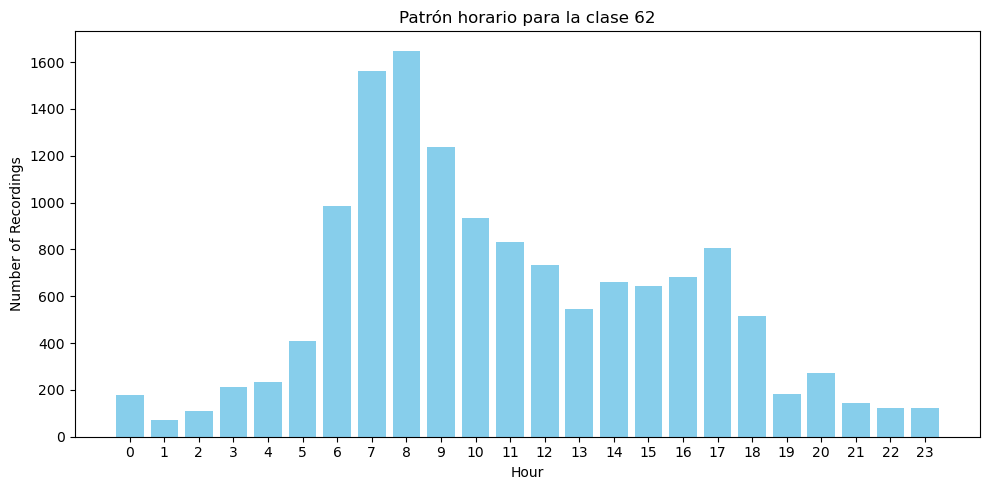

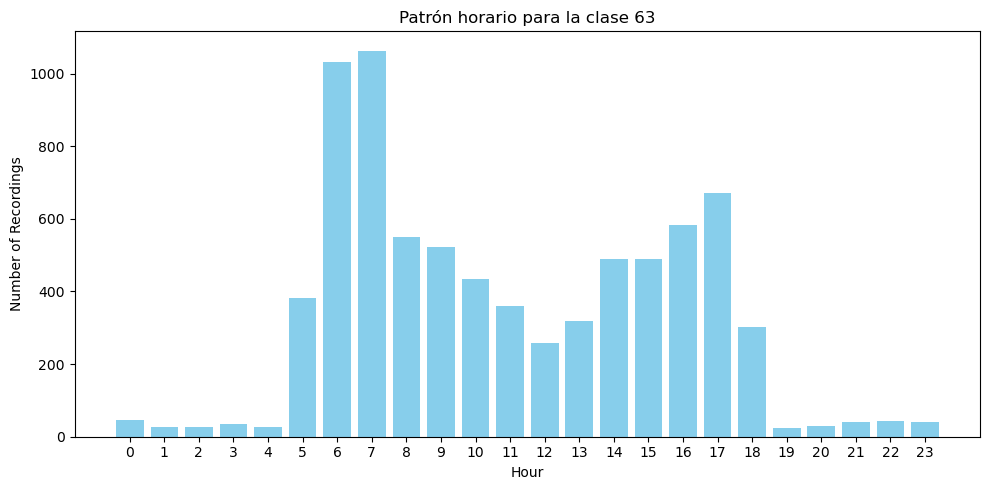

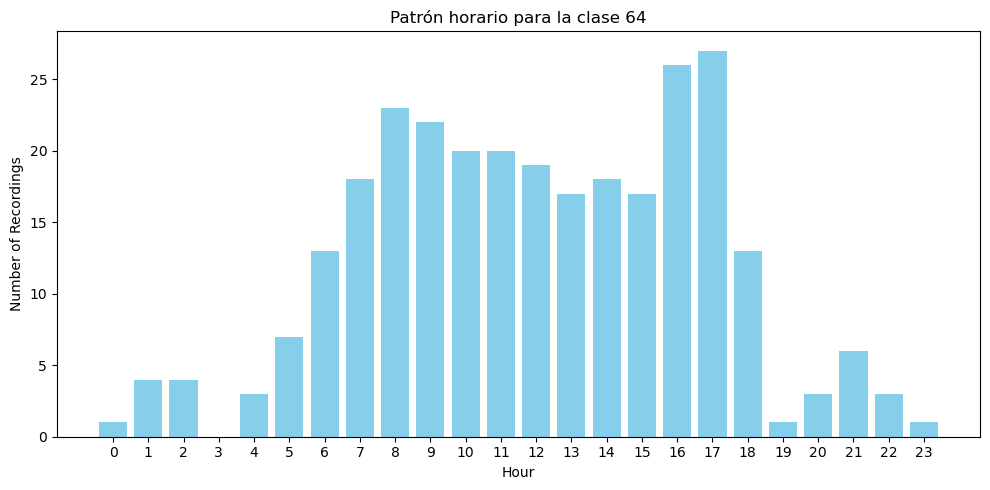

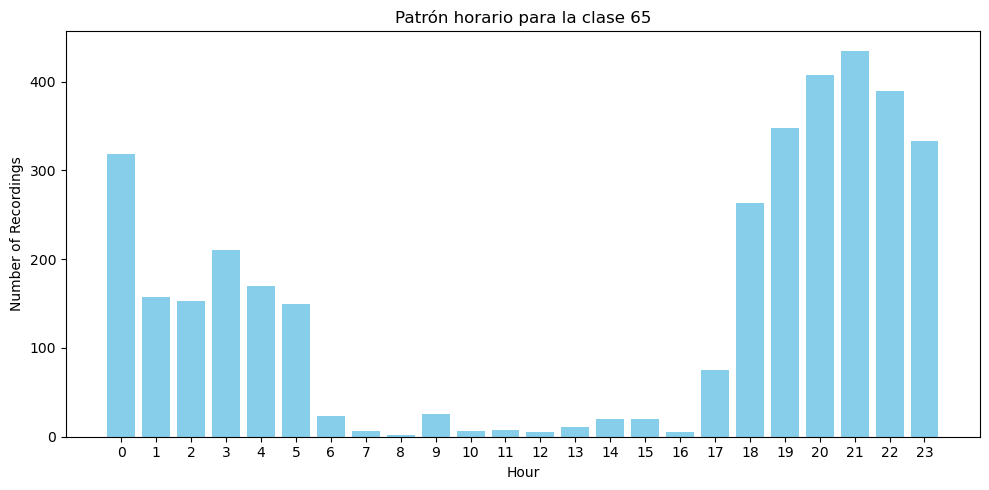

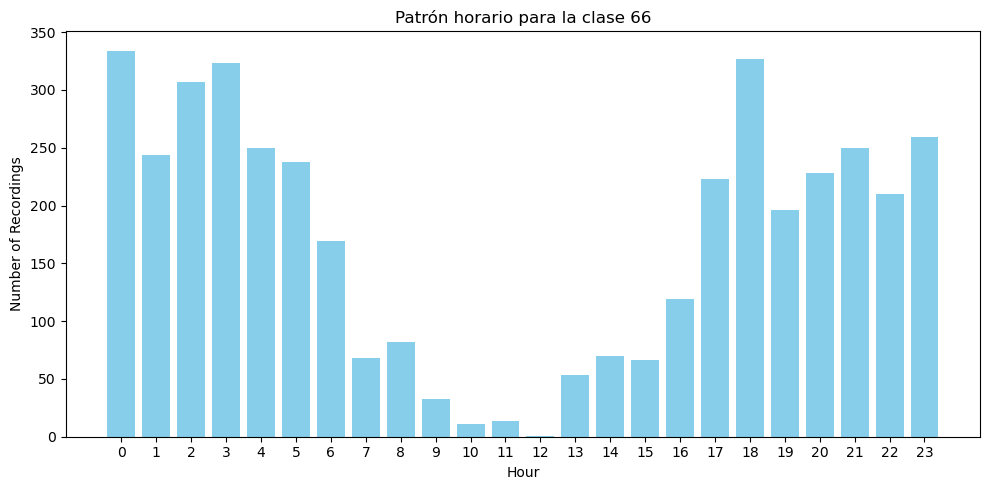

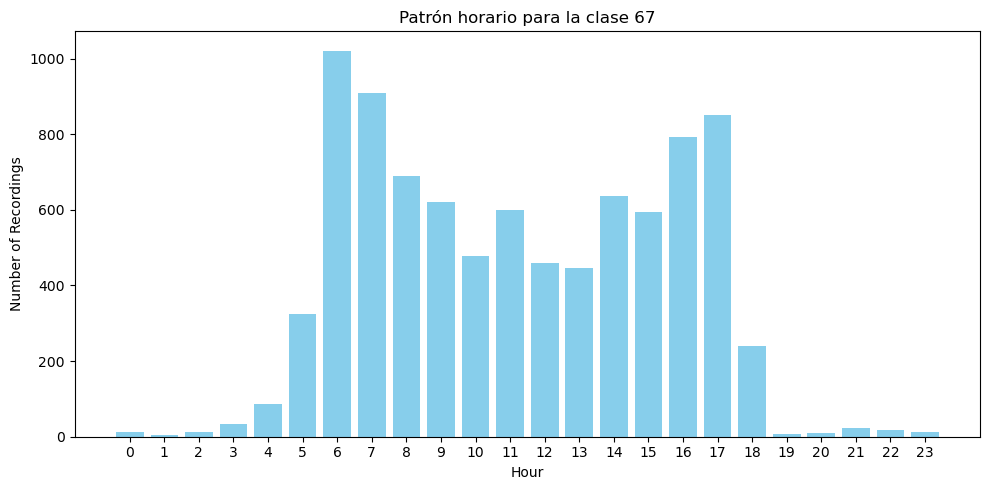

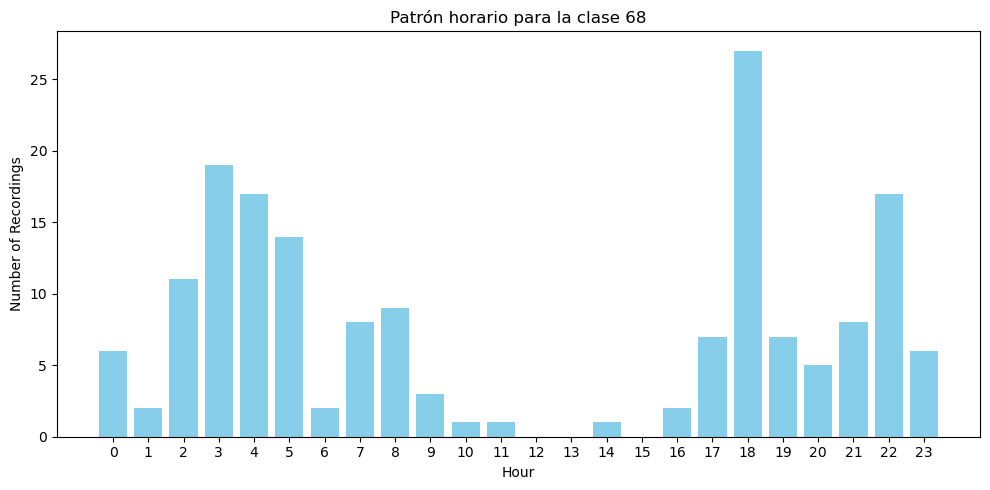

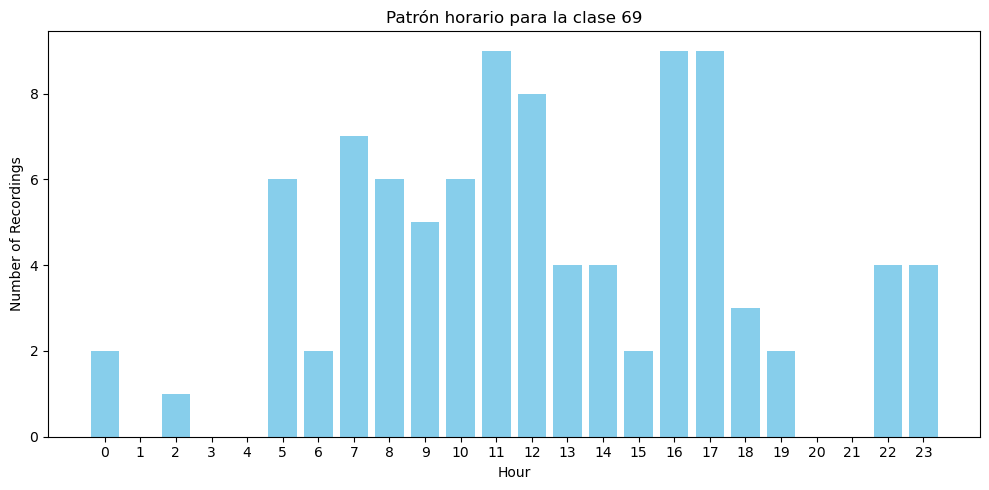

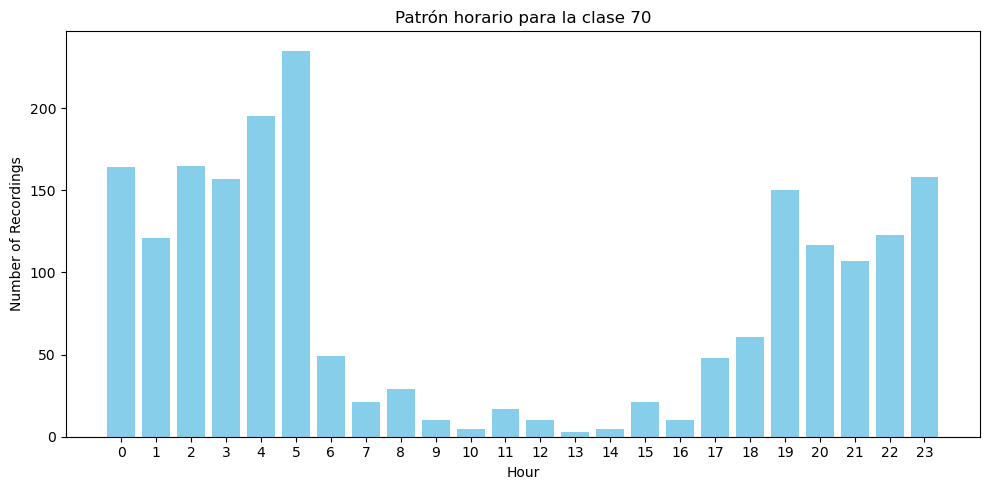

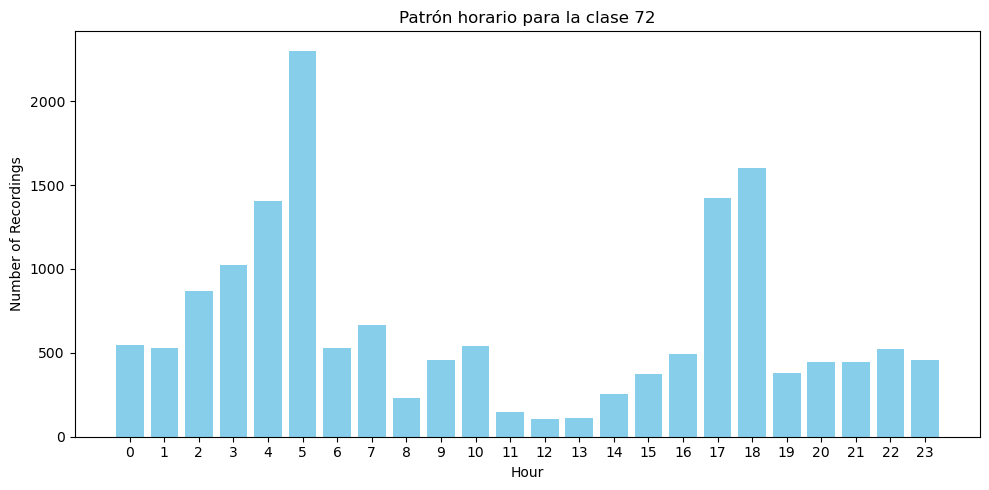

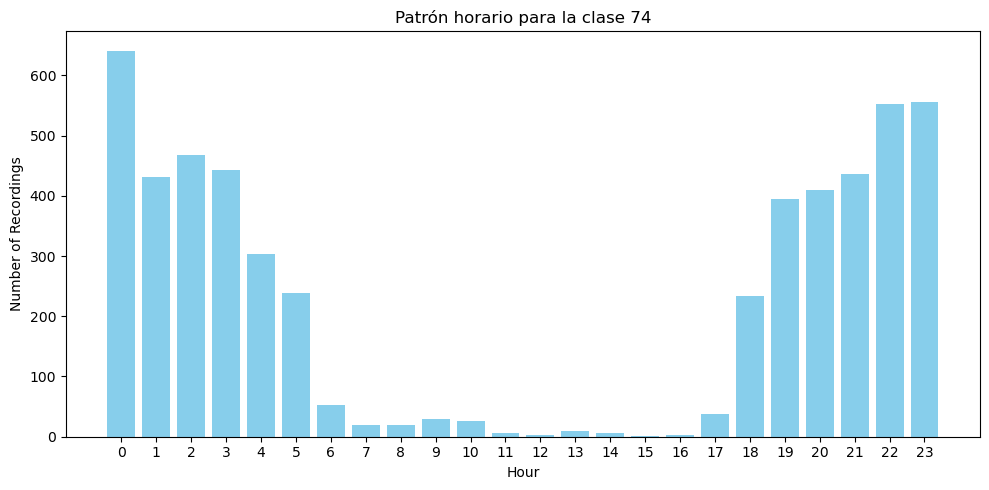

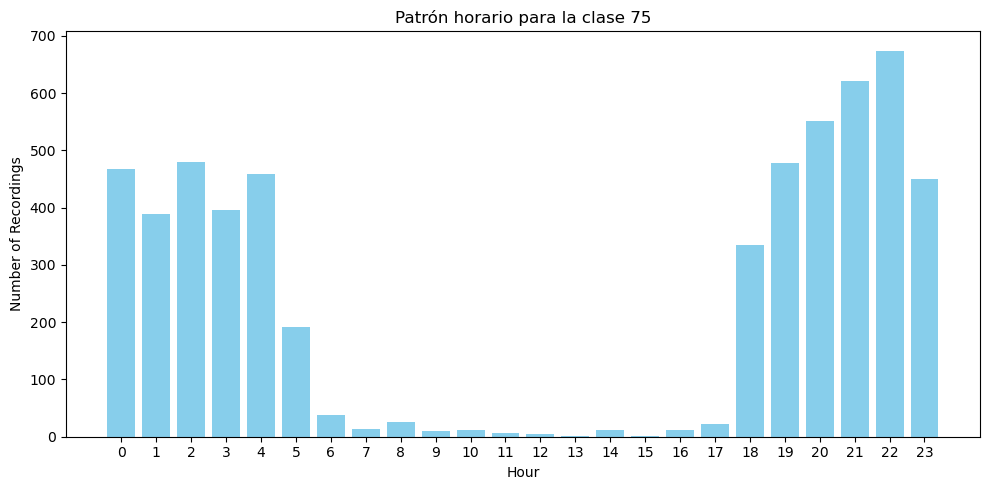

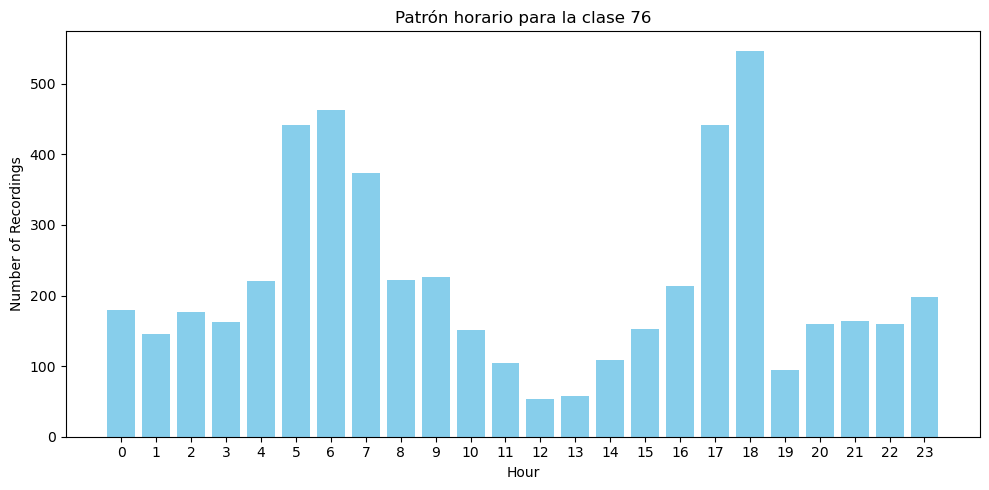

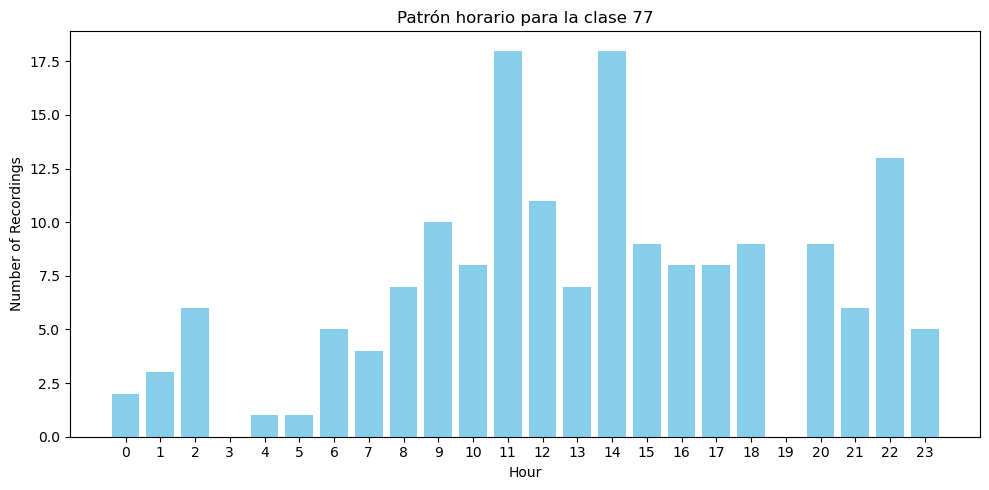

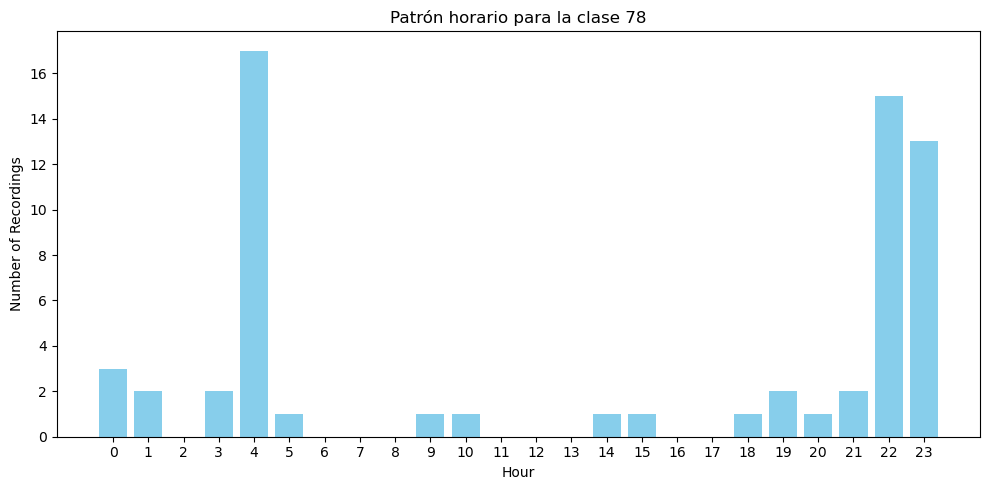

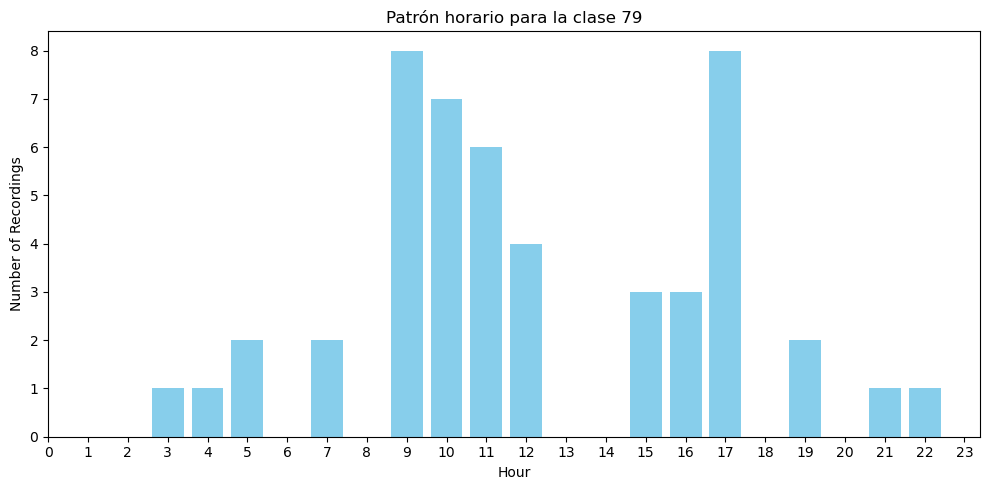

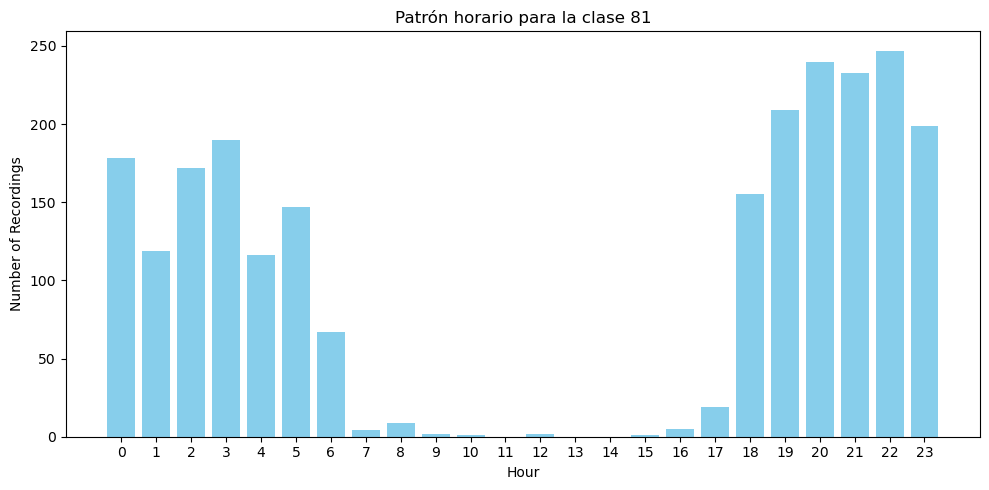

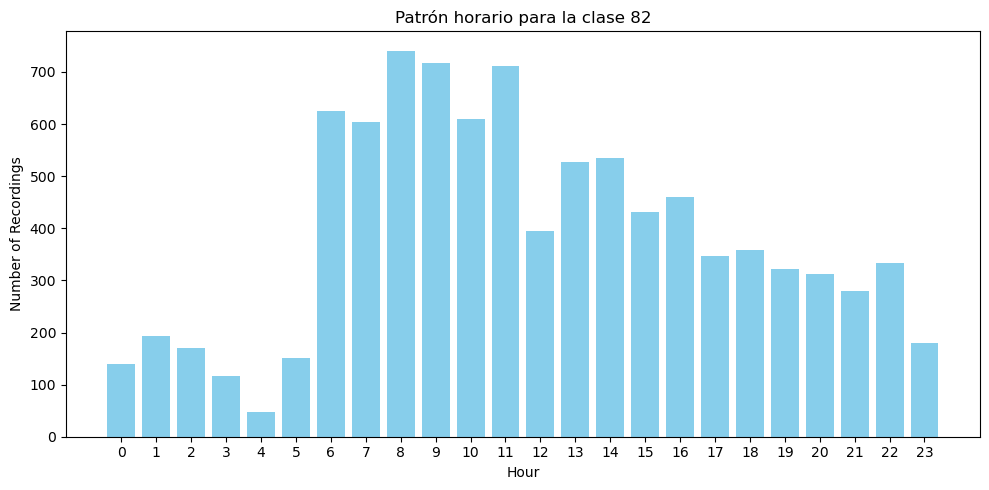

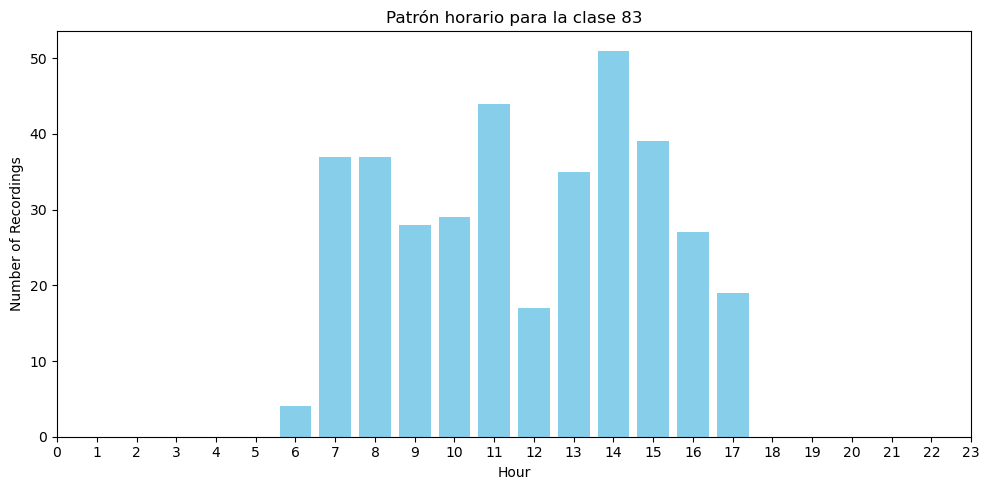

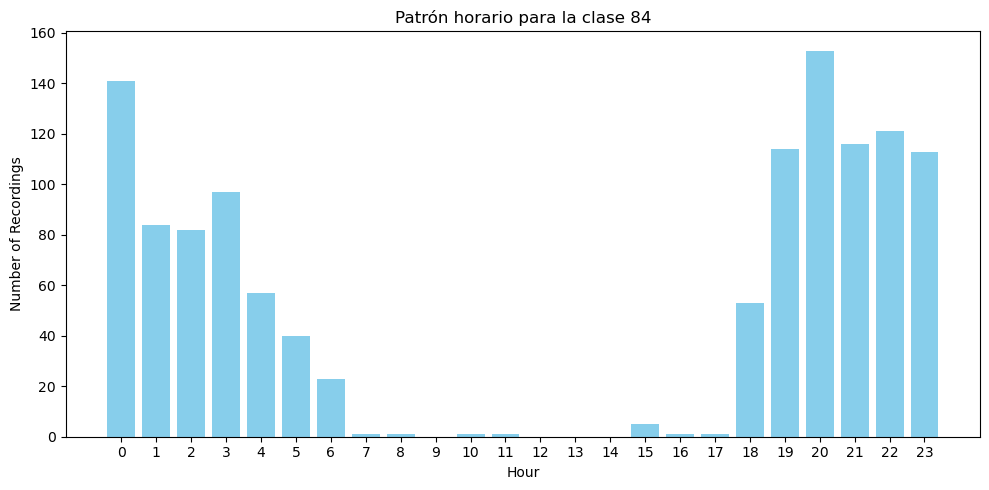

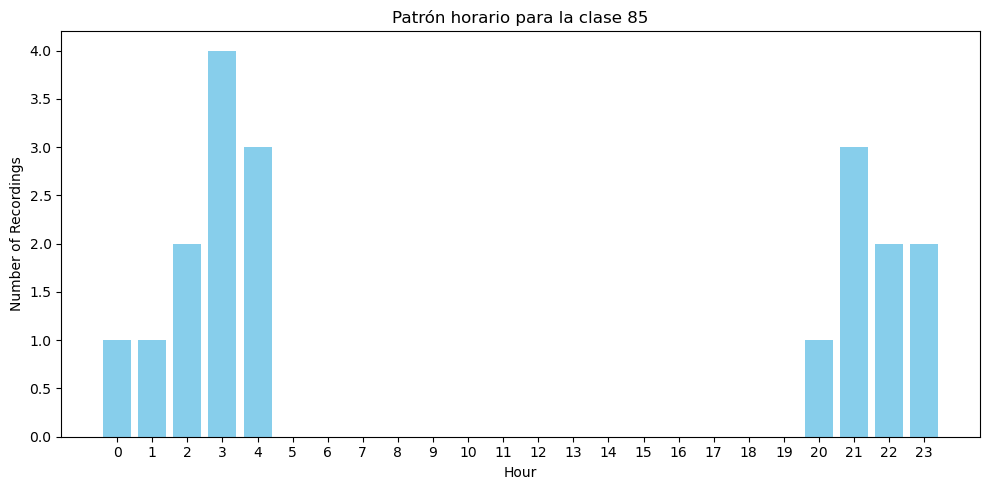

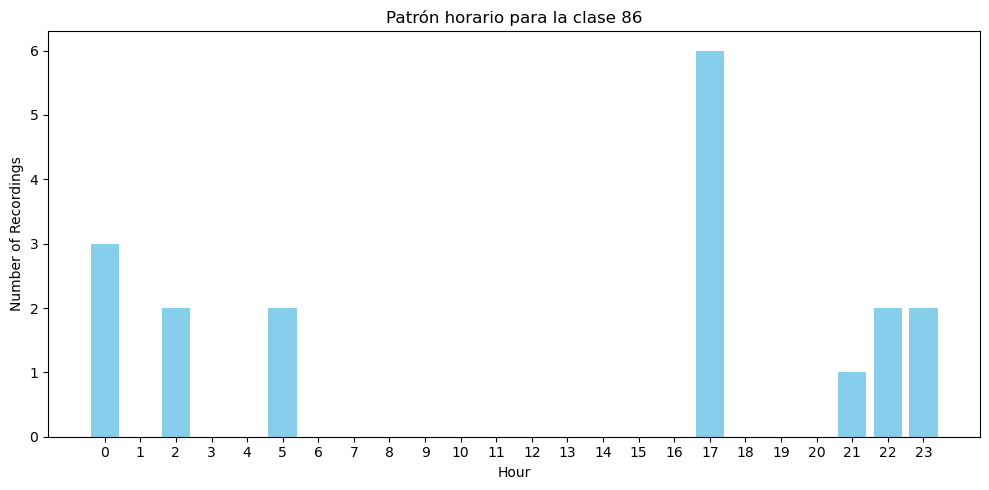

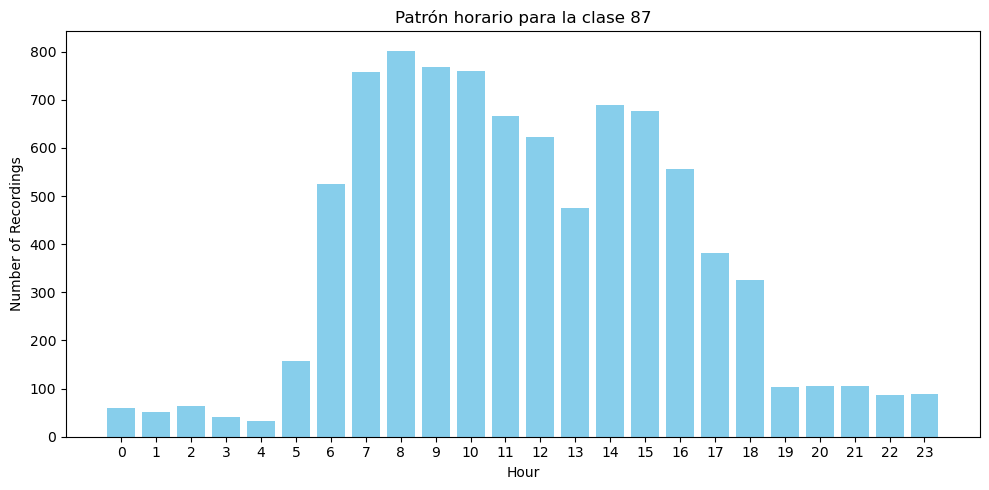

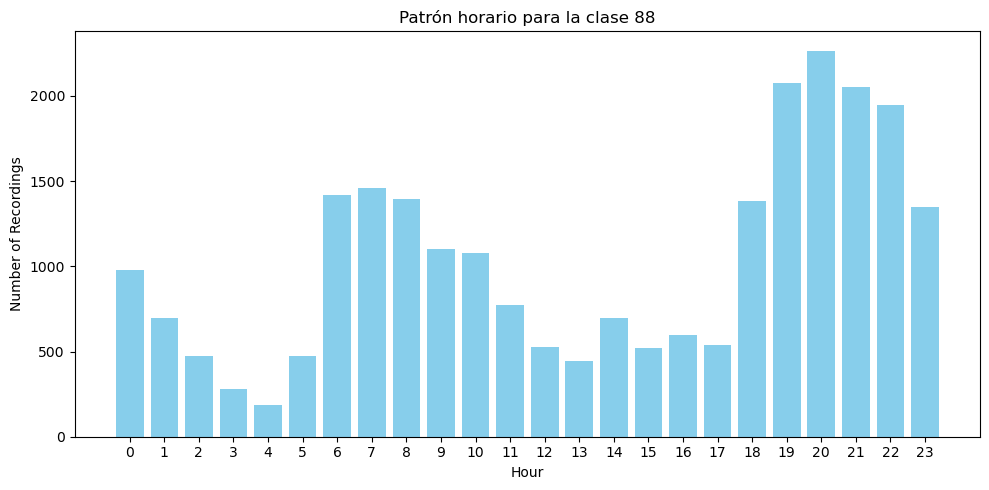

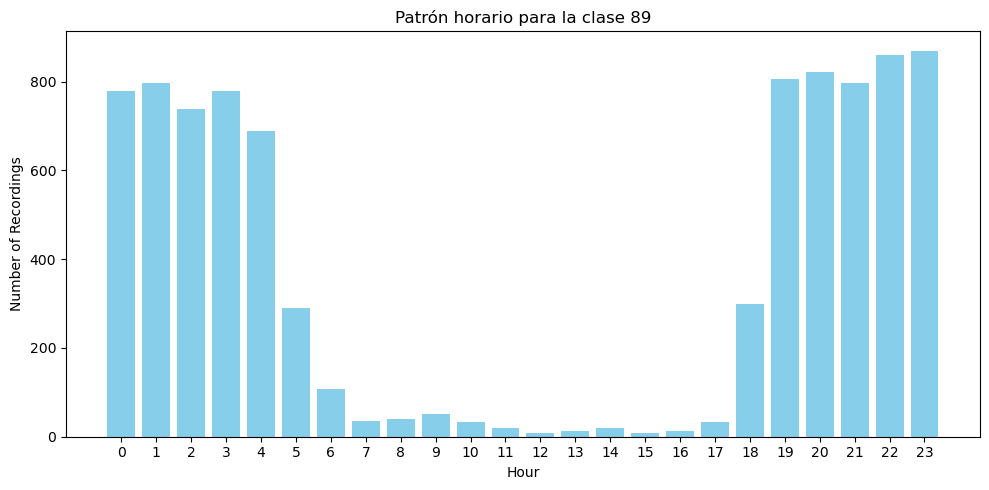

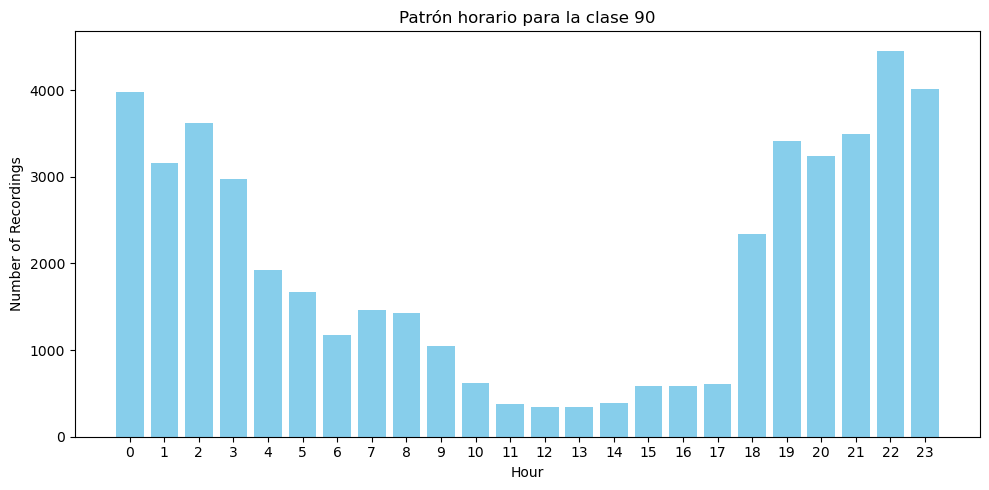

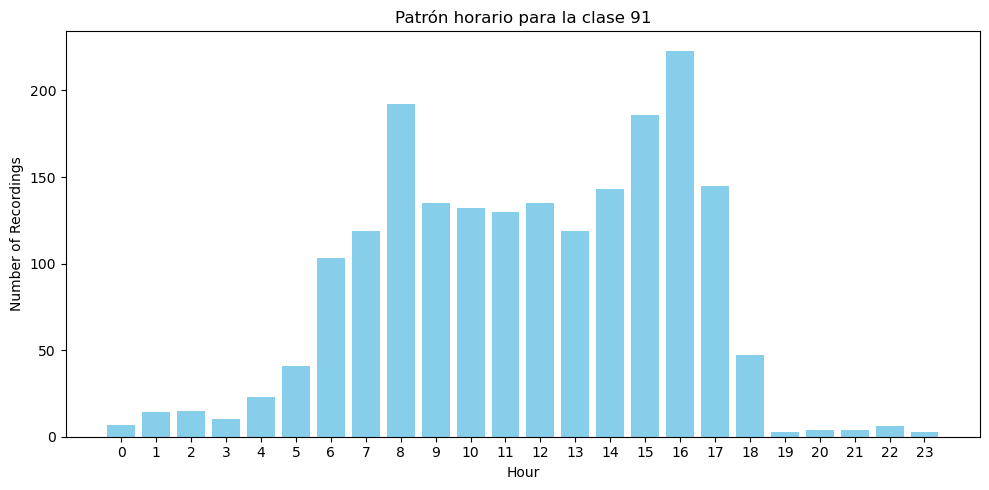

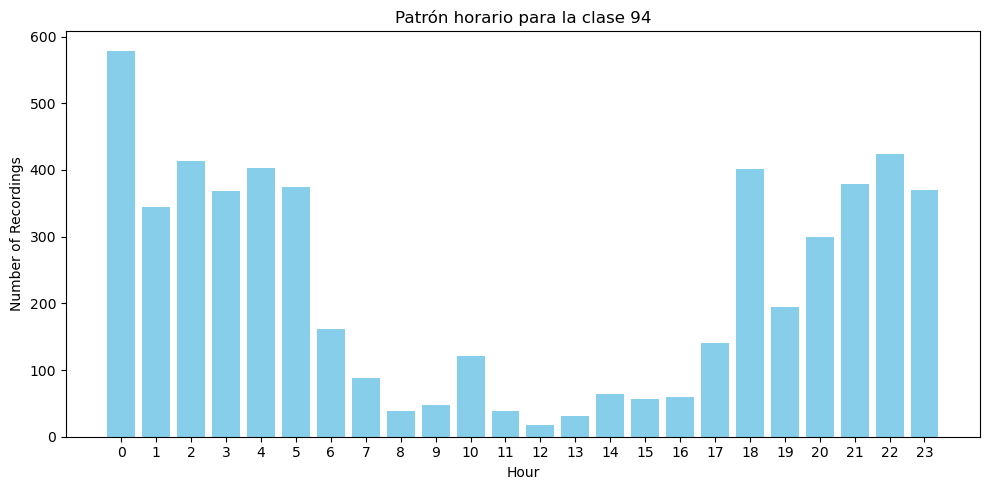

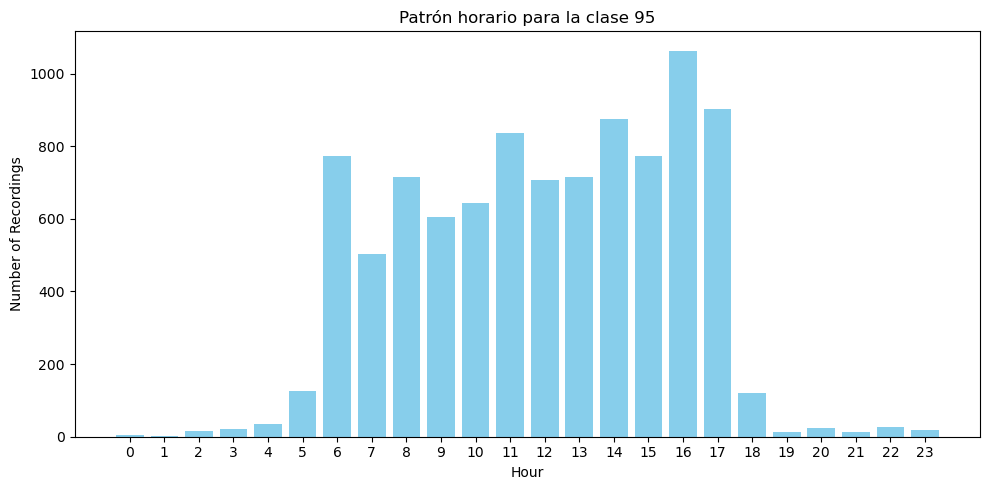

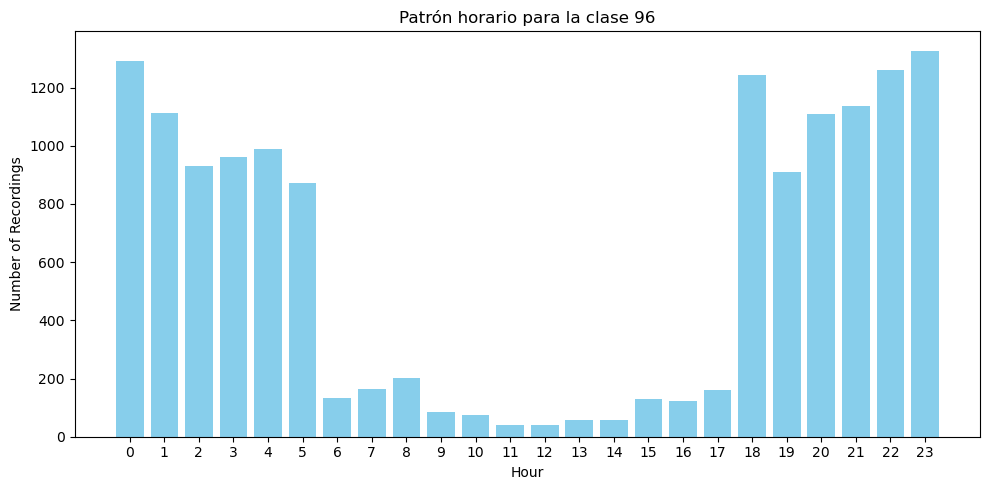

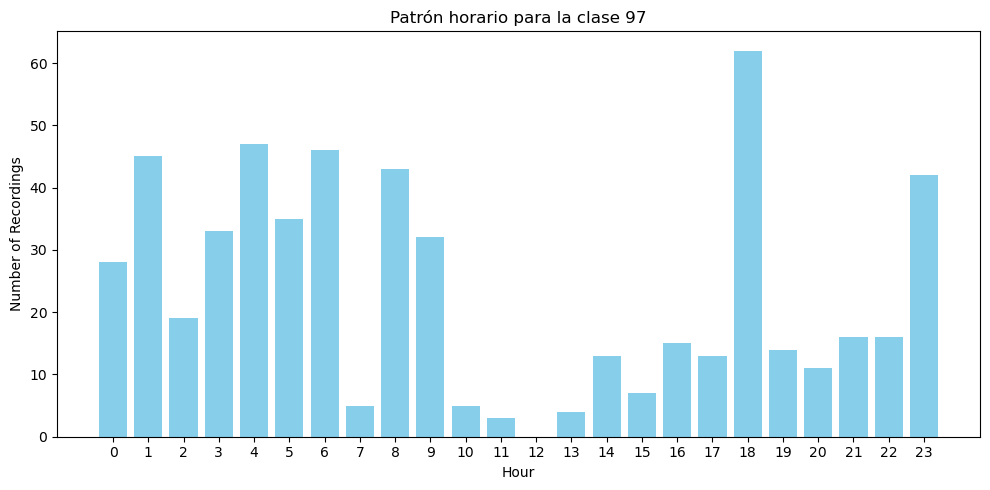

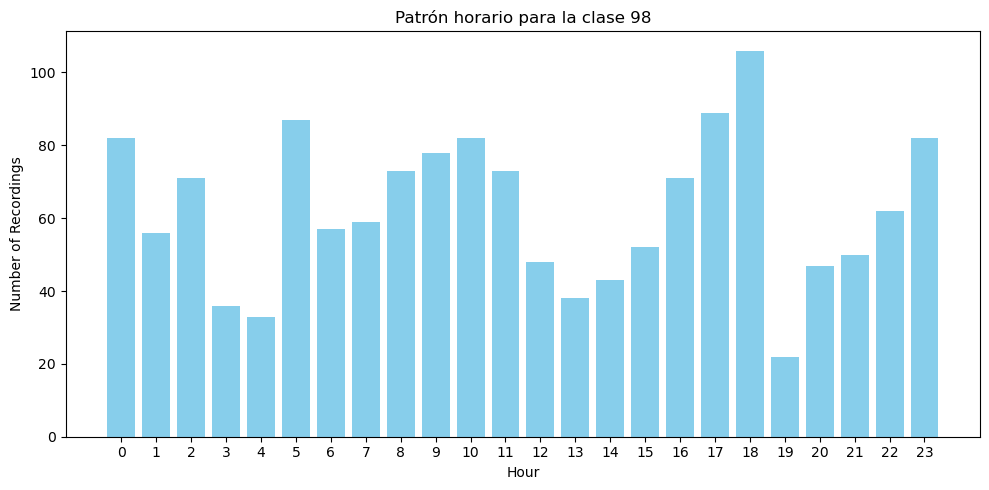

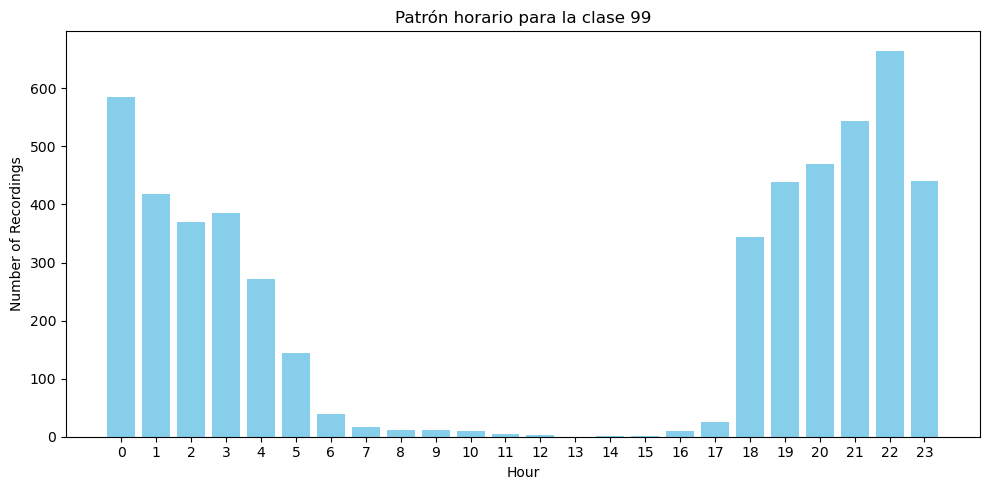

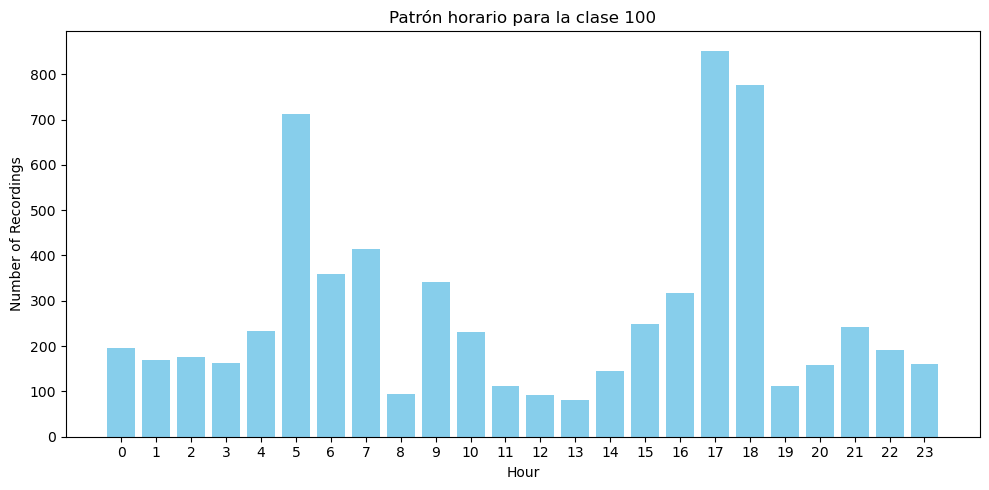

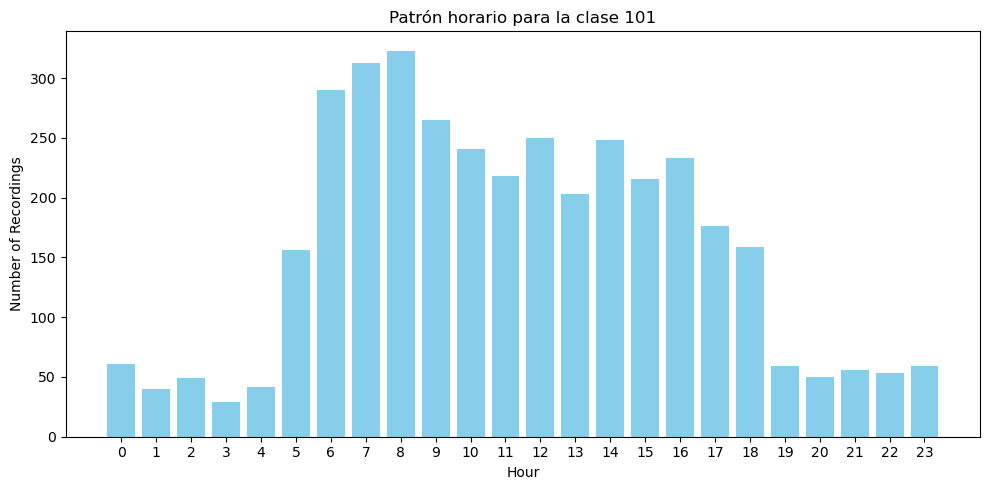

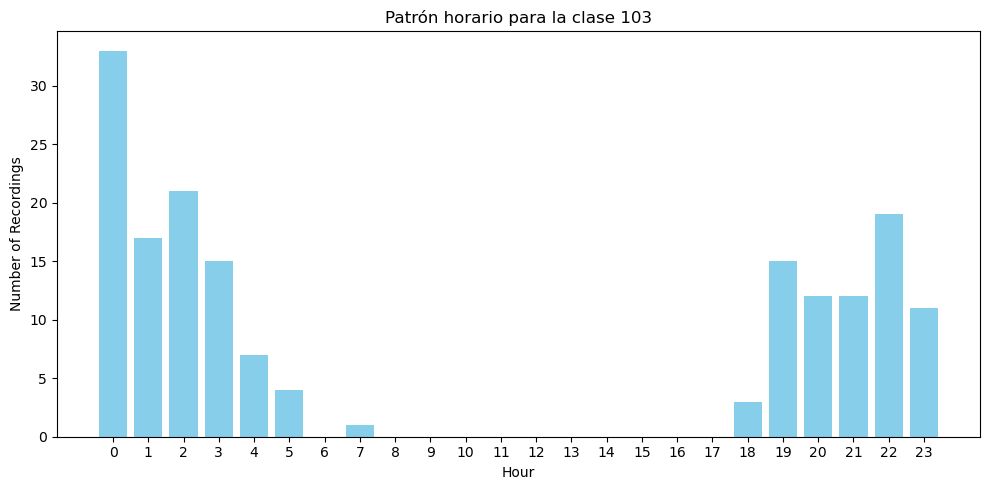

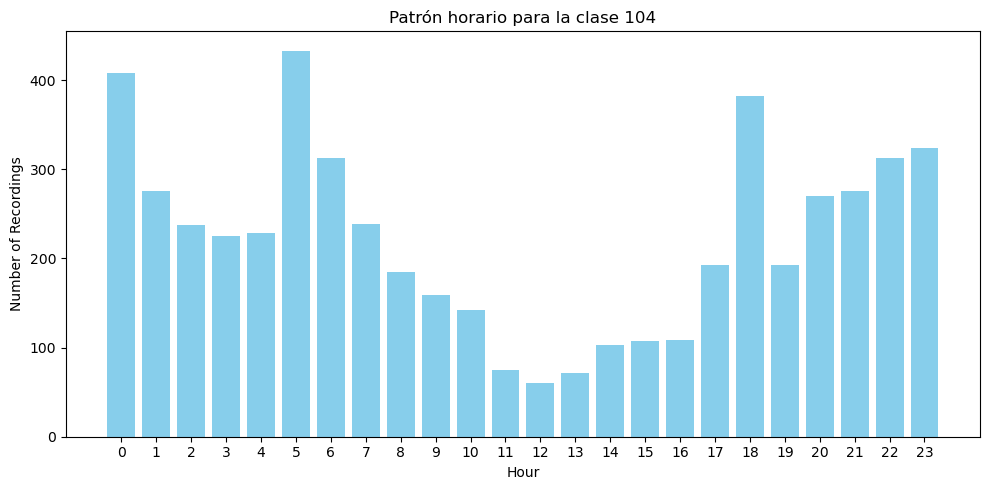

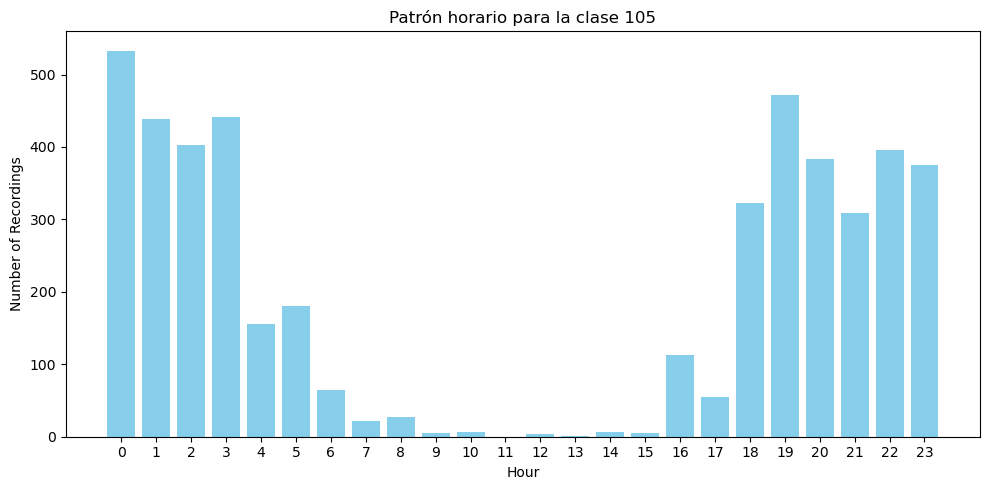

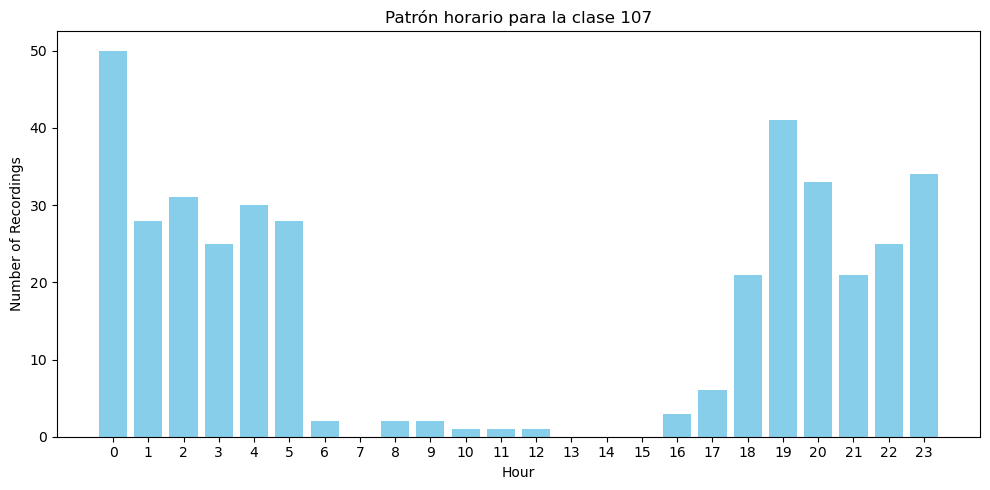

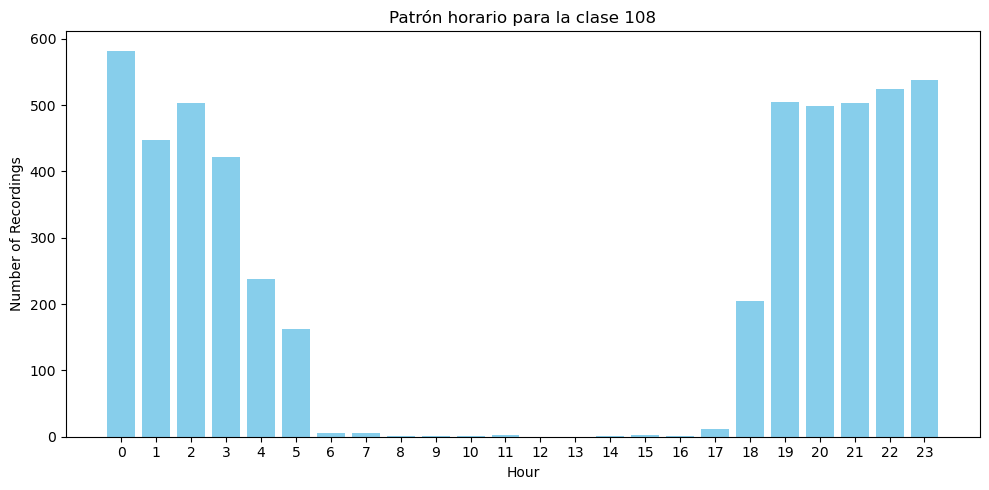

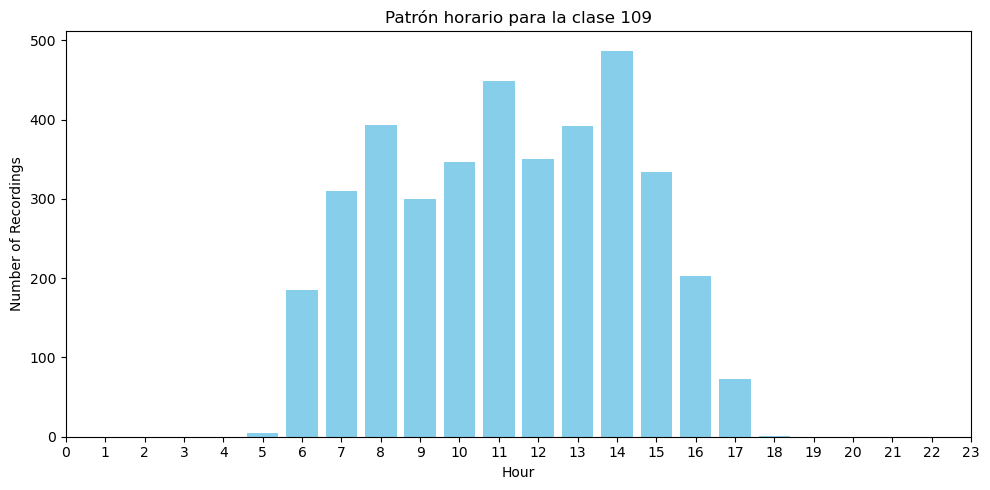

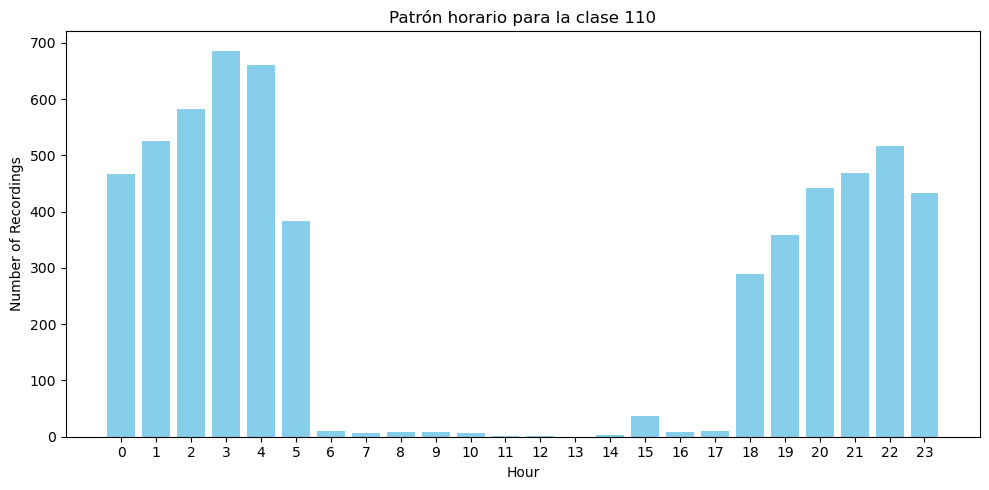

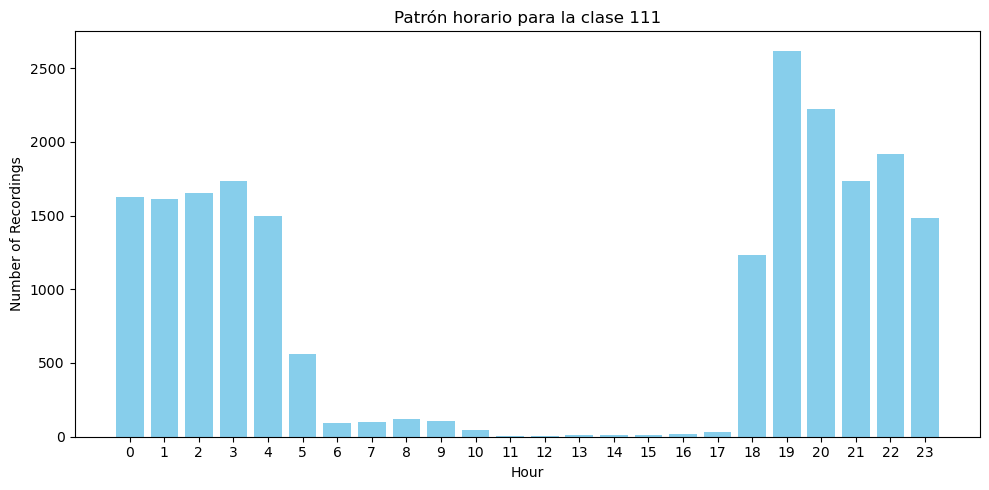

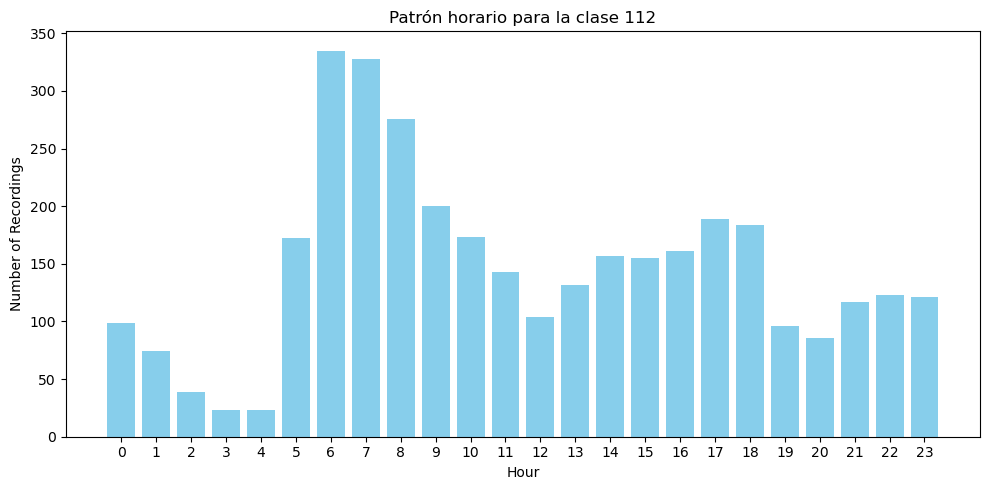

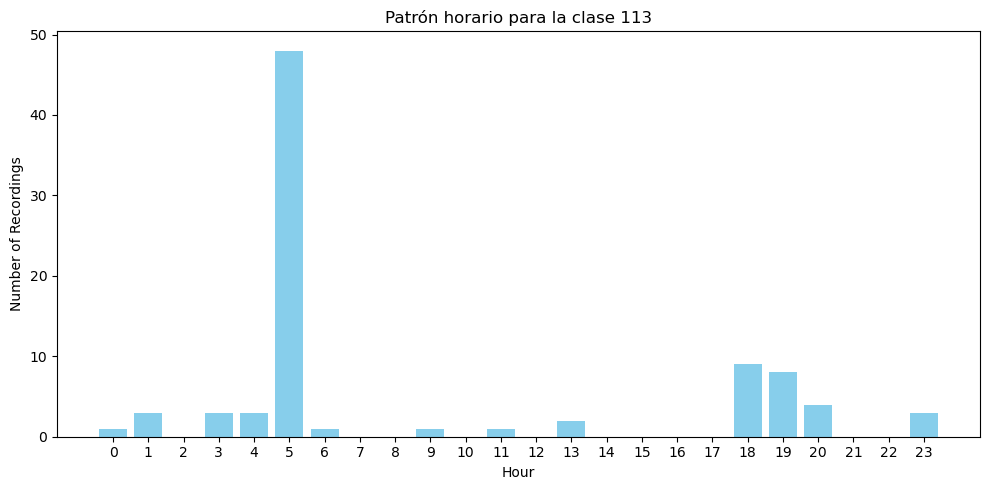

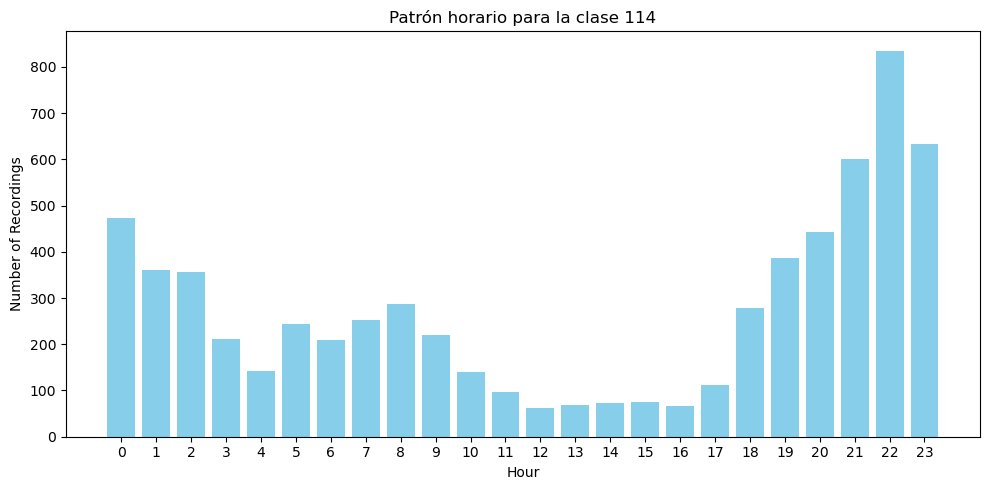

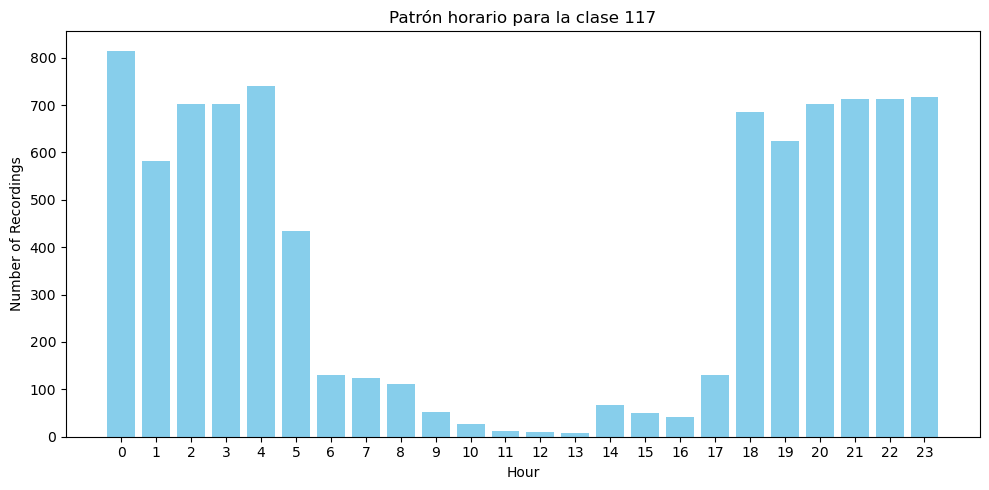

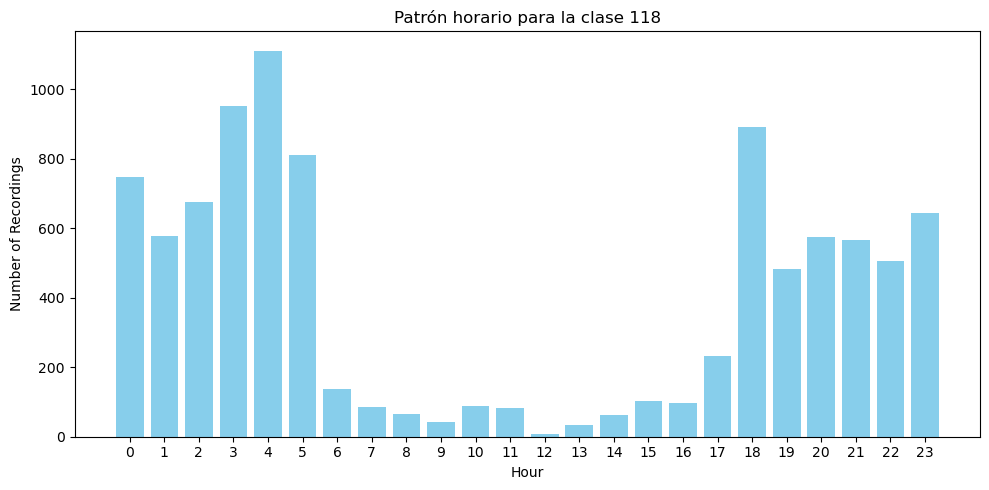

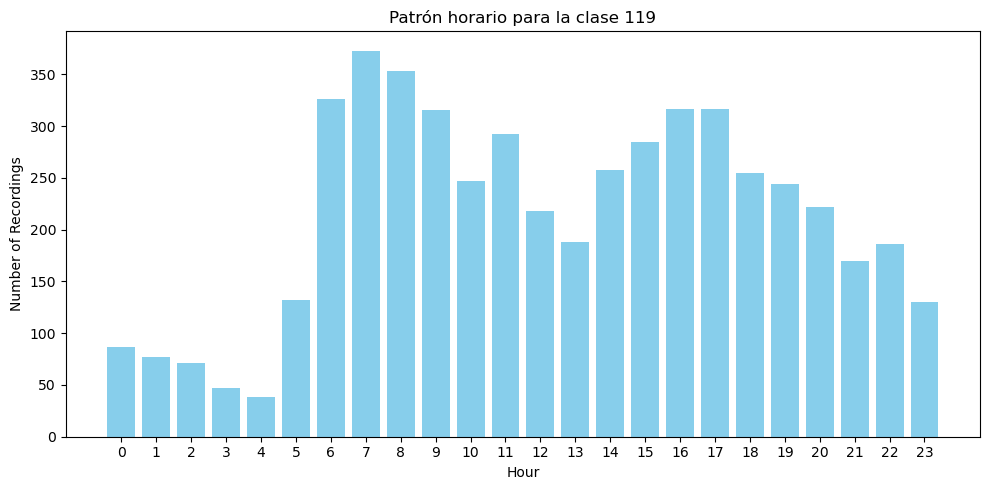

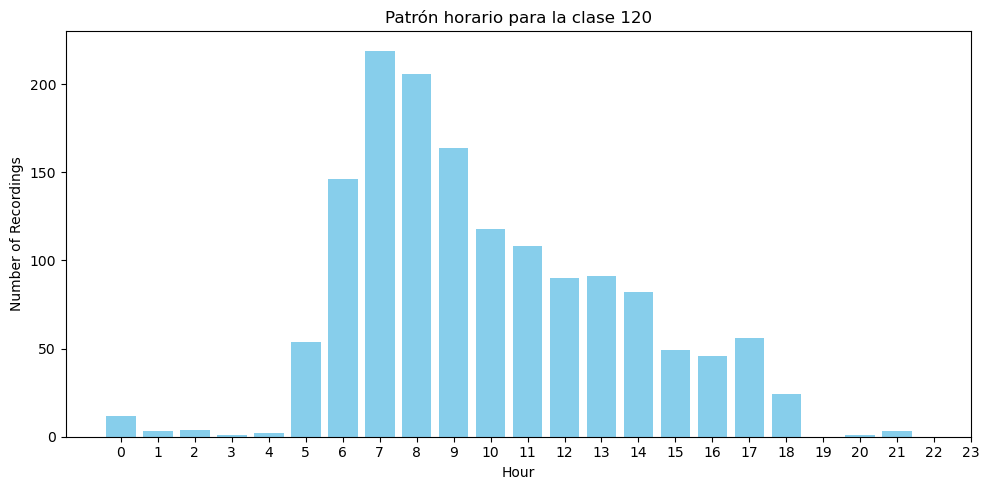

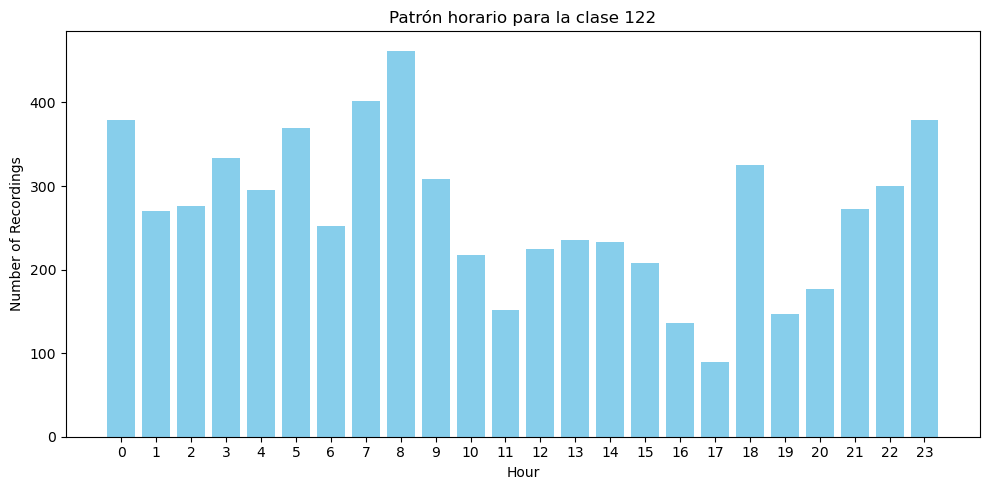

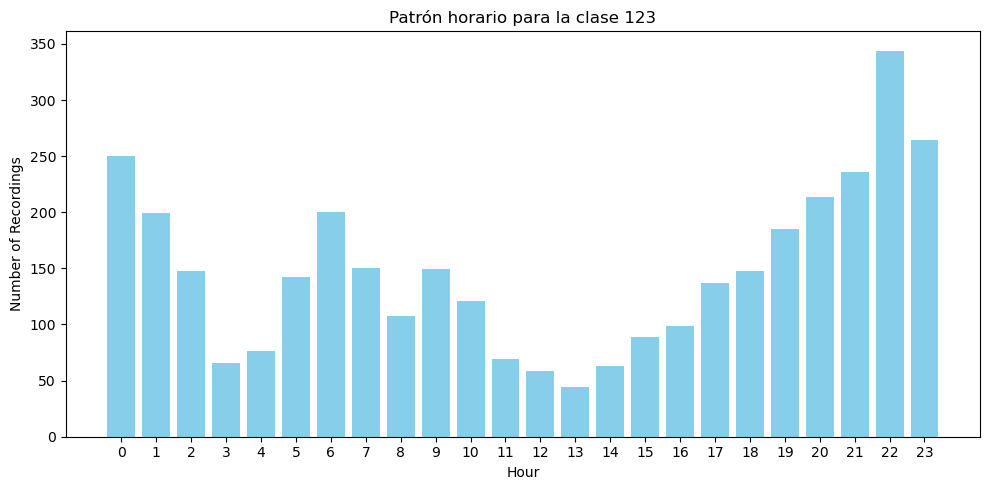

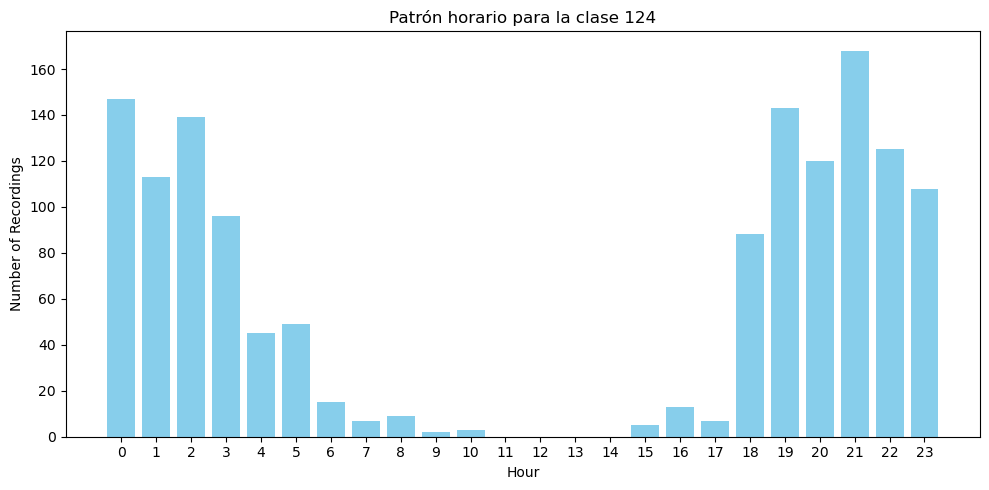

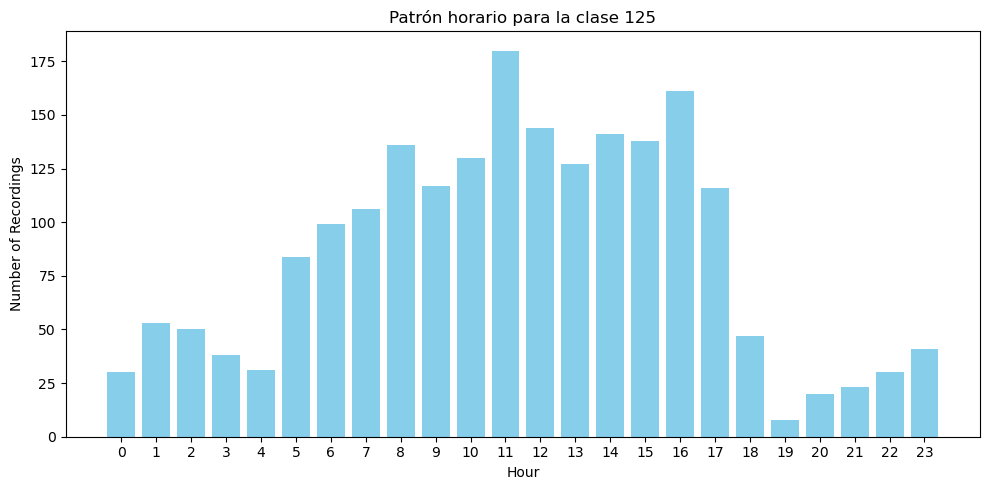

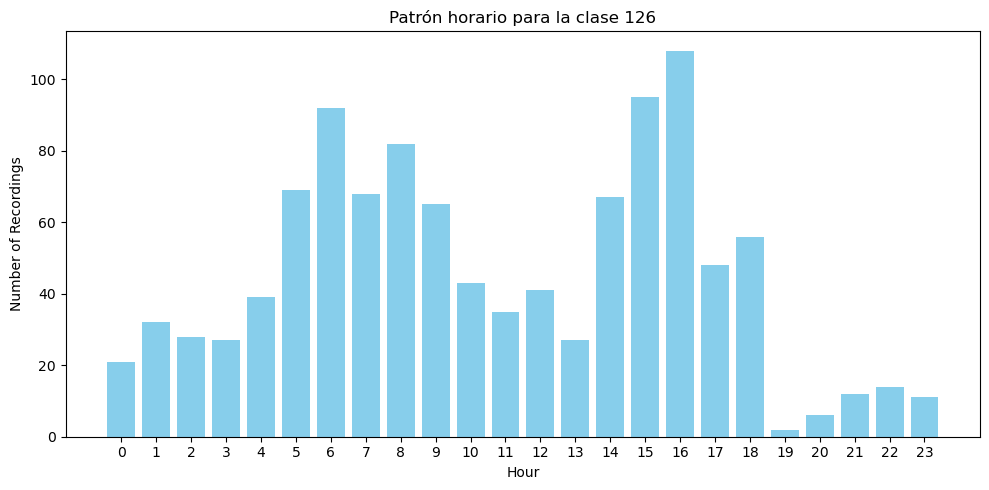

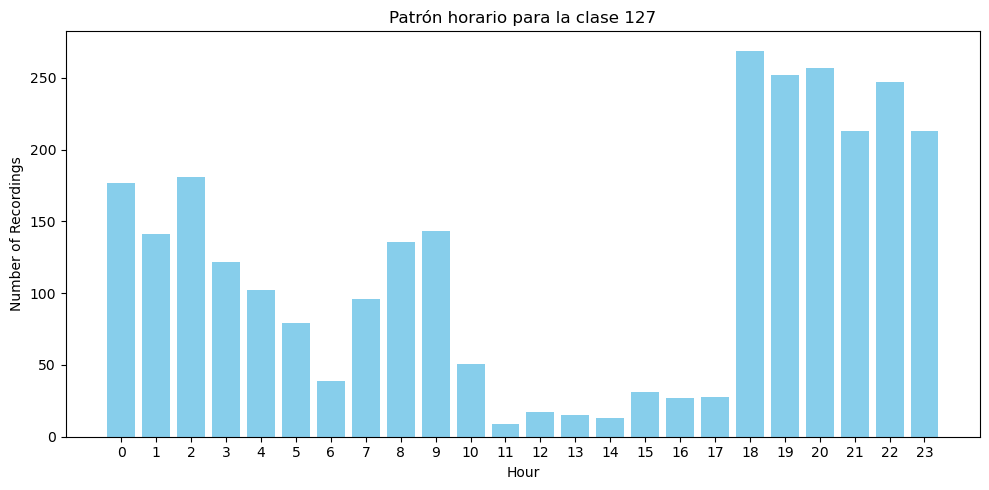

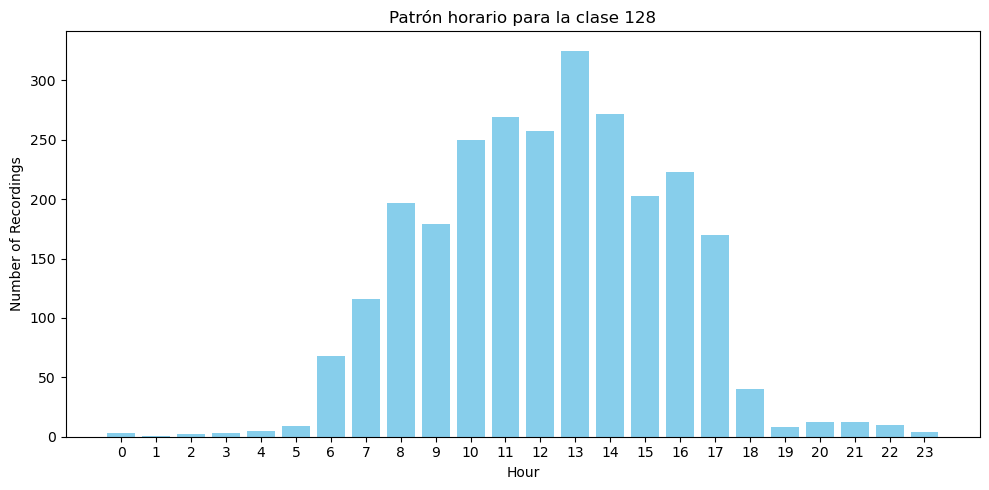

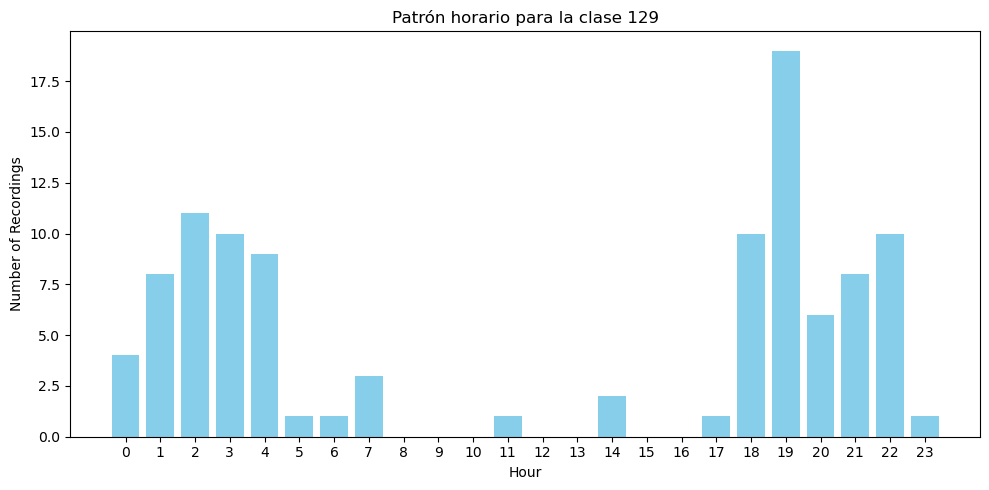

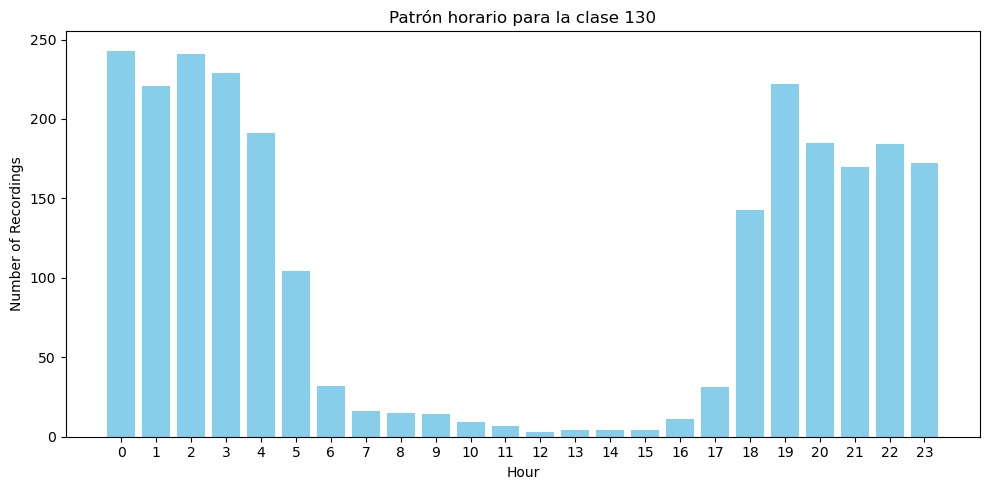

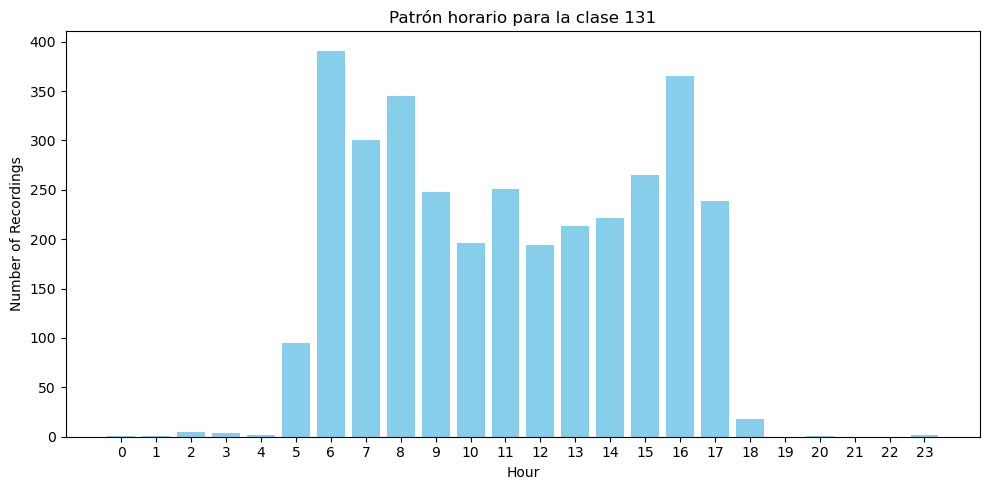

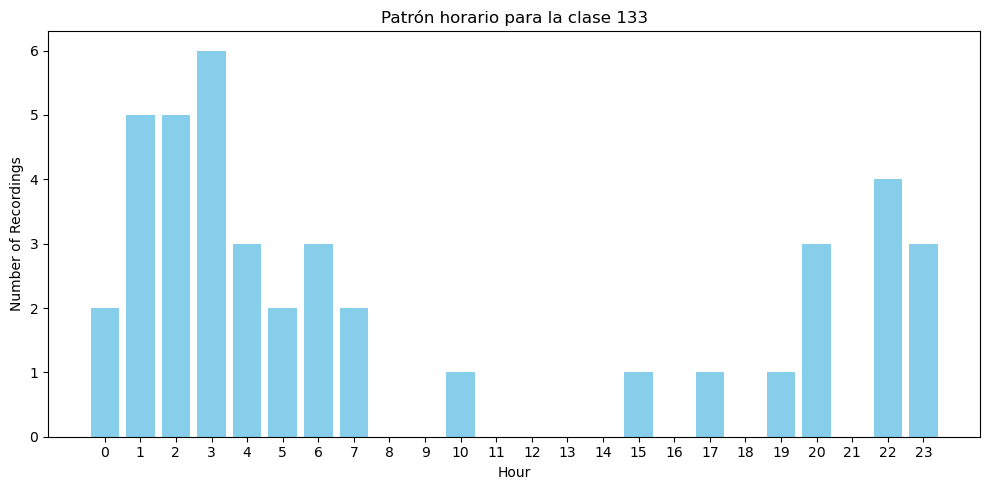

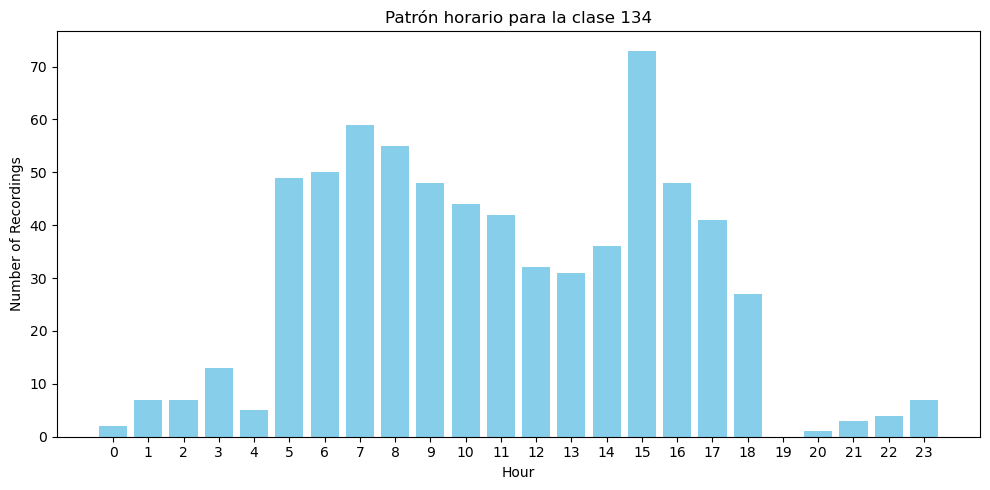

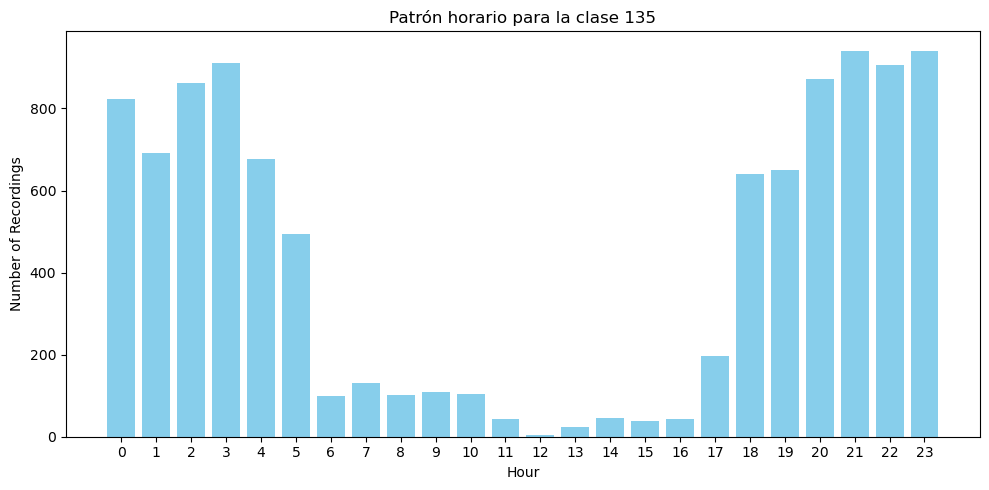

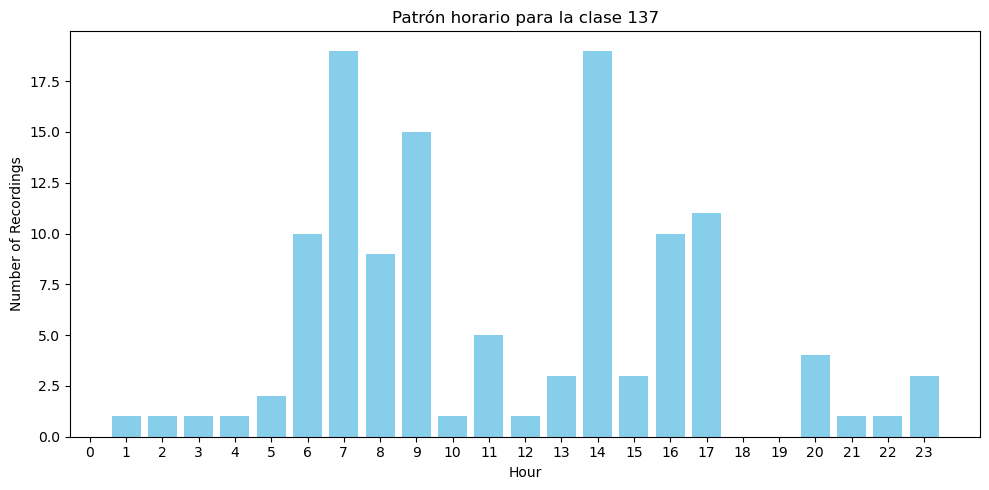

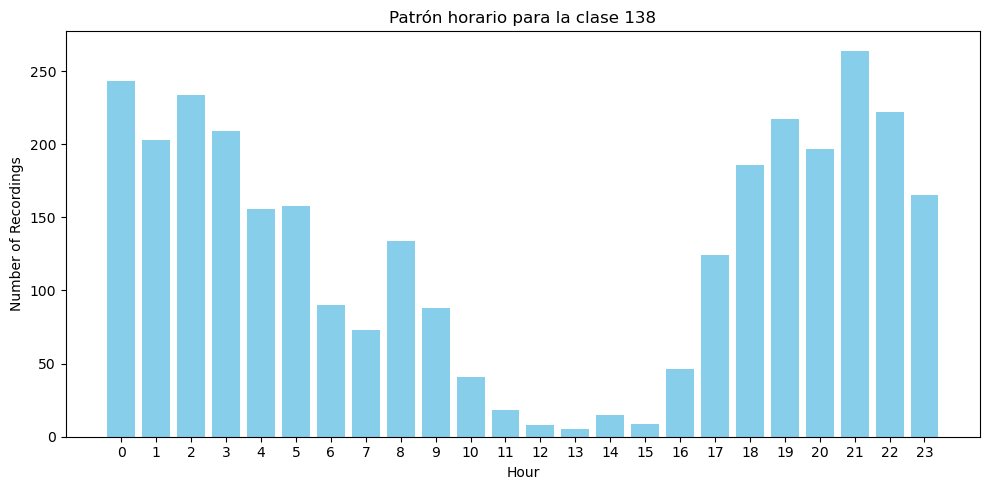

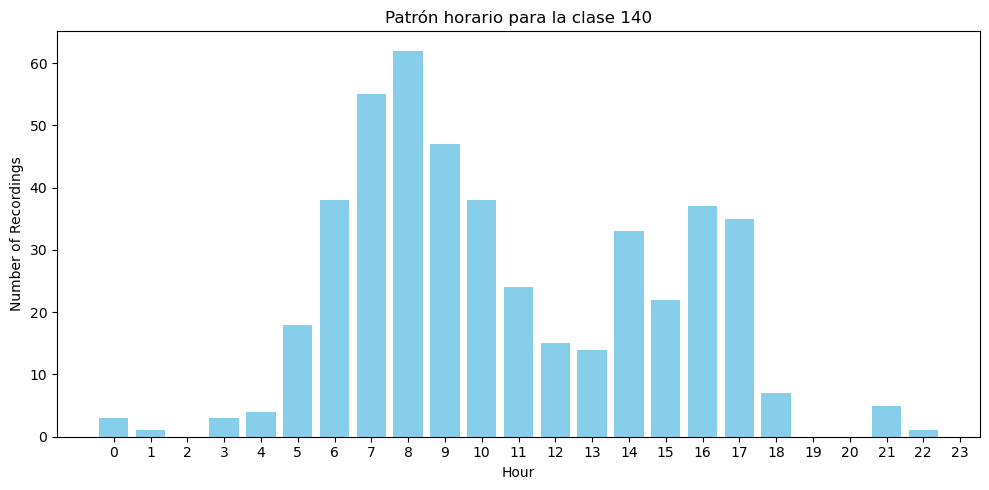

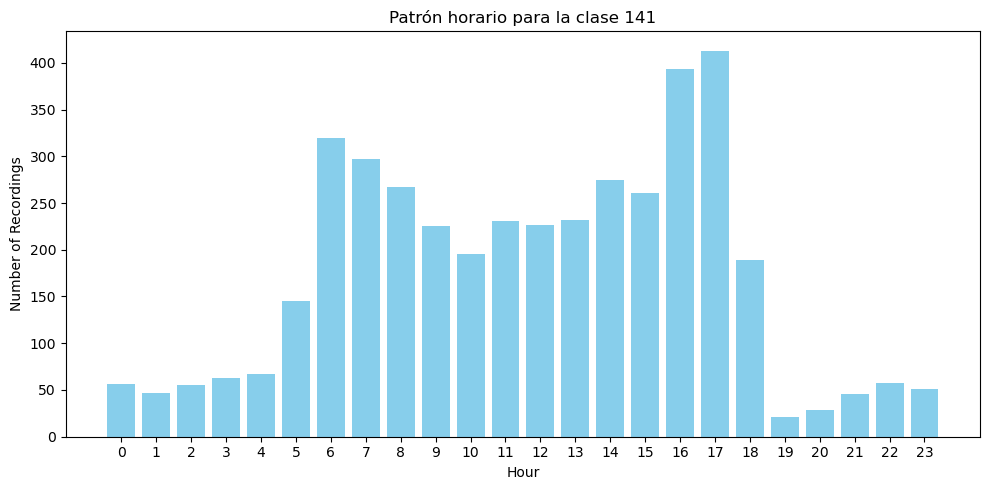

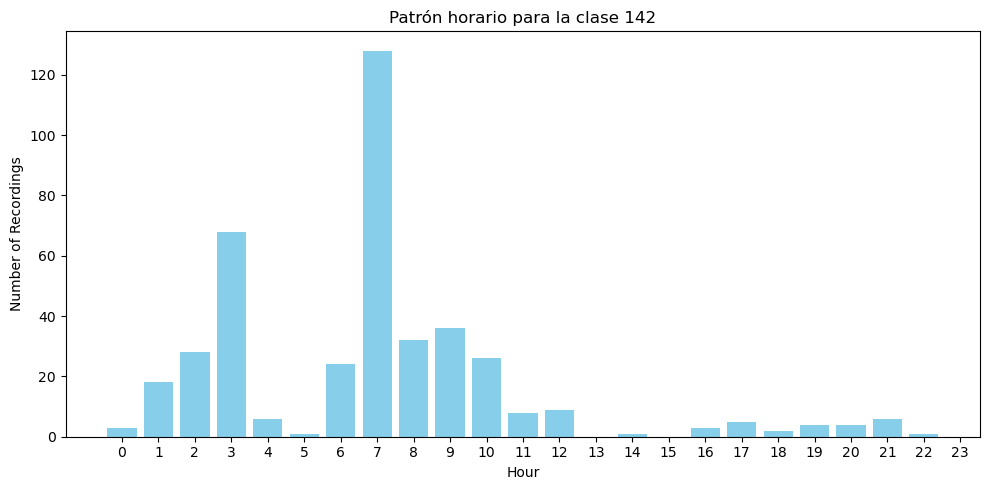

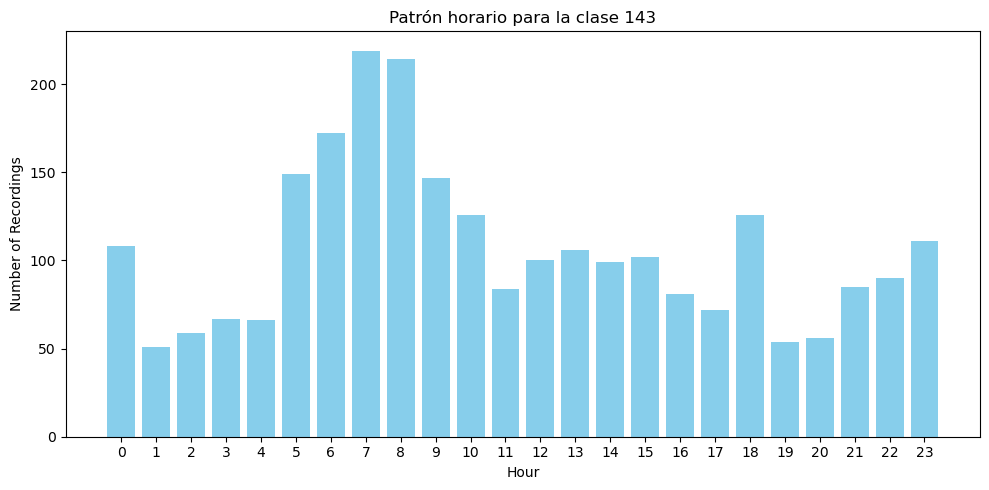

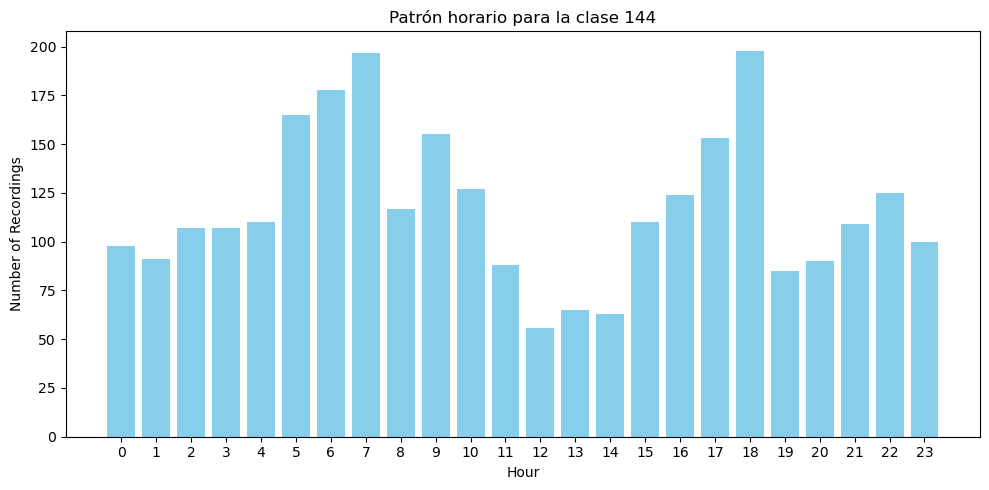

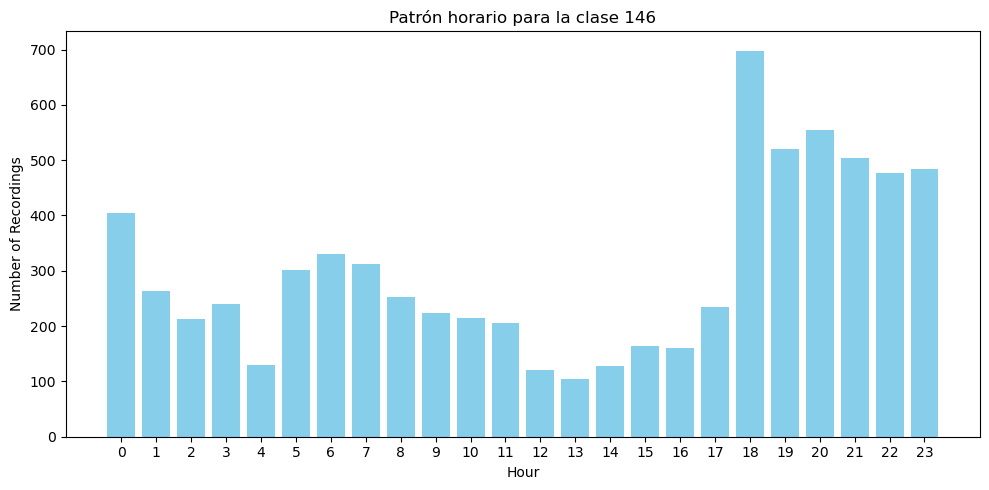

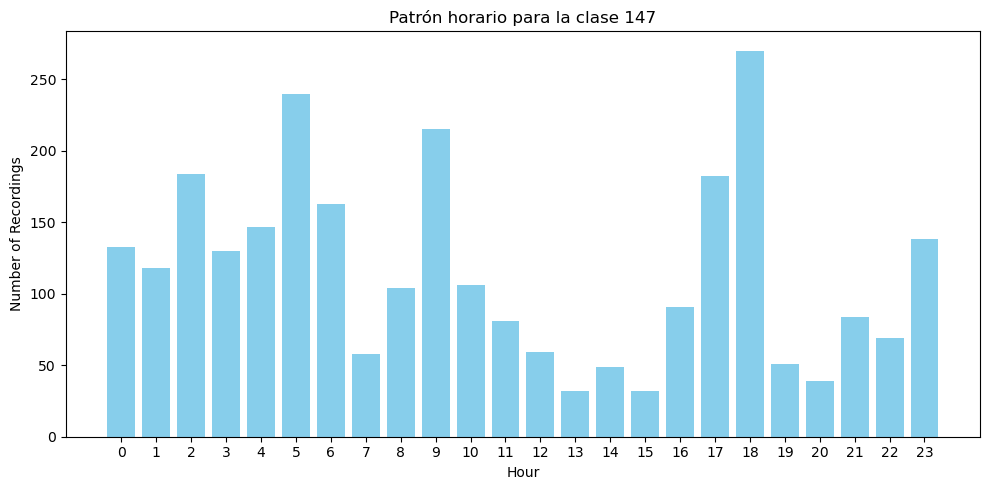

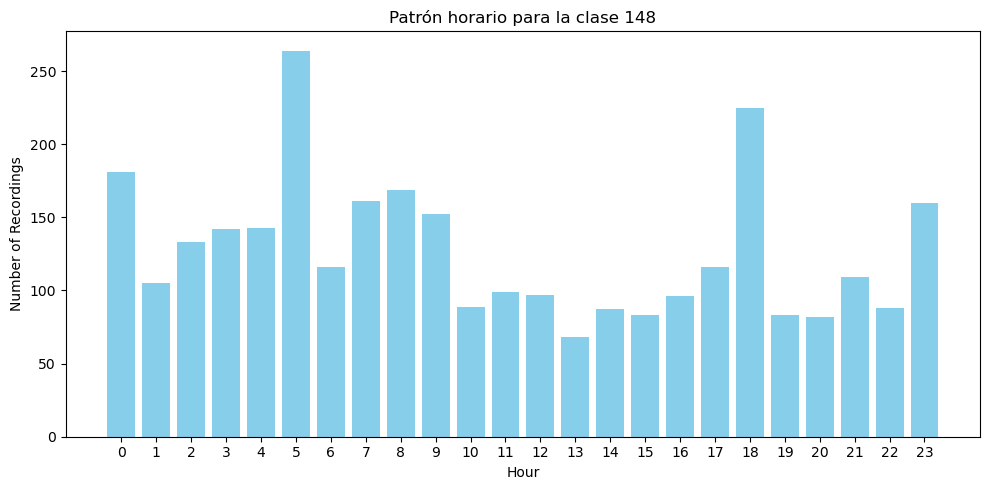

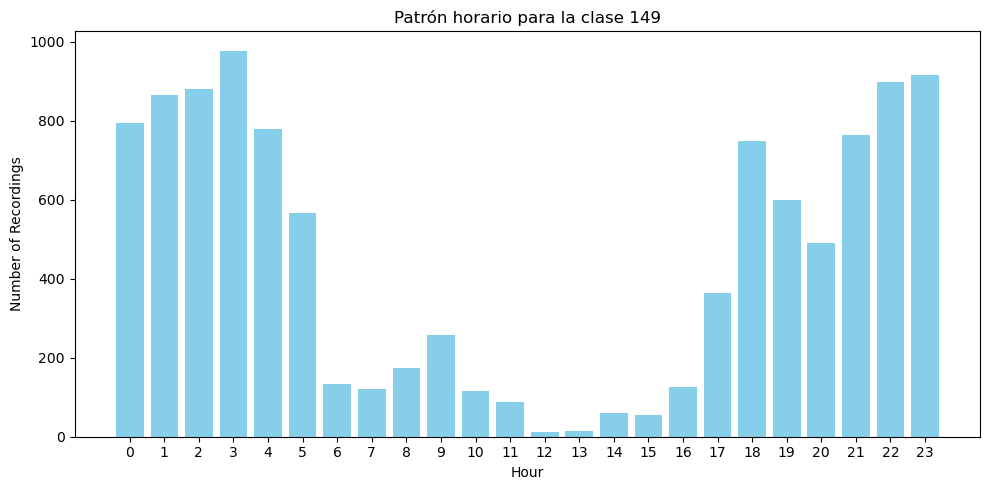

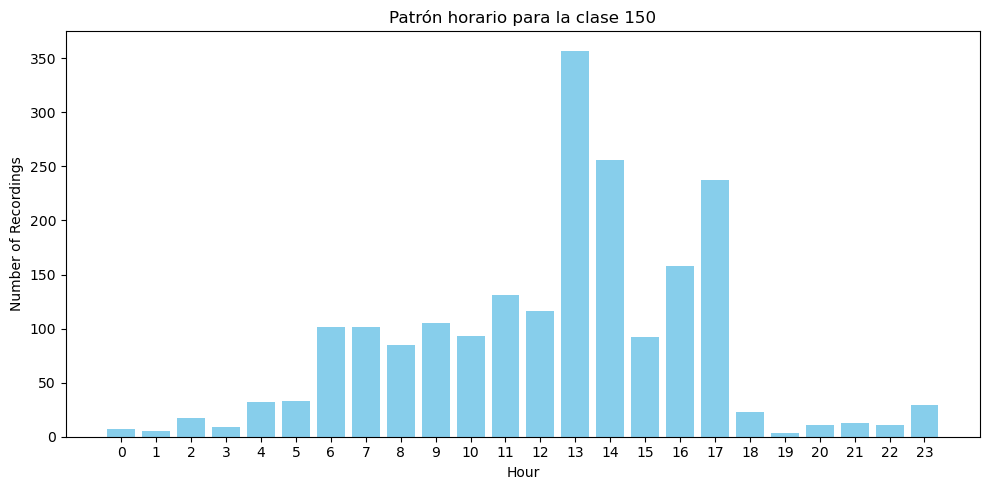

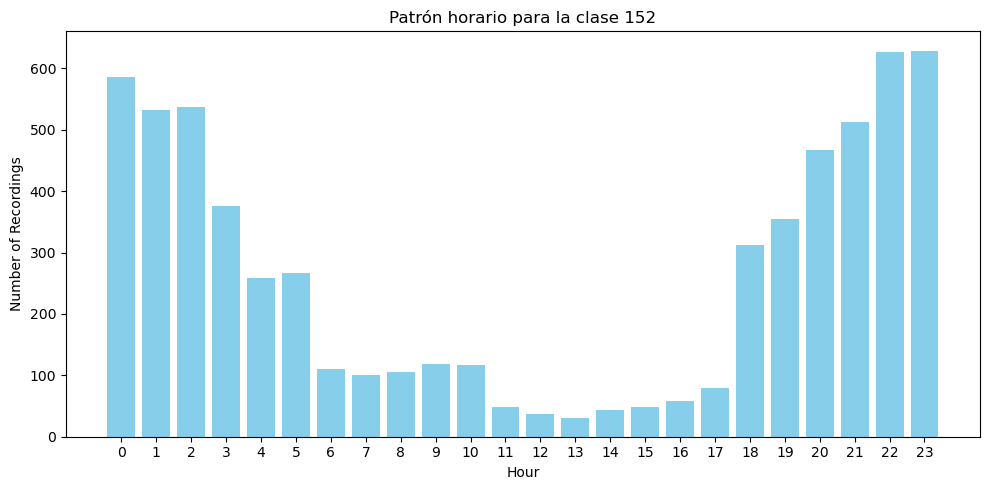

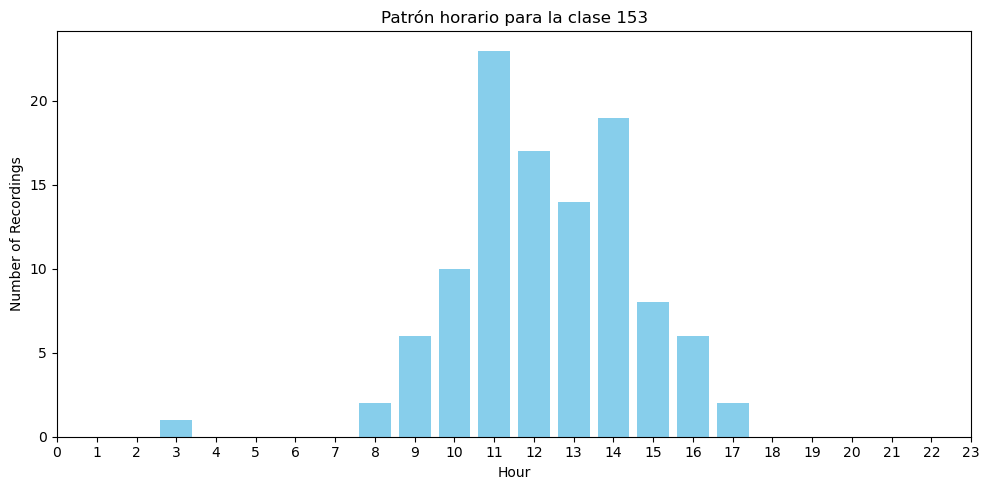

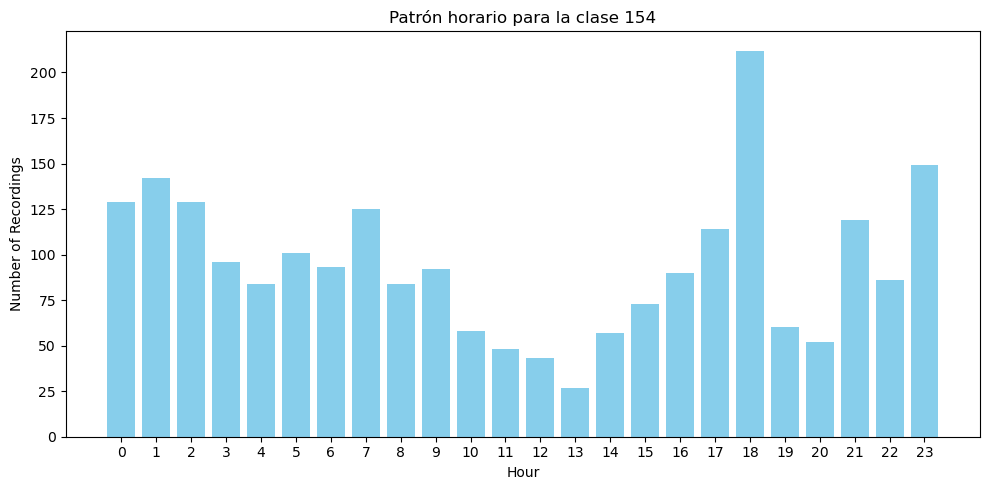

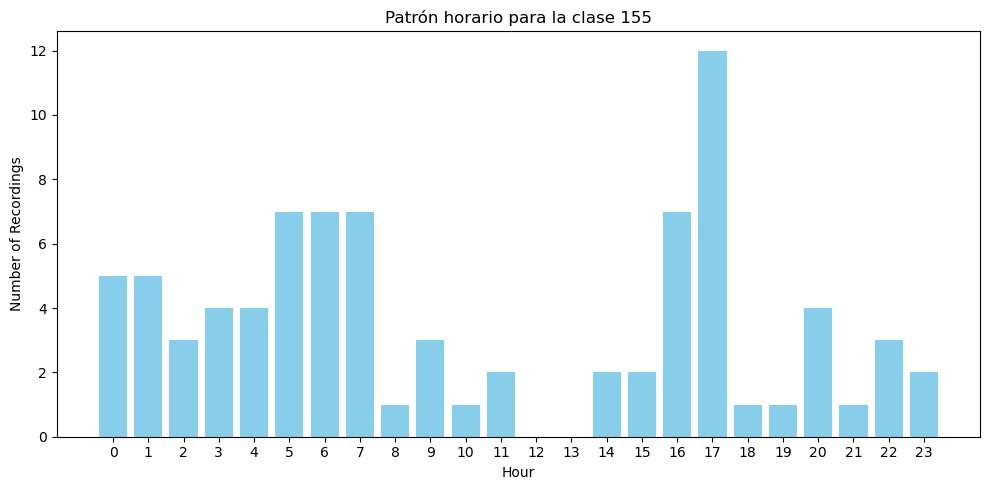

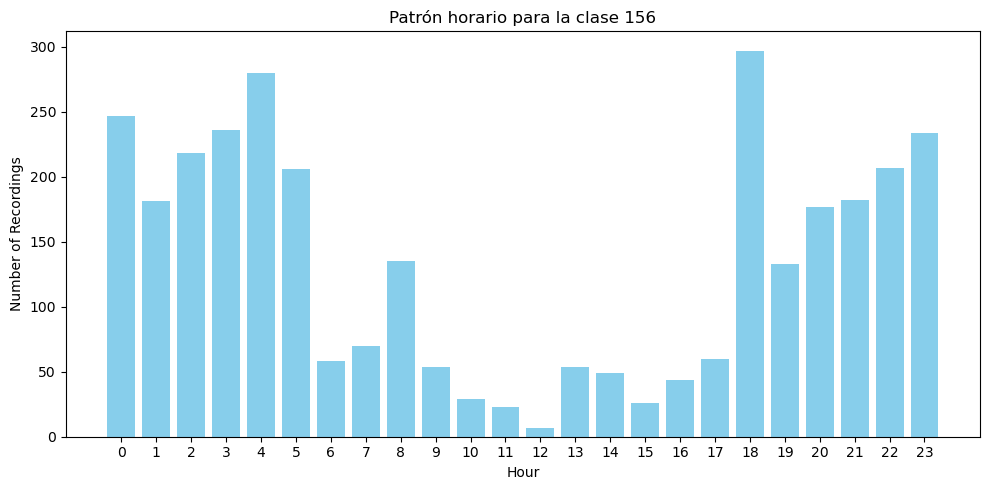

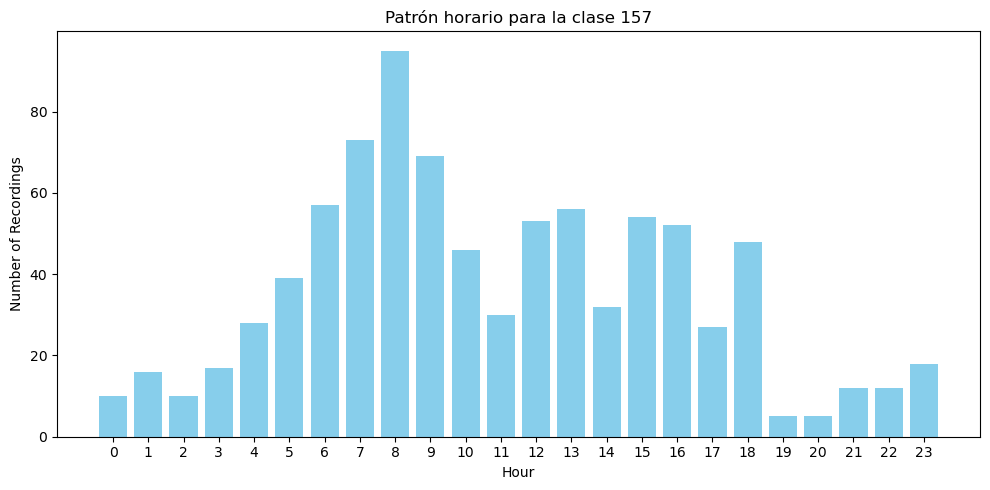

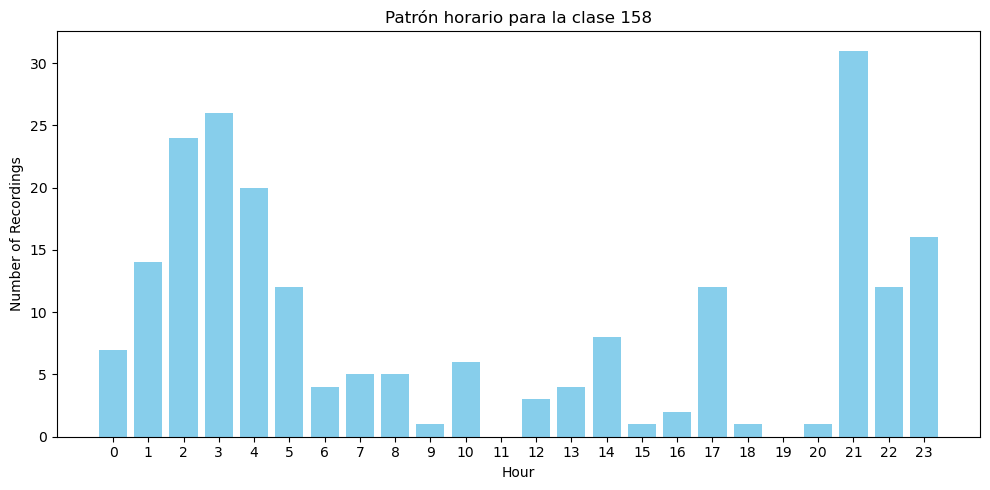

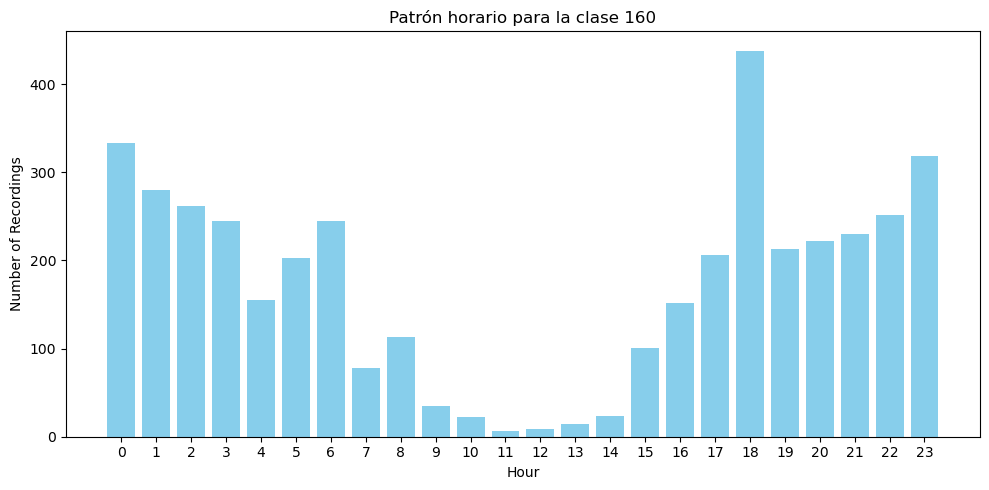

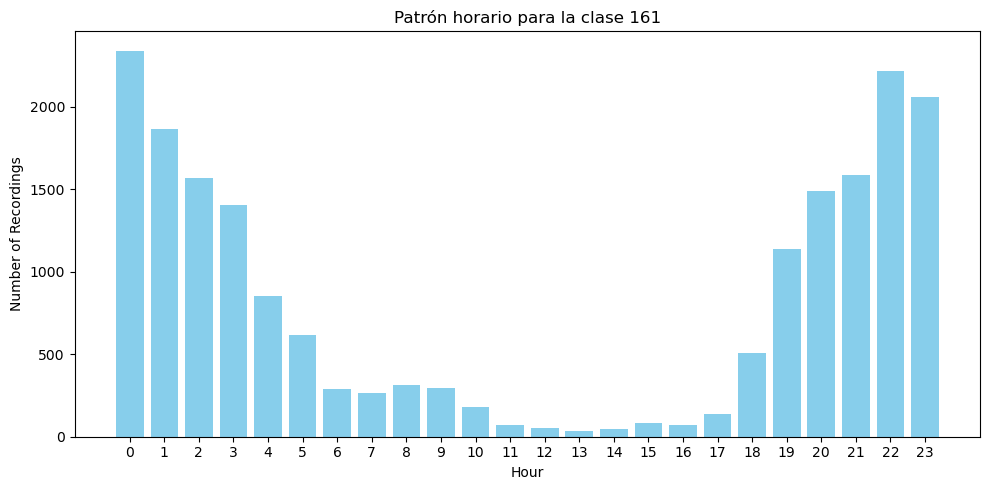

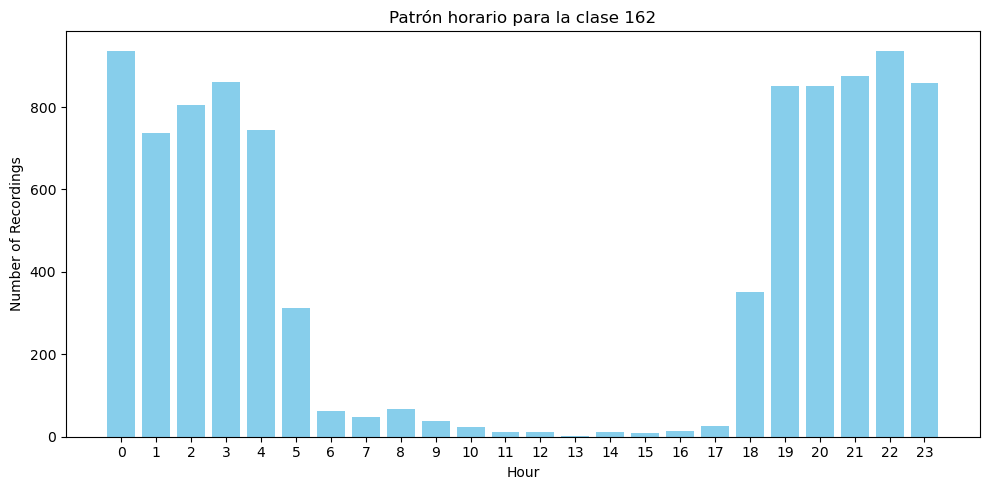

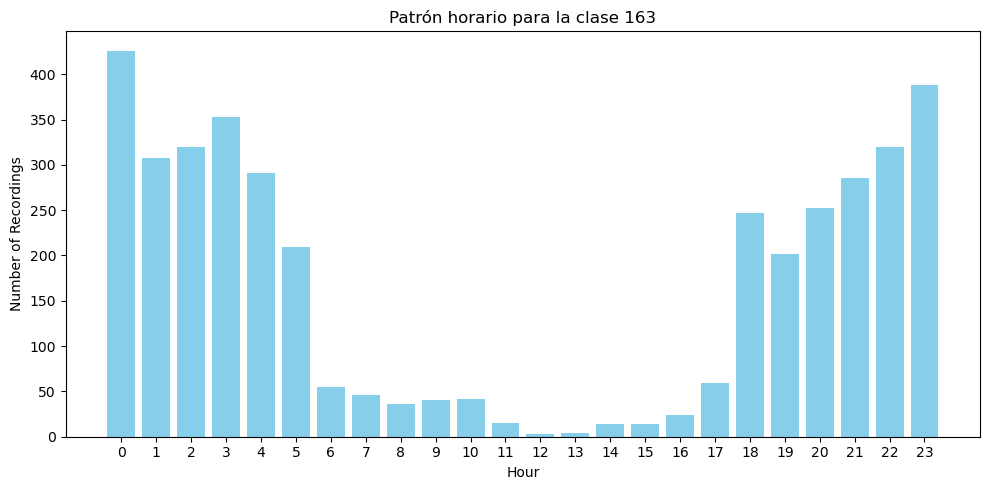

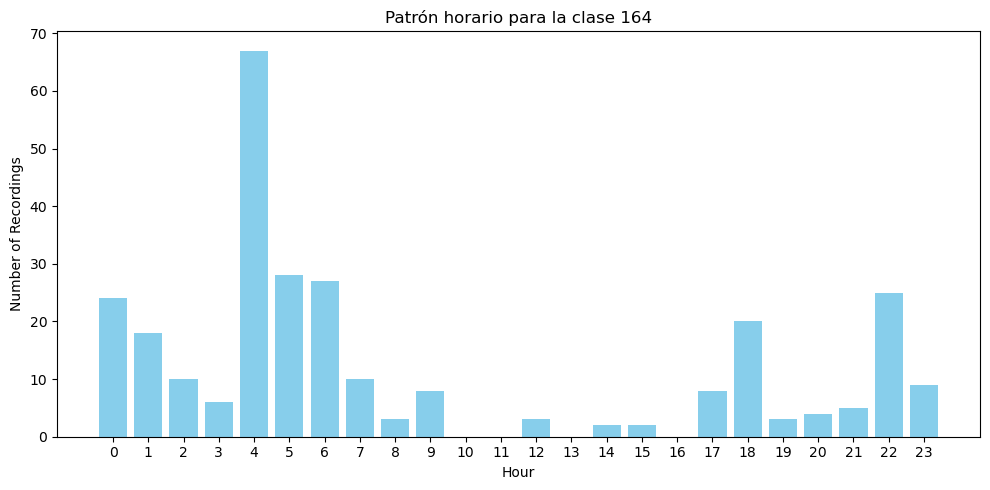

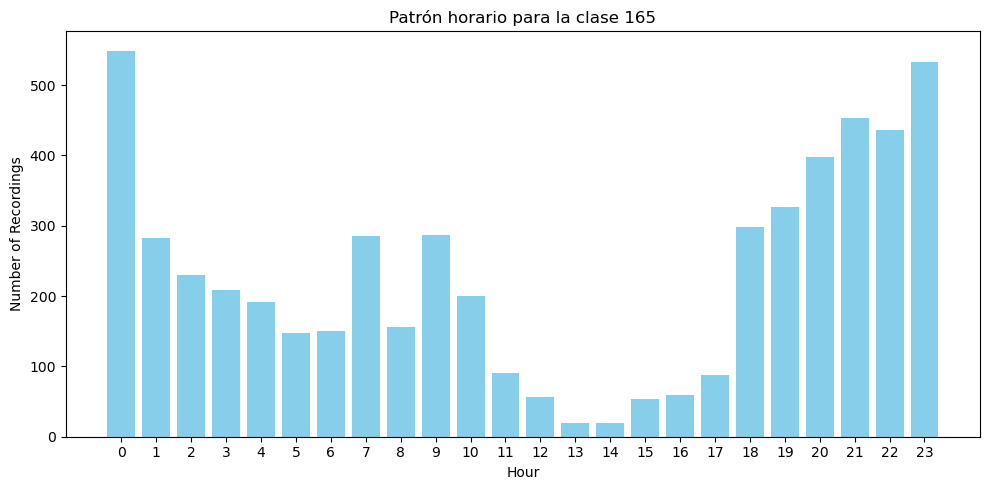

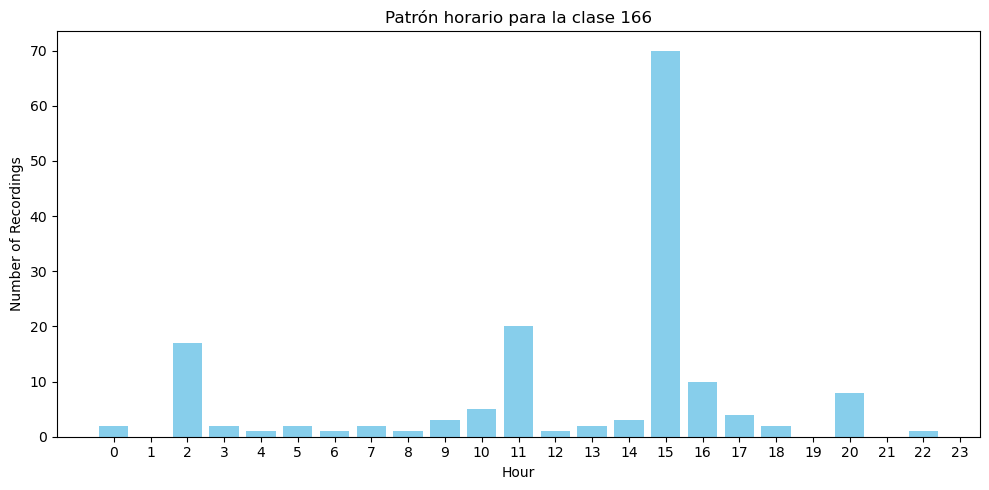

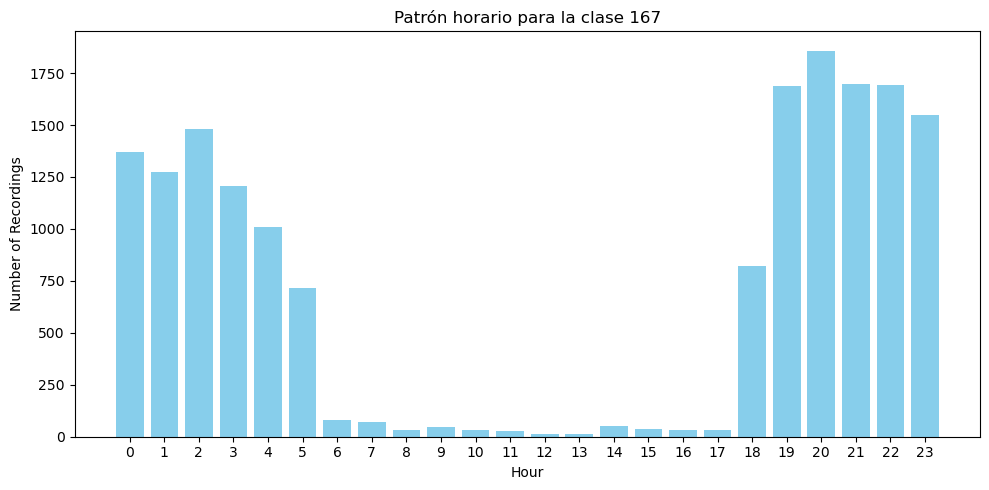

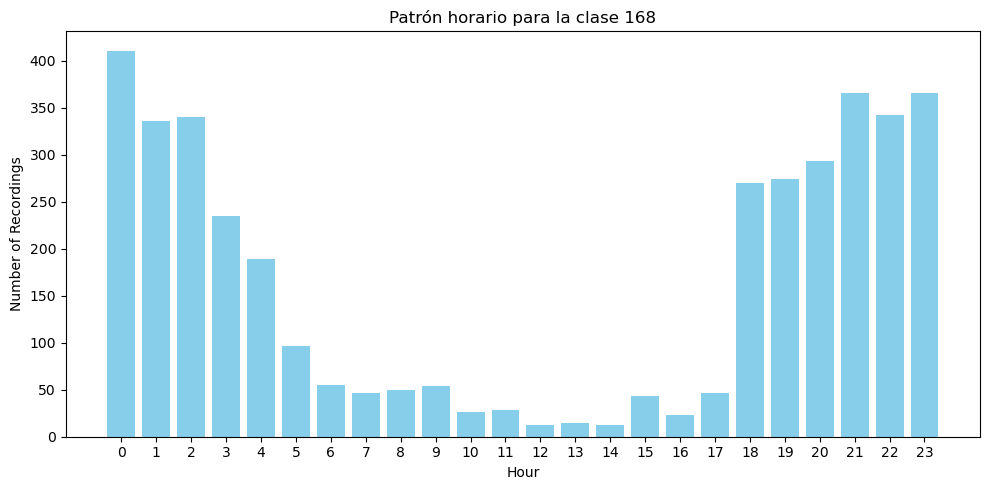

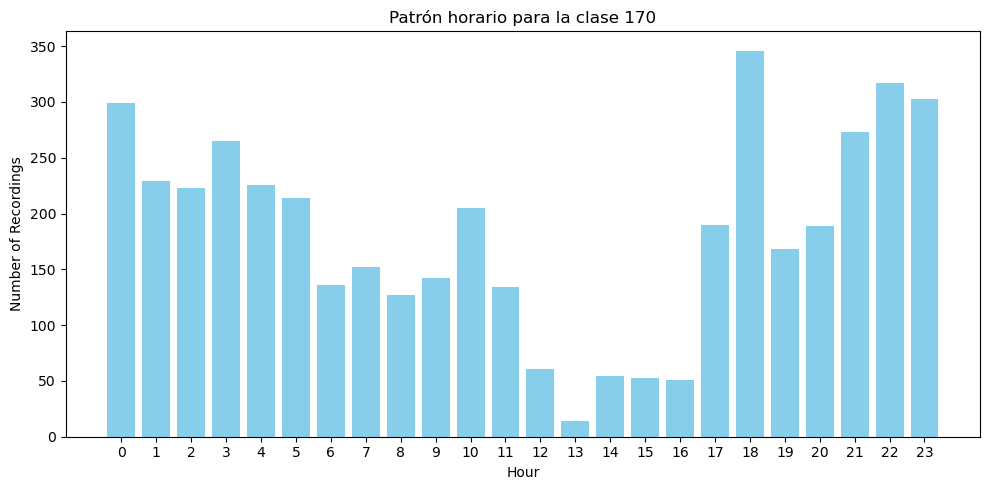

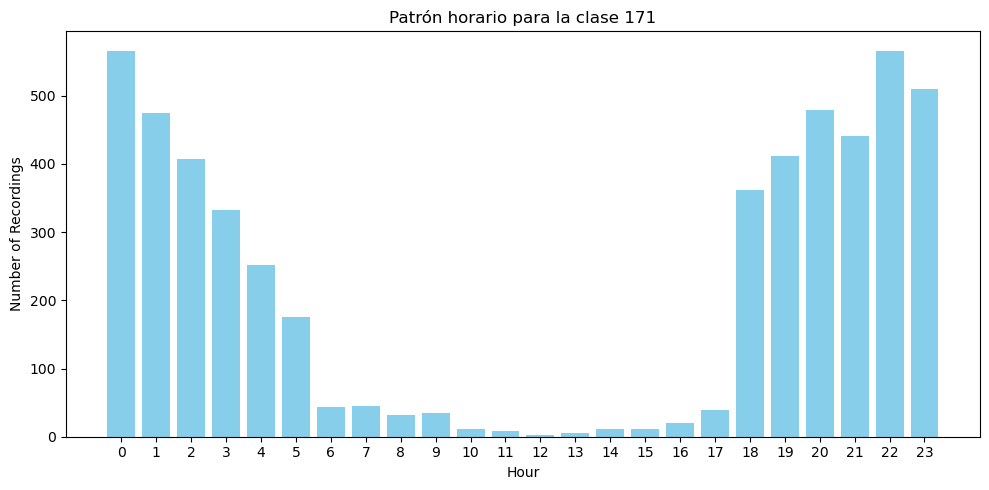

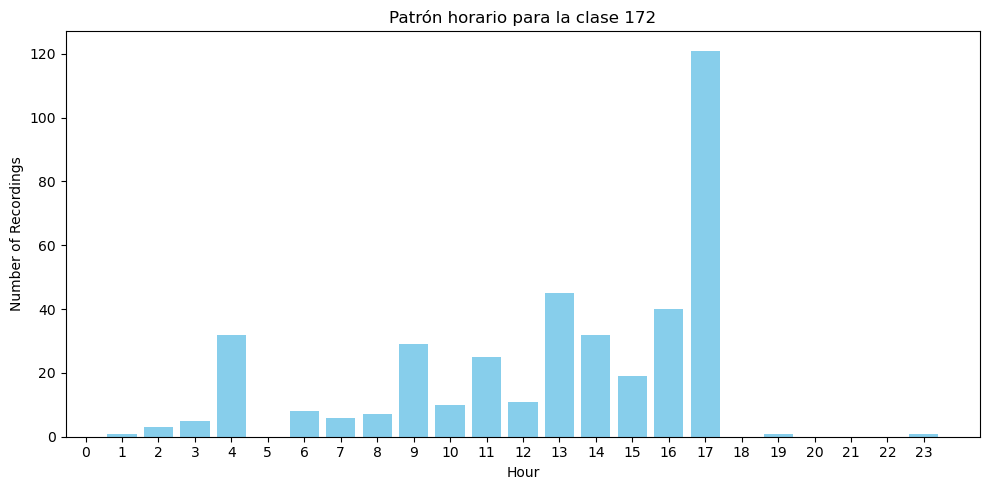

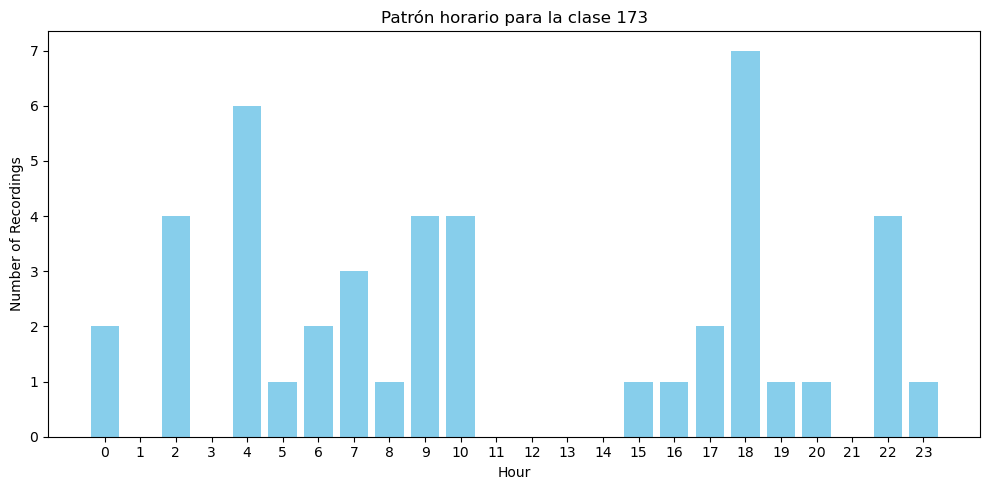

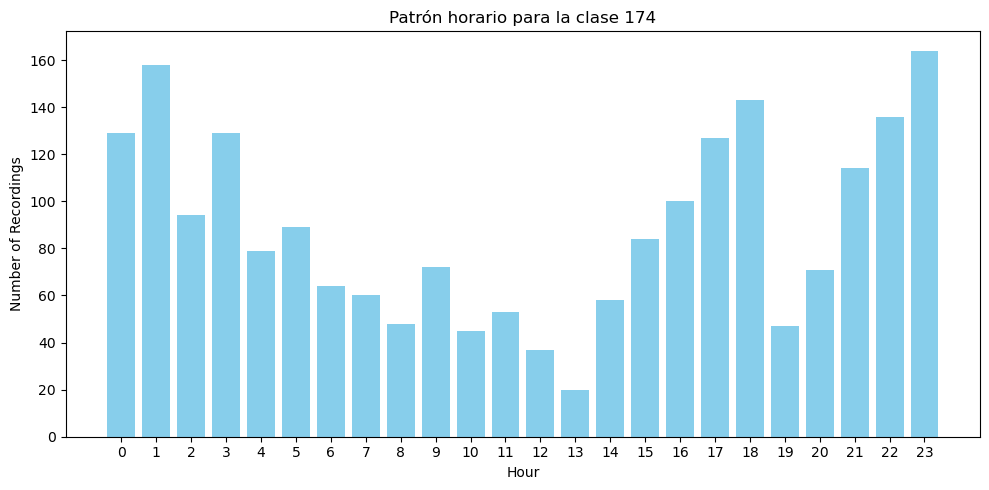

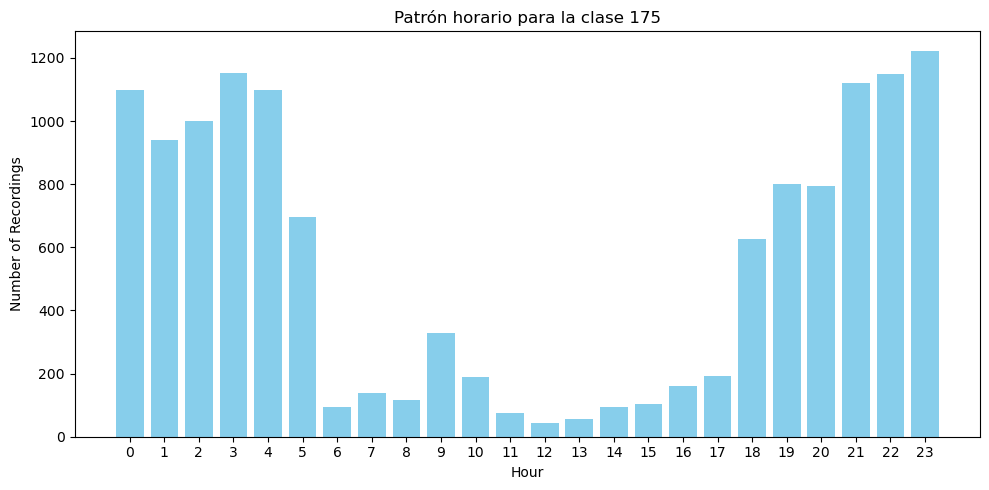

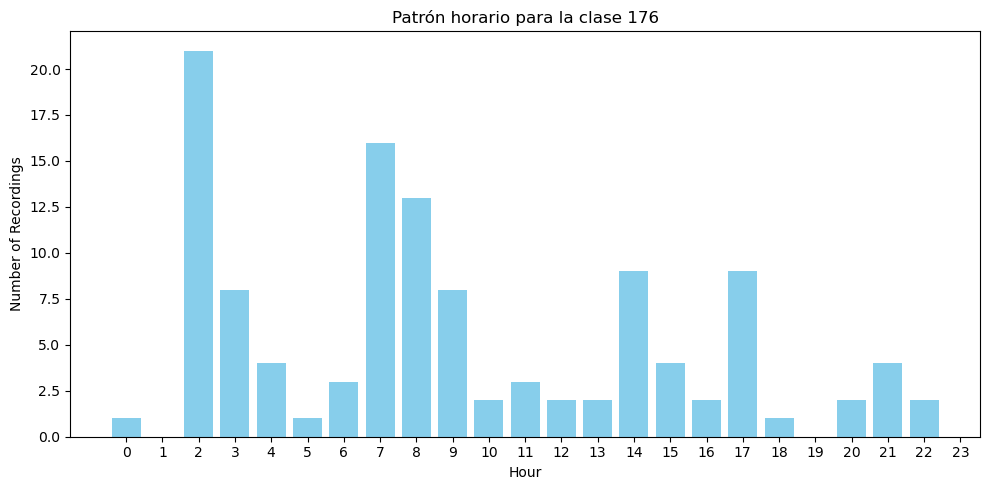

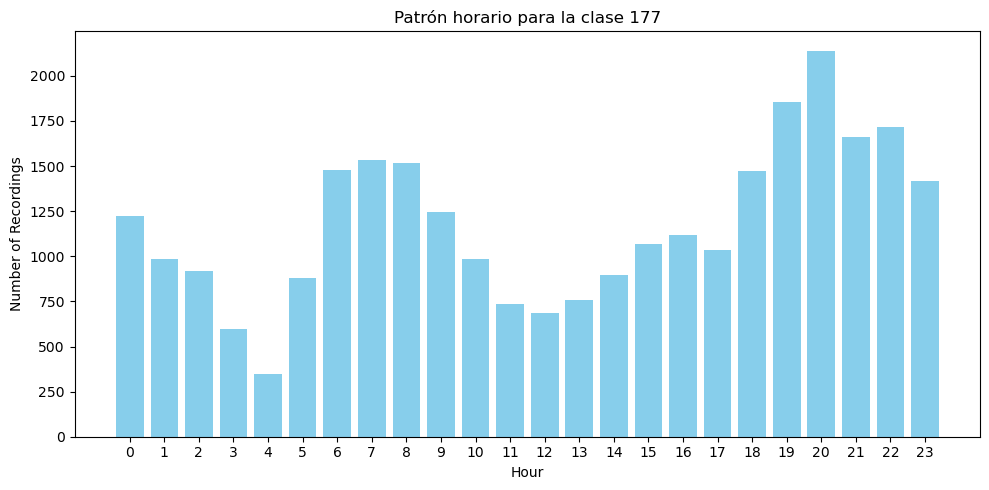

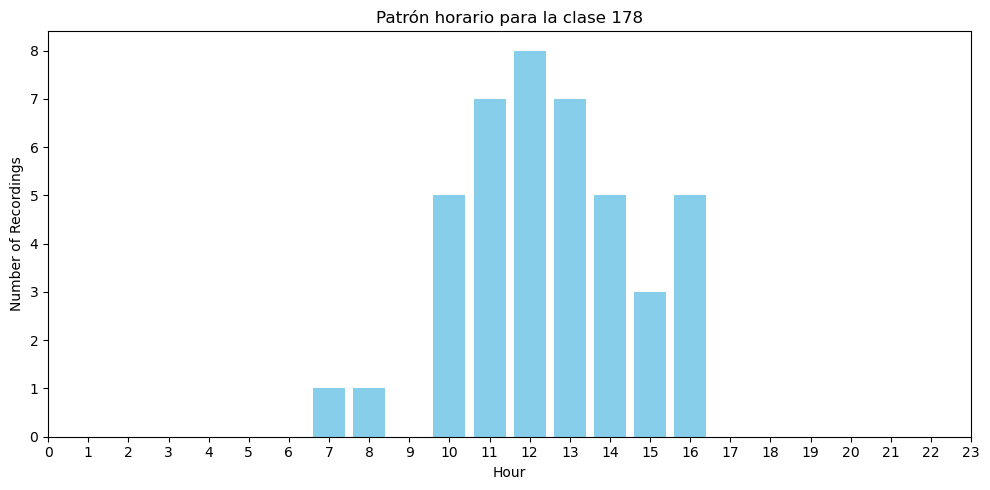

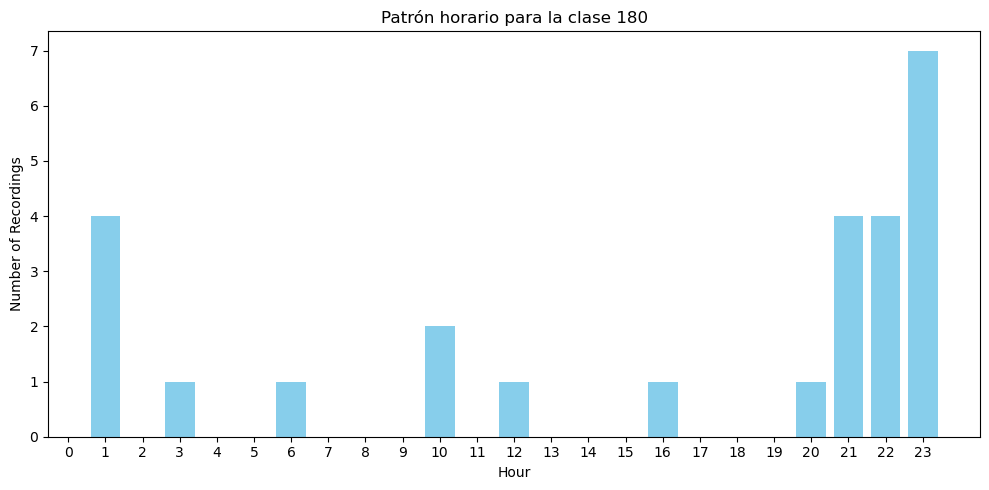

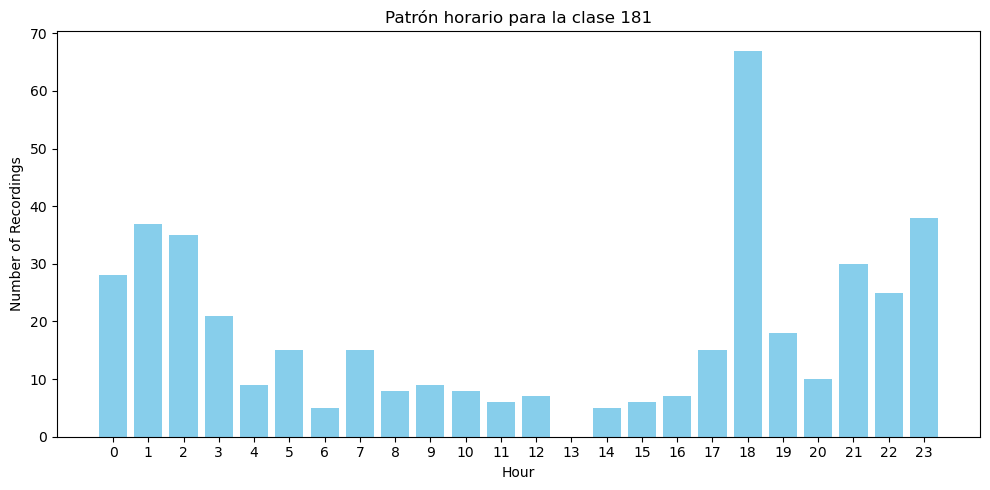

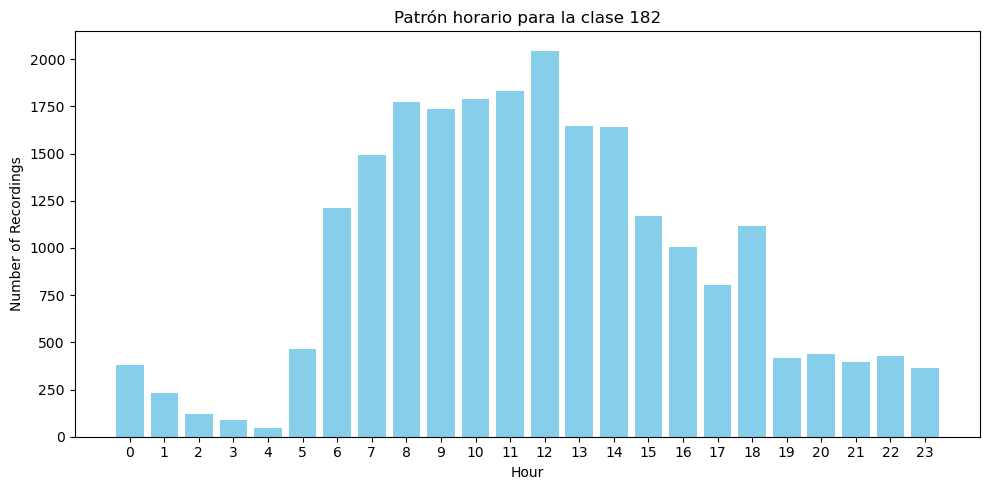

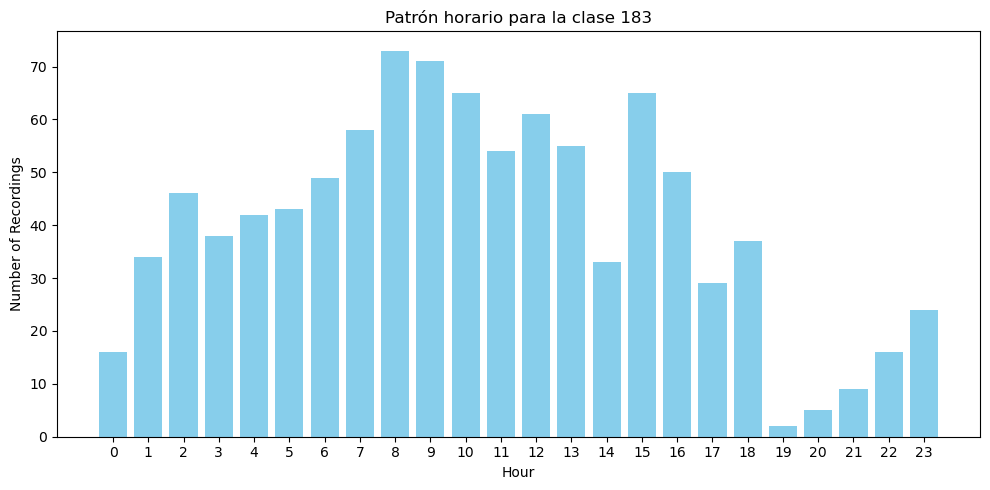

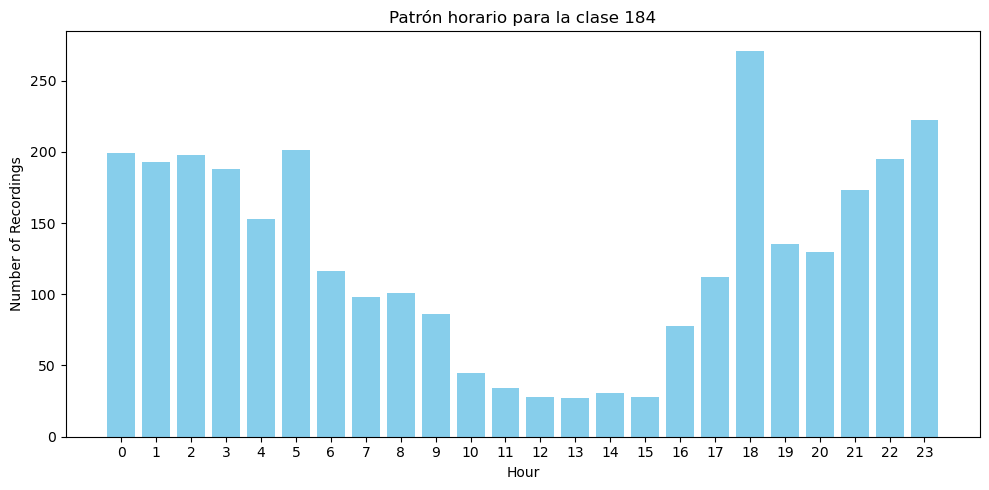

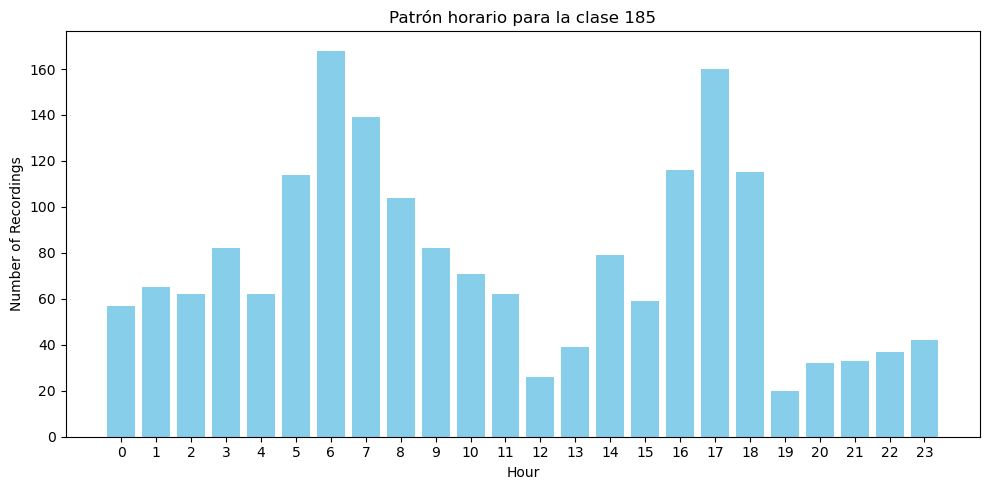

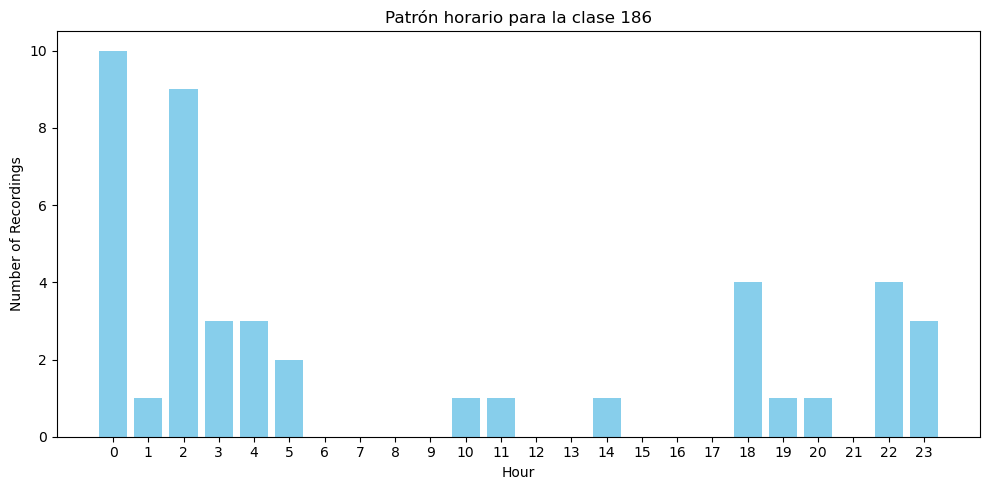

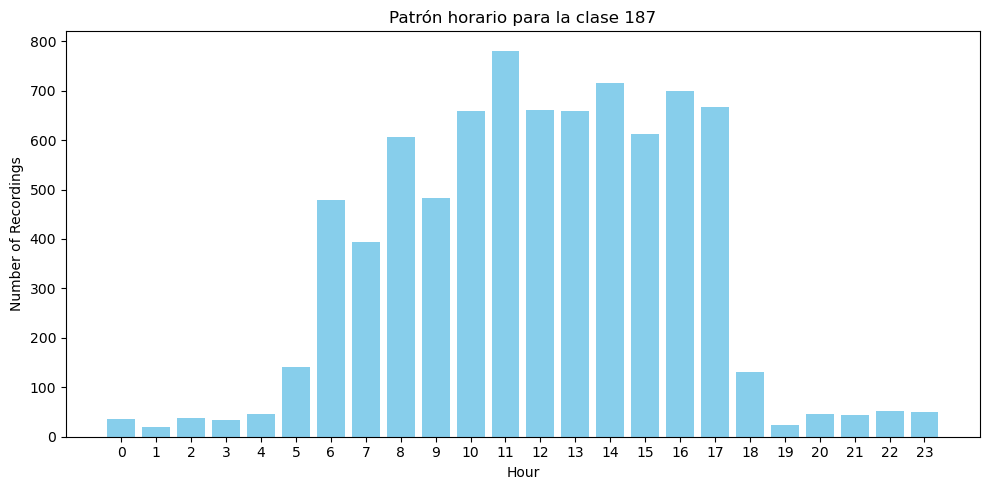

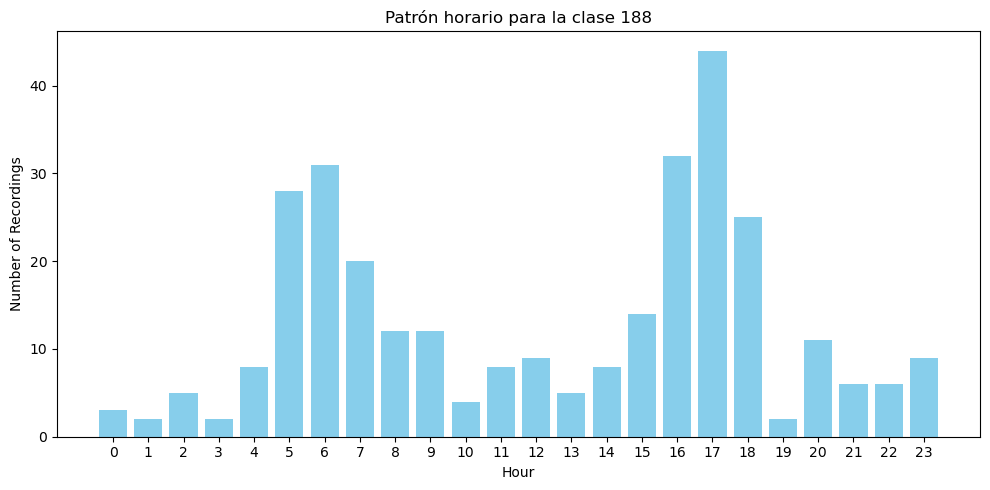

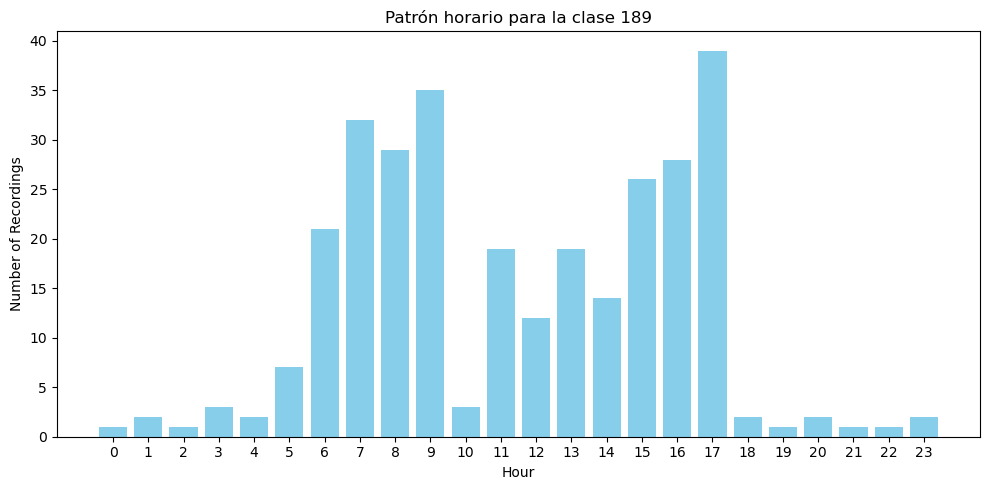

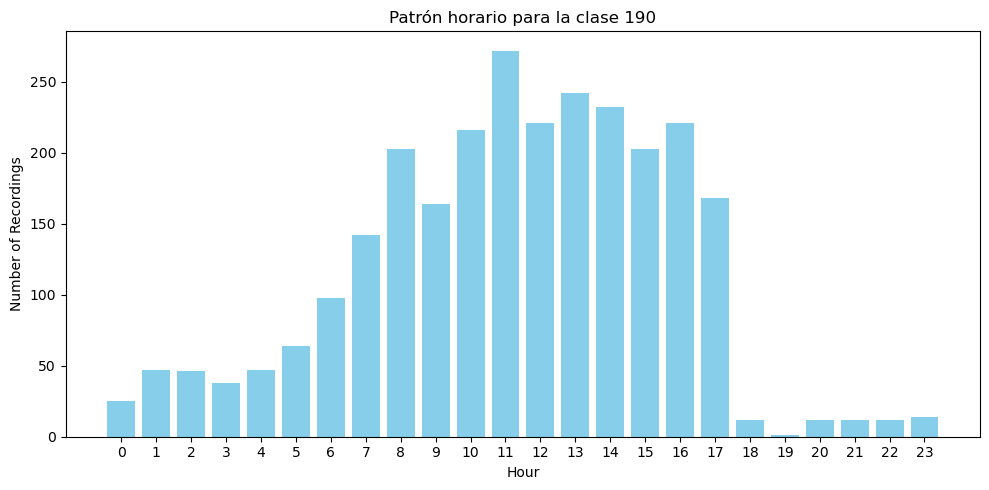

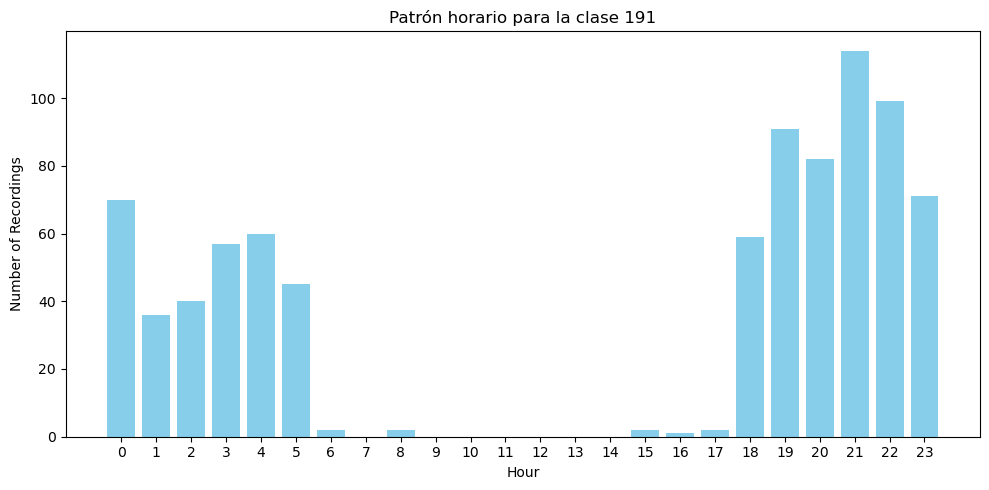

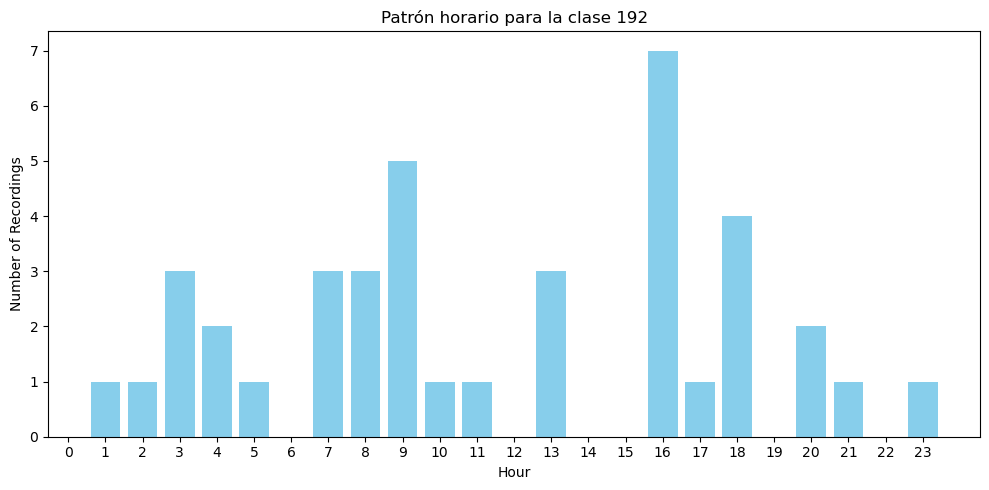

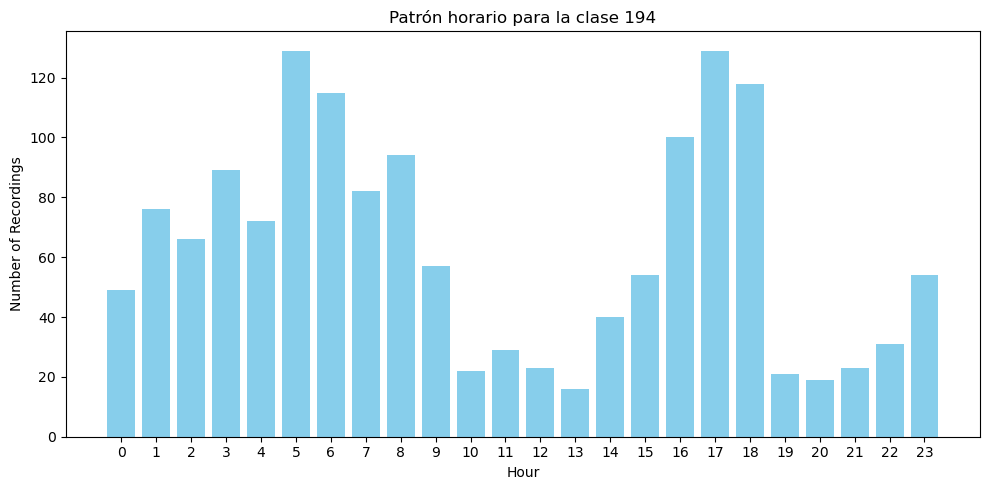

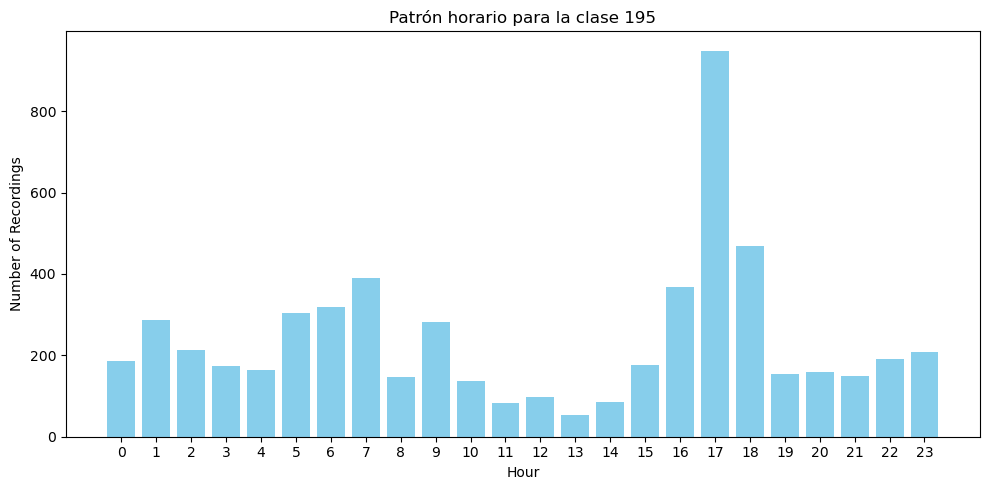

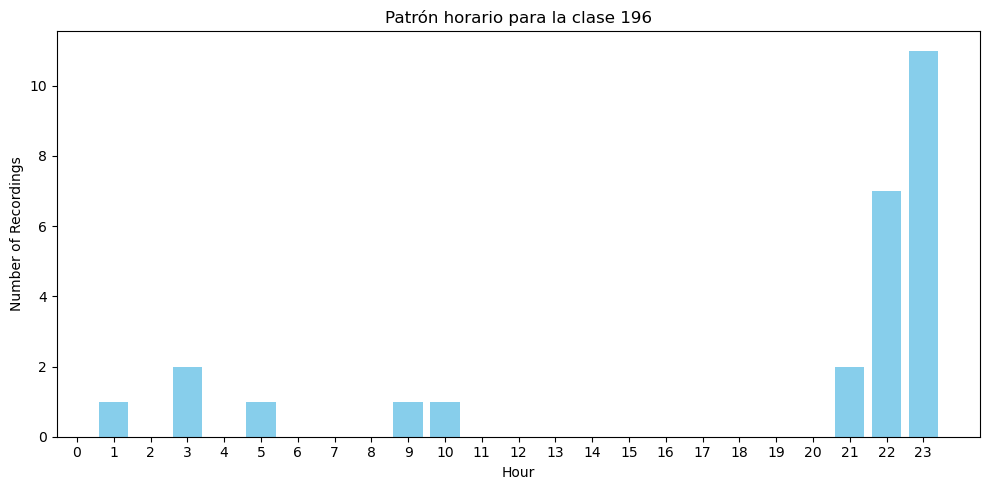

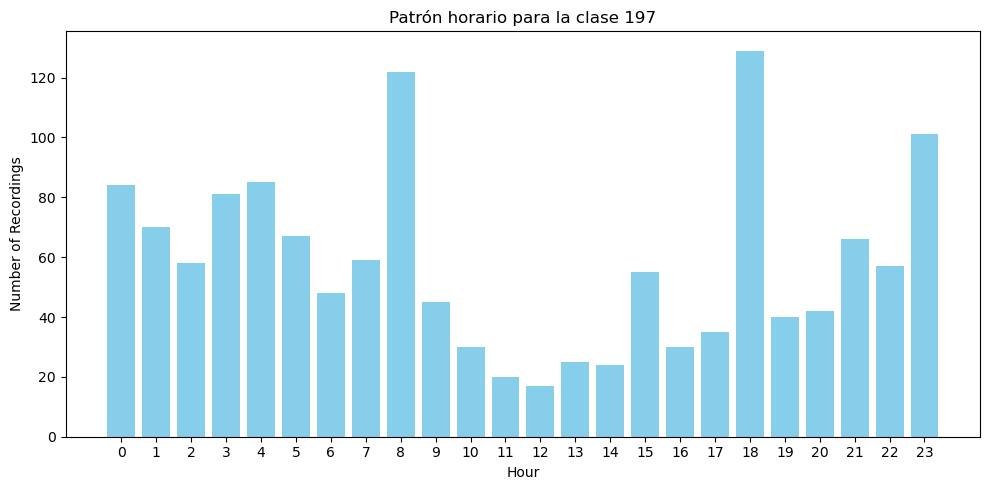

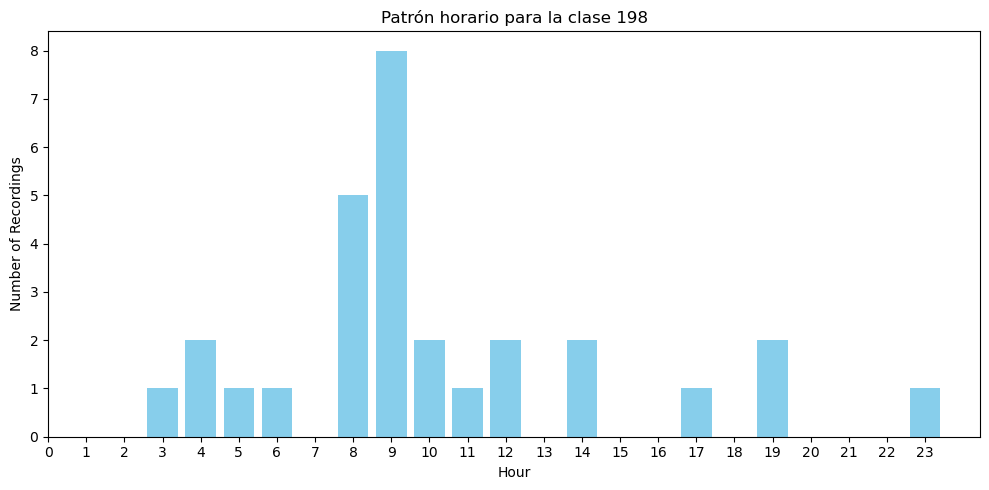

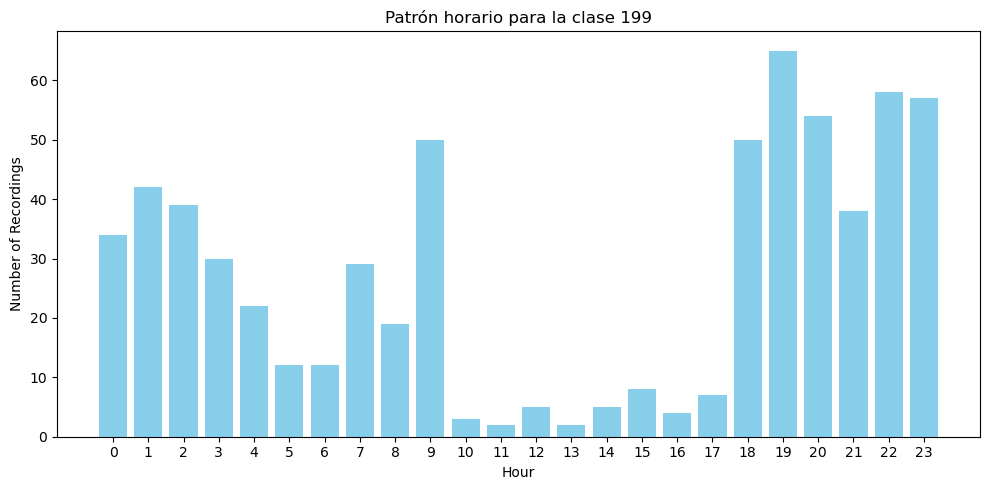

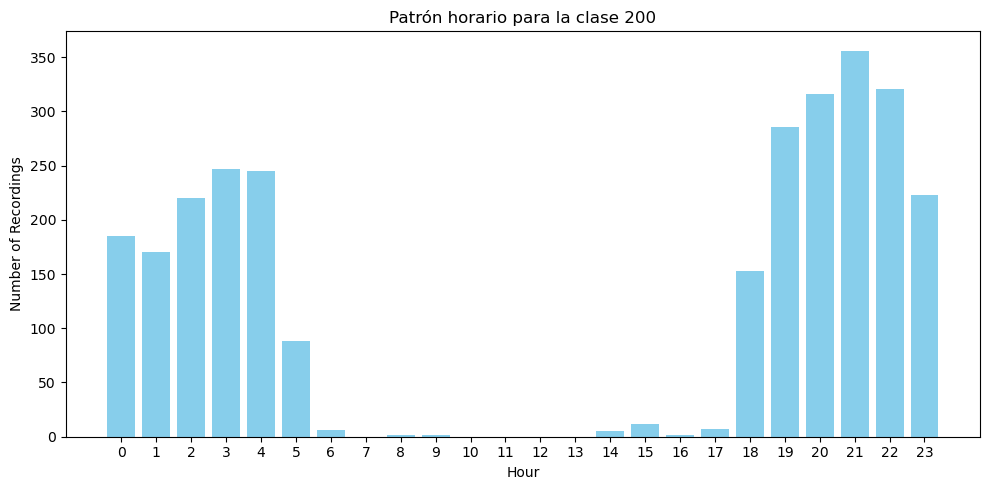

In [39]:
# Extraer la hora de la columna 'File'
filtered_df['Hour'] = filtered_df['File'].apply(lambda x: re.search(r'_(\d{6})\.wav', x).group(1)[:2])

# Convertir 'Hour' a un tipo numérico
filtered_df['Hour'] = filtered_df['Hour'].astype(int)

# Agrupar por clase y hora y contar cuántas grabaciones hay en cada hora
grouped = filtered_df.groupby(['Class', 'Hour']).size().reset_index(name='Count')

# Ordenar las clases del 2 al 201
ordered_classes = list(range(2, 202))

# Visualizar los patrones horarios para cada clase en el orden deseado
for class_name in ordered_classes:
    class_data = grouped[grouped['Class'] == class_name]
    if not class_data.empty:  # Verificar si hay datos para la clase actual
        plt.figure(figsize=(10, 5))
        plt.bar(class_data['Hour'], class_data['Count'], color='skyblue')
        plt.title(f'Patrón horario para la clase {class_name}')
        plt.xlabel('Hour')
        plt.ylabel('Number of Recordings')
        plt.xticks(range(0, 24))  # Asegura que se muestran las 24 horas en el eje x
        plt.tight_layout()
        plt.show()

In [59]:
month = []
day = []
hour = []
files2 = []

for cnt in range(len(filtered_df['File'])):
    s = filtered_df['File'].iloc[cnt].split("_")
    files2.append(s[0])
    month.append(int(s[1][4:-2]))
    day.append(int(s[1][-2:]))
    hour.append(int(s[2][:2]))

filtered_df['File'] = files2
filtered_df['Month'] = month
filtered_df['Day'] = day
filtered_df['Hour'] = hour
print(filtered_df)

             File    Length         Fdom    FminVoc    FmaxVoc  Class  \
2        SMA03126  0.789333  6210.846037  6117.1875  7617.1875     35   
8        SMA03126  0.085333  5624.954268  5578.1250  6140.6250    230   
9        SMA03126  0.138667  5390.396341  5156.2500  5625.0000    226   
17       SMA03126  0.576000  6421.783537  6328.1250  7617.1875      8   
27       SMA03126  0.085333  5928.452744  4664.0625  6375.0000    277   
...           ...       ...          ...        ...        ...    ...   
3036710  SMA03326  0.330667  4124.611280  3726.5625  4289.0625     47   
3036711  SMA03326  0.192000  2554.527439  2390.6250  3093.7500     28   
3036712  SMA03326  0.213333  4194.740854  3609.3750  4359.3750    299   
3036713  SMA03326  0.224000  2531.089939  2367.1875  3093.7500     28   
3036714  SMA03326  0.277333  2343.612805  2203.1250  3093.7500     28   

         Membership  Bandwidth  Month  Day  Hour  
2          0.828466  1500.0000      3   22    15  
8          0.813142  

In [60]:
sitios = list(filtered_df['File'].unique())
sonotipos = list(filtered_df['Class'].unique())
sitios.sort()
sonotipos.sort()
Dmin=filtered_df.Day.min()
Dmax=filtered_df.Day.max()
x = list(range(24))
print('Dia Minimo: ', Dmin)
print('Dia Maximo: ', Dmax)
print('Sitios: ', sitios)
print('Cantidad de Sitios: ',len(sitios))
print('Sonotipos: ', len(sonotipos))

Dia Minimo:  18
Dia Maximo:  30
Sitios:  ['SMA03126', 'SMA03175ICP', 'SMA03210', 'SMA03247', 'SMA03251', 'SMA03286', 'SMA03294', 'SMA03297', 'SMA03320', 'SMA03322', 'SMA03326', 'SMA03327', 'SMA03328', 'SMA03330', 'SMA03332', 'SMA03393', 'SMA03406']
Cantidad de Sitios:  17
Sonotipos:  290


# Sonotipos en cada sitio por hora

[198, 203, 208, 198, 201, 194, 187, 152, 144, 134, 136, 126, 112, 118, 113, 130, 146, 181, 220, 182, 186, 200, 194, 195]


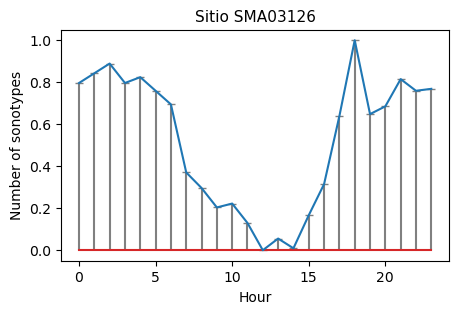

[168, 168, 168, 165, 143, 192, 178, 176, 174, 170, 158, 119, 150, 115, 132, 138, 142, 168, 208, 134, 139, 148, 160, 160]


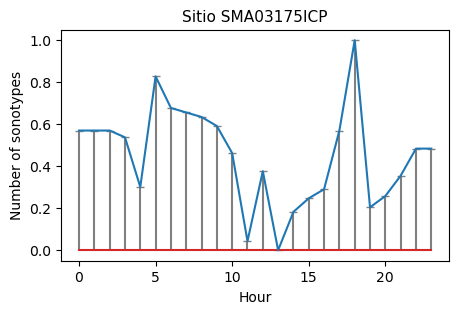

[203, 187, 198, 200, 188, 206, 170, 172, 178, 171, 162, 151, 145, 143, 159, 173, 161, 193, 190, 131, 136, 154, 162, 194]


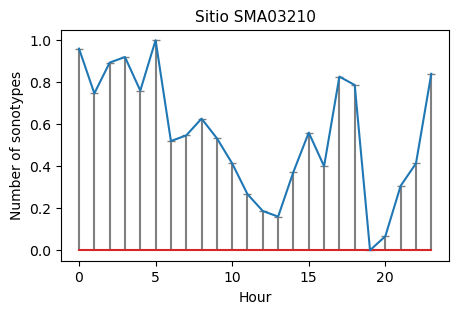

[156, 141, 134, 145, 166, 207, 189, 198, 197, 177, 156, 132, 113, 126, 171, 182, 172, 190, 171, 117, 129, 132, 148, 157]


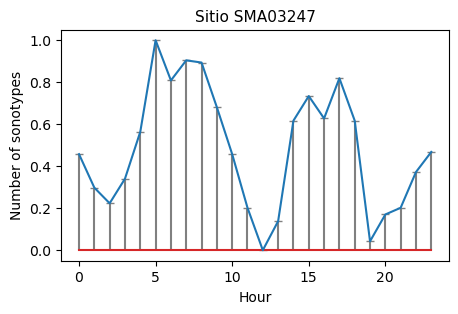

[184, 180, 191, 188, 187, 202, 145, 149, 144, 129, 119, 117, 102, 89, 107, 106, 113, 155, 201, 175, 180, 178, 181, 188]


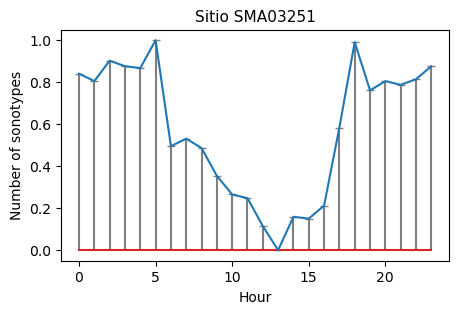

[175, 159, 164, 153, 149, 177, 175, 175, 170, 141, 106, 95, 88, 80, 82, 75, 105, 143, 176, 136, 165, 163, 163, 155]


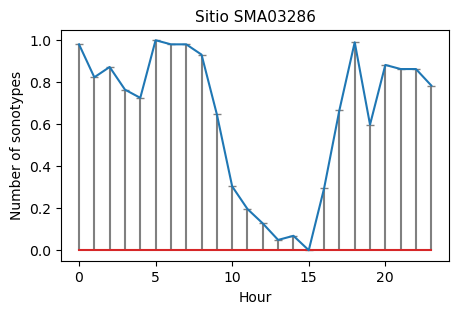

[200, 185, 177, 173, 170, 191, 130, 136, 114, 105, 83, 75, 80, 86, 80, 86, 95, 115, 210, 172, 189, 185, 195, 177]


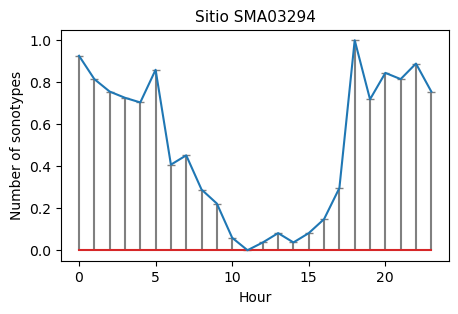

[155, 162, 179, 188, 203, 200, 189, 189, 169, 154, 160, 149, 146, 159, 176, 180, 192, 229, 201, 153, 157, 181, 181, 169]


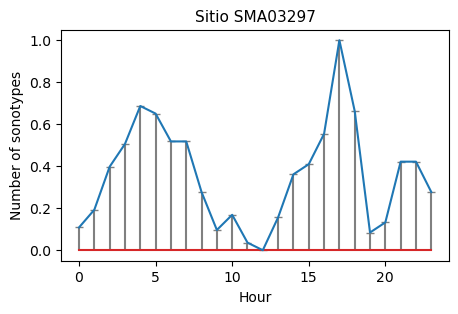

[111, 96, 92, 103, 113, 142, 182, 178, 181, 201, 203, 197, 198, 185, 199, 183, 195, 198, 155, 75, 72, 92, 91, 115]


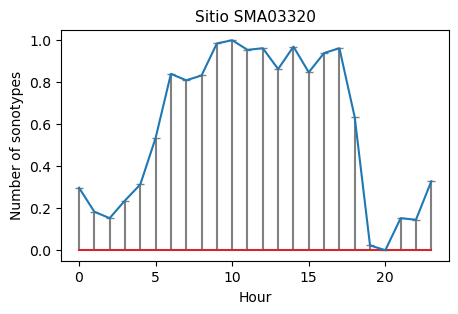

[169, 163, 163, 172, 171, 185, 193, 198, 180, 169, 153, 136, 121, 108, 101, 140, 143, 166, 205, 144, 141, 157, 159, 174]


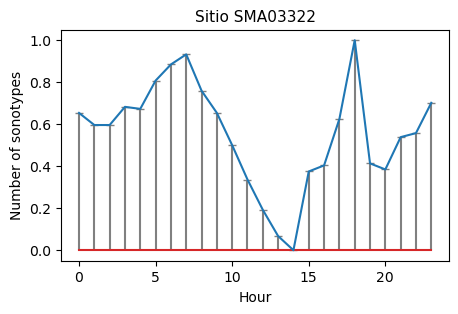

[181, 191, 203, 182, 179, 200, 161, 159, 130, 117, 116, 138, 109, 95, 106, 130, 123, 133, 187, 168, 181, 188, 190, 190]


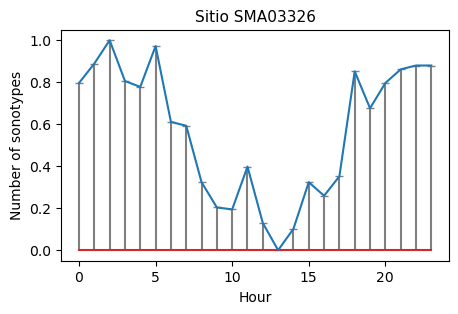

[147, 135, 118, 134, 115, 155, 0, 37, 38, 0, 33, 0, 81, 51, 83, 91, 116, 84, 172, 140, 106, 106, 142, 165]


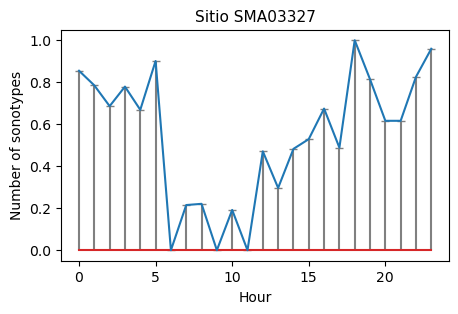

[140, 132, 141, 137, 137, 188, 175, 149, 154, 150, 117, 109, 102, 108, 128, 141, 162, 188, 211, 102, 111, 137, 135, 143]


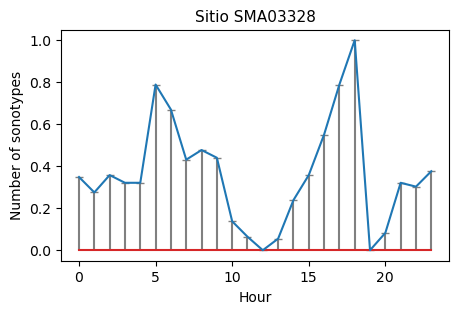

[134, 107, 136, 138, 145, 187, 198, 195, 214, 194, 179, 143, 143, 133, 116, 145, 147, 161, 191, 115, 124, 152, 140, 142]


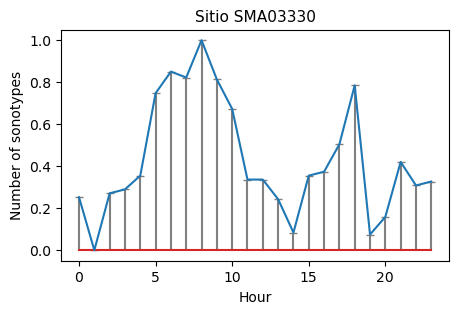

[130, 136, 119, 107, 103, 160, 168, 158, 155, 151, 129, 98, 112, 146, 158, 167, 180, 164, 154, 97, 99, 116, 127, 127]


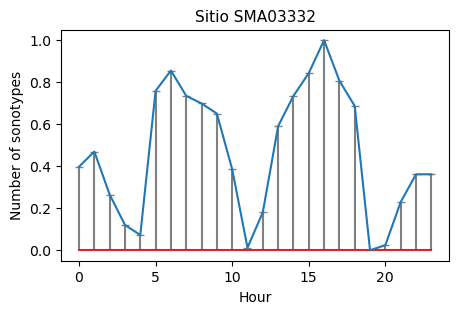

[154, 166, 167, 162, 175, 193, 184, 185, 169, 147, 152, 118, 116, 82, 136, 147, 149, 182, 190, 152, 159, 166, 169, 156]


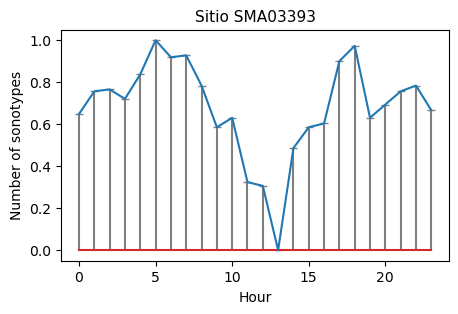

[129, 136, 138, 151, 150, 195, 197, 201, 207, 213, 207, 212, 189, 197, 190, 191, 188, 207, 223, 111, 114, 120, 123, 141]


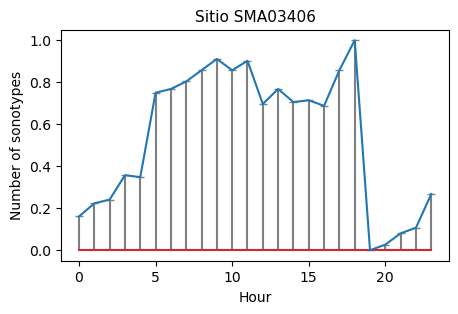

In [42]:
#gráfica de número de sonotipos por sitio, por hora
#Conteo en general
sitios = list(sitios)
for sit in sitios:
    subSet = filtered_df[filtered_df['File']==sit]

    hora = np.array(subSet[['Hour']])
    clase= np.array(subSet[['Class']])
    x=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

    y=[]
    for i in range(0,24):
        y.append(len(np.unique(clase[hora==i])))

    print(y)
    Nmin=np.min(y)
    Nmax=np.max(y)

    ynorm=(y-Nmin)/(Nmax-Nmin)


    plt.figure(figsize=(5,3))
    markerline,stemlines,baseline = plt.stem(x, ynorm, linefmt ='grey',markerfmt ='_', bottom =0)
    markerline.set_markerfacecolor('none')
    plt.plot(x, ynorm, label='Todos los sonotipos x día')

    plt.xlabel('Hour')
    plt.ylabel('Number of sonotypes')
    plt.title("Sitio "+sit, fontsize = 11)
    plt.show()


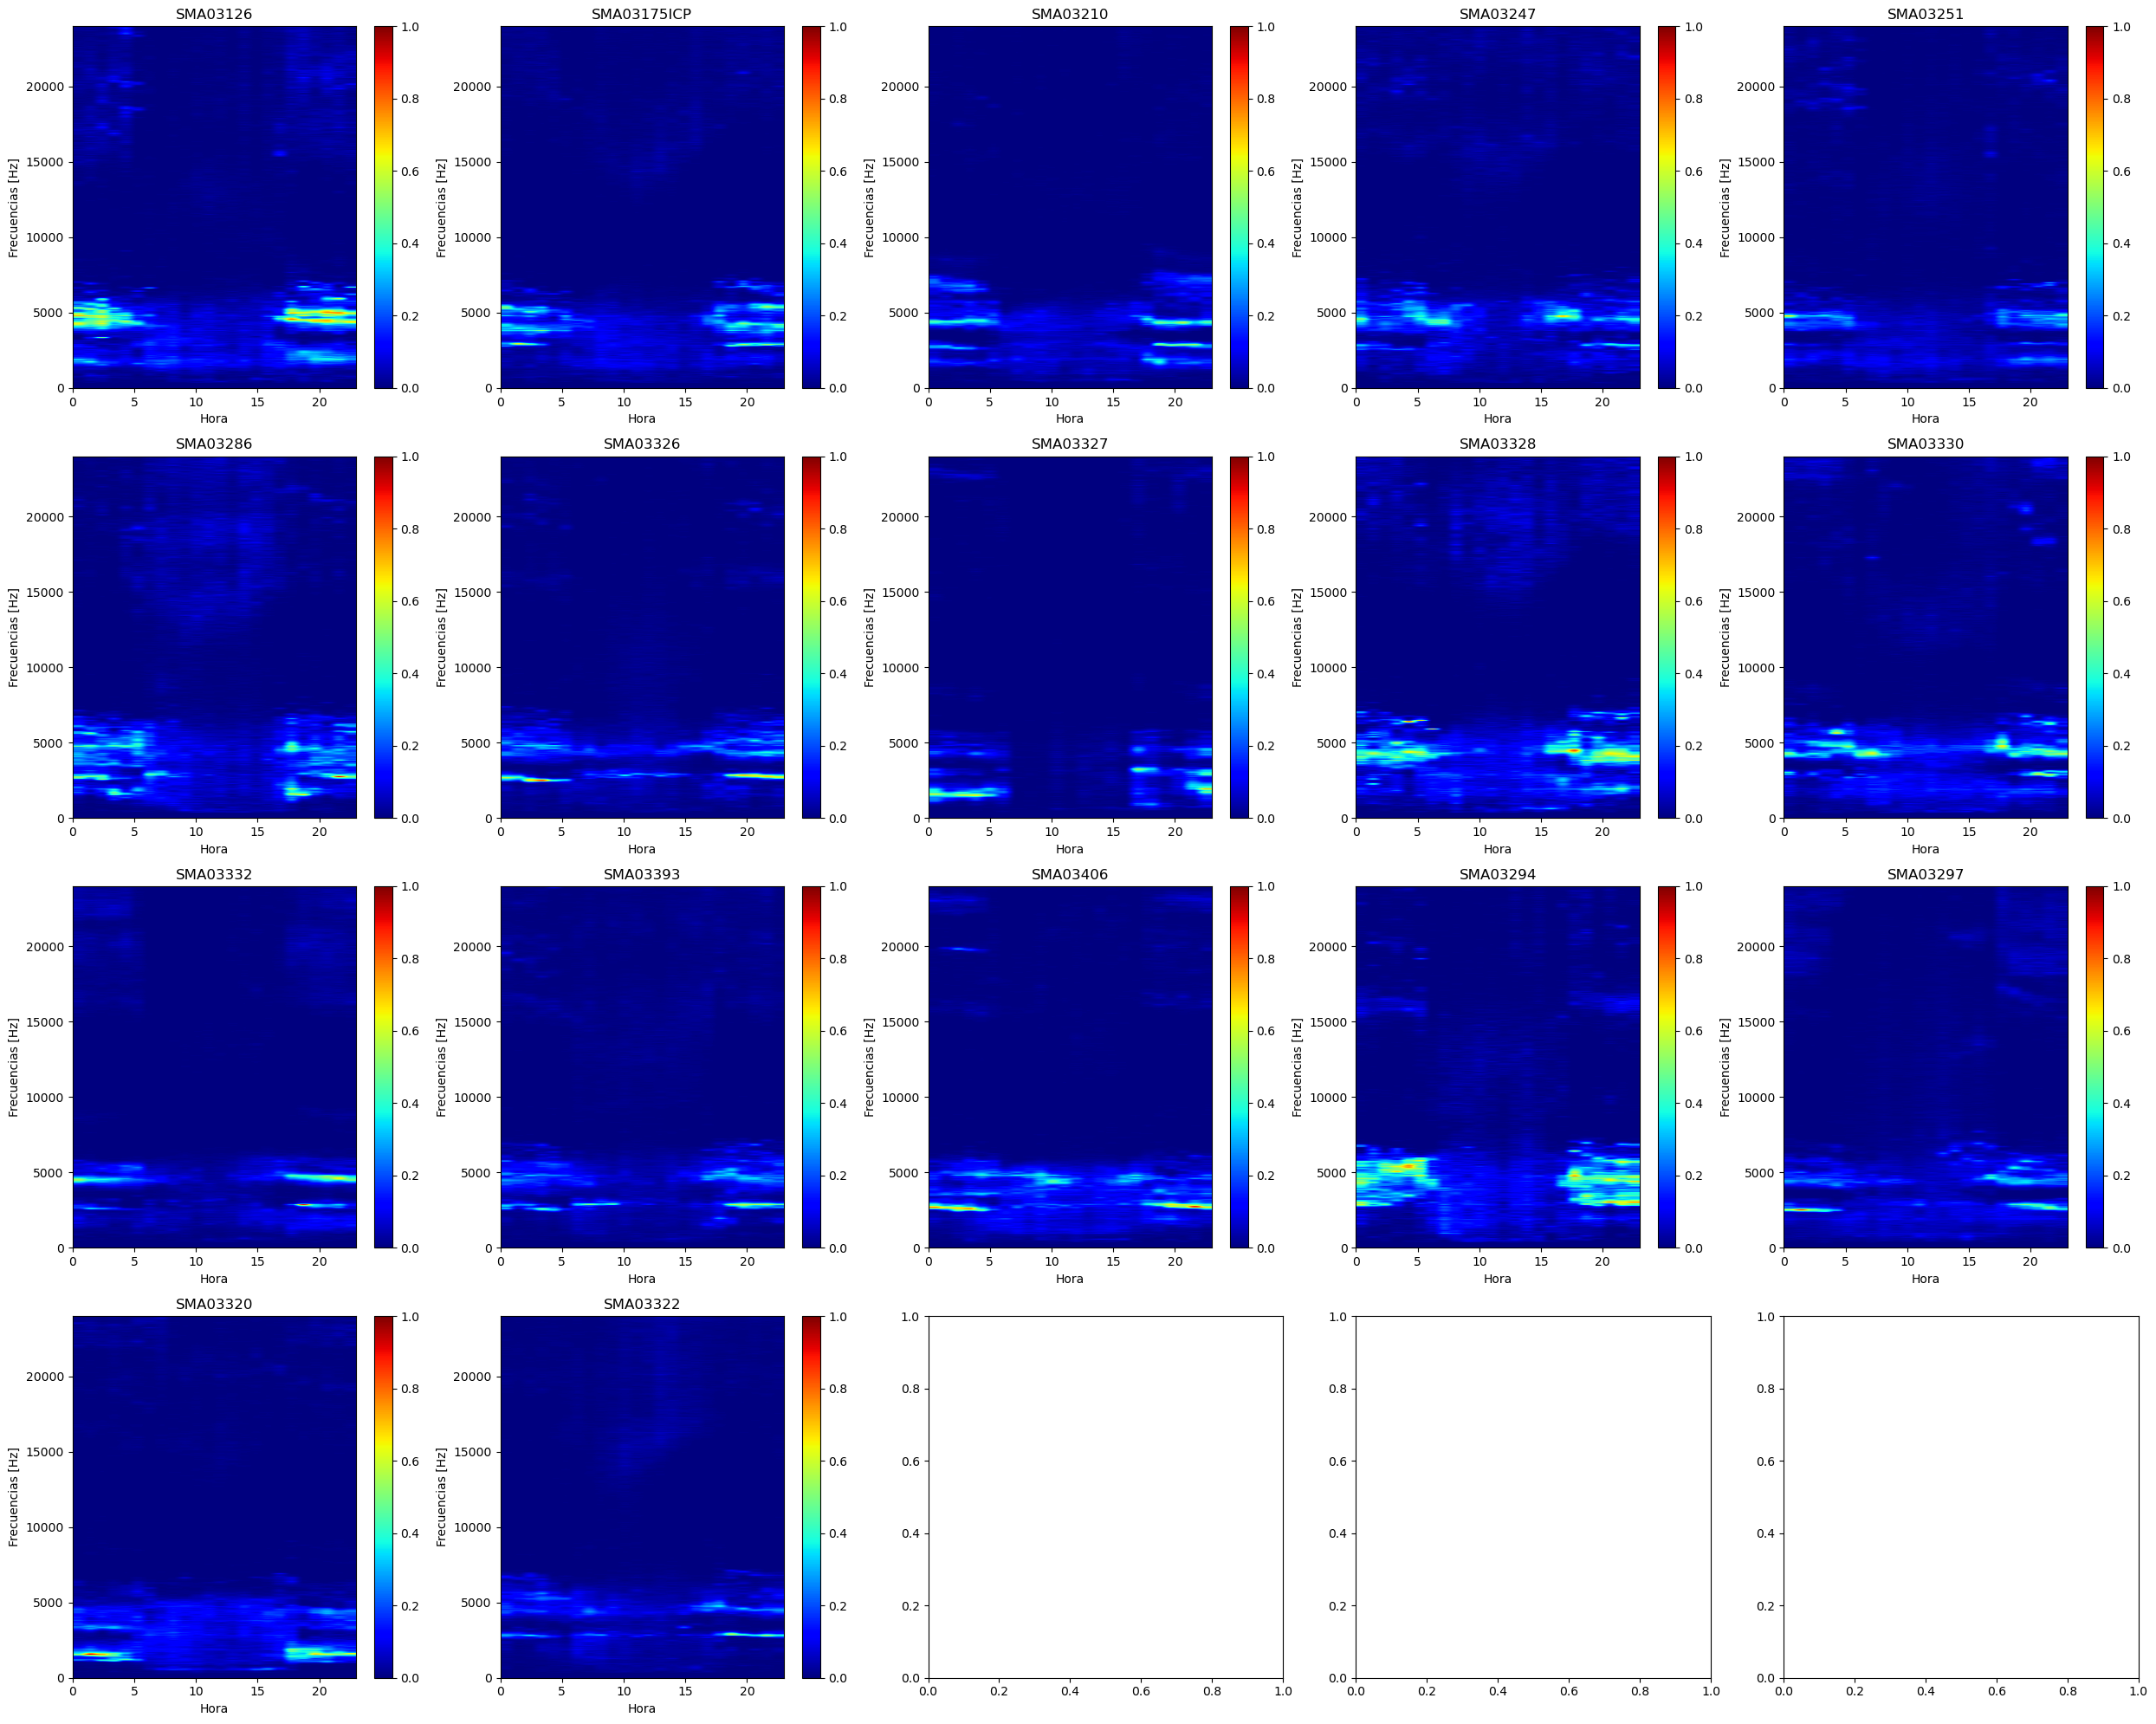

In [43]:
# Definir el número de filas y columnas para el subplot
nrows = 4
ncols = 5

# Crear el subplot
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,20))
fig.subplots_adjust(hspace=0.5)

# Crear las gráficas para cada sitio
for i, sitio in enumerate(filtered_df['File'].unique()):
    # Seleccionar los datos correspondientes a cada sitio
    data = filtered_df[filtered_df['File'] == sitio]

    # Definir las frecuencias y bins de frecuencias
    frecuencia_min = 0
    frecuencia_max = 24024
    num_frecuencias = 1000
    frecuencias = np.linspace(frecuencia_min, frecuencia_max, num_frecuencias+1)

    # Redondear las frecuencias
    data['Frecuencias'] = pd.cut(data['Fdom'], bins=frecuencias, labels=frecuencias[:-1])

    # Agrupar por hora y frecuencia y calcular la cantidad de entidades acústicas
    agrupado = data.groupby(['Hour', 'Frecuencias']).count()

    #Normalizar
    agrupado['Class_norm'] = (agrupado['Class'] - agrupado['Class'].min()) / (agrupado['Class'].max() - agrupado['Class'].min())


    # Crear matriz 2D con los valores de la media calculados para cada hora y frecuencia
    matriz = agrupado.pivot_table(values='Class_norm', index='Frecuencias', columns='Hour', fill_value=0)
    matrix = matriz.values

    # Crear la gráfica
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    im = ax.imshow(matrix, origin='lower', cmap='jet', extent=[0, 23, 0, 24000], aspect='auto')
    ax.set_title(sitio)
    ax.set_xlabel('Hora')
    ax.set_ylabel('Frecuencias [Hz]')
    fig.colorbar(im, ax=ax)

# Ajustar el subplot y mostrar la gráfica
plt.tight_layout()
plt.show()


# Matriz de sonotipos y lugares - Abundancias por franja horaria

In [13]:
Path_out='/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_out/'

In [16]:
# Definición de la función que determina la franja horaria
def determine_time_slot(hour):
    if 5 <= hour < 8:
        return "5-8"
    elif 8 <= hour < 16:
        return "8-17"
    elif 16 <= hour < 20:
        return "17-20"
    else:  # 20-5
        return "20-5"

# Asumiendo que tienes una columna 'Hour' en tu DataFrame que indica la hora
filtered_df['TimeSlot'] = filtered_df['Hour'].apply(determine_time_slot)


# Obtener los sitios únicos
sitios = list(filtered_df['File'].unique())
sitios.sort()

#ruta_out='/content/drive/MyDrive/Datos_zamuro_banda_0_22k/Primeros excel/'

for time_slot in ['5-8', '8-17', '17-20', '20-5']:
    result = {}
    for i in tqdm(sonotipos):
        subSet = filtered_df[filtered_df['Class'] == i]
        subset_time = subSet[subSet['TimeSlot'] == time_slot]
        for j in sitios:
            cont = len(subset_time[subset_time['File'] == j])
            if i not in result:
                result[i] = {}
            result[i][j] = cont
    
    result_df = pd.DataFrame.from_dict(result)
    #result_df.to_excel(f"{Path_out}Matriz_Resumen_sonotipos_todos_{time_slot}.xlsx")

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

Cargo matrices

In [23]:
df1 = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_input/Matrix_information.xlsx')
df1

Point  latitude  longitude  Habitat  Site Recording Name
0   KLSA01   7.36574  -73.85669        1     0       SMA03286
1   KLSA02   7.36832  -73.86041        1     1       SMA03294
2   KLSA03   7.36765  -73.85181        2     2       SMA03332
3   KLSA04   7.36233  -73.85412        1     3       SMA03322
4   KLSA05   7.36389  -73.86101        3     4       SMA03210
5   KLSA06   7.36238  -73.84993        1     5       SMA03328
6   KLSA07   7.35796  -73.85642        3     6       SMA03297
7   KLSA08   7.36733  -73.86392        1     7    SMA03175ICP
8   KLSA09   7.35986  -73.86059        1     8       SMA03247
9   KLSA10   7.36400  -73.87019        2     9       SMA03327
10  KLSA11   7.35659  -73.85120        1    10       SMA03393
11  KLSA12   7.35610  -73.85893        3    11       SMA03406
12  KLSA13   7.35834  -73.86369        3    12       SMA03320
13  KLSA14   7.37197  -73.86410        1    13       SMA03126
14  KLSA15   7.35329  -73.85260        1    14       SMA03326
15  KLSA16   7.35697  -73.84627        1    15       SMA03330
16  KLSA17   7.37620  -73.86427        1    16       SMA03251

In [22]:
#función para plotear puntos conservando ubicación geografica
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [54]:
# Función para calcular las métricas y agregarlas a los resultados
def calculate_metrics(G, period):
    # Densidad
    density = nx.density(G)
    # Centralidad de intermediación
    betweenness = nx.betweenness_centrality(G)
    # Centralidad de cercanía
    closeness = nx.closeness_centrality(G)
    # Grados de los nodos
    degrees = dict(G.degree())
    # Almacenar resultados
    results[period] = {
        "Density": density,
        "Betweenness": betweenness,
        "Closeness": closeness,
        "Degrees": degrees
    }

1 0.02347456701929684


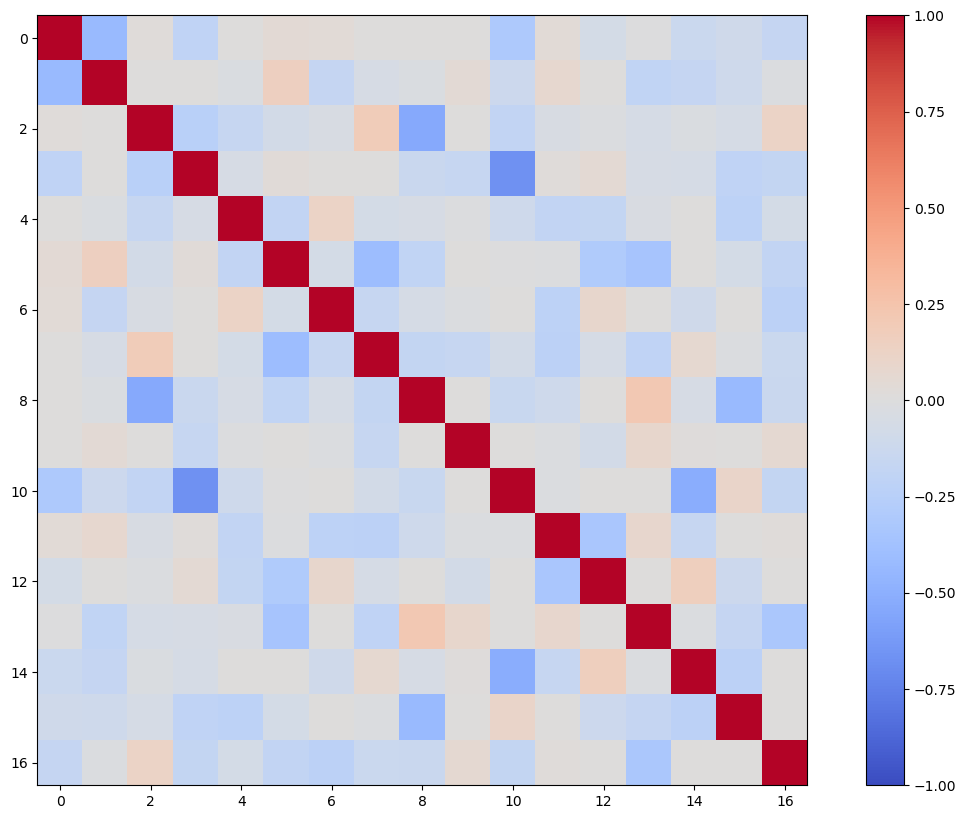

Franja horaria 1
2 0.11097055416485317


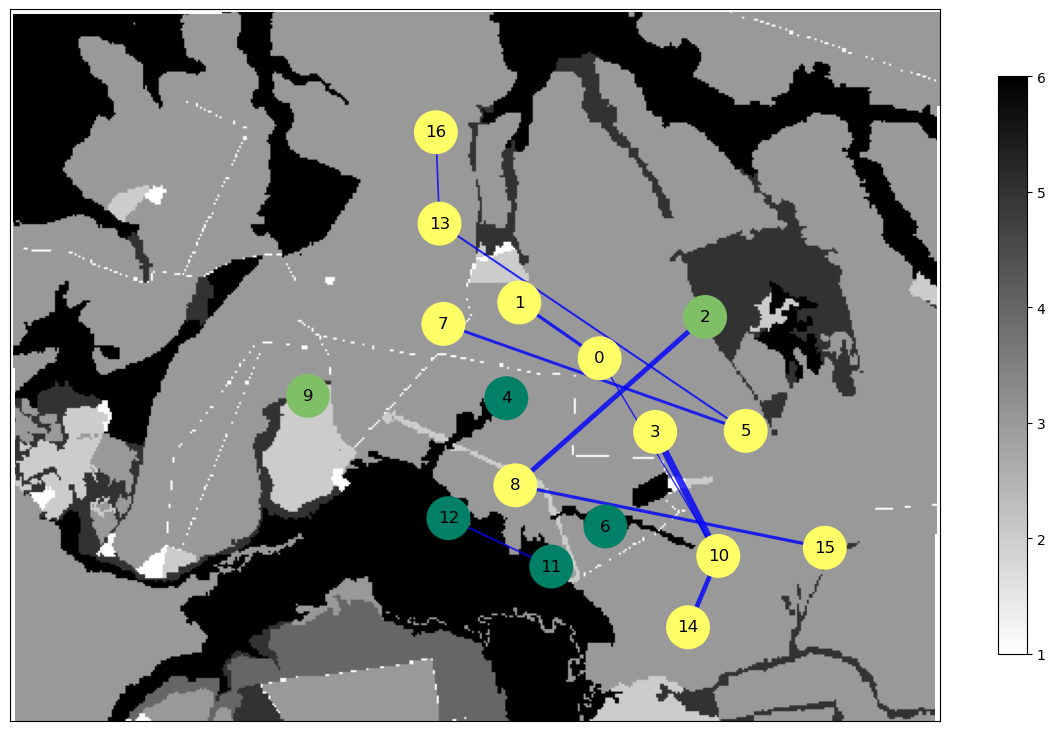

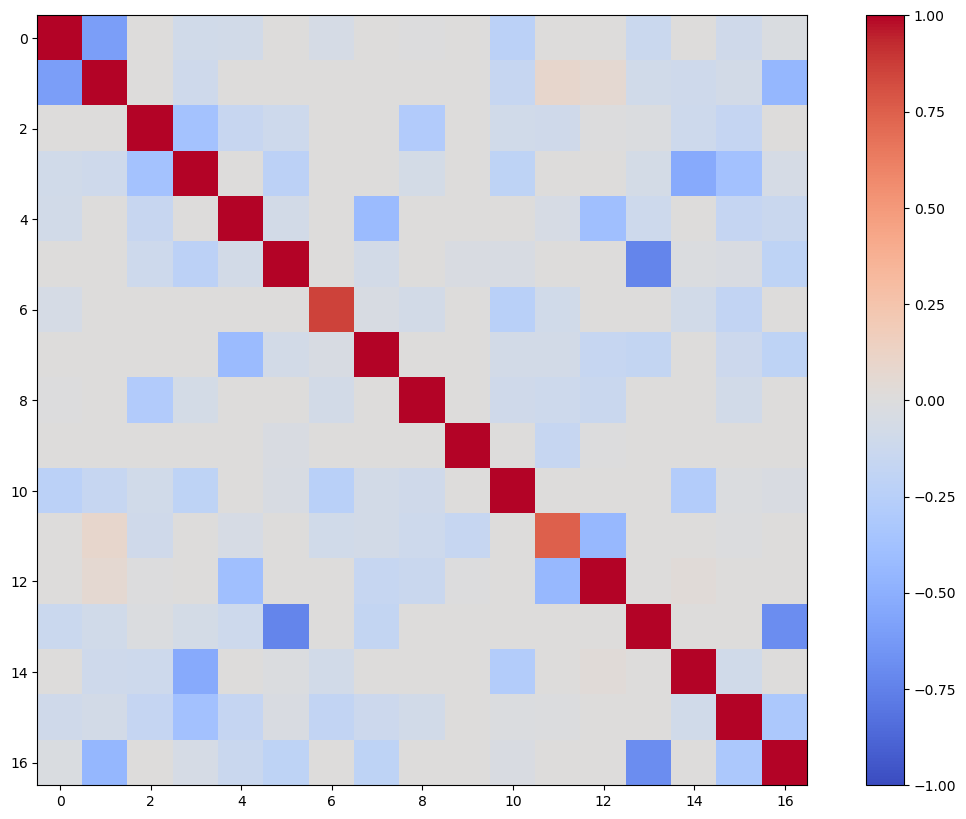

Franja horaria 2
3 0.03013070838470036


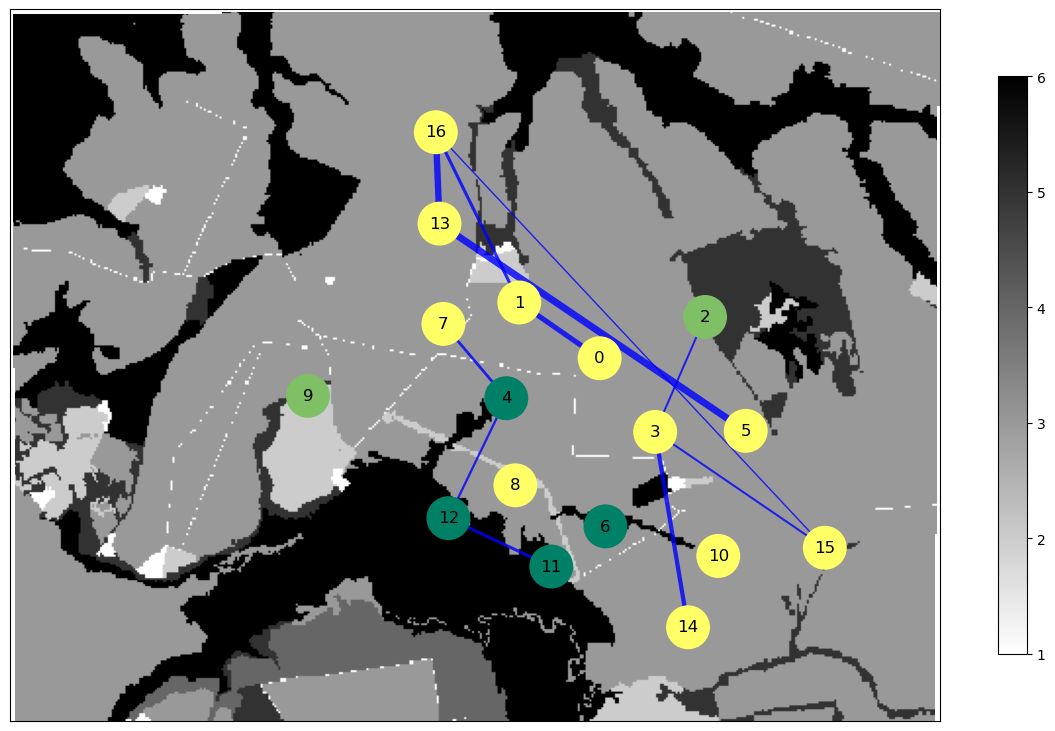

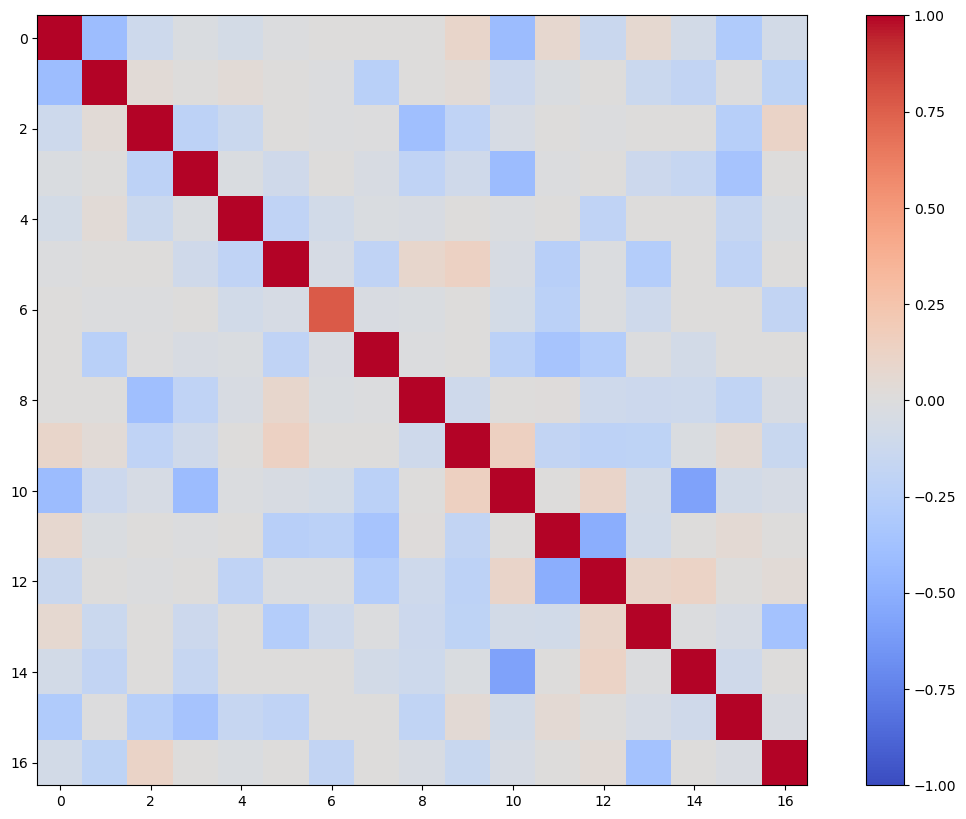

Franja horaria 3
4 0.02746356733608903


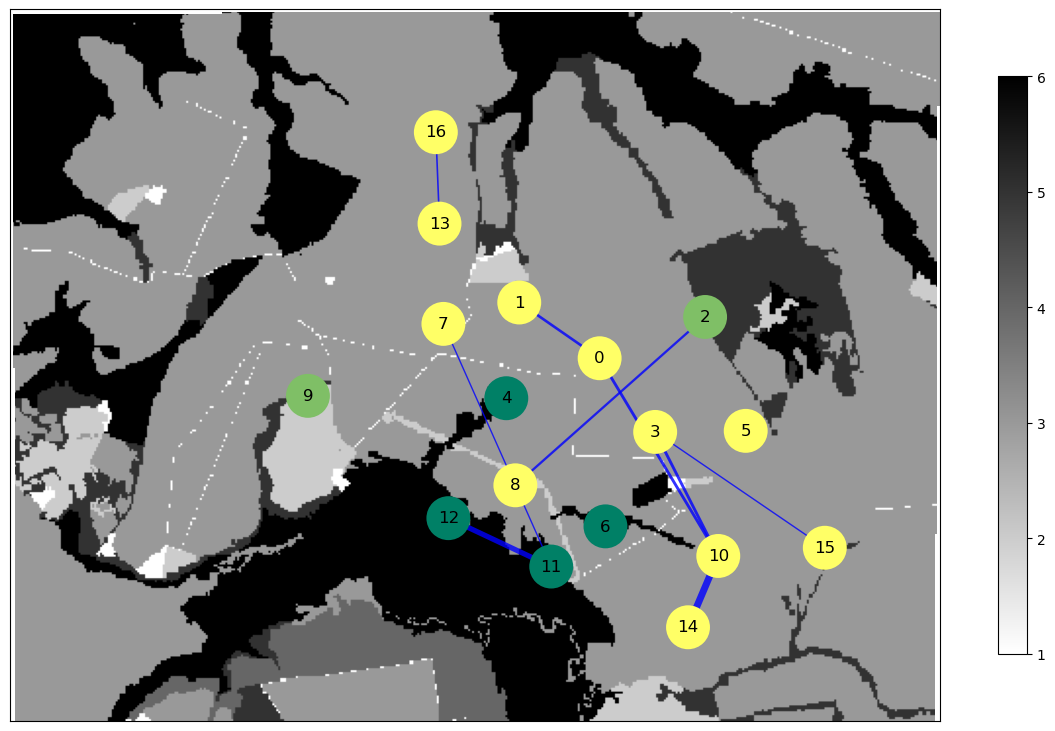

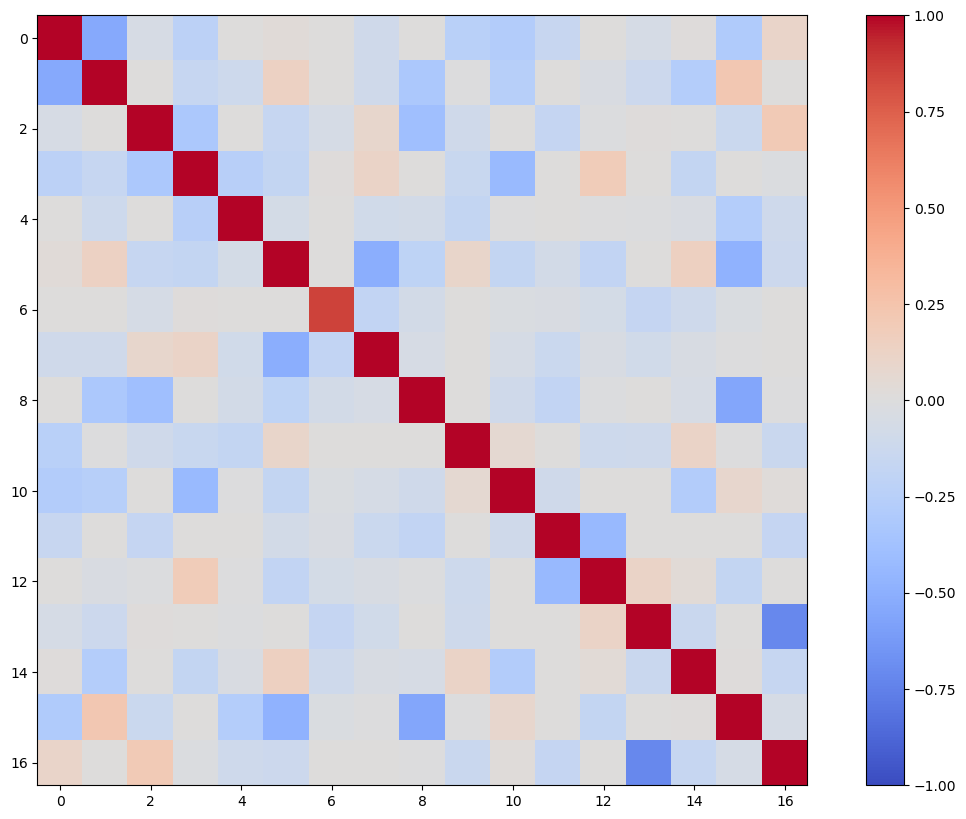

Franja horaria 4
Period 1 - Density: 0.11
Period 1 - Betweenness: {0: 0.04, 1: 0.0, 10: 0.06, 2: 0.0, 8: 0.01, 3: 0.0, 5: 0.03, 7: 0.0, 13: 0.03, 15: 0.0, 14: 0.0, 11: 0.0, 12: 0.0, 16: 0.0}
Period 1 - Closeness: {0: 0.21, 1: 0.14, 10: 0.25, 2: 0.1, 8: 0.15, 3: 0.15, 5: 0.17, 7: 0.12, 13: 0.17, 15: 0.1, 14: 0.15, 11: 0.08, 12: 0.08, 16: 0.12}
Period 1 - Degrees: {0: 2, 1: 1, 10: 3, 2: 1, 8: 2, 3: 1, 5: 2, 7: 1, 13: 2, 15: 1, 14: 1, 11: 1, 12: 1, 16: 1}


Period 2 - Density: 0.14
Period 2 - Betweenness: {0: 0.0, 1: 0.11, 16: 0.3, 2: 0.0, 3: 0.2, 14: 0.0, 15: 0.23, 4: 0.03, 7: 0.0, 12: 0.03, 5: 0.0, 13: 0.11, 11: 0.0}
Period 2 - Closeness: {0: 0.2, 1: 0.27, 16: 0.36, 2: 0.21, 3: 0.28, 14: 0.21, 15: 0.33, 4: 0.19, 7: 0.12, 12: 0.19, 5: 0.2, 13: 0.27, 11: 0.12}
Period 2 - Degrees: {0: 1, 1: 2, 16: 3, 2: 1, 3: 3, 14: 1, 15: 2, 4: 2, 7: 1, 12: 2, 5: 1, 13: 2, 11: 1}


Period 3 - Density: 0.12
Period 3 - Betweenness: {0: 0.06, 1: 0.0, 10: 0.12, 2: 0.0, 8: 0.0, 3: 0.06, 15: 0.0, 7: 0.0, 11: 0.

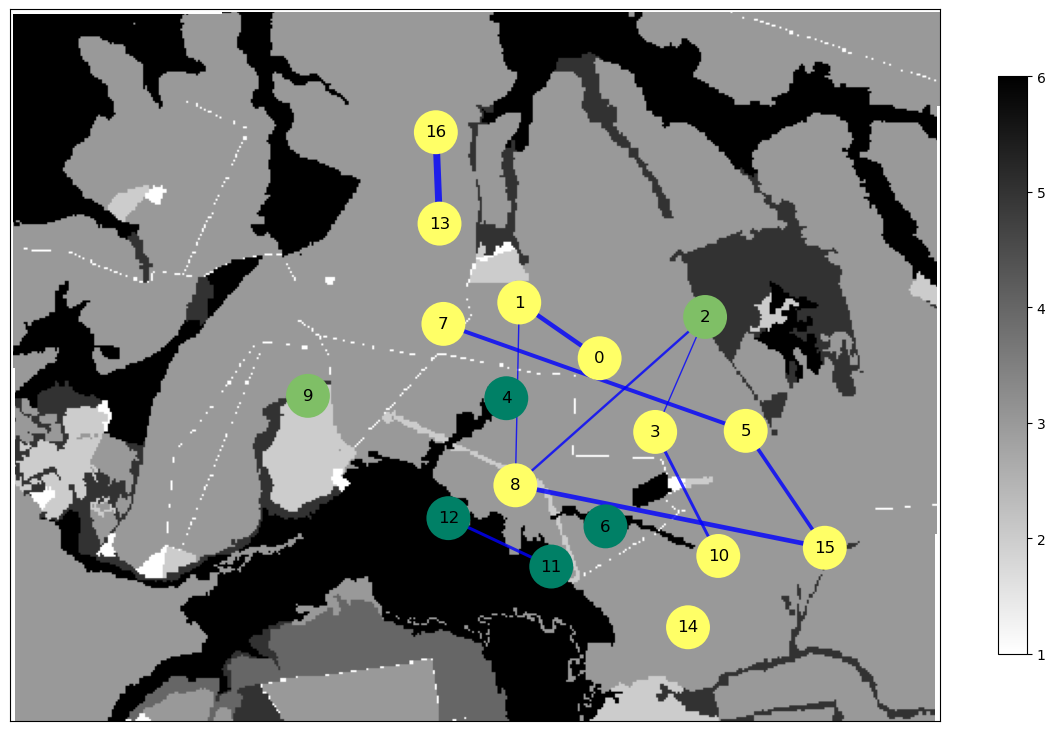

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from osgeo import gdal


# Función para calcular las métricas y agregarlas a los resultados
def calculate_metrics(G, period):
    # Densidad
    density = round(nx.density(G), 2)
    
    # Centralidad de intermediación
    betweenness = {node: round(betw, 2) for node, betw in nx.betweenness_centrality(G).items()}
    
    # Centralidad de cercanía
    closeness = {node: round(close, 2) for node, close in nx.closeness_centrality(G).items()}
    
    # Grados de los nodos
    degrees = dict(G.degree())
    
    # Almacenar resultados
    results[period] = {
        "Density": density,
        "Betweenness": betweenness,
        "Closeness": closeness,
        "Degrees": degrees
    }

# Preparar el almacenamiento de resultados
results = {}

# PLOT DE MAPA USANDO EL TIFF
# Abrir el archivo TIFF
dataset = gdal.Open("/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/información biología/Mapa Python/COBERTURAS_.tif")  # Reemplaza con la ruta correcta
band = dataset.GetRasterBand(1)
array = band.ReadAsArray()

# Reemplazar valores nulos con NaN
array[array == -9999] = np.nan

for i in range(1,5):
    #filename = path + "Matriz_sonotipos_hora_"+ str(i) +".xlsx"
    df = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_out/Analisis_horas/Matriz_f'+ str(i) +".xlsx")
    #Filas zonas, columnas sonotipos del 1 al 358
    df_=df.iloc[:,1:]
   # Eliminar las columnas especificadas
    #df_ = df_.drop(df_.columns[columns_to_remove], axis=1)
    #Normalizo
    df_norm_all = (df_ - df_.min()) / (df_.max() - df_.min())
    #en normalizacion hay datos que quedan NaN, cambio por cero
    df_norm_all.fillna(0, inplace=True)
    #de dataframe a array
    datos=np.array(df_norm_all)
    #print(i,datos.shape) #dataframe original
    #transpongo para graph lasso
    datos2=np.transpose(datos) #filas: sonotipos - Columnas sitios
    #print(i,datos2.shape) #el que uso

    #Calculo graphical lasso
    edge_model = covariance.GraphicalLassoCV(cv=10, max_iter=1000,verbose=False, assume_centered=True)
    datos2 /= datos2.std(axis=0)
    edge_model.fit(datos2)
    print(i, edge_model.alpha_)
    A= np.around(edge_model.covariance_, decimals=3) #covarianza
    A=pd.DataFrame(A)
    #A.to_excel('/content/drive/MyDrive/Rice University work/data/Matrices_resultado/'+ 'covarianza_fanjahoraria' + str(i) + '.xlsx', index=False)
    p = np.around(edge_model.precision_, decimals=3) #matriz de precisión
    p = pd.DataFrame(p)
    #p.to_excel('/content/drive/MyDrive/Rice University work/data/Matrices_resultado/'+ 'precision_franjahoraria' + str(i) + '.xlsx', index=False)

    # Plot the precision matrix as a heatmap
    plt.figure(figsize=(15,10))
    plt.imshow(p, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

    #prepare the matrix for network illustration
    links = p.stack().reset_index()
    links.columns = ['var1', 'var2','value']

    #para plotar todos los nodos
    links2 = p.stack().reset_index()
    links2.columns = ['var1', 'var2','value']

    print('Franja horaria',i)
    
     # Ajustes de visualización del mapa
    fig, ax = plt.subplots(figsize=(15, 15))
    
    img_extent = (dataset.GetGeoTransform()[0],  # min x
                  dataset.GetGeoTransform()[0] + dataset.GetGeoTransform()[1] * dataset.RasterXSize,  # max x
                  dataset.GetGeoTransform()[3] + dataset.GetGeoTransform()[5] * dataset.RasterYSize,  # min y
                  dataset.GetGeoTransform()[3])  # max y

    # Dibujar el mapa
    img_plot = ax.imshow(array, extent=img_extent, cmap='binary')  # Usa un colormap que prefieras

    cbar = plt.colorbar(img_plot, ax=ax, shrink=0.5, aspect=20)

    threshold=0.3
    
    # Filtrar los enlaces según un umbral determinado
    links = links.loc[(abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    # Crear el grafo a partir de los enlaces
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())

    # Obtener todos los nodos en el DataFrame de enlaces
    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()

    # create complete graph with all nodes
    G_complete = nx.complete_graph(all_nodes)

    #posición de los nodos y colores
    coordinates=same_posicion_data(df1)
    coordinates=coordinates[G_complete.nodes]
    colores=df1.Habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    # Crear una lista de los pesos de los enlaces
    edge_weights = [abs(G[u][v]['value']) for u, v in G.edges()]

    # Dibujar los nodos del grafo con tamaño personalizado
    node_size = 1000
    node_color = colores
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}
    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(), node_size=node_size, node_color=node_color,
                          linewidths=node_border_width, edgecolors=node_border_color, cmap="summer_r", ax=ax)
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black', ax=ax)

    # escalar los anchos de los enlaces
    min_width = 1  # ancho mínimo de enlace
    max_width = 5  # ancho máximo de enlace
    #scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo
    scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights]

    # Dibujar los enlaces del grafo con ancho constante y colores personalizados
    nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="blue", alpha=0.8, ax=ax) # se puede ver tambien con colores cambiando edge_color=edge_colors
      #plt.title(f"Threshold = {t}")
   # plt.savefig('/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Paper MEE/Imagenes/franja horaria/Franja_horaria'+ str(i) +'.svg', format='svg') # cambiar nombre

    # Cálculo de métricas
    calculate_metrics(G, f"Period {i}")

# Imprimir resultados
for period, data in results.items():
    print(f"{period} - Density: {data['Density']}")
    print(f"{period} - Betweenness: {data['Betweenness']}")
    print(f"{period} - Closeness: {data['Closeness']}")
    print(f"{period} - Degrees: {data['Degrees']}")
    print("\n")
    


In [27]:
import json

with open('graph_metrics.json', 'r') as f:
    loaded_results = json.load(f)

loaded_results

{'Composite': {'Density': 0.15,
  'Betweenness': {'0': 0.0,
   '1': 0.0,
   '10': 0.33,
   '2': 0.03,
   '3': 0.39,
   '8': 0.03,
   '15': 0.39,
   '5': 0.31,
   '7': 0.23,
   '11': 0.13,
   '14': 0.0,
   '12': 0.0,
   '13': 0.0,
   '16': 0.0},
  'Closeness': {'0': 0.24,
   '1': 0.24,
   '10': 0.32,
   '2': 0.28,
   '3': 0.37,
   '8': 0.28,
   '15': 0.37,
   '5': 0.32,
   '7': 0.27,
   '11': 0.22,
   '14': 0.24,
   '12': 0.18,
   '13': 0.08,
   '16': 0.08},
  'Degrees': {'0': 2,
   '1': 2,
   '10': 4,
   '2': 2,
   '3': 3,
   '8': 2,
   '15': 3,
   '5': 2,
   '7': 2,
   '11': 2,
   '14': 1,
   '12': 1,
   '13': 1,
   '16': 1}}}

In [29]:
print("Densidad del Grafo Combinado:", loaded_results['Composite']['Density'])
for period, data in results.items():
    print(f"Densidad del Grafo {period}: {data['Density']}")
    print(f"Diferencia de Densidad con Combinado: {data['Density'] - loaded_results['Composite']['Density']}")


Densidad del Grafo Combinado: 0.15
Densidad del Grafo Period 1: 0.11
Diferencia de Densidad con Combinado: -0.039999999999999994
Densidad del Grafo Period 2: 0.14
Diferencia de Densidad con Combinado: -0.009999999999999981
Densidad del Grafo Period 3: 0.12
Diferencia de Densidad con Combinado: -0.03
Densidad del Grafo Period 4: 0.13
Diferencia de Densidad con Combinado: -0.01999999999999999


In [30]:
# Comparar centralidad de intermediación
for period, data in results.items():
    print(f"Centralidad de Intermediación para {period}:")
    for node, centrality in data['Betweenness'].items():
        combined_centrality = loaded_results['Composite']['Betweenness'].get(node, 0)
        print(f"  Nodo {node}: {centrality} (Combinado: {combined_centrality})")
        print(f"  Diferencia: {centrality - combined_centrality}")

# Comparar centralidad de cercanía
for period, data in results.items():
    print(f"Centralidad de Cercanía para {period}:")
    for node, centrality in data['Closeness'].items():
        combined_centrality = loaded_results['Composite']['Closeness'].get(node, 0)
        print(f"  Nodo {node}: {centrality} (Combinado: {combined_centrality})")
        print(f"  Diferencia: {centrality - combined_centrality}")


Centralidad de Intermediación para Period 1:
  Nodo 0: 0.04 (Combinado: 0)
  Diferencia: 0.04
  Nodo 1: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 10: 0.06 (Combinado: 0)
  Diferencia: 0.06
  Nodo 2: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 8: 0.01 (Combinado: 0)
  Diferencia: 0.01
  Nodo 3: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 5: 0.03 (Combinado: 0)
  Diferencia: 0.03
  Nodo 7: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 13: 0.03 (Combinado: 0)
  Diferencia: 0.03
  Nodo 15: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 14: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 11: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 12: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 16: 0.0 (Combinado: 0)
  Diferencia: 0.0
Centralidad de Intermediación para Period 2:
  Nodo 0: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 1: 0.11 (Combinado: 0)
  Diferencia: 0.11
  Nodo 16: 0.3 (Combinado: 0)
  Diferencia: 0.3
  Nodo 2: 0.0 (Combinado: 0)
  Diferencia: 0.0
  Nodo 3: 0.2 (Combinado: 0)
  Diferencia: 0

In [31]:
# Comparar grados de los nodos
for period, data in results.items():
    print(f"Grados para {period}:")
    for node, degree in data['Degrees'].items():
        combined_degree = loaded_results['Composite']['Degrees'].get(node, 0)
        print(f"  Nodo {node}: {degree} (Combinado: {combined_degree})")
        print(f"  Diferencia: {degree - combined_degree}")


Grados para Period 1:
  Nodo 0: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 1: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 10: 3 (Combinado: 0)
  Diferencia: 3
  Nodo 2: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 8: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 3: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 5: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 7: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 13: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 15: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 14: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 11: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 12: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 16: 1 (Combinado: 0)
  Diferencia: 1
Grados para Period 2:
  Nodo 0: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 1: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 16: 3 (Combinado: 0)
  Diferencia: 3
  Nodo 2: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 3: 3 (Combinado: 0)
  Diferencia: 3
  Nodo 14: 1 (Combinado: 0)
  Diferencia: 1
  Nodo 15: 2 (Combinado: 0)
  Diferencia: 2
  Nodo 4: 2 (Combinado: 0)
  Diferencia: 2


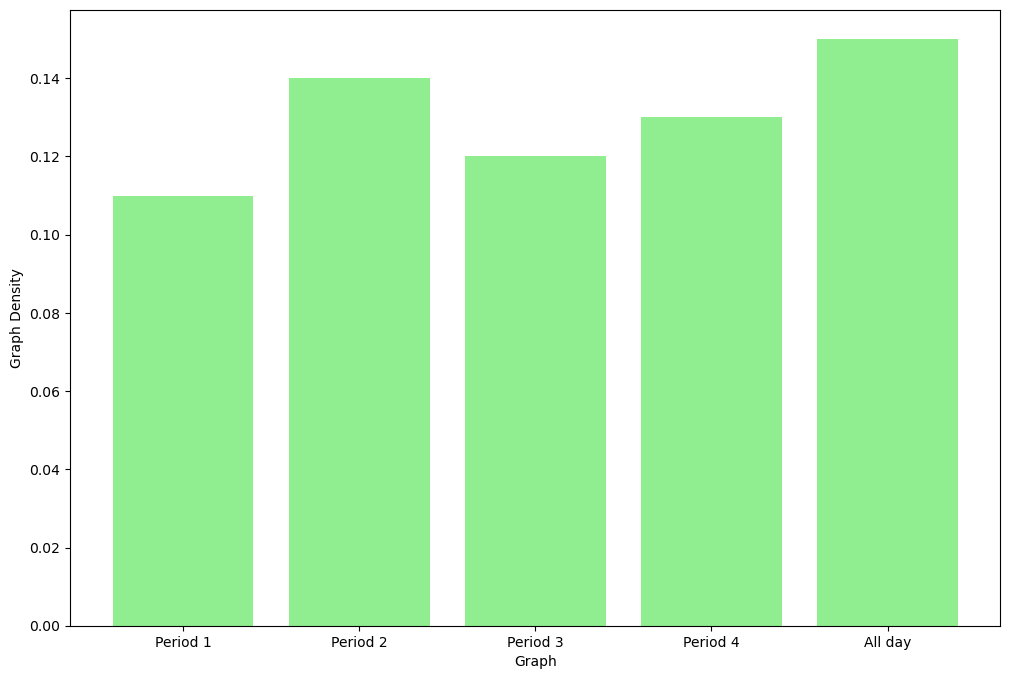

In [55]:
import matplotlib.pyplot as plt

# Lista de periodos, asumiendo que están en una variable llamada 'results'
periods = list(results.keys())  # Lista de periodos (horas)
densities = [results[period]['Density'] for period in periods]

# Añadir la densidad del grafo combinado
combined_density = loaded_results['Composite']['Density']
periods.append('All day')  # Añadir etiqueta para el grafo combinado
densities.append(combined_density)  # Añadir la densidad para el grafo combinado

plt.figure(figsize=(12, 8))
plt.bar(periods, densities, color='green')
plt.xlabel('Graph')
plt.ylabel('Graph Density')
#plt.title('Comparación de la Densidad de la Red en Diferentes Periodos y en el Grafo Combinado')
#plt.savefig('density.svg', format='svg') # cambiar nombre
plt.show()


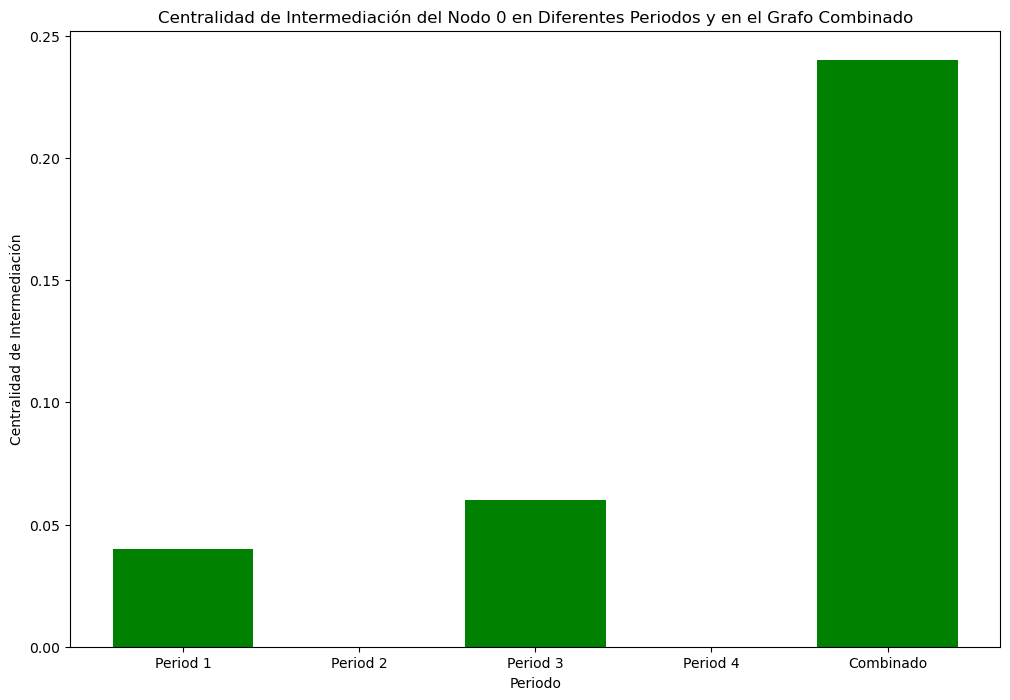

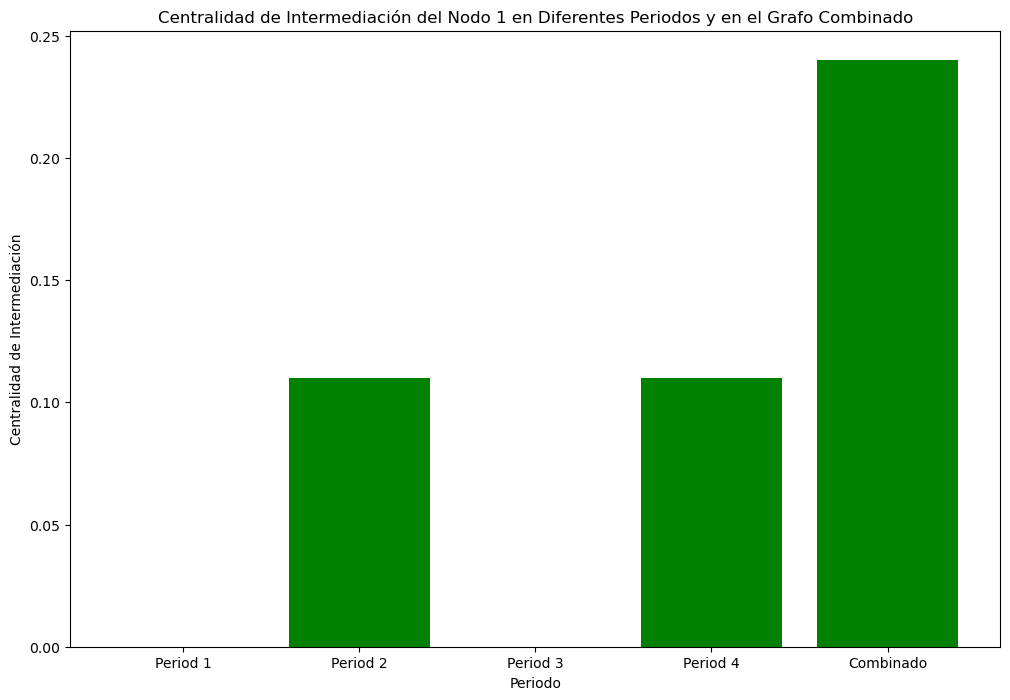

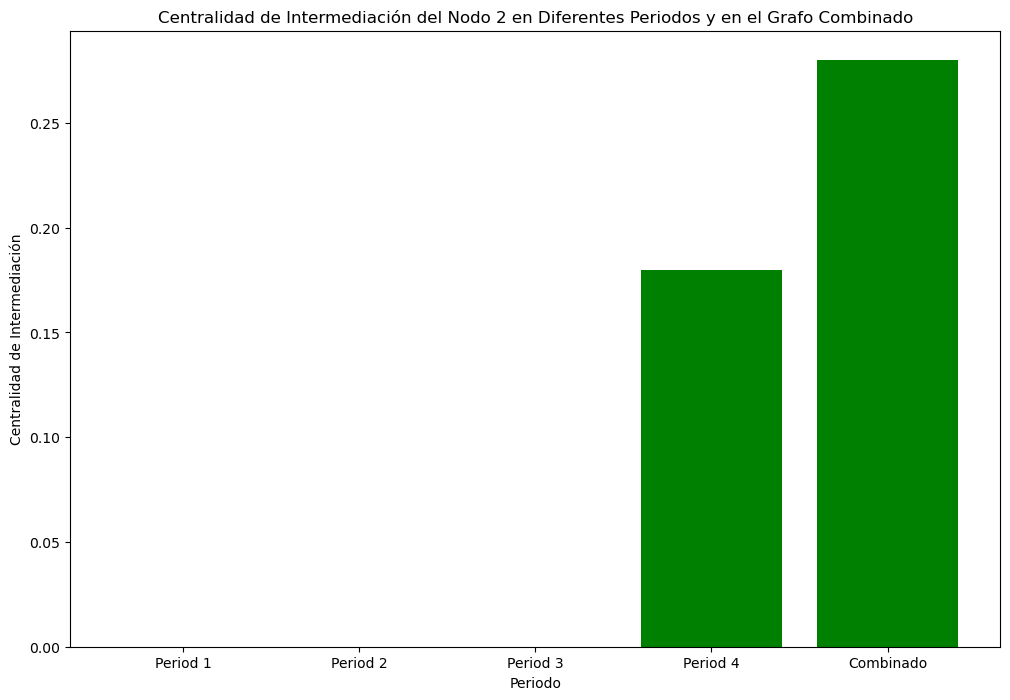

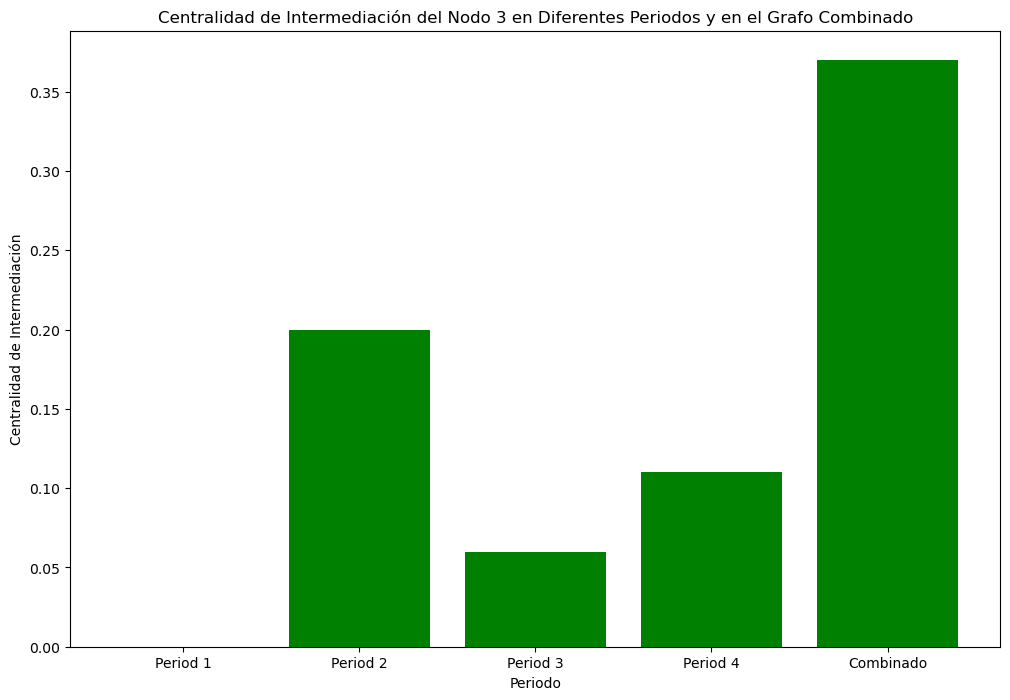

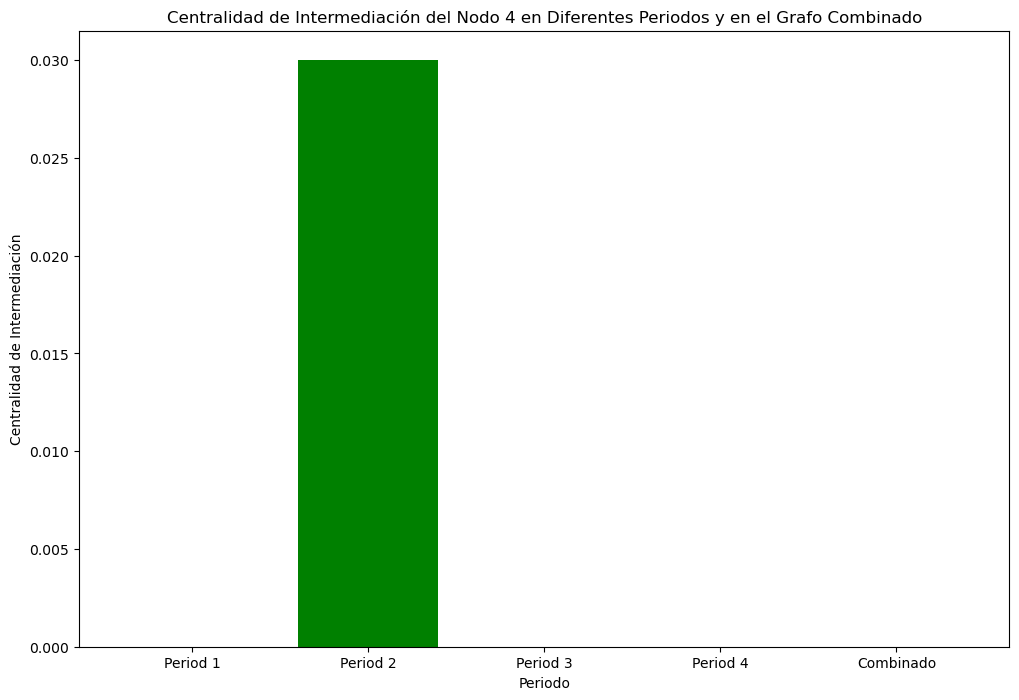

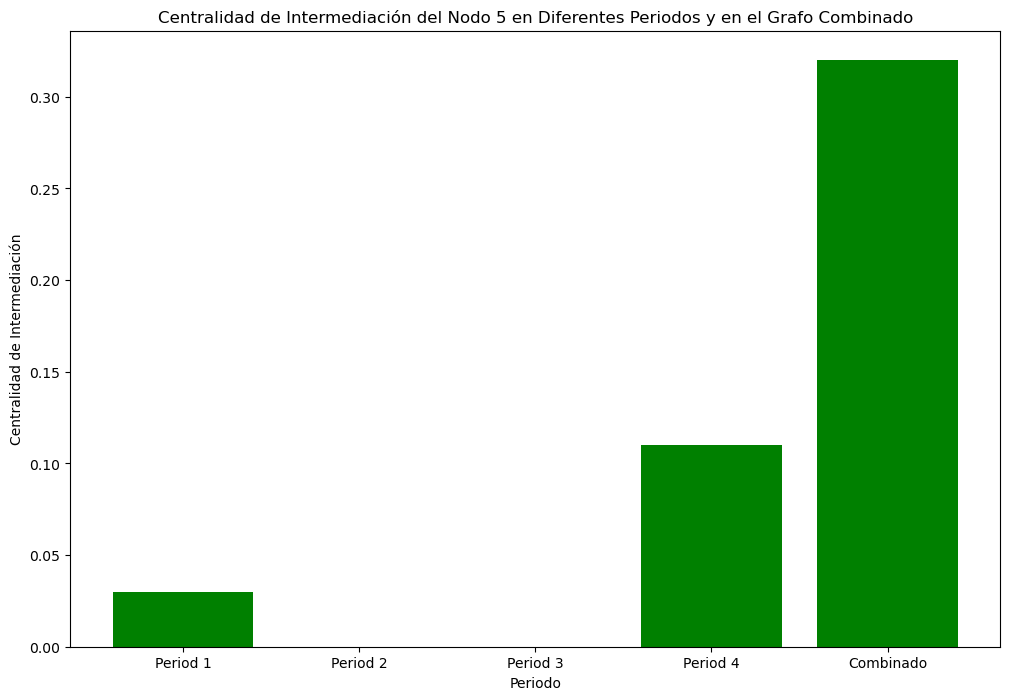

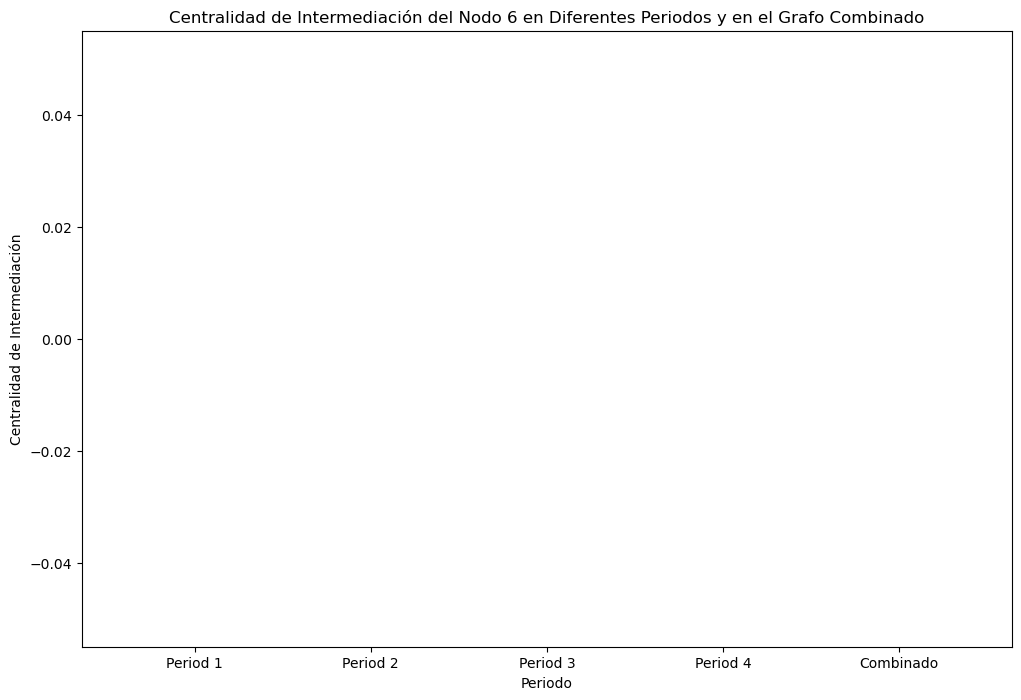

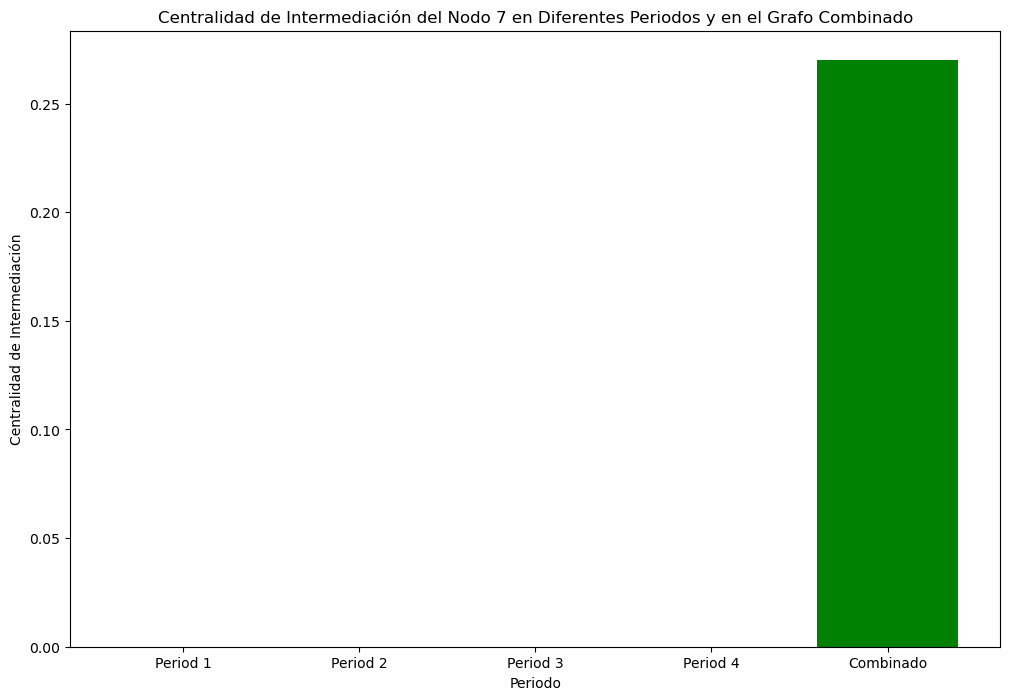

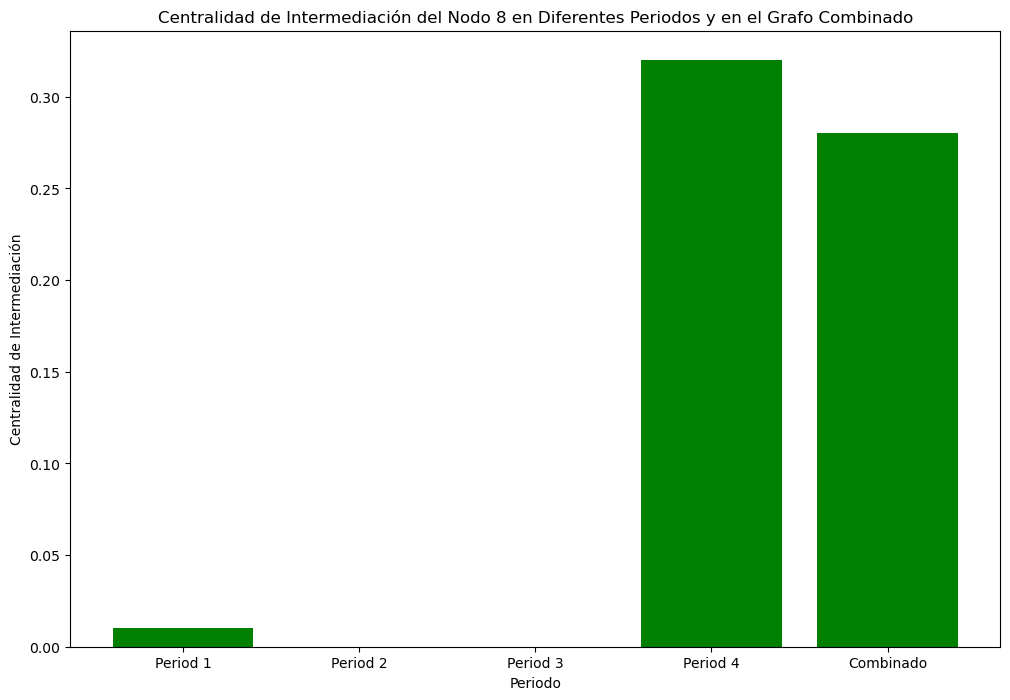

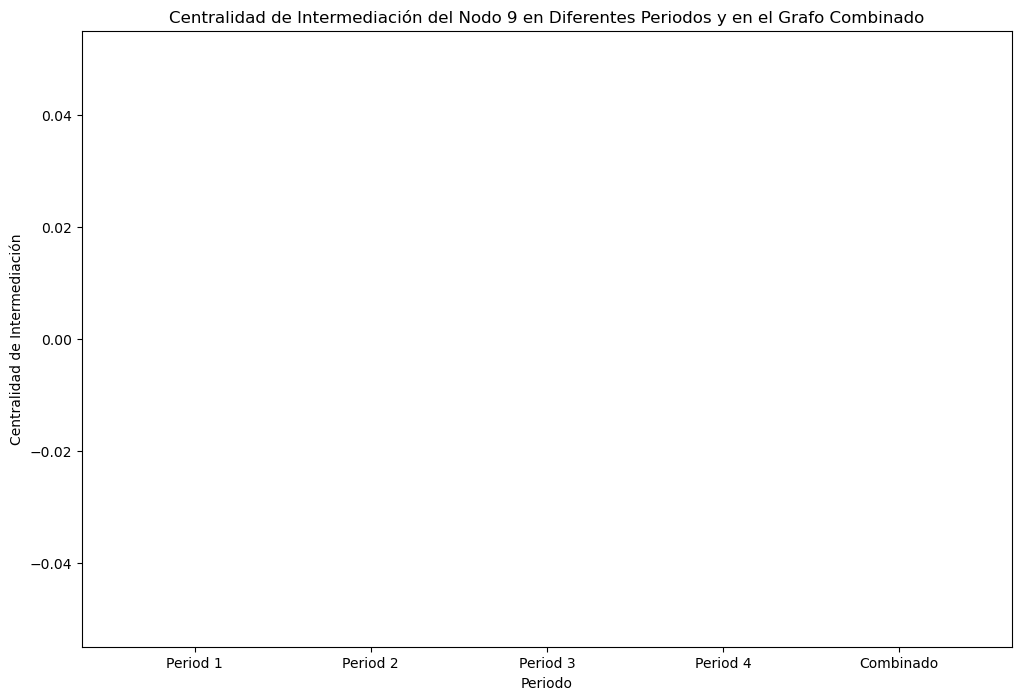

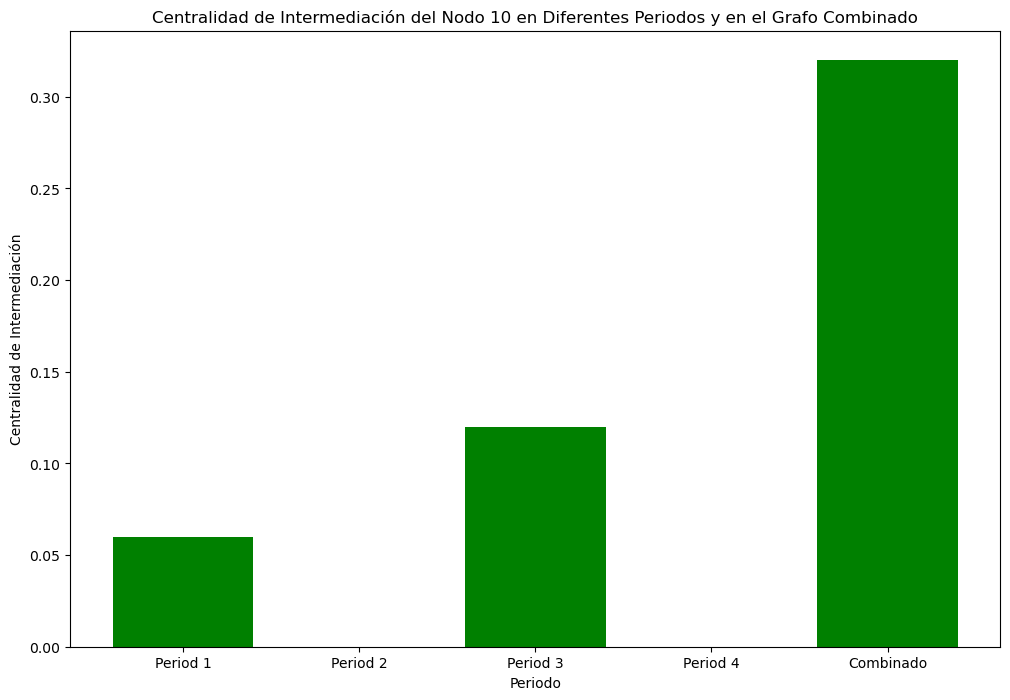

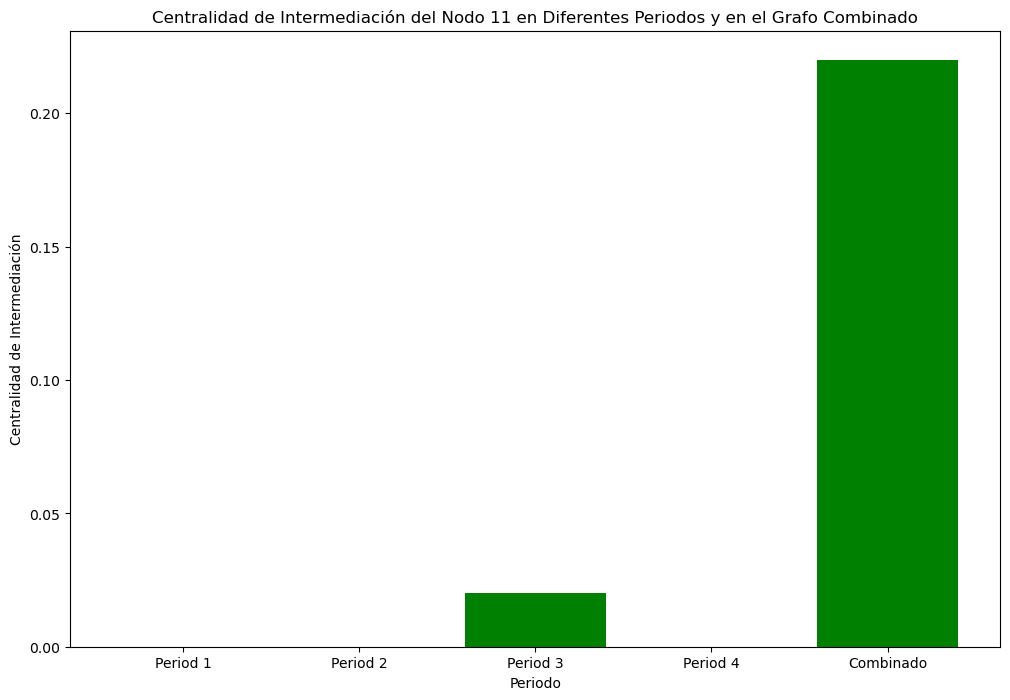

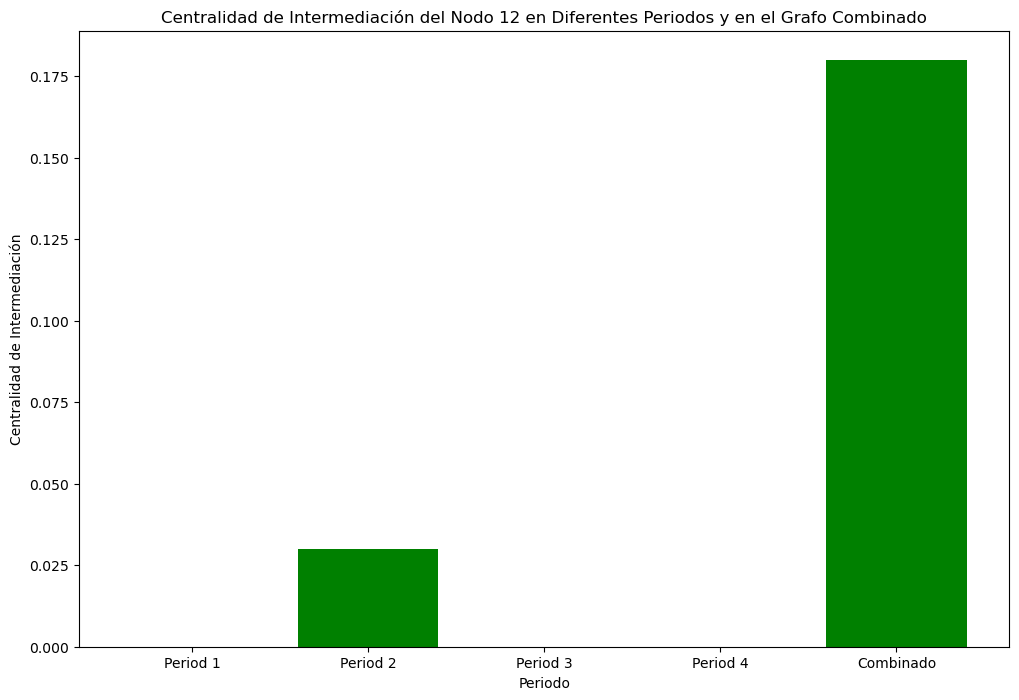

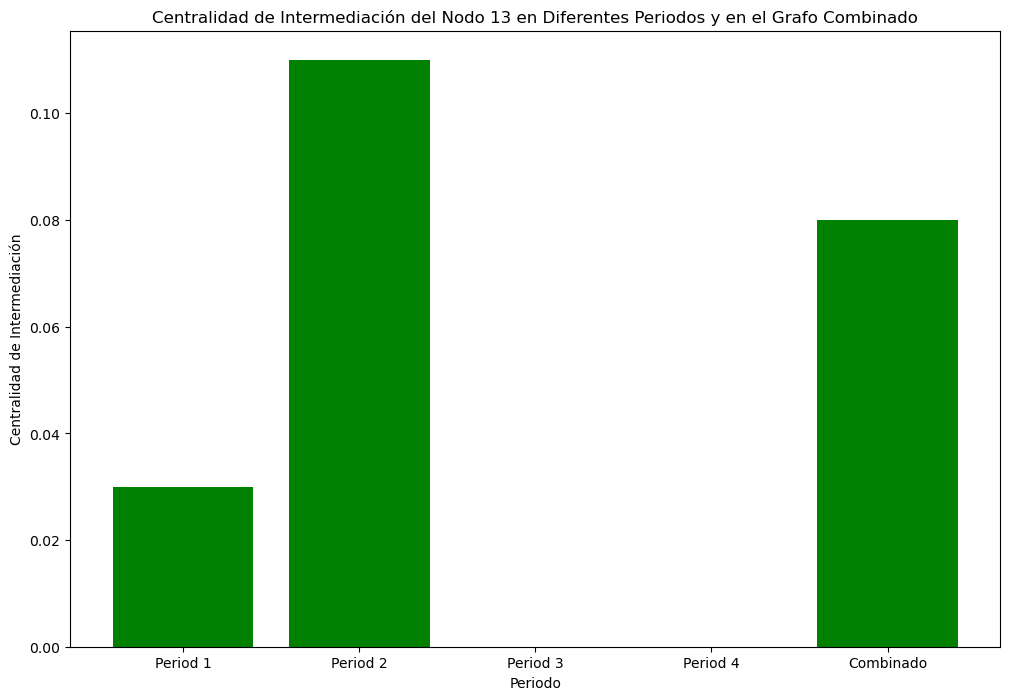

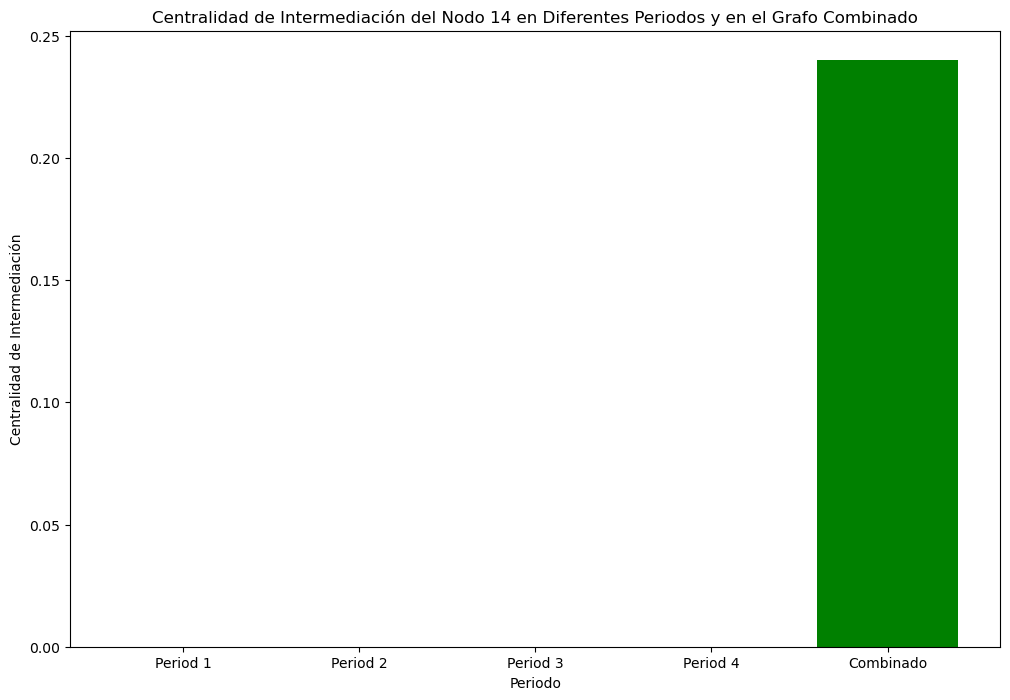

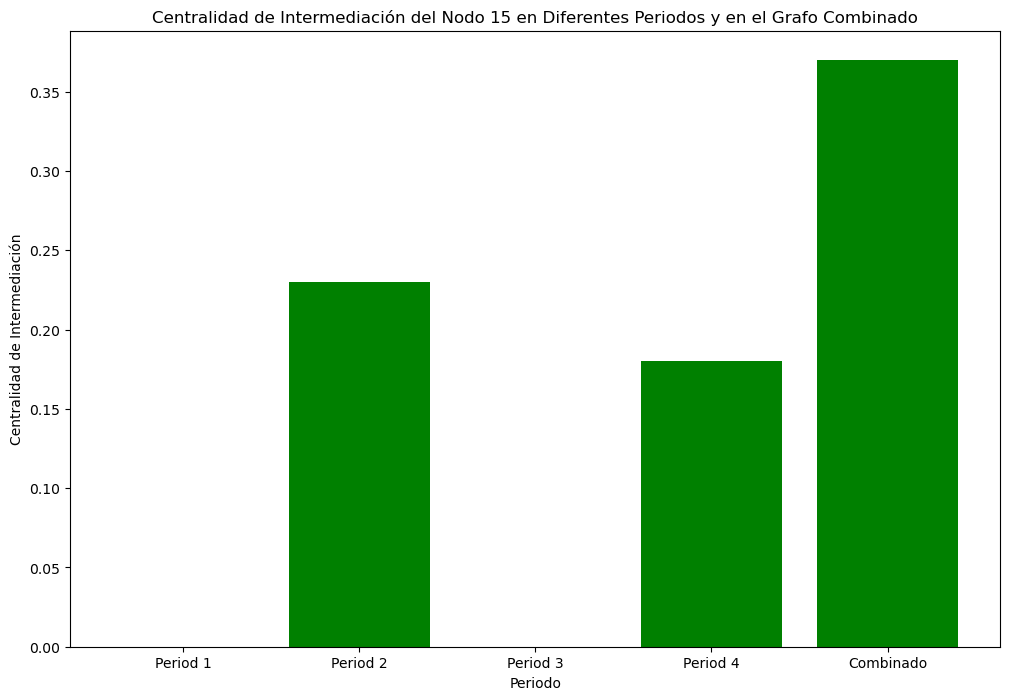

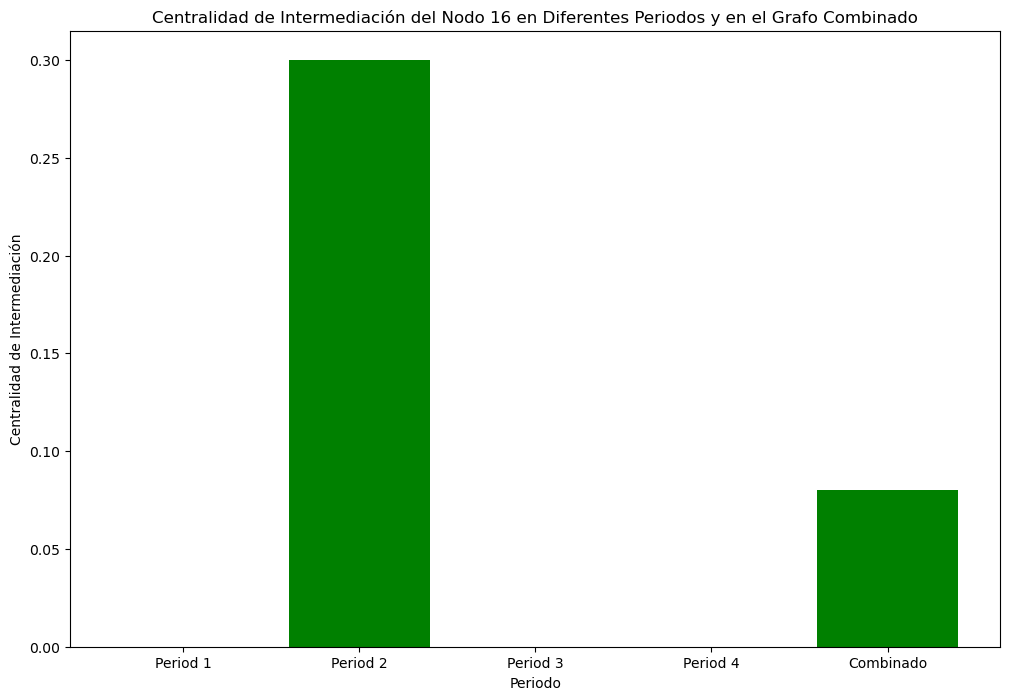

In [46]:
# Convertir todas las claves a enteros en los datos del grafo combinado
loaded_results['Composite']['Betweenness'] = {int(k): v for k, v in loaded_results['Composite']['Betweenness'].items()}

# Recalcular total_nodos considerando que ahora todas las claves son enteros
total_nodos = max(max(period_data['Betweenness'].keys()) for period_data in results.values())
total_nodos = max(total_nodos, max(loaded_results['Composite']['Betweenness'].keys())) + 1

for node_id in range(total_nodos):
    periods = list(results.keys())  # Lista de periodos (horas)
    closeness_values = [results[period]['Betweenness'].get(node_id, 0) for period in periods]

    # Añadir la centralidad de cercanía del nodo en el grafo combinado
    combined_closeness = loaded_results['Composite']['Betweenness'].get(node_id, 0)
    periods.append('Combinado')  # Añadir etiqueta para el grafo combinado
    closeness_values.append(combined_closeness)  # Añadir el valor de closeness para el grafo combinado

    plt.figure(figsize=(12, 8))
    plt.bar(periods, closeness_values, color='Green')
    plt.xlabel('Periodo')
    plt.ylabel('Centralidad de Intermediación')
    plt.title(f'Centralidad de Intermediación del Nodo {node_id} en Diferentes Periodos y en el Grafo Combinado')
    plt.show()

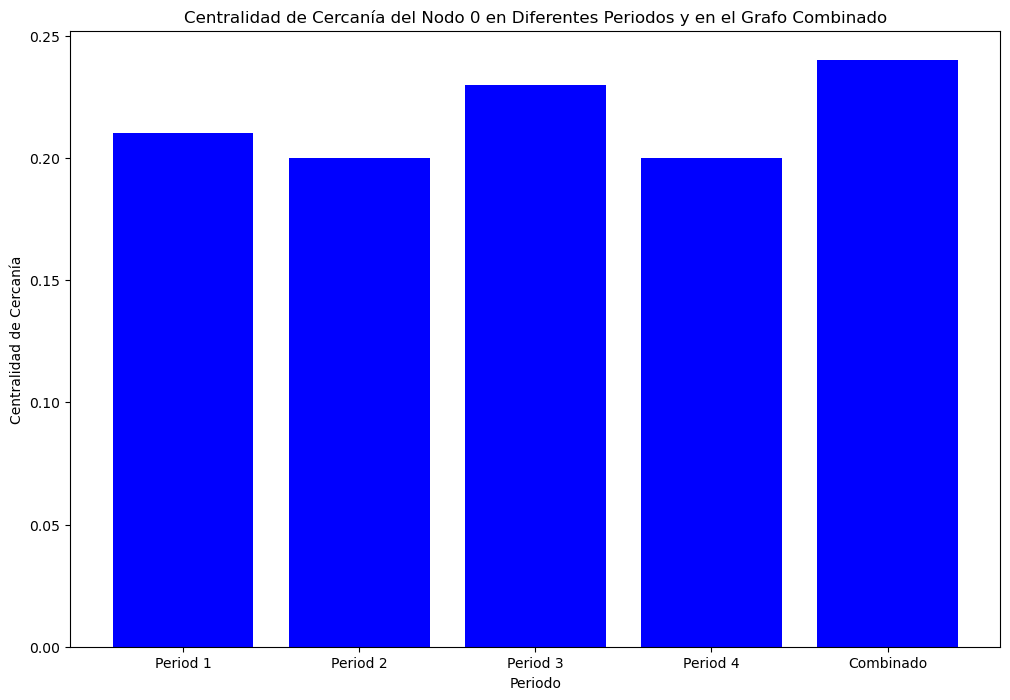

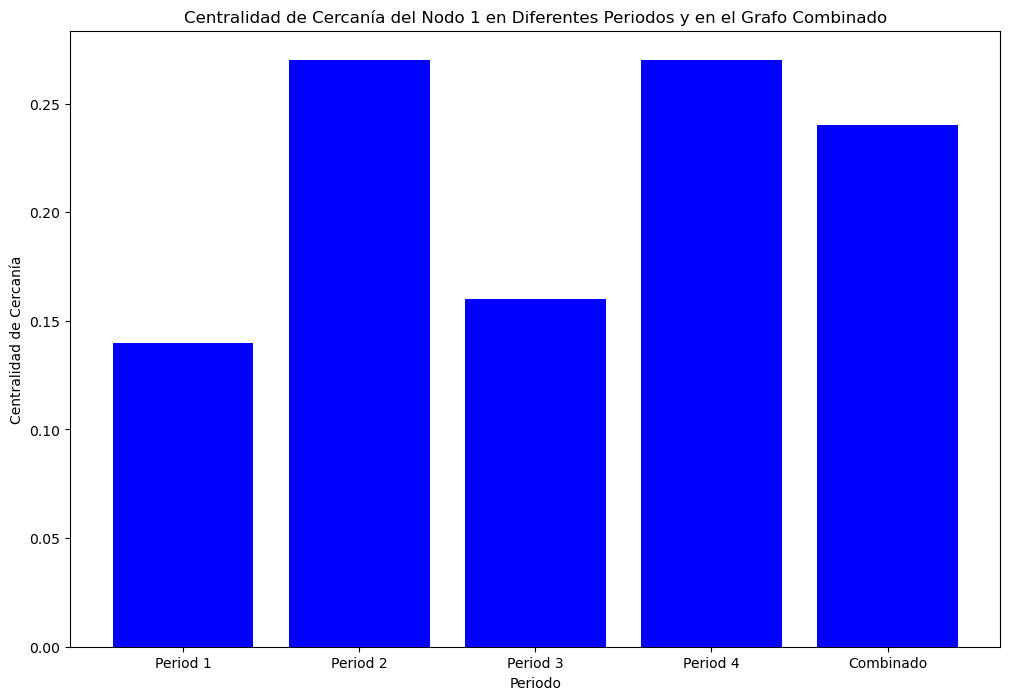

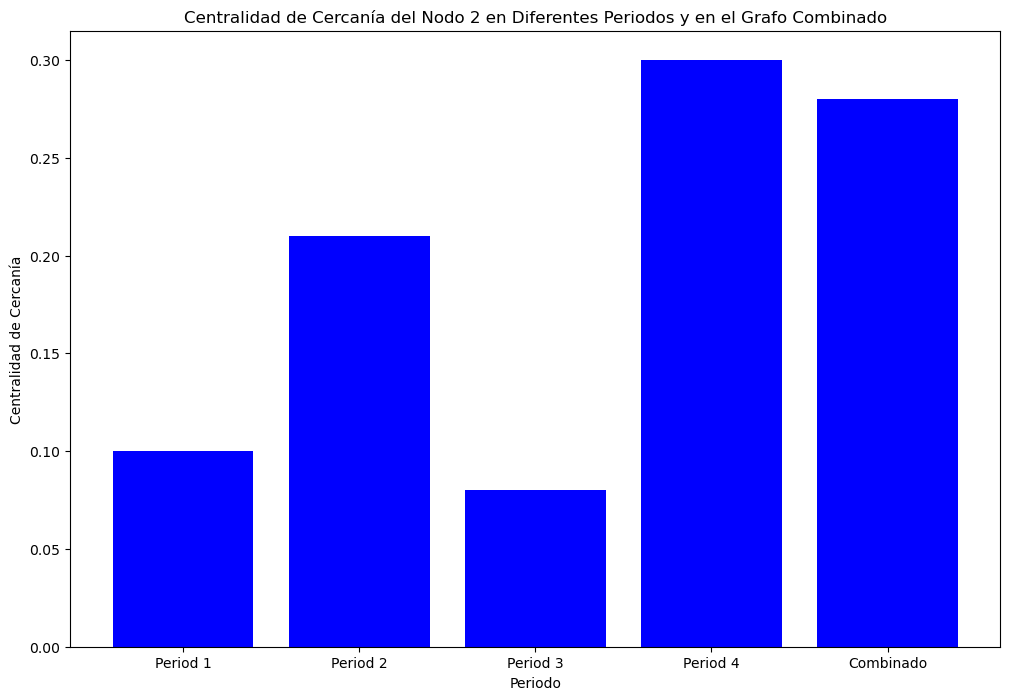

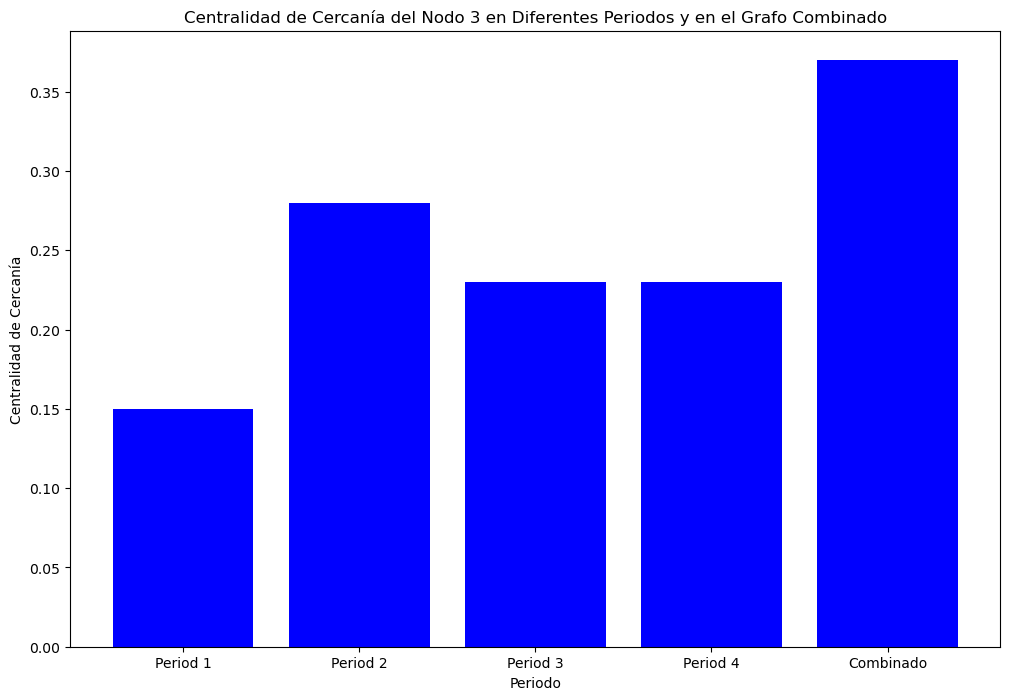

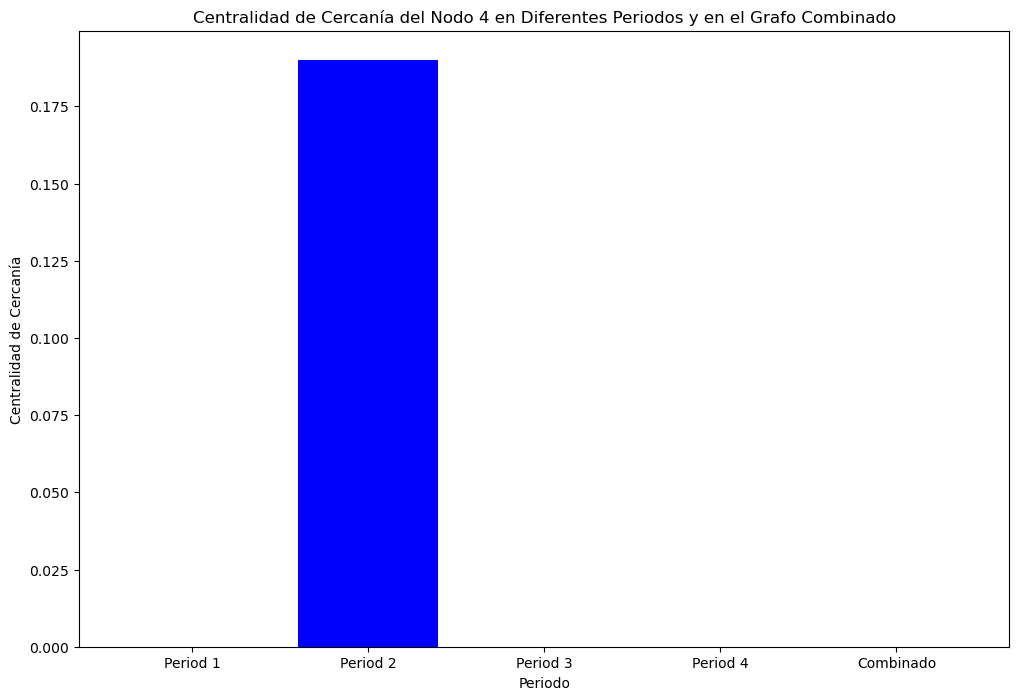

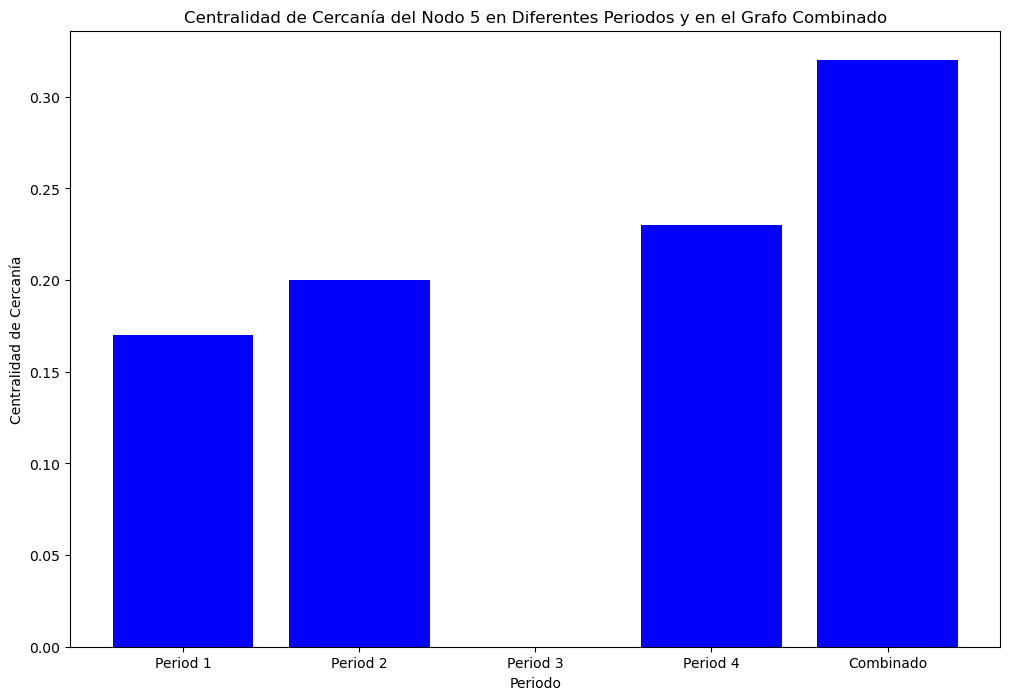

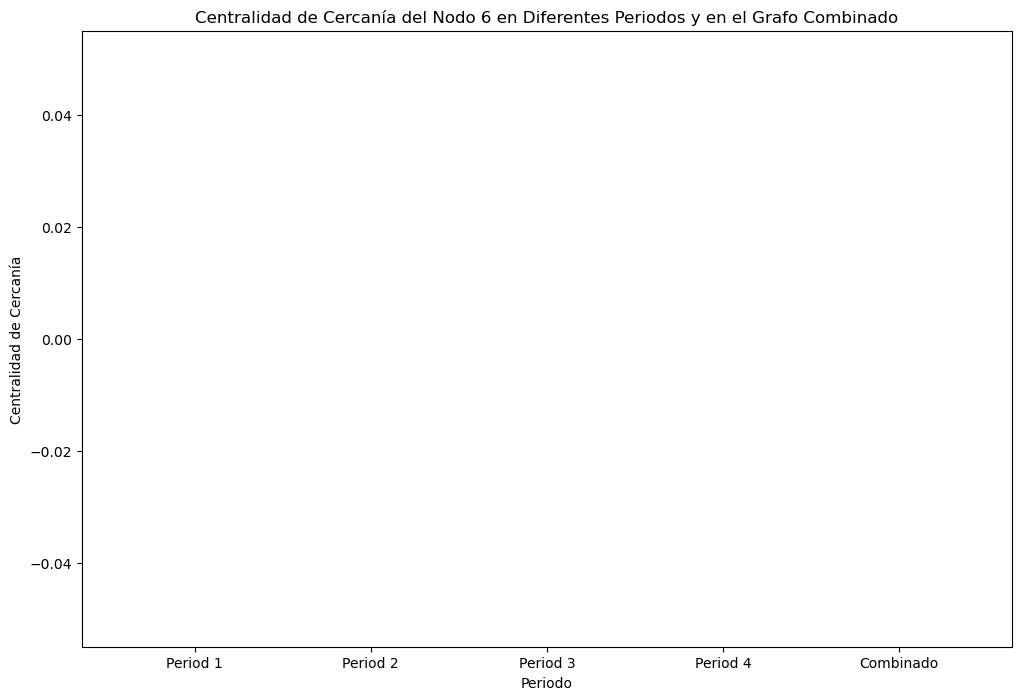

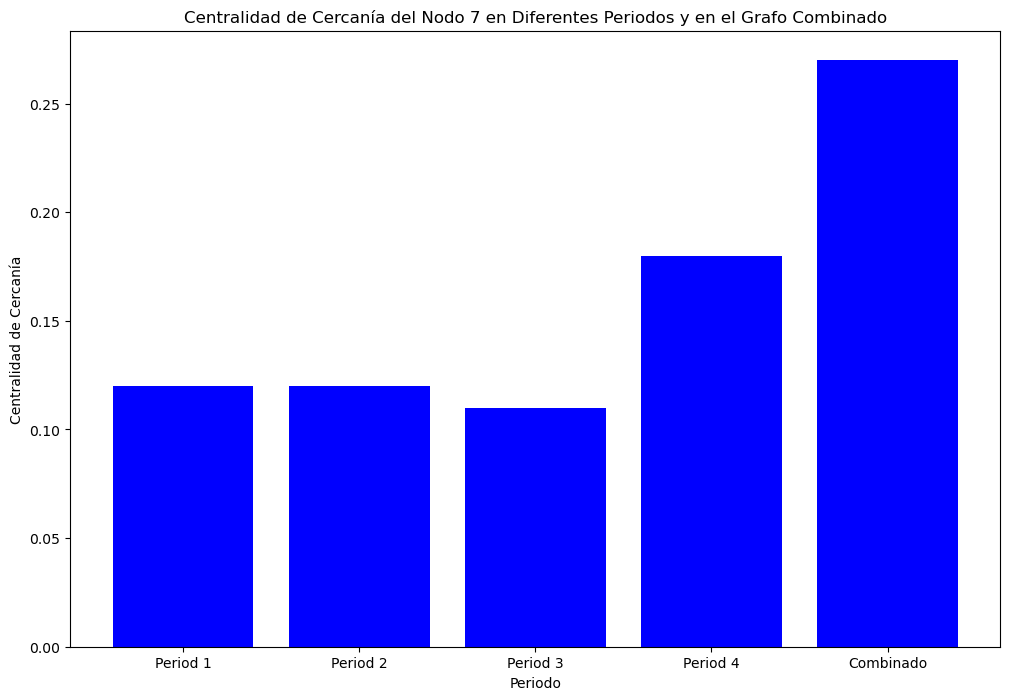

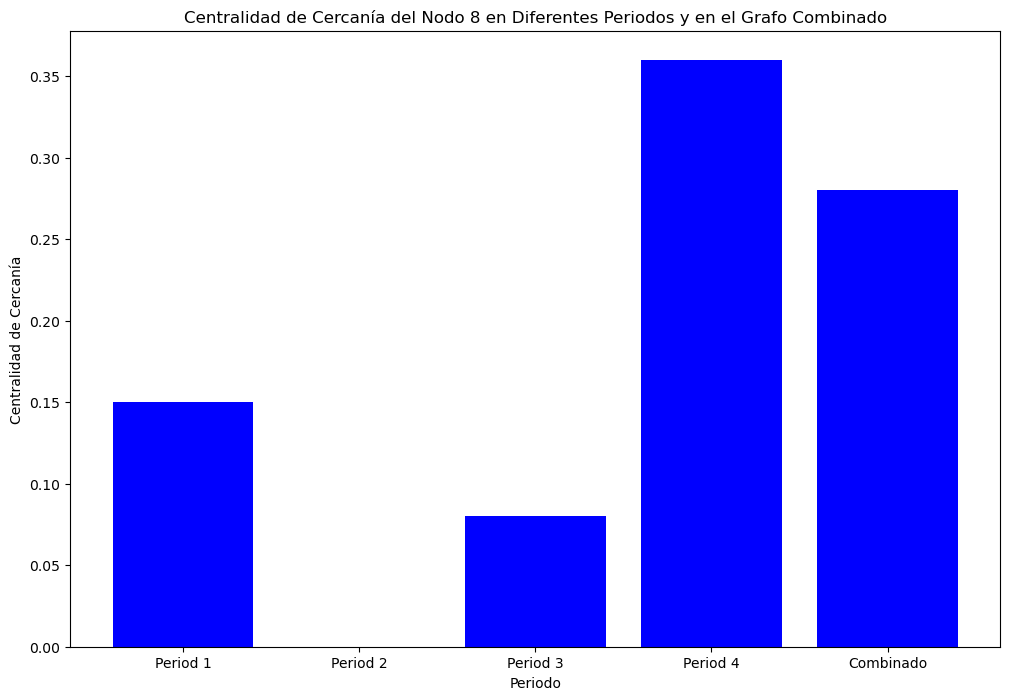

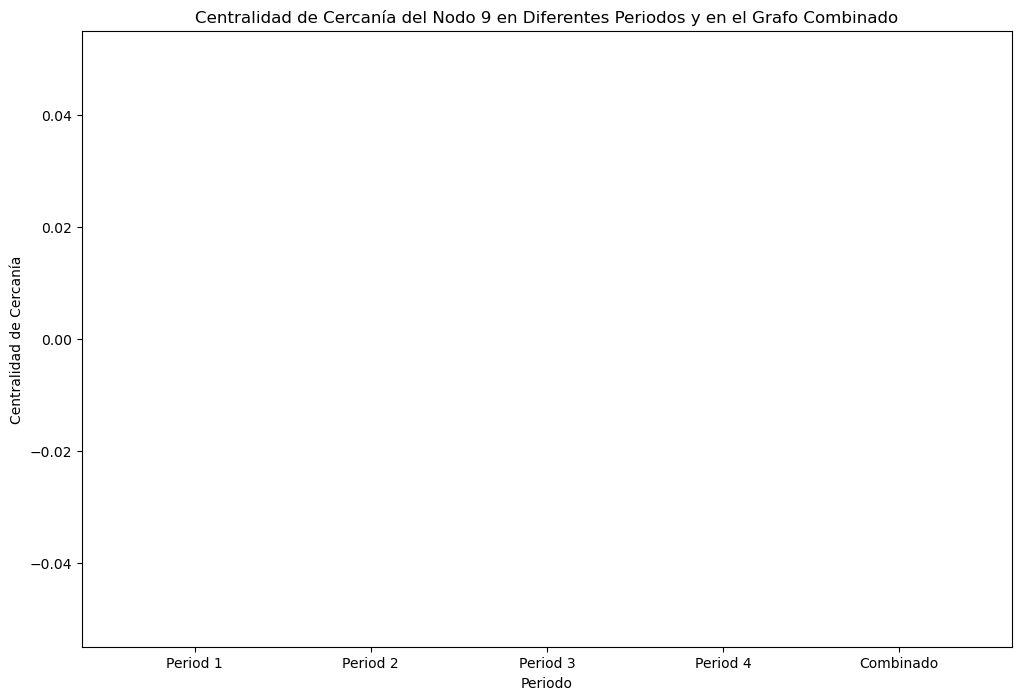

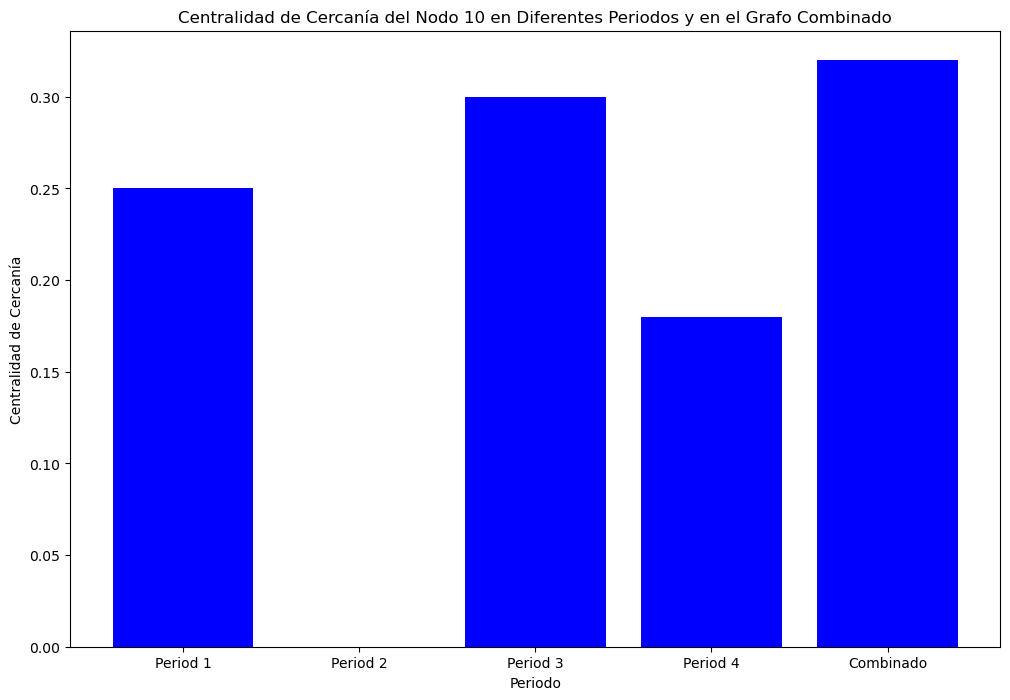

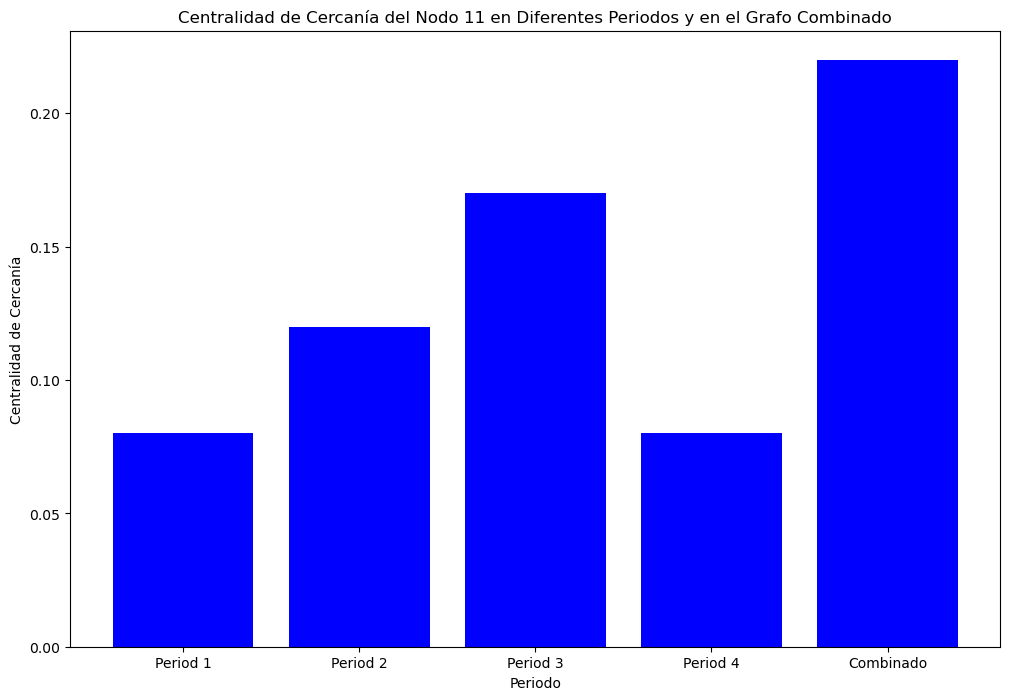

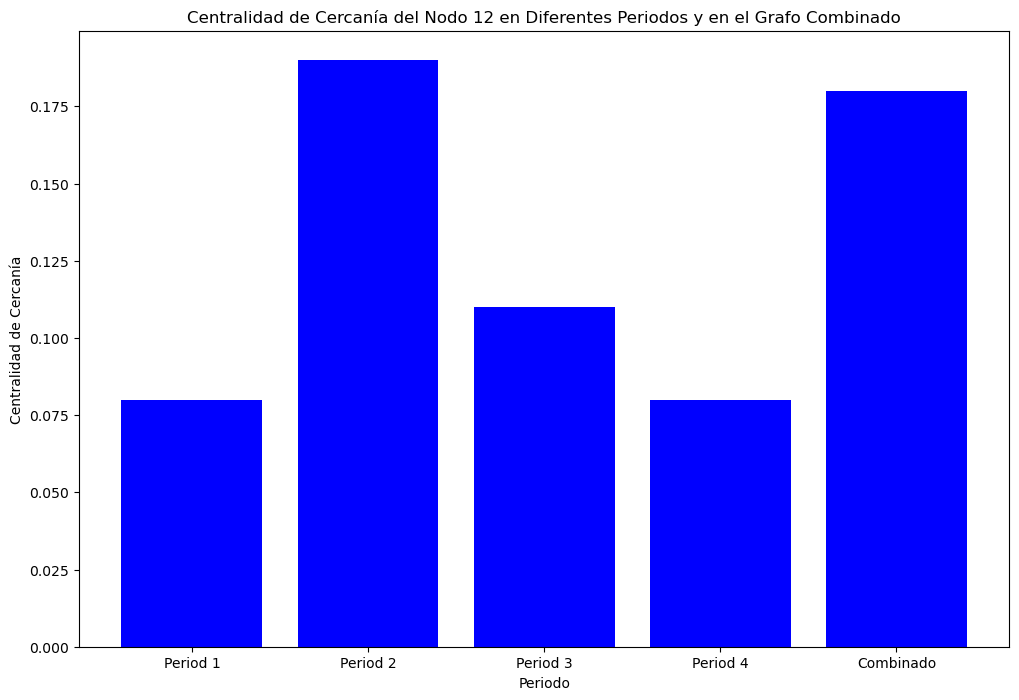

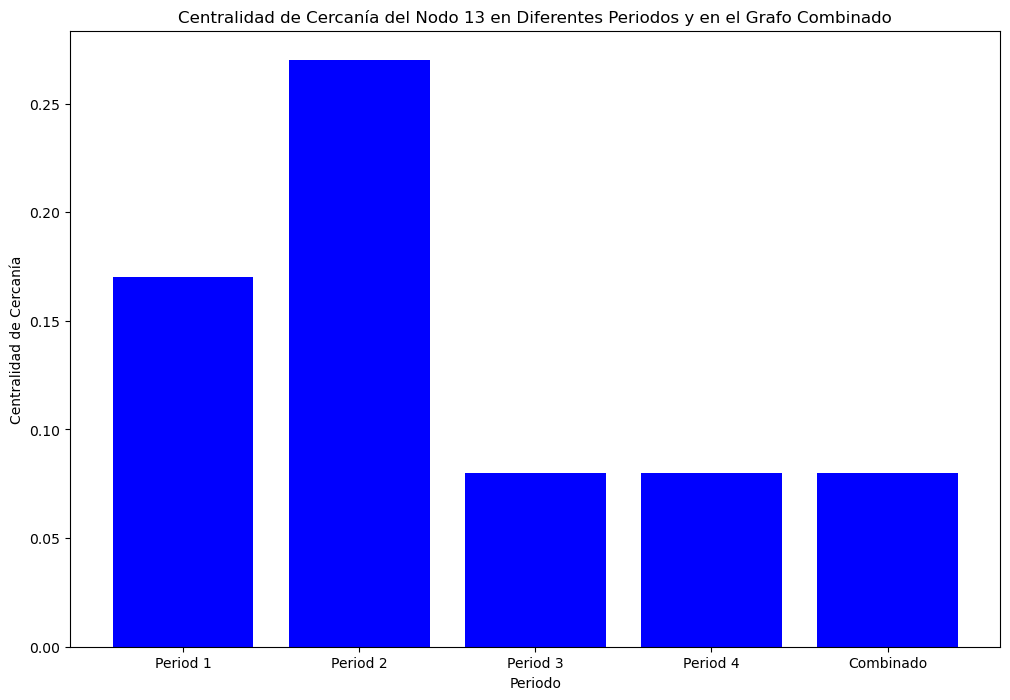

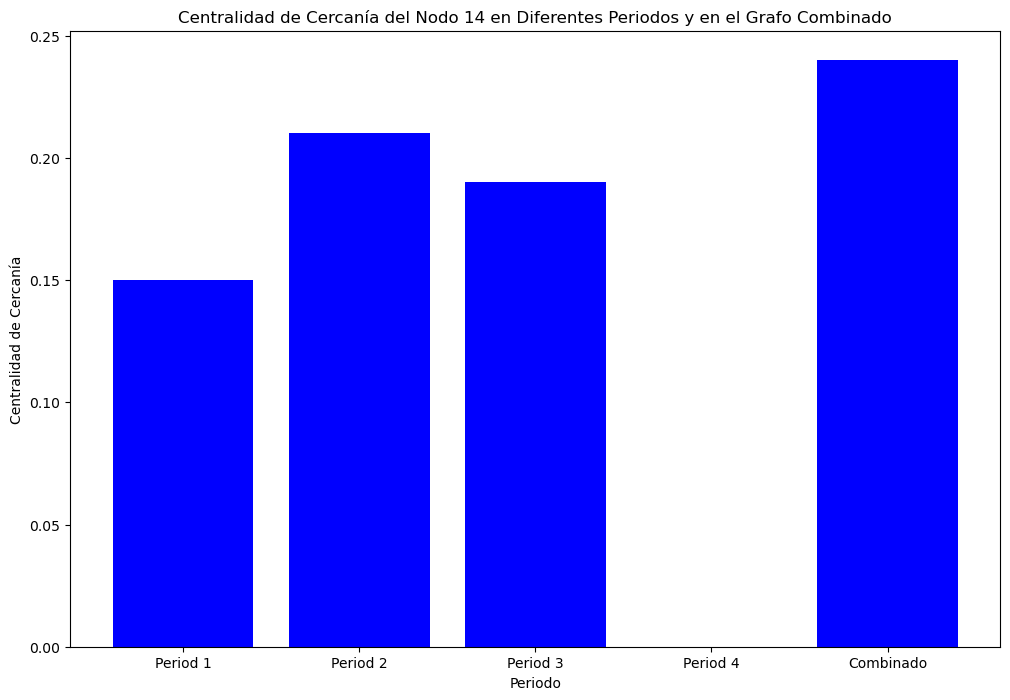

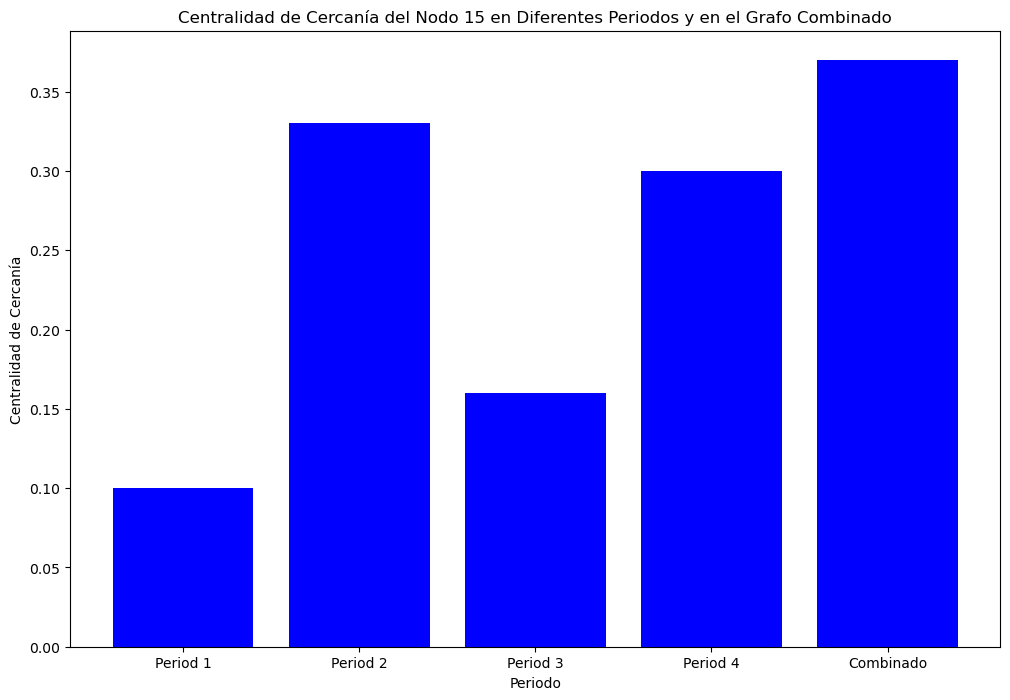

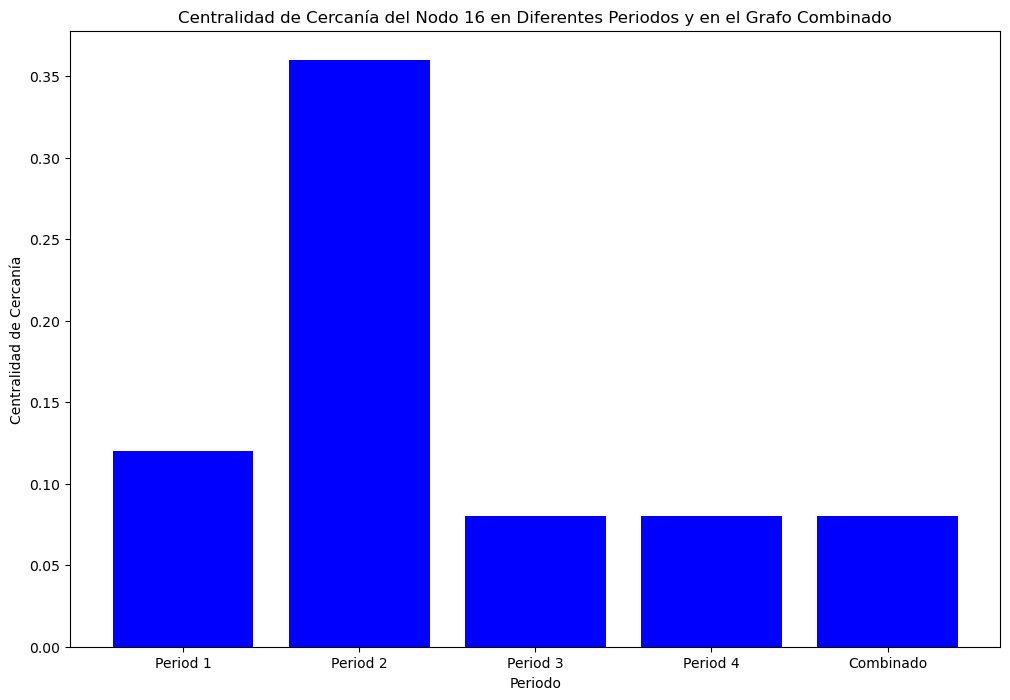

In [43]:
# Convertir todas las claves a enteros en los datos del grafo combinado
loaded_results['Composite']['Closeness'] = {int(k): v for k, v in loaded_results['Composite']['Closeness'].items()}

# Recalcular total_nodos considerando que ahora todas las claves son enteros
total_nodos = max(max(period_data['Closeness'].keys()) for period_data in results.values())
total_nodos = max(total_nodos, max(loaded_results['Composite']['Closeness'].keys())) + 1

for node_id in range(total_nodos):
    periods = list(results.keys())  # Lista de periodos (horas)
    closeness_values = [results[period]['Closeness'].get(node_id, 0) for period in periods]

    # Añadir la centralidad de cercanía del nodo en el grafo combinado
    combined_closeness = loaded_results['Composite']['Closeness'].get(node_id, 0)
    periods.append('Combinado')  # Añadir etiqueta para el grafo combinado
    closeness_values.append(combined_closeness)  # Añadir el valor de closeness para el grafo combinado

    plt.figure(figsize=(12, 8))
    plt.bar(periods, closeness_values, color='blue')
    plt.xlabel('Periodo')
    plt.ylabel('Centralidad de Cercanía')
    plt.title(f'Centralidad de Cercanía del Nodo {node_id} en Diferentes Periodos y en el Grafo Combinado')
    plt.show()


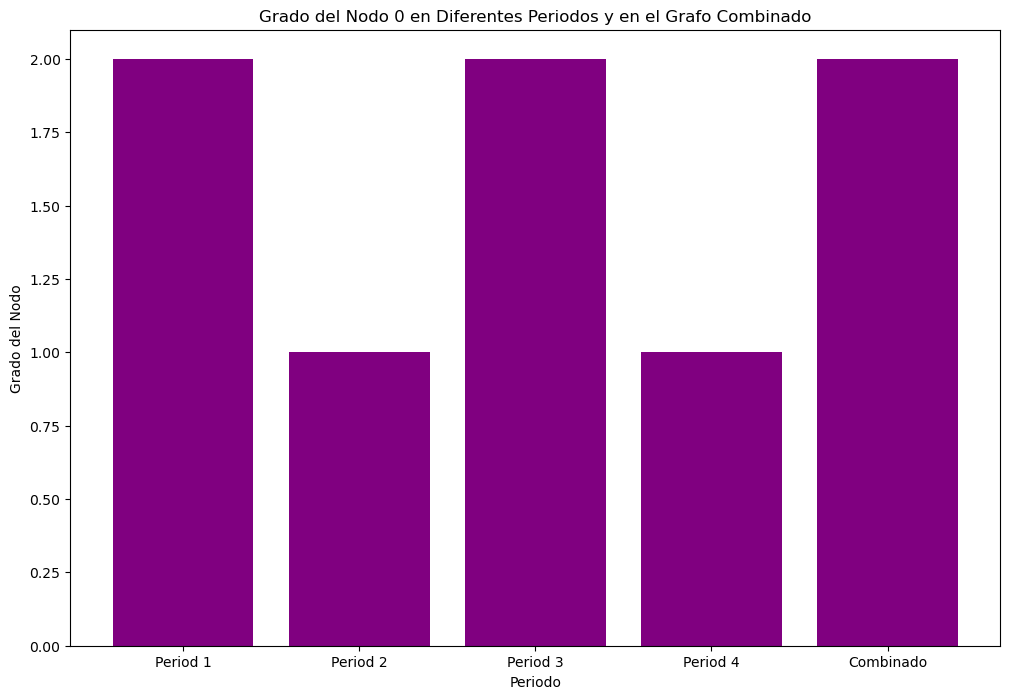

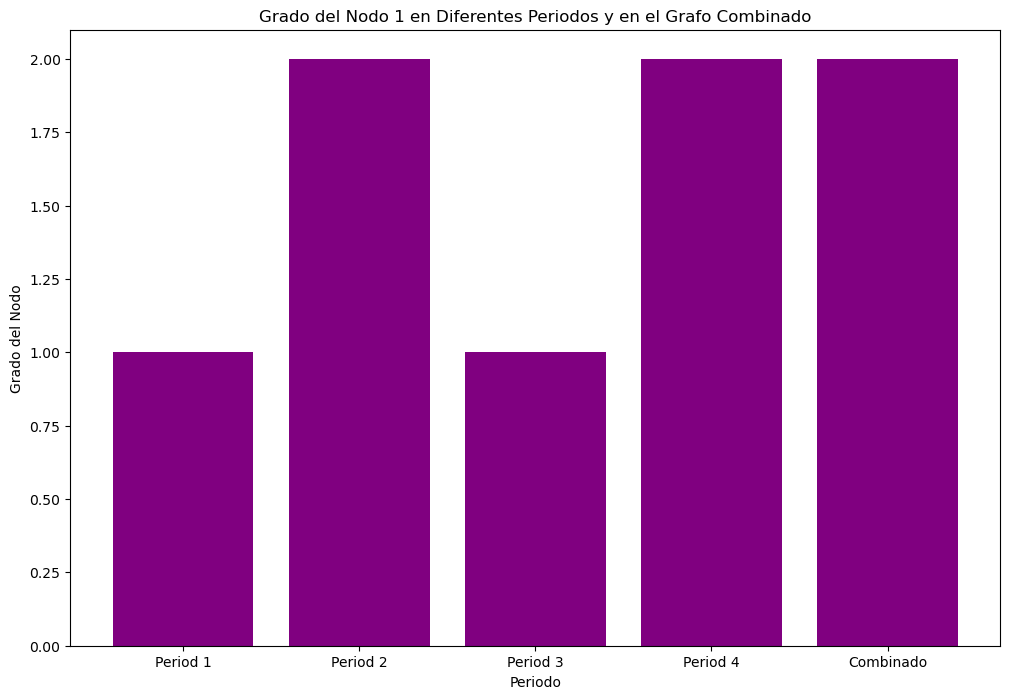

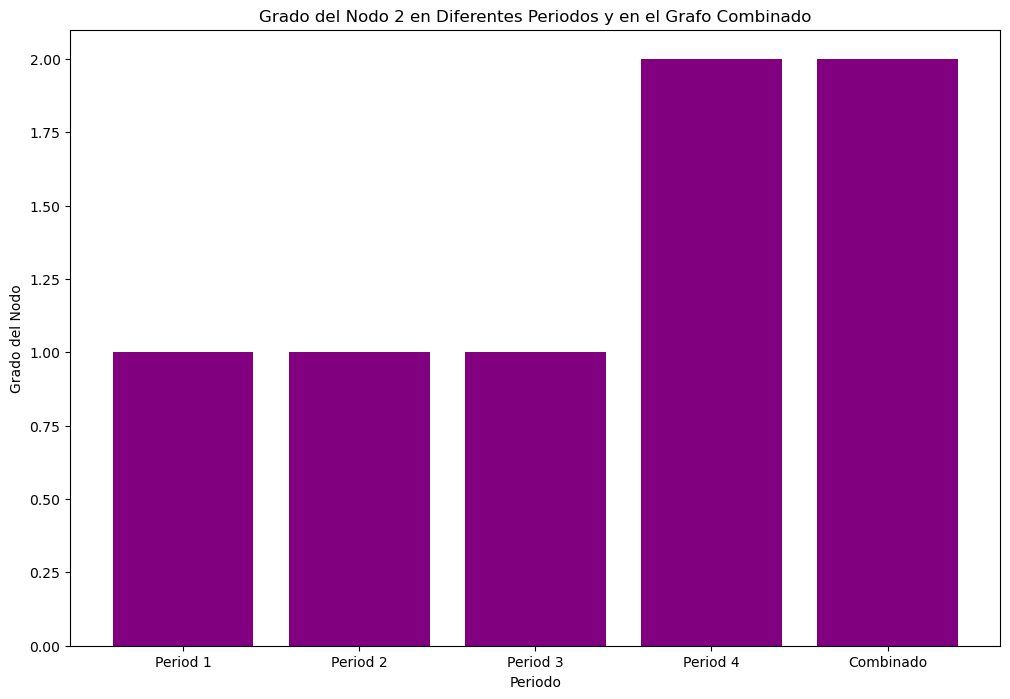

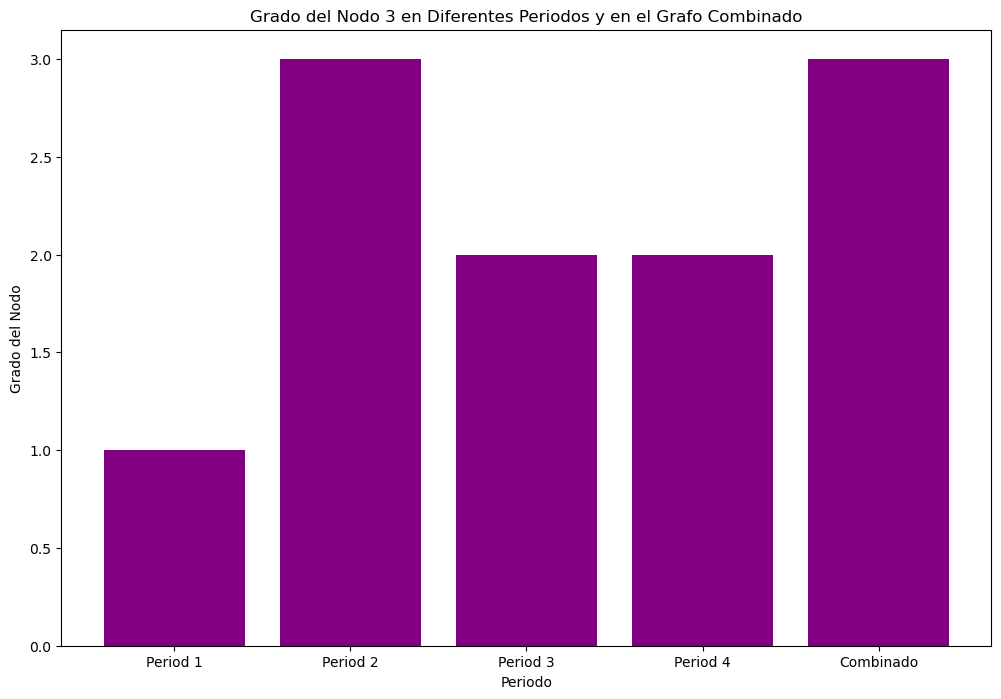

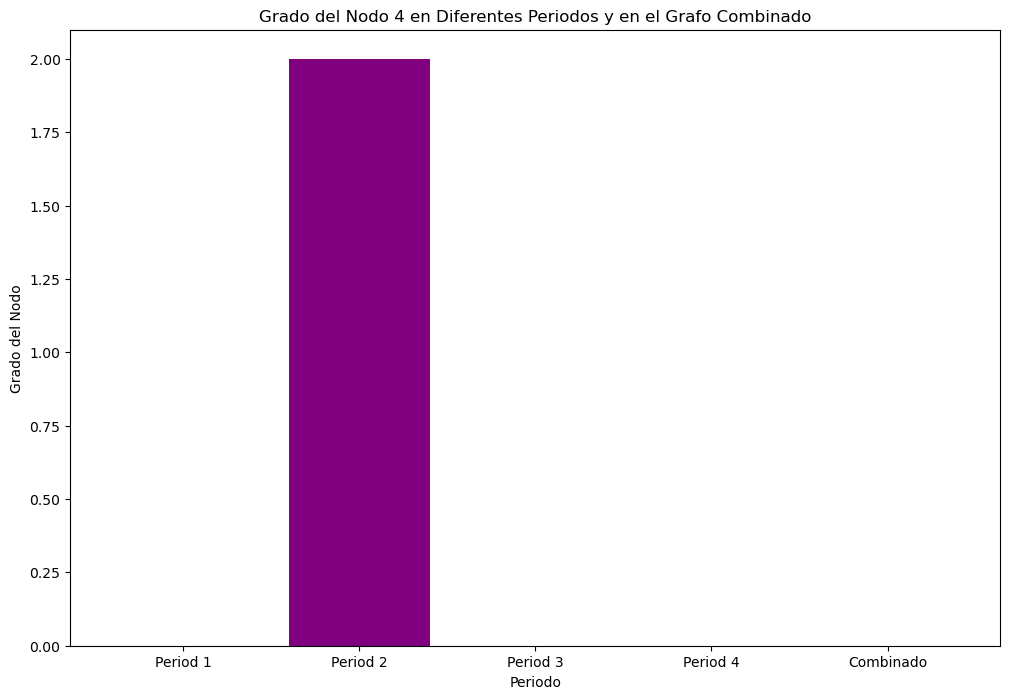

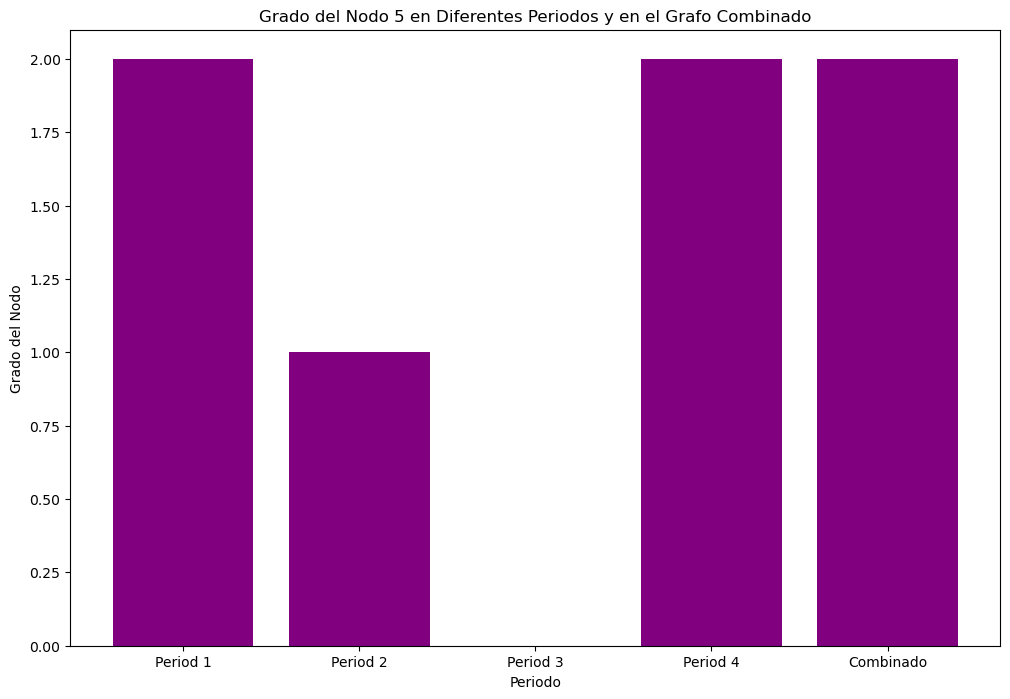

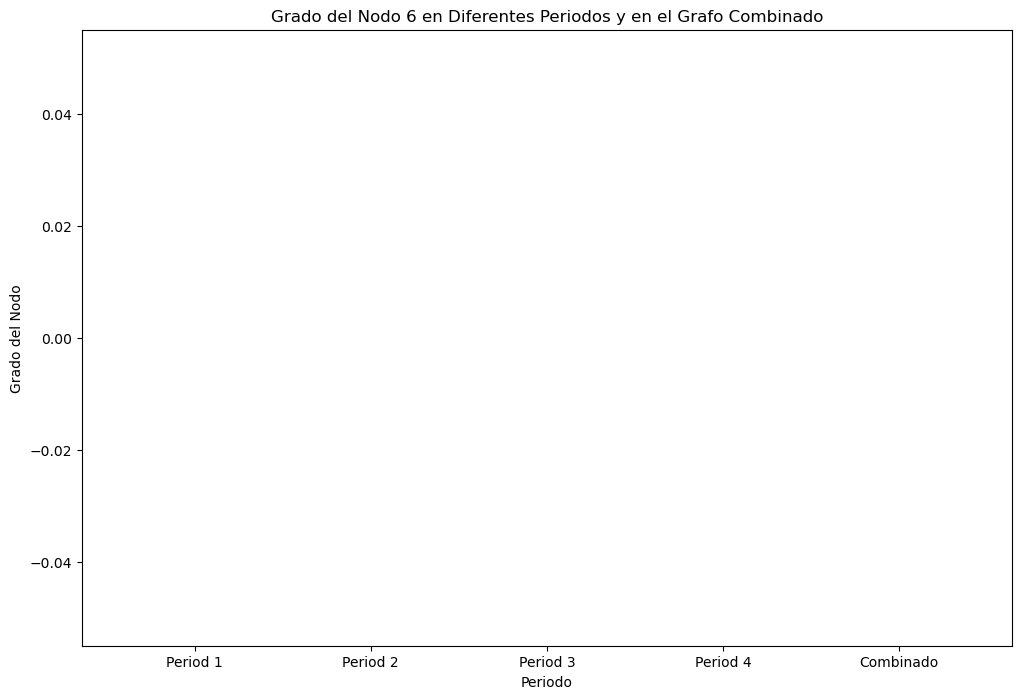

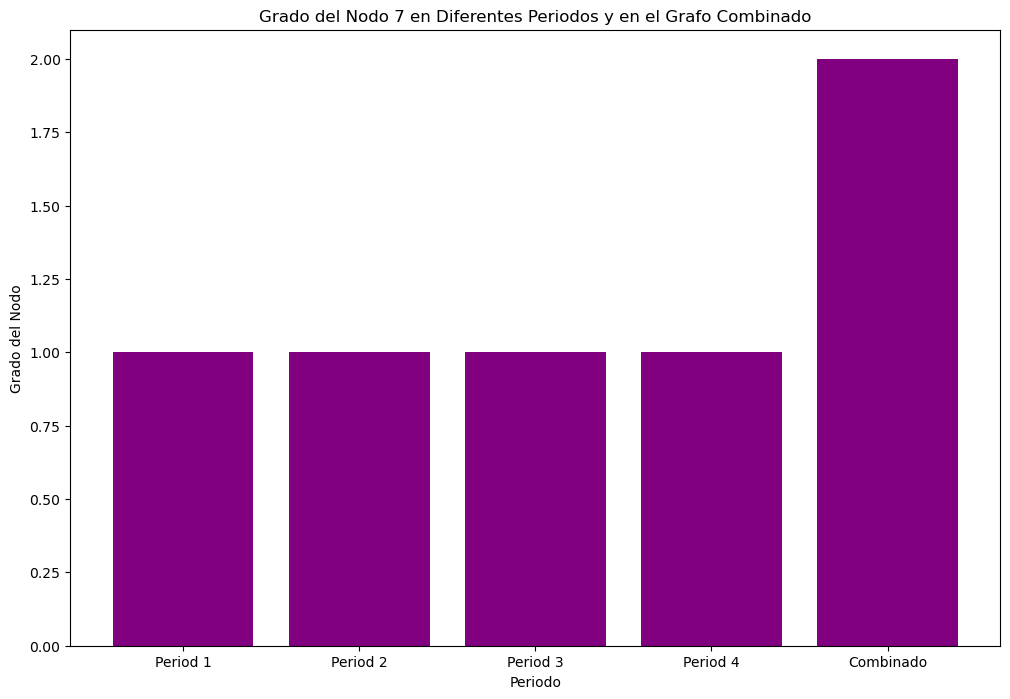

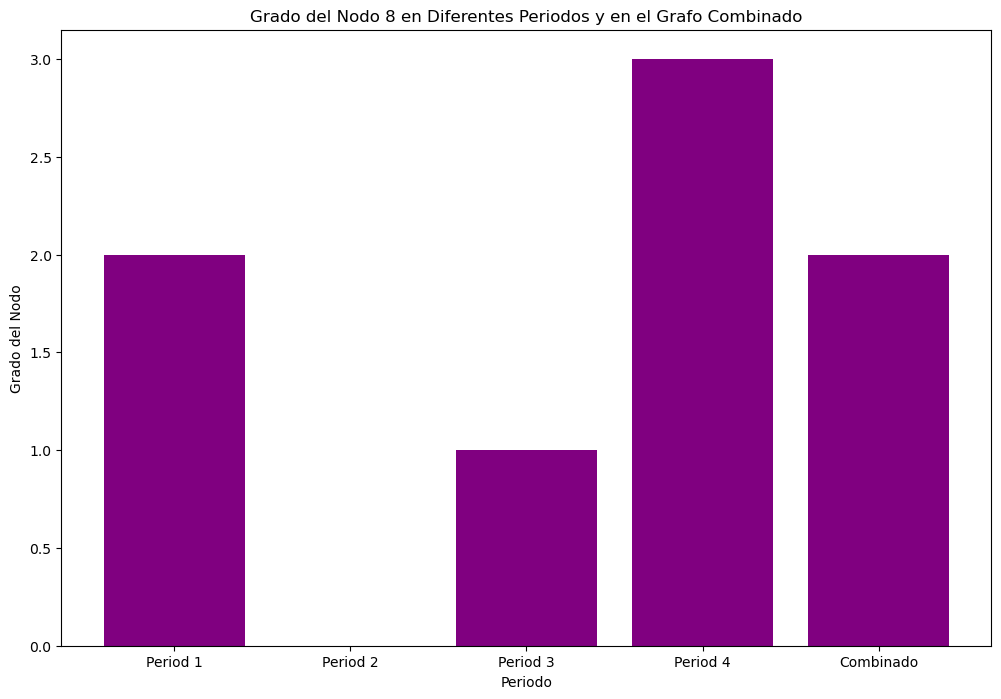

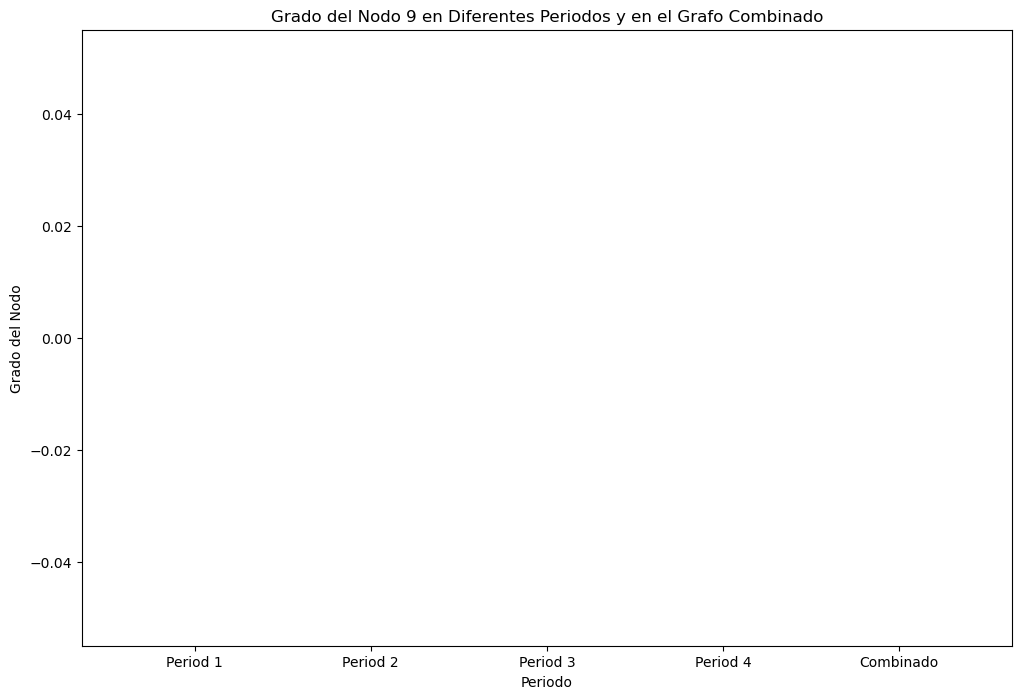

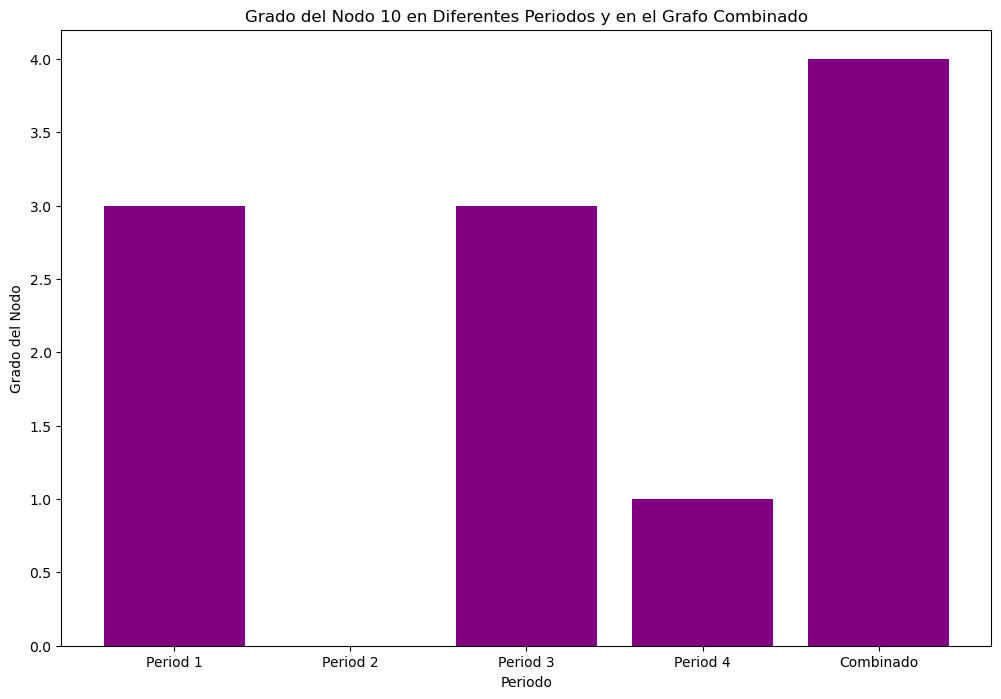

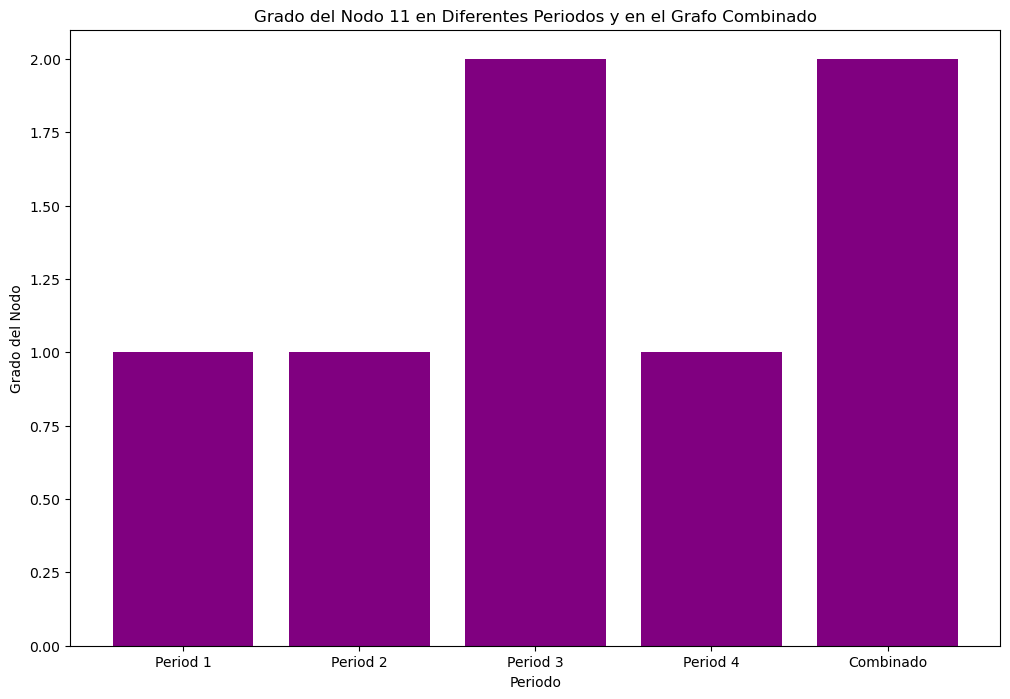

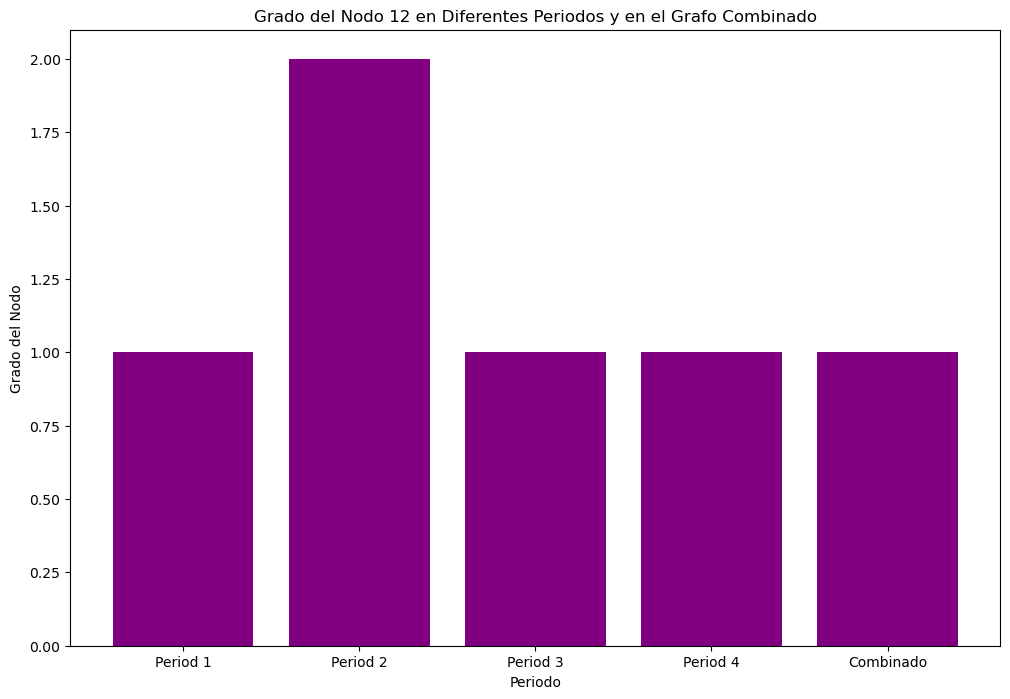

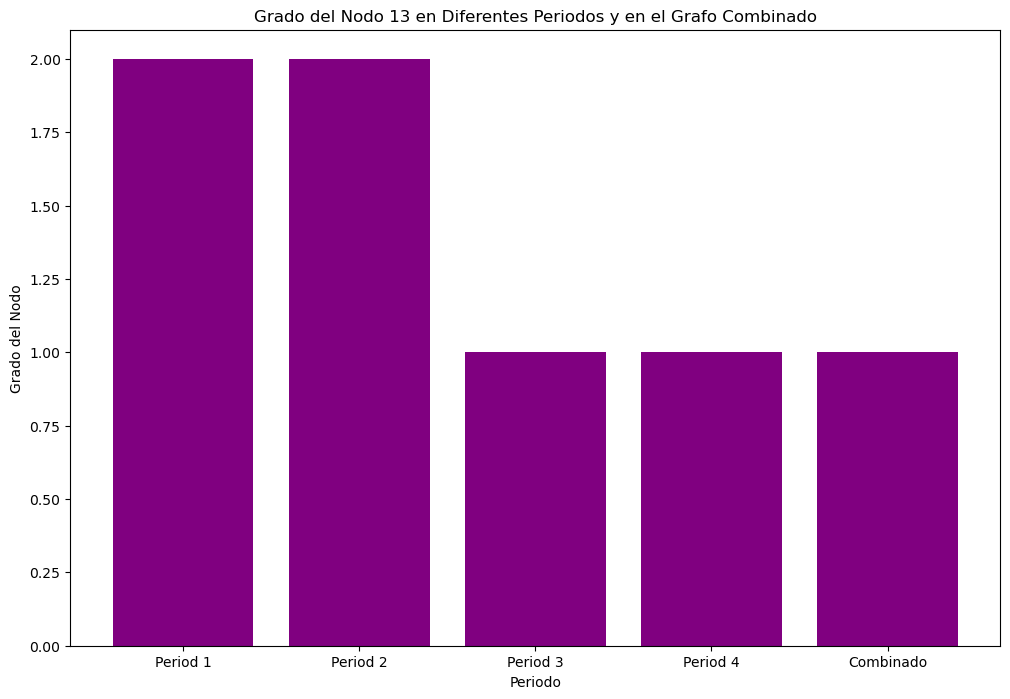

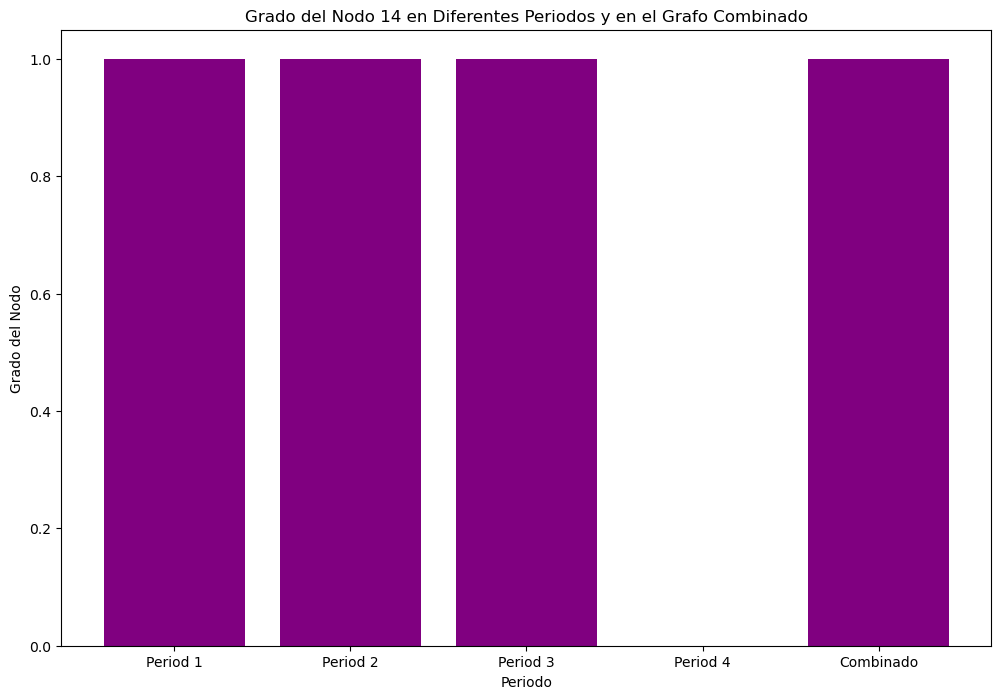

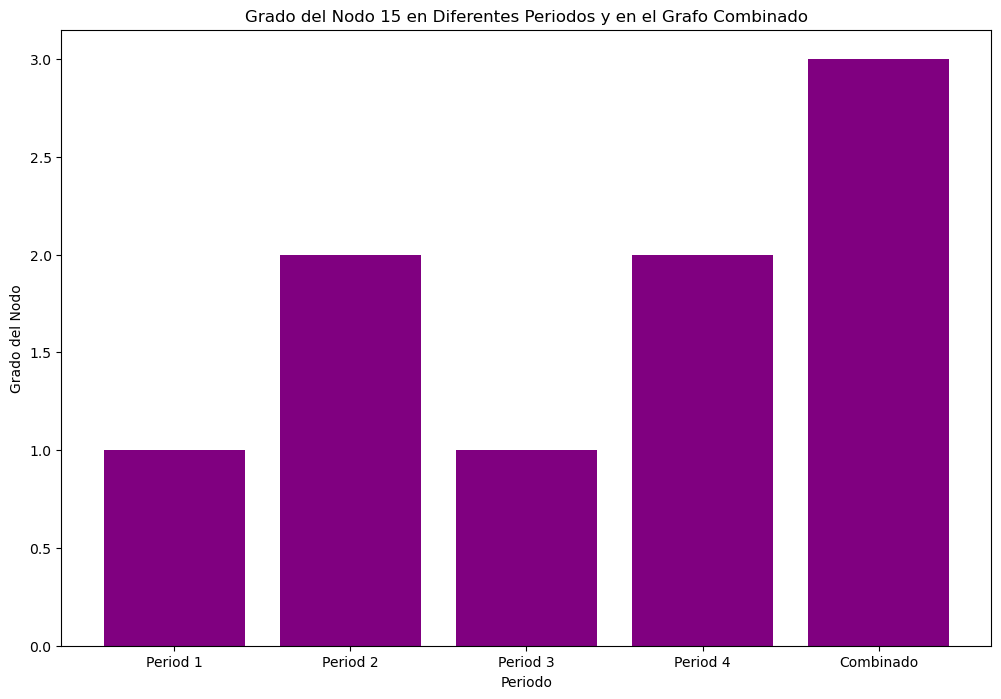

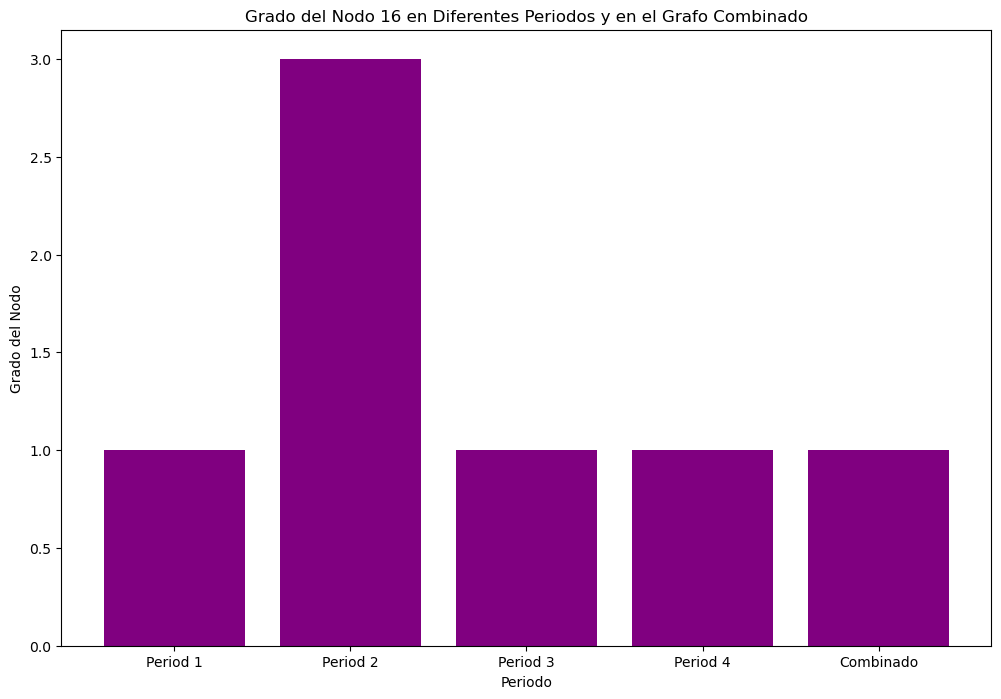

In [53]:
import matplotlib.pyplot as plt

# Convertir claves a enteros en los datos del grafo combinado para grados
loaded_results['Composite']['Degrees'] = {int(k): v for k, v in loaded_results['Composite']['Degrees'].items()}

# Asegúrate de cubrir todos los nodos que aparecen en cualquier periodo o en el combinado
total_nodos = max(max(k for k in period_data['Degrees'].keys()) for period_data in results.values())
total_nodos = max(total_nodos, max(int(k) for k in loaded_results['Composite']['Degrees'].keys())) + 1

for node_id in range(total_nodos):
    periods = list(results.keys())  # Lista de periodos
    degrees = [results[period]['Degrees'].get(node_id, 0) for period in periods]

    # Añadir el grado del nodo en el grafo combinado
    combined_degree = loaded_results['Composite']['Degrees'].get(node_id, 0)
    periods.append('Combinado')  # Añadir etiqueta para el grafo combinado
    degrees.append(combined_degree)  # Añadir el grado del nodo para el grafo combinado

    plt.figure(figsize=(12, 8))
    plt.bar(periods, degrees, color='purple')
    plt.xlabel('Periodo')
    plt.ylabel('Grado del Nodo')
    plt.title(f'Grado del Nodo {node_id} en Diferentes Periodos y en el Grafo Combinado')
    plt.show()


2. Análisis de Densidad de Red  
La densidad de una red se calcula como el número de enlaces presentes en la red dividido por el número total de enlaces posibles (en una red dirigida es n(n - 1), y para redes no dirigidas es n(n - 1)/2, donde n es el número de nodos). La densidad te da una idea de qué tan conectada está la red.  

4. Centralidad de Intermediación y Cercanía  
La centralidad de intermediación identifica los nodos que actúan como puentes entre otros nodos en la red. Se calcula contando el número de veces que un nodo actúa como punto de paso en el camino más corto entre dos otros nodos.  

La centralidad de cercanía se centra en la proximidad de un nodo a todos los demás en la red, calculada como el inverso de la suma de las distancias más cortas desde ese nodo a todos los demás nodos.  

7. Comparación de Grados de los Nodos  
El grado de un nodo es simplemente el número de conexiones que tiene. Puedes comparar el grado de cada nodo en los diferentes grafos para ver si hay nodos que consistentemente tienen grados altos o bajos, lo que puede señalar su importancia en la red en diferentes momentos.

